# Focal loss 

Focal loss для решения задачи сегментации был предствален в статье https://arxiv.org/abs/1708.02002
и имеет вид: $$ $$

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tqdm_notebook as tqn
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from focal_loss_batch import FocalBatch

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [4]:
ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, FocalBatch)

test_ix = DatasetIndex(range(65000-58500))
test_dataset = Dataset(test_ix, FocalBatch)

In [5]:
widening_factors = [3]
length_factors = [1]
add_blocks = [0]
gammas = [0.0, 0.5, 1.0, 2.0, 5.0]

In [14]:
gammas = [1.0]

In [15]:
n_iterations = 400

In [8]:
test_losses_lengths = defaultdict(list)
test_accs_lengths = defaultdict(list)
train_times_lengths = defaultdict(list)
pipelines_dict_length = defaultdict(list)

In [16]:
for index, gamma in enumerate(gammas):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':3, \
                    'length_factor':length_factors[0], \
                    'add_blocks':add_blocks[0], \
                       'gamma':gamma}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config)
                        .train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list, 1.0))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:],\
                                                                        full_labs[58500:], 1.0))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))
    
#     test_losses_lengths[str(index + 3)] = current_loss
#     test_accs_lengths[str(index + 3)] = current_acc
#     train_times_lengths[str(index + 3)] = time_list
#     pipelines_dict_length[str(index + 3)]  = ppl

    test_losses_lengths[str(9)] = current_loss
    test_accs_lengths[str(9)] = current_acc
    train_times_lengths[str(9)] = time_list
    pipelines_dict_length[str(9)]  = ppl

current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]
[[ 0.88949043  0.83080232  0.93015969  0.91306603  0.98941749  0.93419129
   0.90932554  0.83086985  0.8562578   0.91641951]
 [ 0.88018048  0.79815757  0.94442719  0.93255305  0.99656326  0.94399488
   0.92126197  0.80082655  0.85107809  0.93095696]
 [ 0.88678062  0.78854638  0.9544208   0.93280476  0.99761158  0.94017869
   0.93231285  0.79010713  0.84993488  0.92730212]
 [ 0.886832    0.79981107  0.9561069   0.93125123  0.99796486  0.95286578
   0.93623048  0.75995374  0.84027576  0.93870825]
 [ 0.90408814  0.7748422   0.94573933  0.92024654  0.99484271  0.94667071
   0.92555219  0.80813992  0.84530497  0.93457329]
 [ 0.8890335   0.78875673  0.94240272  0.935552    0.99646944  0.94628638
   0.92678648  0.78049743  0.85851598  0.93569928]
 [ 0.89949262  0.82016248  0.93304753  0.91471708  0.99057472  0.92955577
   0.92407417  0.81295979  0.85908663  0.91632926]
 

   0.93795449  0.77596426  0.8495338   0.93786067]]


  0%|▏                                                                                 | 1/400 [00:02<13:36,  2.05s/it]

[[ 0.81677449  0.95894724  0.90226394  0.73645502  0.9988386   0.91989452
   0.89548945  0.93677217  0.85917115  0.97539347]
 [ 0.8695308   0.93982583  0.89294839  0.74774861  0.99570143  0.90968555
   0.90006113  0.92065352  0.86771595  0.95612866]
 [ 0.83961976  0.95053393  0.8869642   0.74261475  0.99785858  0.91544491
   0.90710908  0.92956674  0.86160839  0.96867961]
 [ 0.86461544  0.94783419  0.89254844  0.73703861  0.99656039  0.91174376
   0.90233582  0.92018425  0.8679322   0.95920682]
 [ 0.84008294  0.96696544  0.91053331  0.69526911  0.99925202  0.92106241
   0.90275991  0.93553638  0.85120738  0.97733122]
 [ 0.80326688  0.9782756   0.90450126  0.68871474  0.99969542  0.91470349
   0.90843189  0.9445188   0.87837029  0.97952163]
 [ 0.8637653   0.93678319  0.89401579  0.75002873  0.9956935   0.9092415
   0.901586    0.91929847  0.87209004  0.95749742]
 [ 0.8100841   0.961366    0.89858055  0.74962437  0.99898291  0.90102971
   0.9029749   0.92928028  0.87656248  0.9715147 ]
 

   0.91260147  0.93078214  0.87228918  0.97084677]]


  0%|▍                                                                                 | 2/400 [00:02<10:59,  1.66s/it]

[[ 0.88223958  0.96576077  0.7829805   0.80084682  0.99624765  0.89514053
   0.87357682  0.95533484  0.90334761  0.94452482]
 [ 0.88075149  0.9418664   0.80478299  0.84269083  0.98781526  0.8941986
   0.88255     0.94272232  0.8917194   0.93090272]
 [ 0.88810885  0.93125683  0.81990004  0.8496477   0.98235863  0.89739382
   0.87699836  0.93798369  0.88824499  0.92810696]
 [ 0.88404375  0.94899571  0.80091327  0.82467246  0.98971981  0.90073705
   0.87846577  0.94297117  0.89765966  0.93182141]
 [ 0.87400633  0.95798087  0.75847137  0.8328132   0.99569839  0.91190475
   0.86844927  0.9589085   0.89009124  0.95167601]
 [ 0.86845517  0.95837069  0.79002154  0.81009322  0.99410069  0.89643264
   0.87791514  0.95846128  0.90054256  0.94560713]
 [ 0.88381267  0.9394868   0.78876895  0.83160007  0.98934335  0.89445144
   0.88613951  0.94810241  0.90089732  0.9373976 ]
 [ 0.87776923  0.9529624   0.77090979  0.83585823  0.99363637  0.89289296
   0.87774074  0.9555847   0.89795905  0.94468647]
 

   0.87696683  0.95603245  0.90154433  0.94646764]]


  1%|▌                                                                                 | 3/400 [00:03<09:07,  1.38s/it]

[[ 0.84074259  0.9589324   0.79259944  0.89292759  0.98950177  0.90929973
   0.86690098  0.94585687  0.90105635  0.90218234]
 [ 0.83337528  0.96129727  0.75331229  0.88769686  0.99095309  0.91150922
   0.88315785  0.95283157  0.90676451  0.91910195]
 [ 0.85477448  0.94822717  0.79900509  0.88692462  0.98193419  0.89550614
   0.88503969  0.94039714  0.90609503  0.90209651]
 [ 0.84788442  0.9500829   0.79696691  0.88319981  0.98710704  0.90991664
   0.89103496  0.93385333  0.89781886  0.90213507]
 [ 0.85815346  0.95436722  0.78959394  0.88736171  0.98553139  0.90560597
   0.88516718  0.93812084  0.8968882   0.89921016]
 [ 0.84456551  0.96124506  0.78078353  0.88055176  0.99132979  0.90784919
   0.87649739  0.95045286  0.90330696  0.90341794]
 [ 0.84346938  0.95800585  0.78977597  0.89166397  0.98717815  0.90744317
   0.8803339   0.94344038  0.89556628  0.90312296]
 [ 0.8305468   0.96264827  0.76711667  0.89048797  0.99125856  0.919644
   0.88211489  0.94931203  0.90235001  0.90452087]
 [

   0.88610959  0.94204229  0.90108472  0.8971377 ]]


  1%|▊                                                                                 | 4/400 [00:04<07:49,  1.19s/it]

[[ 0.87444538  0.92885435  0.84775692  0.8923375   0.96868575  0.90689403
   0.88414341  0.92003143  0.90412778  0.8727234 ]
 [ 0.86373901  0.92951733  0.8502894   0.89547688  0.96693683  0.89368355
   0.89260018  0.9265219   0.90543199  0.87580293]
 [ 0.87812358  0.91843414  0.85665739  0.8927986   0.96275538  0.8992703
   0.89271629  0.91776651  0.90038425  0.8810935 ]
 [ 0.86874694  0.93353987  0.8448382   0.89605337  0.96830088  0.89637935
   0.89431018  0.91995704  0.90271592  0.87515819]
 [ 0.86636949  0.93448418  0.83415878  0.89815915  0.97169864  0.90222687
   0.87975746  0.92117381  0.90584671  0.88612479]
 [ 0.88096237  0.92988116  0.84945709  0.89403754  0.968391    0.90721309
   0.87929952  0.91653311  0.90202487  0.87220019]
 [ 0.88246095  0.92254978  0.84015739  0.89601701  0.96656585  0.89328247
   0.89316213  0.92191422  0.90409577  0.87979454]
 [ 0.86338139  0.93871063  0.84703308  0.89830989  0.97499031  0.90516037
   0.87456387  0.92207432  0.90292132  0.87285495]
 

   0.88416719  0.92876095  0.89519382  0.87644196]]


  1%|█                                                                                 | 5/400 [00:05<06:55,  1.05s/it]

[[ 0.88310623  0.92420584  0.86481214  0.89683342  0.96502376  0.89695871
   0.88361639  0.92617446  0.89325786  0.86601114]
 [ 0.89574277  0.91171348  0.87599868  0.90210611  0.95235831  0.90140718
   0.88298035  0.91452909  0.897376    0.8657881 ]
 [ 0.88285899  0.91900069  0.86241376  0.90422696  0.9601109   0.90716612
   0.88894325  0.91229647  0.89504105  0.86794174]
 [ 0.8826263   0.92044699  0.87443745  0.90816802  0.95917755  0.90619832
   0.8766908   0.91775393  0.88788539  0.8666153 ]
 [ 0.88688624  0.92086798  0.86182159  0.90358114  0.96286654  0.89620179
   0.88351268  0.92225212  0.89417803  0.86783195]
 [ 0.85937673  0.93115491  0.86115539  0.91091067  0.96868855  0.89787591
   0.87336695  0.9285658   0.89733648  0.87156856]
 [ 0.88087821  0.92328763  0.86102611  0.90172005  0.96052372  0.90698826
   0.88580608  0.91689301  0.89774424  0.86513275]
 [ 0.88258719  0.93031746  0.84667361  0.91005522  0.96831256  0.89349186
   0.88681179  0.92560583  0.89599282  0.86015171]


   0.87554675  0.92588425  0.89360046  0.86202866]]


  2%|█▏                                                                                | 6/400 [00:05<06:17,  1.04it/s]

[[ 0.8913939   0.90344858  0.87052846  0.91720742  0.94541067  0.90216607
   0.88156039  0.91436833  0.89394653  0.87996972]
 [ 0.87720573  0.92864954  0.87349927  0.91501904  0.95779061  0.91816443
   0.85721171  0.91935182  0.88755     0.86555791]
 [ 0.87151468  0.93028843  0.87683243  0.91724092  0.96009362  0.9107281
   0.85492659  0.9252224   0.88360739  0.86954546]
 [ 0.9010179   0.89670974  0.87838864  0.90706348  0.94017035  0.90671712
   0.88604653  0.91148823  0.89473504  0.87766302]
 [ 0.88010967  0.91493499  0.86838531  0.91303074  0.95490682  0.90826672
   0.86448967  0.91836894  0.89633197  0.88117504]
 [ 0.88162583  0.91290534  0.87234008  0.91421223  0.94871545  0.90954834
   0.88024682  0.91636455  0.89127833  0.87276304]
 [ 0.89369452  0.90518951  0.87808251  0.90844643  0.94260234  0.90910959
   0.87705922  0.90724277  0.89392775  0.88464534]
 [ 0.89305955  0.90969586  0.88784903  0.90360856  0.93865657  0.9020896
   0.87911868  0.91296285  0.89422643  0.87873286]
 [

   0.88020545  0.91691279  0.89621758  0.87857491]]


  2%|█▍                                                                                | 7/400 [00:06<05:50,  1.12it/s]

[[ 0.88262099  0.91088134  0.87807822  0.91604197  0.93835902  0.90417111
   0.8739022   0.91985726  0.88731724  0.88877058]
 [ 0.88222158  0.91506666  0.87925345  0.92446017  0.9427321   0.90824062
   0.85282844  0.92203081  0.88811851  0.88504779]
 [ 0.88586068  0.90873396  0.87308973  0.91688842  0.93572551  0.90391517
   0.8726396   0.91785848  0.89263988  0.89264858]
 [ 0.88132572  0.91285223  0.88185823  0.91471857  0.9395498   0.90534639
   0.87419927  0.91777033  0.88970619  0.88267326]
 [ 0.88547772  0.91266233  0.88306731  0.91744304  0.93820012  0.90446043
   0.86571819  0.91958034  0.88309056  0.89029998]
 [ 0.8892749   0.90987766  0.88288748  0.91797566  0.93951881  0.90980095
   0.86535329  0.9141016   0.88770461  0.88350511]
 [ 0.88731605  0.91143483  0.88349426  0.91492271  0.94007349  0.91220742
   0.86020863  0.92006993  0.88686609  0.88340658]
 [ 0.89822394  0.89908808  0.88706243  0.91182804  0.93088001  0.90117908
   0.87598515  0.91451496  0.89275229  0.88848585]


   0.87078154  0.9228797   0.88783097  0.88903469]]


  2%|█▋                                                                                | 8/400 [00:07<05:31,  1.18it/s]

[[ 0.89258957  0.90095365  0.89106584  0.91624826  0.9213742   0.90578437
   0.87945431  0.91505611  0.88460314  0.89287055]
 [ 0.90081531  0.89383221  0.89294362  0.91468406  0.91804445  0.90748578
   0.87153411  0.91363049  0.89130801  0.89572191]
 [ 0.88203281  0.91147816  0.87765515  0.92072189  0.92942053  0.90540683
   0.8619644   0.92265314  0.88624352  0.90242356]
 [ 0.90229976  0.88945776  0.89351767  0.91456646  0.92064267  0.91362065
   0.88035125  0.90805072  0.88176566  0.8957274 ]
 [ 0.89348149  0.90499586  0.88518637  0.91405284  0.92519516  0.90385544
   0.86937642  0.9180522   0.8857376   0.90006655]
 [ 0.89533454  0.88997322  0.8881166   0.91793823  0.92484748  0.89862657
   0.88230026  0.91534156  0.89269918  0.8948223 ]
 [ 0.89352506  0.89459425  0.8896817   0.91821188  0.92199427  0.90453589
   0.8815096   0.91577524  0.88664246  0.89352959]
 [ 0.88569105  0.90439212  0.88459355  0.9162305   0.92459303  0.90309954
   0.8776356   0.91790092  0.88587314  0.89999056]


   0.85748959  0.92017186  0.88973337  0.8983435 ]]


  2%|█▊                                                                                | 9/400 [00:07<05:17,  1.23it/s]

[[ 0.90467042  0.90019757  0.88980037  0.92139012  0.91539758  0.91873854
   0.85446787  0.91516197  0.87633657  0.90383893]
 [ 0.90033019  0.90572774  0.88392895  0.91838533  0.91032434  0.91048419
   0.87334192  0.91484499  0.87523419  0.90739799]
 [ 0.89254898  0.90437603  0.89251244  0.91682965  0.91804969  0.91281259
   0.87390131  0.90805978  0.87838763  0.90252197]
 [ 0.8966229   0.8978579   0.89140844  0.91717726  0.91506255  0.9163636
   0.86045927  0.91649079  0.87706703  0.91149032]
 [ 0.90824974  0.88166815  0.89595401  0.90854454  0.90800077  0.91099513
   0.88499671  0.90850788  0.88644874  0.90663421]
 [ 0.91309172  0.87168688  0.8946963   0.90960884  0.9148497   0.91093445
   0.88538283  0.91336864  0.88201654  0.90436405]
 [ 0.89196157  0.89455116  0.89645159  0.92063618  0.91773516  0.91222119
   0.8655479   0.9198401   0.87295508  0.90810013]
 [ 0.90822899  0.89072502  0.89187658  0.9163599   0.91257626  0.91200995
   0.87156153  0.91057402  0.87928963  0.90679806]
 

   0.86590666  0.91855896  0.87527633  0.90419453]]


  2%|██                                                                               | 10/400 [00:08<05:07,  1.27it/s]

[[ 0.89123875  0.91283566  0.88800716  0.93565536  0.90704197  0.92747992
   0.83594269  0.91864002  0.86721146  0.91594702]
 [ 0.89316052  0.91918707  0.88804233  0.93343335  0.90227431  0.9229331
   0.82517117  0.92227691  0.8751452   0.91837609]
 [ 0.89602256  0.91359192  0.8928954   0.93301564  0.90741068  0.9238196
   0.8386603   0.91778946  0.8657952   0.91099912]
 [ 0.90976286  0.89545584  0.89692533  0.91963166  0.90231454  0.91658473
   0.8659569   0.9143185   0.86923802  0.90981162]
 [ 0.9030633   0.89537275  0.89093614  0.91855031  0.90472162  0.91691375
   0.87605345  0.91080248  0.87270331  0.91088295]
 [ 0.90714872  0.89998913  0.87959296  0.92477703  0.9035129   0.91850758
   0.86273491  0.91290164  0.88325977  0.90757537]
 [ 0.90027004  0.90504378  0.8903513   0.9139992   0.90631098  0.91278183
   0.87604851  0.91167563  0.87152714  0.91199154]
 [ 0.90083528  0.90562838  0.8920188   0.92209417  0.90730464  0.91768563
   0.86020017  0.91539288  0.8692742   0.90956587]
 [

   0.88106608  0.90952855  0.87313539  0.90800238]]


  3%|██▏                                                                              | 11/400 [00:09<05:00,  1.29it/s]

[[ 0.91443372  0.88738245  0.89528322  0.91506112  0.89591271  0.9143874
   0.88924772  0.90309459  0.87384731  0.91134983]
 [ 0.90711069  0.90409714  0.89158136  0.91761756  0.88802427  0.91142124
   0.87866431  0.91467279  0.87400782  0.91280293]
 [ 0.90406144  0.90220982  0.89576763  0.91630977  0.89837849  0.91525382
   0.88506997  0.90605265  0.86273515  0.91416132]
 [ 0.90713531  0.90288848  0.89253151  0.9101193   0.89916909  0.9111315
   0.8886075   0.90940124  0.86691117  0.9121049 ]
 [ 0.89845377  0.91293442  0.88526785  0.92787272  0.89433032  0.92153037
   0.86628062  0.90889096  0.87038577  0.91405314]
 [ 0.91068947  0.8942703   0.89318329  0.91825449  0.90130889  0.91825205
   0.87811768  0.90346241  0.87320608  0.9092555 ]
 [ 0.89884144  0.9112848   0.89298022  0.92546803  0.89839411  0.92783678
   0.86597317  0.90816253  0.85410243  0.9169566 ]
 [ 0.9086259   0.90994072  0.89611548  0.91686088  0.9017083   0.91676056
   0.87767982  0.90932423  0.8516115   0.9113726 ]
 [

   0.87022901  0.90981781  0.86096758  0.91262263]]


  3%|██▍                                                                              | 12/400 [00:10<04:55,  1.31it/s]

[[ 0.922616    0.88002449  0.90181243  0.91017735  0.89071345  0.91734028
   0.89941359  0.89910042  0.86320919  0.91559267]
 [ 0.91918421  0.88134569  0.8974719   0.90457654  0.89385629  0.91014469
   0.90343785  0.90004575  0.87945592  0.91048104]
 [ 0.91676605  0.89900368  0.89730275  0.91550767  0.88972771  0.91481048
   0.89692563  0.89838219  0.85946643  0.91210735]
 [ 0.92218316  0.87673974  0.89889848  0.91017056  0.89358461  0.91743791
   0.89891994  0.89825326  0.86976135  0.91405106]
 [ 0.90897018  0.89994699  0.89532769  0.91619837  0.89113528  0.91817468
   0.89525777  0.89851689  0.86159801  0.91487408]
 [ 0.9231478   0.87253618  0.89944184  0.90964687  0.89194298  0.91777134
   0.90261424  0.90106422  0.86795688  0.91387779]
 [ 0.92429543  0.8716079   0.90116066  0.90872419  0.89618844  0.91809416
   0.90020239  0.89782947  0.86960721  0.91229022]
 [ 0.91596973  0.89961332  0.89968383  0.91514802  0.88756776  0.92252982
   0.88854069  0.89825398  0.85923332  0.91345954]


   0.89590025  0.9035691   0.87276602  0.92108834]]


  3%|██▋                                                                              | 13/400 [00:10<04:52,  1.32it/s]

[[ 0.91923684  0.90261424  0.89956474  0.90380406  0.88516104  0.91437078
   0.91522628  0.89250076  0.84479666  0.9227246 ]
 [ 0.91502291  0.90593022  0.90183669  0.90924293  0.88066185  0.91158652
   0.90568852  0.89626664  0.85207272  0.921691  ]
 [ 0.9125734   0.90326279  0.89685774  0.90893358  0.88582003  0.90868521
   0.91306919  0.89434665  0.85755867  0.9188928 ]
 [ 0.91311324  0.9050414   0.89206988  0.9071275   0.88098419  0.91678917
   0.91489643  0.89453924  0.8489899   0.92644918]
 [ 0.91686487  0.91144288  0.89148235  0.91168267  0.87548268  0.9162004
   0.89868194  0.89491951  0.85828221  0.92496049]
 [ 0.91833216  0.89829147  0.8947106   0.90142202  0.8875798   0.91015285
   0.91332412  0.89444858  0.86601973  0.91571867]
 [ 0.92813396  0.87014896  0.8986516   0.90241623  0.887137    0.91274399
   0.91753364  0.89428651  0.87288487  0.91606337]
 [ 0.91229397  0.90283716  0.89840007  0.90679973  0.88186944  0.90978885
   0.91299617  0.89989865  0.84939563  0.92572033]
 

   0.91923153  0.89863831  0.87328053  0.91505373]]


  4%|██▊                                                                              | 14/400 [00:11<04:49,  1.33it/s]

[[ 0.92680371  0.89580601  0.9042114   0.90009499  0.8836655   0.91625661
   0.92052925  0.87613332  0.85202926  0.92446995]
 [ 0.9175151   0.90566504  0.89299905  0.90339452  0.88145077  0.91174817
   0.91765898  0.88747221  0.85863203  0.92346418]
 [ 0.91808218  0.90872443  0.89911729  0.90132833  0.88002348  0.91001892
   0.92077523  0.8861559   0.85348558  0.9222886 ]
 [ 0.91769236  0.89879686  0.89499092  0.90170598  0.88668966  0.91338301
   0.91788095  0.8761037   0.87533987  0.91741675]
 [ 0.91198415  0.90632606  0.89862108  0.90680003  0.88108021  0.91414225
   0.91854262  0.88001239  0.85711515  0.92537612]
 [ 0.92086124  0.91711378  0.89398646  0.90078515  0.87582934  0.91702044
   0.92152381  0.87890315  0.85492069  0.919056  ]
 [ 0.9194364   0.89739341  0.90372193  0.90695775  0.88115913  0.91471231
   0.92028791  0.88180679  0.84855312  0.92597121]
 [ 0.91832328  0.91002113  0.89397311  0.90378267  0.87705117  0.91816443
   0.91584194  0.87866282  0.85896438  0.92521507]


   0.91395277  0.87900203  0.85817659  0.92496914]]


  4%|███                                                                              | 15/400 [00:12<04:48,  1.33it/s]

[[ 0.92069513  0.89002866  0.90398854  0.90415394  0.8858133   0.91290045
   0.92338979  0.87646735  0.86323798  0.91932482]
 [ 0.92039794  0.90358889  0.91263604  0.89930463  0.8880989   0.91542417
   0.92137873  0.88243502  0.83421761  0.92251807]
 [ 0.91166162  0.91058272  0.90864336  0.90690476  0.87928194  0.91776139
   0.92029238  0.87959856  0.84219766  0.92307562]
 [ 0.92749828  0.89040536  0.90975392  0.89704973  0.88596201  0.91772628
   0.92350924  0.87816334  0.84549689  0.92443502]
 [ 0.91147709  0.90515405  0.90529805  0.90008438  0.88377512  0.90527058
   0.924968    0.88134527  0.85966372  0.92296368]
 [ 0.91553825  0.91415268  0.90072459  0.90563077  0.8737787   0.90827608
   0.92464775  0.87905359  0.85340506  0.92479259]
 [ 0.9158898   0.904127    0.90072143  0.90726346  0.88317043  0.91440433
   0.912305    0.87943333  0.86292177  0.91976351]
 [ 0.92475975  0.87898397  0.90798396  0.89895642  0.89056814  0.91621906
   0.9235729   0.8791275   0.85643387  0.92339456]


   0.91253734  0.8824845   0.85665017  0.92446643]]


  4%|███▏                                                                             | 16/400 [00:13<04:46,  1.34it/s]

[[ 0.90433252  0.918064    0.90768147  0.89889485  0.87986487  0.92009258
   0.92268026  0.86815554  0.86002946  0.92020458]
 [ 0.9097904   0.90617847  0.90696889  0.89872247  0.88872111  0.90935874
   0.92207408  0.88065815  0.86491549  0.91261232]
 [ 0.90756267  0.9136048   0.90601295  0.89500409  0.88839799  0.90747553
   0.91978359  0.87879074  0.86343116  0.91993648]
 [ 0.89150965  0.92969376  0.90136468  0.90967858  0.87810445  0.91117299
   0.91756272  0.88022852  0.85873199  0.92195261]
 [ 0.90518004  0.91329503  0.90480274  0.89640367  0.88298792  0.90353203
   0.92412251  0.88663316  0.86696404  0.91607887]
 [ 0.90070254  0.92034662  0.90982687  0.89345258  0.8872174   0.90716136
   0.92584175  0.8845759   0.84942937  0.92144567]
 [ 0.90543741  0.91636115  0.90150732  0.9042232   0.87763906  0.90472984
   0.92118013  0.8867017   0.8633889   0.91883123]
 [ 0.89877963  0.92434853  0.89921927  0.90733206  0.87446451  0.91338241
   0.91082692  0.88302648  0.86406076  0.92455935]


   0.92311811  0.88390511  0.85185194  0.92632025]]


  4%|███▍                                                                             | 17/400 [00:13<04:45,  1.34it/s]

[[ 0.88313603  0.92692387  0.91089112  0.90389729  0.88327825  0.91203928
   0.91969454  0.88313097  0.857871    0.91913766]
 [ 0.90176809  0.92205185  0.90356922  0.89919847  0.88480473  0.90848362
   0.9184615   0.87649775  0.86975259  0.91541219]
 [ 0.90190238  0.91353184  0.91216445  0.89962238  0.88165134  0.90749002
   0.91358948  0.88164663  0.87150472  0.91689694]
 [ 0.915254    0.87305421  0.91564459  0.89760274  0.89216107  0.90969616
   0.93092883  0.87877464  0.87153685  0.91534686]
 [ 0.92271245  0.86602771  0.91071367  0.89376408  0.89247185  0.90572989
   0.9267475   0.88695854  0.88234693  0.91252732]
 [ 0.90796715  0.90799427  0.9052003   0.89945519  0.88391423  0.90268993
   0.9221133   0.88037086  0.87725741  0.91303748]
 [ 0.90843767  0.89896858  0.90913308  0.89712733  0.88788807  0.90861392
   0.92795807  0.87666446  0.87219065  0.91301817]
 [ 0.89446503  0.92477268  0.90397763  0.8958956   0.88838208  0.90346909
   0.9227556   0.88059831  0.86752784  0.91815627]


   0.93000317  0.88974172  0.85113525  0.91656178]]


  4%|███▋                                                                             | 18/400 [00:14<04:43,  1.35it/s]

[[ 0.87221318  0.93747401  0.91043746  0.90080333  0.88736343  0.91482216
   0.91510147  0.8823806   0.86422521  0.91517913]
 [ 0.92078143  0.85575986  0.91519606  0.89345008  0.89887351  0.90588218
   0.92968726  0.88788259  0.88379258  0.90869451]
 [ 0.89507753  0.92119235  0.90076888  0.89917642  0.88487095  0.90512294
   0.91486996  0.88324851  0.88720399  0.90846831]
 [ 0.88451171  0.92726105  0.89820451  0.88814479  0.88063473  0.90848017
   0.91466266  0.89008158  0.88651502  0.92150366]
 [ 0.91800237  0.86560476  0.91533047  0.89607435  0.89553154  0.90724361
   0.9282496   0.888363    0.87894553  0.90665472]
 [ 0.90152133  0.89535844  0.91648495  0.89526784  0.89165443  0.91101944
   0.92275774  0.88509023  0.86815345  0.91269219]
 [ 0.88095659  0.92339087  0.91543782  0.89766836  0.88348502  0.91271937
   0.91818041  0.8864218   0.86430687  0.91743302]
 [ 0.89541399  0.91344142  0.90302086  0.89279002  0.88953042  0.89809442
   0.91726649  0.8890332   0.88761187  0.91379732]


   0.92400354  0.8848803   0.86902153  0.91490257]]


  5%|███▊                                                                             | 19/400 [00:15<04:42,  1.35it/s]

[[ 0.88247252  0.9131403   0.91020232  0.89507419  0.88464141  0.90644562
   0.91817302  0.8917731   0.88857728  0.90950024]
 [ 0.90252393  0.88537955  0.91576874  0.89516222  0.89616543  0.90719151
   0.92131174  0.88423407  0.88542062  0.90684217]
 [ 0.84932566  0.93613112  0.90608019  0.90286857  0.88085121  0.91752887
   0.91159874  0.8936705   0.88501024  0.91693491]
 [ 0.89092863  0.90365416  0.90922564  0.89774334  0.88999277  0.90331095
   0.92437983  0.88719332  0.88410646  0.90946472]
 [ 0.87562555  0.92181563  0.90307552  0.90273225  0.88451195  0.91671443
   0.90135849  0.89241934  0.88578868  0.91595817]
 [ 0.89970315  0.89292133  0.90782332  0.89518142  0.88886595  0.91027707
   0.91698813  0.88830435  0.88816726  0.91176808]
 [ 0.88960391  0.91230518  0.90651667  0.89632481  0.88866597  0.91246963
   0.91306257  0.88567483  0.88416421  0.91121209]
 [ 0.88360375  0.91484207  0.90957022  0.89884585  0.88943177  0.9027245
   0.91923863  0.8888762   0.88091898  0.91194814]
 

   0.92528635  0.8822127   0.88695192  0.90514529]]


  5%|████                                                                             | 20/400 [00:16<04:41,  1.35it/s]

[[ 0.87623966  0.91267002  0.90928566  0.89922822  0.89302659  0.92057407
   0.9172076   0.88423485  0.88557094  0.90196246]
 [ 0.90644169  0.86384398  0.91740239  0.89218253  0.89751363  0.91157216
   0.92956591  0.88706064  0.89023709  0.90417999]
 [ 0.888484    0.9055441   0.90528238  0.90475172  0.8886289   0.91503203
   0.90417147  0.88614792  0.89923936  0.90271813]
 [ 0.87768918  0.92100883  0.89681059  0.90271223  0.88267189  0.92079437
   0.90448153  0.8900038   0.89849234  0.90533519]
 [ 0.89467776  0.88146198  0.90819257  0.8986901   0.89387423  0.91430473
   0.91415608  0.89093536  0.89810139  0.90560579]
 [ 0.90349609  0.87693852  0.90843946  0.89596009  0.89909768  0.91556978
   0.92463911  0.87902534  0.89514333  0.90169054]
 [ 0.88182855  0.91922826  0.91197348  0.89172912  0.89396405  0.91365695
   0.91156912  0.89395034  0.88068533  0.90141487]
 [ 0.90631735  0.88207912  0.90128785  0.90381461  0.89159644  0.91219997
   0.91342163  0.88660324  0.90209436  0.90058547]


   0.90895641  0.89733225  0.88167542  0.90633816]]


  5%|████▎                                                                            | 21/400 [00:16<04:41,  1.35it/s]

[[ 0.94494832  0.69972014  0.92717069  0.90752852  0.92239469  0.92010117
   0.94296694  0.90582401  0.91605192  0.9132936 ]
 [ 0.86231327  0.92389786  0.91242206  0.88997829  0.89592224  0.91605961
   0.92254412  0.89850265  0.88490266  0.89345711]
 [ 0.85114658  0.93341494  0.89679182  0.8998031   0.88572234  0.92410022
   0.89169276  0.90716243  0.90462691  0.90553886]
 [ 0.87392741  0.89518201  0.90950453  0.90490556  0.89229184  0.92204165
   0.91154081  0.89387399  0.89837348  0.8983587 ]
 [ 0.83655882  0.92551035  0.90808308  0.90237367  0.89225334  0.9264918
   0.9116711   0.90311027  0.88880205  0.90514553]
 [ 0.94389725  0.70482445  0.92848301  0.90997285  0.92373234  0.92563659
   0.94304234  0.89494026  0.91519201  0.91027892]
 [ 0.8533895   0.93216026  0.90009028  0.89992046  0.88869792  0.92671096
   0.90681887  0.89901412  0.89515924  0.89803851]
 [ 0.89473605  0.87554365  0.91409707  0.89232147  0.90447271  0.92086101
   0.92669058  0.8932485   0.88675034  0.89127868]
 

   0.90794343  0.90349519  0.89552689  0.9064759 ]]


  6%|████▍                                                                            | 22/400 [00:17<04:40,  1.35it/s]

[[ 0.94184828  0.74482411  0.9229306   0.91137052  0.92064965  0.93373418
   0.9216463   0.90043825  0.91881949  0.88373864]
 [ 0.90909755  0.83523852  0.91007054  0.90759772  0.90524411  0.92228663
   0.91110355  0.89707386  0.91137797  0.89090967]
 [ 0.89427751  0.87839842  0.91384482  0.8879267   0.90664369  0.92279804
   0.91184914  0.89973146  0.90001369  0.88451666]
 [ 0.89885062  0.87226355  0.90090984  0.90093726  0.90164858  0.91746658
   0.90289295  0.90096468  0.91033614  0.89372981]
 [ 0.88764578  0.88538235  0.8986209   0.90457892  0.89594853  0.92739087
   0.88867414  0.90333909  0.91529787  0.89312148]
 [ 0.91296375  0.80986166  0.91600668  0.90247542  0.91151261  0.92940122
   0.91990948  0.89658809  0.90938932  0.89189172]
 [ 0.91448516  0.84128624  0.90591305  0.8977226   0.90391755  0.92834878
   0.92105687  0.88670111  0.91404748  0.88652116]
 [ 0.90867525  0.83738708  0.91052365  0.9030236   0.90710223  0.92900902
   0.92026657  0.89519119  0.90584481  0.88297641]


   0.88591802  0.90792805  0.91741562  0.89852959]]


  6%|████▋                                                                            | 23/400 [00:18<04:38,  1.35it/s]

[[ 0.88268971  0.8793776   0.90834439  0.91131079  0.90830976  0.93284798
   0.88297939  0.90324116  0.91576886  0.87513047]
 [ 0.93314832  0.78086001  0.91862512  0.90812105  0.91960818  0.92997915
   0.90792137  0.90240186  0.92124069  0.87809426]
 [ 0.89459258  0.87220281  0.90827531  0.90251875  0.90867931  0.93288046
   0.88571876  0.90878338  0.91138977  0.87495887]
 [ 0.84778583  0.92424387  0.90960777  0.90586782  0.90324521  0.93776566
   0.8718617   0.91513056  0.90672451  0.87776715]
 [ 0.88281256  0.88123447  0.90841949  0.91284549  0.90851831  0.94298989
   0.87991202  0.9090606   0.90461695  0.86959022]
 [ 0.87561786  0.92675298  0.87763286  0.9103061   0.88997209  0.94069898
   0.85355818  0.91735536  0.92715496  0.88095075]
 [ 0.86569828  0.90723926  0.90662348  0.9104715   0.90623319  0.9420706
   0.87862623  0.90790439  0.90767258  0.86746061]
 [ 0.91463912  0.83019948  0.90796661  0.90699178  0.9089632   0.93468362
   0.91035837  0.89092821  0.92095071  0.87431884]
 

   0.87412965  0.90657508  0.92142588  0.8779828 ]]


  6%|████▊                                                                            | 24/400 [00:19<04:38,  1.35it/s]

[[ 0.89015573  0.91295558  0.90548384  0.90577215  0.91259396  0.93696892
   0.86703151  0.90812624  0.91195709  0.84895498]
 [ 0.89106822  0.90249282  0.9148128   0.89747059  0.92085761  0.93875927
   0.86526471  0.9150691   0.9017722   0.85243267]
 [ 0.9180603   0.87798488  0.91682673  0.90650415  0.92377657  0.94258338
   0.85855055  0.91054356  0.90703553  0.83813429]
 [ 0.89545411  0.91921794  0.8969968   0.91360736  0.91145384  0.94446158
   0.85045218  0.90780079  0.91942477  0.84113067]
 [ 0.91044354  0.86124647  0.90900826  0.89920044  0.91832149  0.93253642
   0.87794614  0.91198325  0.9135583   0.86575574]
 [ 0.88257051  0.91842496  0.91498387  0.90826607  0.92348969  0.94694519
   0.84478283  0.91708672  0.89996076  0.84348941]
 [ 0.9478848   0.6899091   0.93044698  0.92643923  0.93974602  0.94041628
   0.92449713  0.90373194  0.92929161  0.86763686]
 [ 0.93309146  0.81100297  0.91461456  0.91074187  0.92321551  0.9300257
   0.8977915   0.90011299  0.91845465  0.86094874]
 

   0.8167305   0.92559659  0.91094279  0.84246969]]


  6%|█████                                                                            | 25/400 [00:19<04:37,  1.35it/s]

[[ 0.91270494  0.87385952  0.91016114  0.90201432  0.91880226  0.92801023
   0.88867152  0.90849817  0.90482485  0.85245311]
 [ 0.92604101  0.846376    0.92110485  0.89925241  0.92908502  0.94184411
   0.88586605  0.90767074  0.90195757  0.84080225]
 [ 0.92203581  0.86240661  0.91034806  0.9140209   0.91550523  0.93996727
   0.88106787  0.90097225  0.91358465  0.84009147]
 [ 0.86395782  0.95058298  0.89298898  0.91443145  0.90047079  0.9404999
   0.81992888  0.9257313   0.92147219  0.86993557]
 [ 0.9052248   0.88859081  0.91400748  0.90403539  0.92528105  0.94305307
   0.87675995  0.90287203  0.9061113   0.83406401]
 [ 0.89116502  0.91525888  0.90532845  0.90375304  0.91602516  0.93454051
   0.86363906  0.91270298  0.90738493  0.85020196]
 [ 0.84292245  0.96148926  0.88202584  0.91539162  0.9119541   0.95175922
   0.8123951   0.92562723  0.92134327  0.87509179]
 [ 0.94799536  0.78187895  0.92810184  0.91907316  0.9305768   0.94470811
   0.88639545  0.91019011  0.91566974  0.83541048]
 

   0.79969454  0.92888546  0.92800468  0.87620121]]


  6%|█████▎                                                                           | 26/400 [00:20<04:36,  1.35it/s]

[[ 0.9047575   0.92202419  0.90376282  0.90212715  0.91629827  0.94165879
   0.82235634  0.92881548  0.90289021  0.85530925]
 [ 0.88797456  0.95294142  0.89416856  0.90472138  0.91987449  0.95500702
   0.78384519  0.93494499  0.90765905  0.85886329]
 [ 0.84095383  0.96832442  0.90744293  0.91559327  0.91103935  0.95403117
   0.81973493  0.92697215  0.90440577  0.85150206]
 [ 0.96452129  0.65438378  0.93702322  0.92725199  0.94115829  0.94028032
   0.92842251  0.90720439  0.92245144  0.87730271]
 [ 0.79978406  0.98259908  0.90158892  0.92034167  0.91395265  0.95808506
   0.78201091  0.94288063  0.91039228  0.88836461]
 [ 0.93097037  0.86081254  0.91444826  0.90912831  0.92007315  0.93699586
   0.85999459  0.91956264  0.90279889  0.8452152 ]
 [ 0.83787072  0.96841735  0.91540903  0.89824593  0.91110408  0.94791561
   0.83451921  0.92740011  0.89564347  0.86347443]
 [ 0.84809566  0.96947068  0.89164209  0.89476204  0.90678698  0.94616777
   0.8199411   0.93592733  0.91135675  0.8758496 ]


   0.88700533  0.90622318  0.9071731   0.86296761]]


  7%|█████▍                                                                           | 27/400 [00:21<04:35,  1.35it/s]

[[ 0.78979039  0.99005991  0.89805198  0.90597504  0.90076315  0.95669663
   0.80840278  0.9435879   0.914074    0.89259827]
 [ 0.95461148  0.79501778  0.92703569  0.89195806  0.92591333  0.92956144
   0.92104036  0.89909029  0.90113717  0.85463434]
 [ 0.94524956  0.85316688  0.9264009   0.88690555  0.91787589  0.92928022
   0.89553076  0.90870148  0.89046264  0.84642613]
 [ 0.9800539   0.53885365  0.94818026  0.92542803  0.94838864  0.93945861
   0.94952524  0.9272989   0.93563122  0.9071815 ]
 [ 0.89480245  0.94194585  0.90223044  0.87966514  0.90187305  0.93494451
   0.88918746  0.89751035  0.89649677  0.86134398]
 [ 0.84824556  0.97772646  0.8724907   0.88922513  0.89274406  0.93878204
   0.82555562  0.93253571  0.91759062  0.90510398]
 [ 0.83983874  0.97439706  0.88532853  0.90288895  0.89588284  0.94009018
   0.81880325  0.92783958  0.91984558  0.89508528]
 [ 0.88984346  0.95039868  0.89573383  0.89775503  0.89321858  0.93596286
   0.83856016  0.91912794  0.90978265  0.86961675]


   0.836604    0.92584366  0.89976412  0.87047291]]


  7%|█████▋                                                                           | 28/400 [00:21<04:34,  1.36it/s]

[[ 0.84160906  0.97827154  0.8717221   0.87885427  0.8817094   0.92459261
   0.86028934  0.92800307  0.91709632  0.91785234]
 [ 0.69740307  0.9976868   0.8853845   0.88104475  0.90816182  0.95504403
   0.85562962  0.96012861  0.91532594  0.9441908 ]
 [ 0.85575128  0.98102969  0.89864904  0.8685621   0.88672292  0.92984557
   0.85093117  0.93529385  0.88550067  0.90771377]
 [ 0.91267234  0.9370504   0.90670145  0.84336746  0.8999297   0.90706259
   0.9045096   0.91536105  0.87693971  0.89640564]
 [ 0.86701739  0.97953069  0.87362599  0.87703228  0.87563658  0.93583381
   0.82106698  0.93364382  0.91831291  0.91829956]
 [ 0.87604469  0.96816021  0.88109136  0.87052566  0.88062954  0.91019374
   0.87273645  0.92015666  0.91246033  0.90800148]
 [ 0.80230319  0.99281782  0.89985818  0.85237902  0.90381575  0.94729471
   0.85267383  0.94775629  0.88105309  0.92004812]
 [ 0.8570655   0.97855371  0.8847428   0.84900999  0.89018518  0.92432112
   0.86610073  0.93179727  0.90111399  0.91710979]


   0.83695871  0.93101871  0.91106761  0.91888201]]


  7%|█████▊                                                                           | 29/400 [00:22<04:34,  1.35it/s]

[[ 0.84297752  0.97667134  0.89939153  0.85498643  0.88905227  0.89858174
   0.90911019  0.92017663  0.89350462  0.91554785]
 [ 0.974635    0.79557174  0.92735195  0.86453009  0.90825766  0.89991182
   0.94820696  0.89616126  0.8909936   0.89437985]
 [ 0.96055347  0.88060337  0.93138784  0.83352995  0.91073722  0.90299916
   0.95182985  0.89513737  0.83935553  0.89386624]
 [ 0.88604307  0.96770674  0.88859612  0.85892457  0.87916452  0.89404261
   0.90887481  0.90941209  0.89925337  0.90798217]
 [ 0.90788865  0.95877451  0.90633905  0.84272343  0.88648134  0.90309012
   0.92653972  0.89638054  0.87992841  0.89185423]
 [ 0.79183412  0.99276084  0.91071427  0.83027375  0.89740771  0.9293173
   0.89896983  0.93911016  0.87836844  0.9312436 ]
 [ 0.88949198  0.97332621  0.89851797  0.83135152  0.88187134  0.90178078
   0.91533554  0.91432196  0.88487458  0.90912807]
 [ 0.90116608  0.96877003  0.90891749  0.79300559  0.90097135  0.89338416
   0.93738198  0.91710991  0.86804271  0.91125077]
 

   0.89561921  0.92476141  0.87976432  0.90531445]]


  8%|██████                                                                           | 30/400 [00:23<04:33,  1.35it/s]

[[ 0.94277543  0.9235031   0.89437532  0.86748219  0.88882971  0.88826621
   0.9433133   0.8734293   0.87715018  0.90087521]
 [ 0.92666829  0.95232123  0.86746621  0.87364739  0.87609732  0.90357322
   0.89213324  0.90607274  0.88752288  0.91449744]
 [ 0.77332038  0.99724144  0.81620097  0.8799929   0.89161223  0.93279707
   0.87851131  0.94896382  0.92444432  0.95691562]
 [ 0.74716294  0.99771941  0.84014446  0.9064467   0.87806487  0.93703622
   0.84573799  0.95454222  0.93887627  0.95426875]
 [ 0.86396289  0.99011284  0.84261316  0.84722543  0.87546313  0.90443462
   0.90983373  0.93144536  0.8970629   0.937846  ]
 [ 0.81980234  0.99131978  0.86746502  0.85096598  0.88638479  0.91359186
   0.91673255  0.92226422  0.89793533  0.93353826]
 [ 0.93680644  0.9253093   0.88906115  0.86421949  0.88561219  0.88709247
   0.94483197  0.88457102  0.87227815  0.91021776]
 [ 0.96477365  0.82868183  0.91556734  0.8707155   0.90916204  0.89266431
   0.95466661  0.87306195  0.88322371  0.90748292]


   0.94864875  0.87146574  0.9103483   0.89127421]]


  8%|██████▎                                                                          | 31/400 [00:24<04:32,  1.35it/s]

[[ 0.72477281  0.99919879  0.79454386  0.91554123  0.87334239  0.94977355
   0.86600828  0.9579528   0.95142895  0.96743733]
 [ 0.93265492  0.96080834  0.87510288  0.87327516  0.86205441  0.8936367
   0.92922759  0.87203217  0.90364611  0.89756167]
 [ 0.91264665  0.98517156  0.83397865  0.86946005  0.84397793  0.90507984
   0.9151178   0.89602077  0.92346555  0.91508102]
 [ 0.92466497  0.97484118  0.85835046  0.86456192  0.86985952  0.88530988
   0.93635935  0.87835509  0.89386421  0.9138335 ]
 [ 0.74192923  0.9980045   0.83562648  0.87822282  0.89466637  0.9234131
   0.91337532  0.9422735   0.91613072  0.9563579 ]
 [ 0.97447079  0.88185668  0.88813472  0.8901903   0.88987362  0.88939506
   0.95075458  0.84360904  0.89314777  0.8985675 ]
 [ 0.91572309  0.96688193  0.83205509  0.89584726  0.86827284  0.90432876
   0.88181865  0.89616162  0.91739106  0.92151976]
 [ 0.90886098  0.98632407  0.82432729  0.88043475  0.84624469  0.91386318
   0.88865596  0.90526116  0.93096423  0.91506368]
 [

   0.88636285  0.89684868  0.92002314  0.9244014 ]]


  8%|██████▍                                                                          | 32/400 [00:24<04:31,  1.35it/s]

[[ 0.95068067  0.97990817  0.88471895  0.83176893  0.90528184  0.89168757
   0.9240371   0.85975301  0.84704274  0.92512101]
 [ 0.91145492  0.98888218  0.82887185  0.88731593  0.88729131  0.90528166
   0.86977375  0.89061779  0.8932333   0.93727744]
 [ 0.98893017  0.65657508  0.93160111  0.92454267  0.93226564  0.90322369
   0.96130091  0.85350573  0.92048478  0.92757034]
 [ 0.88346857  0.99314761  0.85899174  0.87535548  0.89664268  0.90313649
   0.87405306  0.90843928  0.86831272  0.93845242]
 [ 0.94078976  0.98370653  0.87514418  0.88149869  0.89621902  0.90257424
   0.93552136  0.81303287  0.85628337  0.9152301 ]
 [ 0.94388765  0.95204735  0.87470436  0.86741602  0.88829178  0.87356675
   0.91500628  0.87095618  0.89332277  0.92080081]
 [ 0.93937564  0.97275907  0.87029207  0.86965388  0.88703221  0.88663793
   0.93731505  0.83059841  0.88298327  0.92335254]
 [ 0.97740084  0.89921069  0.90609676  0.89081591  0.90695369  0.87952733
   0.95272368  0.80227292  0.87524348  0.90975457]


   0.91028035  0.86495042  0.87040418  0.90950477]]


  8%|██████▋                                                                          | 33/400 [00:25<04:31,  1.35it/s]

[[ 0.97235602  0.95862174  0.92914832  0.8788746   0.93159854  0.88608986
   0.93320191  0.82835984  0.78923762  0.89251155]
 [ 0.86991066  0.99285734  0.8647117   0.91402477  0.88753968  0.90686744
   0.85614645  0.87826675  0.90357411  0.92610091]
 [ 0.94510251  0.96119308  0.90675592  0.89229178  0.91034317  0.87590873
   0.92802304  0.81339204  0.87062085  0.89636886]
 [ 0.92477     0.98837399  0.88909703  0.86995369  0.89933062  0.9003129
   0.89209676  0.85793334  0.8716445   0.90648717]
 [ 0.95980966  0.94817084  0.89633614  0.88972932  0.89932144  0.89356917
   0.91774261  0.80028397  0.89471215  0.9003247 ]
 [ 0.67649829  0.9996841   0.8701548   0.92604852  0.92489713  0.95019627
   0.79749918  0.95389932  0.92751062  0.97361177]
 [ 0.78998095  0.99845058  0.84495538  0.91810721  0.91066217  0.93510377
   0.78094137  0.93773526  0.92423433  0.95982897]
 [ 0.90774977  0.99575162  0.89430887  0.87515885  0.90501249  0.89711916
   0.89575839  0.86044347  0.85331368  0.9153837 ]
 

   0.98994541  0.87336338  0.95716774  0.96471775]]


  8%|██████▉                                                                          | 34/400 [00:26<04:31,  1.35it/s]

[[ 0.9919818   0.88991296  0.94972956  0.86222076  0.94831657  0.84912676
   0.96770221  0.77243507  0.84977782  0.91879648]
 [ 0.63865584  0.99997079  0.86738789  0.90042335  0.94086808  0.94183677
   0.81015199  0.97239268  0.94476056  0.98355192]
 [ 0.774068    0.99989647  0.90478194  0.82838905  0.94133943  0.92604071
   0.83409035  0.96197927  0.86738181  0.96203303]
 [ 0.98809171  0.84423608  0.93649435  0.92351061  0.91570103  0.88104749
   0.94344437  0.78426856  0.90657163  0.87663418]
 [ 0.99388164  0.8096686   0.95475674  0.91281134  0.9371022   0.88926971
   0.95667195  0.79177916  0.88691866  0.86714005]
 [ 0.86918211  0.99982303  0.7952944   0.917983    0.91815966  0.94810832
   0.66413379  0.96344823  0.95383596  0.9700315 ]
 [ 0.91799265  0.99608493  0.84787655  0.90759903  0.86499524  0.90102196
   0.83153915  0.88442689  0.92659765  0.921866  ]
 [ 0.98903763  0.89271116  0.94552094  0.91942859  0.92897308  0.88469028
   0.94994289  0.73644602  0.88259     0.87065941]


   0.99948239  0.98022366  0.99573773  0.99443984]]


  9%|███████                                                                          | 35/400 [00:27<04:29,  1.35it/s]

[[ 0.97267044  0.99602932  0.87994921  0.77195561  0.89773852  0.88181168
   0.88790095  0.90113705  0.89817429  0.91263288]
 [ 0.99168324  0.97627646  0.93584269  0.81968504  0.9110744   0.86835104
   0.89708161  0.88780832  0.83309191  0.87910539]
 [ 0.92697525  0.9995144   0.92548656  0.66658103  0.9228937   0.89919525
   0.91442609  0.94881546  0.86897969  0.92713249]
 [ 0.99762756  0.77329105  0.96864009  0.9005059   0.93063164  0.89817047
   0.95372313  0.8415339   0.90151882  0.83435744]
 [ 0.96720946  0.99664634  0.86742109  0.88705796  0.8415888   0.89583302
   0.78858316  0.9274137   0.92734027  0.90090626]
 [ 0.99122965  0.82950586  0.94657499  0.92423856  0.90626001  0.87920994
   0.94269121  0.78968161  0.91360825  0.87699997]
 [ 0.962767    0.99413133  0.892802    0.83632219  0.86170346  0.88864851
   0.90110087  0.87573349  0.92243677  0.86435425]
 [ 0.97855723  0.99035496  0.92695183  0.77712768  0.90934396  0.85760593
   0.93632901  0.88698953  0.83796471  0.89877522]


   0.74350232  0.92829841  0.90574682  0.89763498]]


  9%|███████▎                                                                         | 36/400 [00:27<04:28,  1.35it/s]

[[ 0.9859637   0.98867422  0.9217838   0.90465117  0.80996847  0.92095113
   0.89638913  0.84748447  0.92687178  0.79726219]
 [ 0.96086466  0.99764711  0.92275411  0.85618341  0.85751581  0.89250183
   0.90955478  0.89006734  0.83907765  0.87383318]
 [ 0.92935807  0.99885303  0.82802135  0.87603444  0.82418281  0.91883057
   0.83344603  0.91991222  0.93988347  0.93147802]
 [ 0.9598676   0.99726355  0.88839477  0.90410173  0.77758205  0.92907882
   0.89320135  0.87482953  0.93484873  0.84083188]
 [ 0.96275061  0.99706954  0.89382011  0.87865376  0.80589759  0.90558118
   0.90048862  0.88562471  0.91812092  0.85199302]
 [ 0.99786532  0.78720772  0.97407663  0.94312721  0.92908871  0.93112707
   0.97796774  0.7267108   0.90089905  0.83192974]
 [ 0.80773765  0.99980921  0.86905867  0.83823836  0.88341016  0.92753279
   0.84341931  0.9594028   0.9135505   0.95784062]
 [ 0.99269474  0.96107829  0.93916726  0.91614842  0.8448565   0.91831005
   0.93140769  0.788881    0.92291754  0.78453857]


   0.79663146  0.98321778  0.97113514  0.98397017]]


  9%|███████▍                                                                         | 37/400 [00:28<04:27,  1.35it/s]

[[ 0.97241437  0.99872422  0.84779298  0.96484125  0.82832104  0.9669528
   0.68569869  0.90710926  0.94890189  0.87924361]
 [ 0.99997789  0.12631929  0.99913579  0.99839008  0.99606371  0.99576563
   0.99917394  0.92261058  0.99332774  0.96923506]
 [ 0.99886084  0.51750439  0.98857784  0.99102026  0.959939    0.975559
   0.98893279  0.71520758  0.97289729  0.89150095]
 [ 0.98549628  0.98875731  0.95701271  0.95626521  0.89306593  0.95909613
   0.9785158   0.57175851  0.92103106  0.78900111]
 [ 0.97537899  0.98961633  0.88511992  0.94972014  0.82177746  0.94305557
   0.82143253  0.85153157  0.93584794  0.82651949]
 [ 0.99971622  0.3528614   0.9950161   0.99298388  0.98093146  0.98720366
   0.99383873  0.80883431  0.97318816  0.91542608]
 [ 0.82179815  0.99933875  0.84612775  0.89015287  0.84256983  0.92387074
   0.90832055  0.91821462  0.92599344  0.92361337]
 [ 0.99720258  0.79844075  0.98044503  0.97278333  0.9438625   0.95987803
   0.98604774  0.62474376  0.93459165  0.80200458]
 [ 

   0.95651692  0.76083636  0.91388965  0.74924028]]


 10%|███████▋                                                                         | 38/400 [00:29<04:27,  1.35it/s]

[[ 0.97409391  0.97981173  0.95307714  0.84633124  0.90254456  0.90791351
   0.97218055  0.81389689  0.78425395  0.8658964 ]
 [ 0.51285839  0.99998766  0.90672946  0.82793093  0.94962752  0.9533807
   0.97404814  0.97935522  0.9129194   0.98316258]
 [ 0.8615818   0.99977392  0.89682913  0.75222045  0.89850008  0.92821664
   0.96205646  0.91264862  0.8635087   0.92466408]
 [ 0.92803359  0.99967486  0.86982375  0.92674899  0.76529109  0.95070171
   0.94210321  0.87172705  0.90883338  0.83706236]
 [ 0.79868138  0.99997574  0.79515499  0.94794154  0.78075171  0.96370006
   0.89227819  0.9499228   0.9378379   0.93375576]
 [ 0.84789681  0.99998105  0.61858529  0.95433354  0.83801043  0.97147626
   0.84006596  0.98228961  0.97361672  0.97374439]
 [ 0.95502883  0.99986839  0.80444682  0.96044487  0.79586369  0.97705263
   0.72248018  0.94691193  0.94208586  0.89581686]
 [ 0.99154925  0.97026473  0.96622008  0.95226818  0.89125711  0.95843172
   0.98158908  0.60556579  0.88822764  0.79462636]
 

   0.93548888  0.97395051  0.95655388  0.98234957]]


 10%|███████▉                                                                         | 39/400 [00:30<04:27,  1.35it/s]

[[  9.96526599e-01   8.99634063e-01   9.70062733e-01   9.25790787e-01
    8.67948771e-01   9.22071993e-01   9.83968258e-01   6.41111076e-01
    9.14479375e-01   8.78406405e-01]
 [  9.95544970e-01   9.51447666e-01   9.78222430e-01   7.68241465e-01
    9.39893007e-01   9.18132544e-01   9.89932656e-01   7.47010827e-01
    8.15352559e-01   8.96221876e-01]
 [  9.99997973e-01   3.06847692e-02   9.99883771e-01   9.99206781e-01
    9.99178171e-01   9.98708606e-01   9.99880075e-01   9.77562249e-01
    9.98065531e-01   9.96832192e-01]
 [  9.74008441e-01   9.99666810e-01   8.57092142e-01   8.49392831e-01
    8.54000688e-01   9.47355568e-01   7.94030964e-01   9.44000304e-01
    8.46746802e-01   9.33705449e-01]
 [  9.97018218e-01   9.21211660e-01   9.82088447e-01   9.19727862e-01
    9.26489770e-01   9.33945954e-01   9.91162598e-01   6.00884080e-01
    8.70789468e-01   8.56682003e-01]
 [  9.99999940e-01   3.94016504e-03   9.99995828e-01   9.99971211e-01
    9.99962449e-01   9.99920785e-01   9.99996

    9.20870304e-01   9.01733518e-01]]


 10%|████████                                                                         | 40/400 [00:30<04:26,  1.35it/s]

[[ 0.96765471  0.9994989   0.96330535  0.51187468  0.94268131  0.87933862
   0.98226762  0.93896914  0.85829097  0.95611882]
 [ 0.92609417  0.99987239  0.91038787  0.65203094  0.90944886  0.88593888
   0.92203557  0.95592755  0.87415779  0.96410584]
 [ 0.9964357   0.98703617  0.96017557  0.93758875  0.84739053  0.91697854
   0.96364588  0.55141008  0.94968629  0.88965261]
 [ 0.99566931  0.97758484  0.96696311  0.94507402  0.84266961  0.92030799
   0.97991157  0.53741056  0.96264172  0.87176716]
 [ 0.96355045  0.99997622  0.8318454   0.9338792   0.643291    0.93186432
   0.80849642  0.9660216   0.97664654  0.9444288 ]
 [ 0.99999684  0.04059702  0.99991417  0.99943656  0.99882066  0.99826896
   0.99957627  0.96878368  0.99788827  0.99671757]
 [ 0.99762255  0.96442801  0.98220938  0.92656386  0.8927592   0.91717589
   0.96792549  0.61845136  0.91116726  0.821697  ]
 [ 0.9818294   0.9998228   0.8510074   0.97146791  0.69513762  0.94756633
   0.70079696  0.94786572  0.96955031  0.9349556 ]


   0.85223514  0.84748608  0.96662921  0.86889982]]


 10%|████████▎                                                                        | 41/400 [00:31<04:25,  1.35it/s]

[[ 0.83442587  0.99999994  0.8226316   0.99303526  0.95120317  0.96764278
   0.44144595  0.99879658  0.99571151  0.99510729]
 [ 0.99370259  0.99998802  0.91078556  0.99532813  0.92748034  0.97764945
   0.21468991  0.99687457  0.99616331  0.98733824]
 [ 0.97786301  0.99992192  0.94235647  0.93009382  0.79814088  0.75970948
   0.95279992  0.8162322   0.95060104  0.87228125]
 [ 0.99732214  0.99198836  0.97048074  0.9744615   0.7962147   0.87979168
   0.8645339   0.85430712  0.95430326  0.71659648]
 [ 0.98898619  0.99807984  0.97717094  0.9515599   0.82175094  0.76838475
   0.88758492  0.88761663  0.88062871  0.83823735]
 [ 0.90321076  0.99999994  0.82207274  0.98215079  0.83438224  0.90303034
   0.60569847  0.99525982  0.98749495  0.96669984]
 [ 0.99999887  0.06092811  0.99994576  0.99925661  0.9980973   0.99456215
   0.9989695   0.96599096  0.99491841  0.98733246]
 [ 0.86842465  0.99998128  0.94148618  0.79794568  0.92626905  0.67874503
   0.94393188  0.97606838  0.90465617  0.96249169]


   0.1184572   0.99971974  0.9990328   0.99709558]]


 10%|████████▌                                                                        | 42/400 [00:32<04:24,  1.35it/s]

[[ 0.88373834  0.99997175  0.97405565  0.85637605  0.98024392  0.81821489
   0.93842012  0.98213857  0.64431536  0.92252541]
 [ 0.99746627  0.99828702  0.99759442  0.96703649  0.98698026  0.88682318
   0.99305707  0.89510489  0.63589203  0.6417585 ]
 [ 0.28034419  0.99999988  0.95472187  0.97065103  0.98959583  0.93599218
   0.94117963  0.99725634  0.94085675  0.98940235]
 [ 0.94581372  0.99999714  0.92469287  0.98286986  0.96413994  0.93411702
   0.41757303  0.99484181  0.92112976  0.91482466]
 [ 0.99051893  0.999677    0.82734203  0.99558324  0.75205016  0.93925685
   0.75129724  0.9572674   0.99177271  0.7952345 ]
 [ 0.95633143  0.99812132  0.98565954  0.89112228  0.96754694  0.80839473
   0.96387058  0.94010794  0.62423277  0.8646124 ]
 [ 0.53315735  0.9999994   0.98150682  0.90572453  0.99152219  0.84226811
   0.98221713  0.99619615  0.78351569  0.98389262]
 [ 0.99993443  0.26232827  0.99969304  0.99831915  0.99481815  0.9829641
   0.99758512  0.86754167  0.97769779  0.91911834]
 

   0.98632175  0.69269538  0.91759872  0.58906591]]


 11%|████████▋                                                                        | 43/400 [00:33<04:24,  1.35it/s]

[[ 0.98755503  0.99907166  0.84799409  0.97271842  0.8961013   0.89008194
   0.8444016   0.89091194  0.96043223  0.71073192]
 [ 0.78523713  0.99999619  0.68428361  0.92299575  0.96399873  0.8325308
   0.94523919  0.97552741  0.95463508  0.93555611]
 [ 0.59569955  0.99999905  0.88406831  0.89569765  0.98347396  0.81413478
   0.98461592  0.97790694  0.90413976  0.96026427]
 [ 0.92515981  0.99989963  0.68261552  0.96779925  0.91912234  0.78716826
   0.96897125  0.90797353  0.96990865  0.87138182]
 [ 0.99604392  0.99529445  0.99351305  0.99128944  0.97884119  0.94830501
   0.99874079  0.33467782  0.97569251  0.78760171]
 [ 0.86384344  0.99926281  0.94202065  0.88114452  0.95250344  0.78219235
   0.98661453  0.80151737  0.90681517  0.8840856 ]
 [ 0.92360961  0.99997264  0.96874875  0.88493341  0.97359943  0.76855588
   0.99400324  0.90175593  0.81420881  0.77061236]
 [ 0.99654299  0.99996525  0.81698704  0.99481249  0.91073179  0.95884013
   0.77174109  0.94041723  0.98841643  0.62154555]
 

   0.94462025  0.97104841  0.97065812  0.93928367]]


 11%|████████▉                                                                        | 44/400 [00:33<04:23,  1.35it/s]

[[ 0.37456465  0.9999994   0.88681728  0.89099205  0.98924714  0.92762411
   0.99019951  0.99329734  0.95296168  0.99429679]
 [ 0.51977408  1.          0.56078541  0.97882581  0.99279284  0.9677583
   0.99046826  0.99813402  0.99337548  0.99808568]
 [ 0.99093783  0.99506783  0.94929951  0.89388138  0.90191776  0.88402337
   0.98767793  0.7512095   0.91458118  0.73140371]
 [ 0.92494905  0.99997699  0.9564414   0.50503778  0.98509753  0.88291645
   0.99637699  0.96959168  0.81678981  0.96282226]
 [ 0.99137366  0.99970967  0.97087061  0.96430385  0.96186113  0.95478261
   0.99928933  0.27613169  0.98251235  0.89916509]
 [ 0.74454618  0.9999963   0.78907645  0.84998214  0.97715437  0.78871405
   0.9972682   0.96847522  0.90509379  0.97969335]
 [ 0.95688975  0.992809    0.83010989  0.91803348  0.88207263  0.832111
   0.96171463  0.84416866  0.93332714  0.84876394]
 [ 0.9885065   0.96421903  0.98615319  0.97488743  0.95552117  0.90397465
   0.99813634  0.39051634  0.93402308  0.90406227]
 [ 

   0.99637347  0.73969424  0.87828791  0.74786186]]


 11%|█████████                                                                        | 45/400 [00:34<04:22,  1.35it/s]

[[ 0.97759438  0.99994528  0.56527638  0.99877274  0.69318211  0.99358577
   0.84211868  0.97436827  0.99594021  0.959216  ]
 [ 0.87632096  0.99999982  0.99337852  0.52199733  0.99788737  0.97720826
   0.99950284  0.99809015  0.63915324  0.99646151]
 [ 0.99999702  0.02745312  0.9999727   0.99979556  0.999524    0.99961817
   0.99995482  0.97896153  0.99851817  0.99620485]
 [ 0.97864294  0.99979538  0.84116191  0.97204494  0.70488882  0.96886069
   0.97187001  0.87965071  0.91571158  0.76737297]
 [ 0.96913308  1.          0.37406421  0.99983156  0.98554629  0.99975502
   0.67282772  0.99993706  0.99967277  0.99923235]
 [ 0.79737556  0.99999911  0.57616317  0.98409081  0.9515537   0.98899281
   0.74143553  0.99669629  0.9784463   0.98524666]
 [ 0.72895849  0.99999994  0.98900402  0.68468297  0.99792826  0.97765464
   0.99914622  0.99892241  0.62659764  0.99710542]
 [ 0.98477674  0.99717015  0.9898324   0.62087655  0.9807654   0.94244301
   0.9950484   0.93687773  0.60875475  0.94345486]


   0.63501811  0.998703    0.99688256  0.99694568]]


 12%|█████████▎                                                                       | 46/400 [00:35<04:21,  1.35it/s]

[[ 0.99802905  0.98013979  0.99594122  0.98885632  0.90129316  0.98637062
   0.99479383  0.4219867   0.94026268  0.79232675]
 [ 0.935817    0.99999481  0.9974308   0.71159047  0.99523145  0.98314351
   0.99710274  0.99787486  0.38622522  0.99558902]
 [ 0.43471318  0.99998373  0.97386461  0.85510719  0.97393626  0.95622754
   0.98388767  0.98267996  0.84742814  0.99217182]
 [ 0.99824733  0.8839187   0.99015081  0.99252576  0.82954705  0.98435074
   0.97000527  0.70600271  0.95795929  0.68729222]
 [ 0.28770703  0.99997842  0.9780674   0.9256888   0.97720307  0.96144927
   0.98852986  0.99018955  0.89526945  0.99591714]
 [ 0.99999833  0.01156574  0.99999219  0.99998391  0.99951226  0.99992454
   0.99991488  0.99083912  0.99959344  0.99867553]
 [ 0.95682949  0.99410754  0.96494859  0.93044049  0.80364412  0.95613247
   0.92805487  0.90449643  0.73389661  0.82744932]
 [ 0.98921537  0.98919457  0.9569934   0.98758447  0.50866067  0.97490597
   0.94501072  0.85777259  0.96539515  0.82526702]


   0.9981721   0.99655402  0.7746411   0.9969188 ]]


 12%|█████████▌                                                                       | 47/400 [00:36<04:20,  1.35it/s]

[[  9.74341452e-01   9.96615827e-01   9.19598043e-01   8.43686223e-01
    7.08388686e-01   9.15652454e-01   9.12888885e-01   9.52536583e-01
    8.98808122e-01   8.77483666e-01]
 [  9.99999881e-01   2.92861462e-03   9.99997377e-01   9.99990761e-01
    9.99741793e-01   9.99968588e-01   9.99922335e-01   9.98368621e-01
    9.99878824e-01   9.99203444e-01]
 [  9.46514368e-01   9.99056995e-01   9.85078156e-01   6.68857515e-01
    9.57720459e-01   9.20615792e-01   9.68895614e-01   9.87491906e-01
    6.06764197e-01   9.59004879e-01]
 [  9.87459004e-01   9.99993503e-01   9.21341956e-01   9.97958302e-01
    8.56343031e-01   9.96811807e-01   2.60569334e-01   9.98425543e-01
    9.97529149e-01   9.83568311e-01]
 [  9.98625338e-01   9.92013693e-01   9.87140477e-01   9.87858891e-01
    5.88420272e-01   9.83185232e-01   9.46618497e-01   9.16672826e-01
    9.67128038e-01   6.32336736e-01]
 [  8.91425490e-01   9.99999702e-01   8.67504656e-01   9.14819121e-01
    8.83019030e-01   9.78892088e-01   5.87187

    9.99932051e-01   9.99354839e-01]]


 12%|█████████▋                                                                       | 48/400 [00:36<04:20,  1.35it/s]

[[ 0.99986041  0.75238597  0.99816632  0.98709756  0.87935799  0.97654027
   0.99471939  0.81671858  0.98110867  0.61404485]
 [ 0.99903113  0.99611652  0.99001348  0.96109998  0.67626333  0.96018869
   0.99283075  0.72561324  0.98302716  0.71581572]
 [ 0.97393012  0.99992013  0.84588414  0.80884612  0.68057179  0.86823595
   0.91381729  0.99459934  0.95614445  0.95805067]
 [ 0.99447381  0.99989516  0.99522173  0.25239944  0.98111236  0.89937973
   0.99885064  0.99570274  0.90198117  0.98098308]
 [ 0.99684536  0.99585879  0.98993802  0.69596076  0.89203697  0.88827544
   0.96612781  0.96594721  0.81660211  0.79240751]
 [ 0.99999779  0.01917064  0.99995899  0.99991614  0.99669373  0.99948967
   0.99977231  0.990363    0.99976724  0.99487054]
 [ 0.99960887  0.9998619   0.98357582  0.99233454  0.34836805  0.97738445
   0.98982382  0.97462773  0.99563491  0.73877984]
 [ 0.99946743  0.91504943  0.99293923  0.9914819   0.59826756  0.964284
   0.99031746  0.8174876   0.99111003  0.73959535]
 [

   0.51742435  0.9851442   0.97441304  0.95460677]]


 12%|█████████▉                                                                       | 49/400 [00:37<04:19,  1.35it/s]

[[ 0.99546033  0.97272921  0.98123121  0.94913214  0.80116141  0.90561414
   0.96630961  0.87326264  0.95203269  0.60306668]
 [ 0.99136472  0.99987787  0.99457759  0.28219467  0.99052495  0.89759469
   0.99481344  0.99607462  0.87069434  0.98228312]
 [ 0.9715308   0.99963802  0.88770467  0.97389746  0.86892545  0.95845598
   0.41126144  0.98925573  0.98520565  0.95412481]
 [ 0.97214806  0.9999553   0.99408537  0.30972677  0.98837811  0.87383115
   0.99742293  0.99472845  0.88541567  0.98430806]
 [ 0.94914883  0.99993443  0.60160375  0.96611184  0.82158053  0.94609213
   0.75296712  0.99170631  0.99365854  0.97719669]
 [ 0.99996769  0.08342463  0.99984121  0.99944323  0.99310493  0.99714863
   0.99901056  0.95706564  0.99828917  0.97270417]
 [ 0.97034919  0.99042773  0.94115311  0.84385771  0.85666633  0.81252903
   0.93970853  0.89215517  0.91719854  0.83595479]
 [ 0.99385345  0.99999976  0.82205886  0.9995479   0.95948273  0.99764335
   0.23021621  0.99987167  0.99977481  0.99755114]


   0.99961883  0.96592337  0.99927765  0.98312604]]


 12%|██████████▏                                                                      | 50/400 [00:38<04:19,  1.35it/s]

[[ 0.6130091   0.99999517  0.91083068  0.87024897  0.95672947  0.86747867
   0.91929996  0.98935348  0.92528731  0.9477672 ]
 [ 0.99144167  0.99927592  0.91304153  0.99477285  0.59781146  0.9702369
   0.9386937   0.89627928  0.99554741  0.70289916]
 [ 0.99749792  0.54702103  0.99777824  0.99552721  0.9681648   0.9696219
   0.99468428  0.71611238  0.97666675  0.83692563]
 [ 0.99815804  0.96155077  0.99564296  0.98889703  0.94161916  0.97185123
   0.9943276   0.57677484  0.98163843  0.58954   ]
 [ 0.65305543  0.99998534  0.82532549  0.91556841  0.9572233   0.76449549
   0.95261967  0.99007106  0.96475673  0.97689903]
 [ 0.7268219   0.99999923  0.70695317  0.97213995  0.96835184  0.96404606
   0.68635565  0.99838322  0.98714679  0.98980206]
 [ 0.86312747  0.99999845  0.60624027  0.99898237  0.93316638  0.99015647
   0.61516631  0.99825716  0.99943316  0.99547207]
 [ 0.82953906  0.99999976  0.3200618   0.99054885  0.97829235  0.96987671
   0.91644728  0.99889255  0.99854302  0.99779856]
 [

   0.87227201  0.99848109  0.99932766  0.99351776]]


 13%|██████████▎                                                                      | 51/400 [00:39<04:17,  1.35it/s]

[[ 0.99989009  0.19478315  0.99958783  0.99891156  0.99484879  0.99526304
   0.99925512  0.88358068  0.99624592  0.93763375]
 [ 0.98943388  0.9851687   0.99569875  0.98730117  0.97558039  0.95709121
   0.99902207  0.30981785  0.97863537  0.82225078]
 [ 0.50829148  0.99999928  0.99503028  0.88188863  0.99672145  0.83092248
   0.99865055  0.99442935  0.81491911  0.97914743]
 [ 0.99124223  0.99976909  0.98201317  0.99620944  0.87522429  0.96765721
   0.9905501   0.89213371  0.98718977  0.31801099]
 [ 0.90364581  0.99998915  0.82892668  0.99066716  0.92021406  0.96587199
   0.5419094   0.98953635  0.98371196  0.8755275 ]
 [ 0.98537302  0.98343265  0.99018848  0.75961608  0.97833586  0.7675885
   0.99582607  0.8428154   0.8135035   0.88332045]
 [ 0.66080654  0.99950379  0.92400688  0.91437036  0.94590759  0.82493019
   0.93258417  0.95838034  0.90795964  0.93155038]
 [ 0.99230051  0.99348974  0.99536437  0.98288226  0.95987076  0.95265931
   0.99680775  0.68335259  0.95408773  0.48918498]
 

   0.51262486  0.981794    0.99039483  0.90114594]]


 13%|██████████▌                                                                      | 52/400 [00:39<04:17,  1.35it/s]

[[ 0.98020715  0.99999672  0.98855352  0.42856336  0.99436218  0.7862041
   0.99932456  0.97906375  0.90588987  0.9378348 ]
 [ 0.99999863  0.03408974  0.99998713  0.99989599  0.99976051  0.99953079
   0.99998975  0.97443098  0.99966866  0.99264771]
 [ 0.84757632  0.99992931  0.95247304  0.91204828  0.97330725  0.61914486
   0.99200195  0.97867262  0.84260577  0.88224053]
 [ 0.99499208  0.99895144  0.97720909  0.88821429  0.9596346   0.922032
   0.97125155  0.93075222  0.87568498  0.4812777 ]
 [ 0.97326875  0.9999823   0.99655092  0.49245441  0.99813652  0.70031869
   0.99992037  0.9940272   0.86304033  0.98230046]
 [ 0.99999416  0.04118854  0.99995375  0.99958539  0.9994818   0.998465
   0.99997073  0.97497624  0.99876326  0.98762119]
 [ 0.53828532  0.99999666  0.98257381  0.83172011  0.99659026  0.75831205
   0.99816567  0.99639624  0.90354902  0.99441087]
 [ 0.92831081  0.99526936  0.91637599  0.73801839  0.95835555  0.73989046
   0.97169918  0.94887304  0.88764757  0.91555977]
 [ 0.

   0.99549645  0.92766237  0.85951662  0.89345407]]


 13%|██████████▋                                                                      | 53/400 [00:40<04:16,  1.35it/s]

[[ 0.99762219  0.9996509   0.98350763  0.99303186  0.9334811   0.98069143
   0.99840218  0.75481892  0.98902178  0.36977202]
 [ 0.9975158   0.92928237  0.99411136  0.97781861  0.96992081  0.96408463
   0.99821275  0.61088985  0.94807076  0.61009306]
 [ 0.9991141   0.88143873  0.99569726  0.97560352  0.98405534  0.97817171
   0.99902153  0.50170255  0.95898151  0.72621369]
 [ 0.93258566  0.99960101  0.90210712  0.89966023  0.92859203  0.75065774
   0.99149823  0.85632807  0.93214524  0.80682474]
 [ 0.6331774   0.99997121  0.86302471  0.87051469  0.9824701   0.85814893
   0.97670418  0.98355055  0.87393481  0.95850343]
 [ 0.96803415  0.99999529  0.44636559  0.99846542  0.94149995  0.99254692
   0.68062282  0.99432123  0.99877876  0.97936994]
 [ 0.52317792  0.99999857  0.66315234  0.97910339  0.98389071  0.89703333
   0.98144937  0.99287635  0.98893023  0.99038774]
 [ 0.93760014  0.99999744  0.24838781  0.96525615  0.97786051  0.94006175
   0.96870184  0.99016923  0.99146146  0.98050368]


   0.94546753  0.88229203  0.92509842  0.709961  ]]


 14%|██████████▉                                                                      | 54/400 [00:41<04:17,  1.35it/s]

[[ 0.99880838  0.55710649  0.99801791  0.98296624  0.99168122  0.97385907
   0.99952453  0.73491037  0.91378379  0.84934199]
 [ 0.97323954  0.99980134  0.99286246  0.7367717   0.99435741  0.85788476
   0.99953747  0.9608804   0.55908465  0.92558032]
 [ 0.94678766  0.99999863  0.34404552  0.99755806  0.96553642  0.98572105
   0.77717149  0.9982419   0.99698704  0.98795223]
 [ 0.99282908  0.99953419  0.73747993  0.99737728  0.93924624  0.99132937
   0.42516375  0.98676872  0.98954231  0.94072914]
 [ 0.88258582  0.99998659  0.50843704  0.86325538  0.98404557  0.81676877
   0.99181384  0.98781937  0.97452188  0.99076581]
 [ 0.99999875  0.01348513  0.9999873   0.99998116  0.9998889   0.99991685
   0.99998903  0.98886931  0.99975228  0.99813122]
 [ 0.99830836  0.99970859  0.96720284  0.99522436  0.90703285  0.98725712
   0.99504411  0.79956722  0.98829347  0.36236113]
 [ 0.94270885  0.99949682  0.69528246  0.80512738  0.96816319  0.86289334
   0.97075164  0.92487258  0.88336003  0.94734377]


   0.99977964  0.9605909   0.63534594  0.94424754]]


 14%|███████████▏                                                                     | 55/400 [00:41<04:15,  1.35it/s]

[[  6.35809898e-01   9.99975145e-01   6.63607359e-01   9.29452062e-01
    9.81888711e-01   8.73666942e-01   9.68190491e-01   9.94891882e-01
    9.57502127e-01   9.95015442e-01]
 [  9.71574783e-01   9.98550653e-01   9.51592624e-01   6.57067537e-01
    9.82121646e-01   8.81499469e-01   9.83404994e-01   9.81430769e-01
    6.37843490e-01   9.54914093e-01]
 [  9.92155612e-01   9.99967515e-01   1.68828607e-01   9.98497427e-01
    9.87199724e-01   9.95178103e-01   8.61830473e-01   9.97934282e-01
    9.99381781e-01   9.99026358e-01]
 [  9.99803066e-01   9.99976158e-01   6.30585432e-01   9.99994040e-01
    4.69723701e-01   9.99398589e-01   9.41604018e-01   9.84206378e-01
    9.99976337e-01   9.74732161e-01]
 [  8.52270782e-01   9.99724686e-01   5.75276375e-01   9.84546602e-01
    9.41521108e-01   9.38949347e-01   7.61761367e-01   9.90227282e-01
    9.70793545e-01   9.84928727e-01]
 [  9.90783632e-01   9.99997377e-01   6.65284097e-01   9.99797583e-01
    9.76587355e-01   9.98627365e-01   3.74055

    9.99951422e-01   9.99558687e-01]]


 14%|███████████▎                                                                     | 56/400 [00:42<04:15,  1.35it/s]

[[  9.72924054e-01   9.99104559e-01   8.20909619e-01   9.77871358e-01
    7.17505872e-01   9.48150814e-01   9.14859772e-01   9.03821647e-01
    9.61860299e-01   7.82992005e-01]
 [  9.92930233e-01   9.89485979e-01   9.20971453e-01   9.88880754e-01
    6.32103324e-01   9.56534505e-01   9.40139413e-01   9.06837046e-01
    9.61955488e-01   7.10161924e-01]
 [  9.97033417e-01   9.99999940e-01   8.35397720e-01   9.99987960e-01
    9.94492173e-01   9.99820828e-01   1.73439562e-01   9.99970198e-01
    9.99980330e-01   9.99877751e-01]
 [  8.54054034e-01   9.95288849e-01   8.99250865e-01   9.54283834e-01
    9.01054800e-01   6.25578046e-01   9.79948878e-01   9.29687440e-01
    8.96478355e-01   9.64374900e-01]
 [  9.89208877e-01   4.84926522e-01   9.71306384e-01   9.99302566e-01
    8.60410213e-01   9.77405787e-01   9.51243520e-01   8.36828947e-01
    9.83128607e-01   9.46238399e-01]
 [  9.98424530e-01   9.99997914e-01   8.05550814e-01   9.99812126e-01
    3.35702121e-01   9.97305334e-01   9.30526

    9.99217510e-01   9.97633517e-01]]


 14%|███████████▌                                                                     | 57/400 [00:43<04:14,  1.35it/s]

[[ 0.95366567  0.99999315  0.99208611  0.37227273  0.99797744  0.77848363
   0.99960274  0.9991104   0.90768766  0.99912059]
 [ 0.95750672  0.99976301  0.88181317  0.8194195   0.83371103  0.74309736
   0.96016783  0.94999599  0.90790075  0.94662452]
 [ 0.96715283  0.99999654  0.44341993  0.99267519  0.91767085  0.96015894
   0.73138279  0.99922144  0.99416143  0.99416006]
 [ 0.99681908  0.9999916   0.87743157  0.99979734  0.40106833  0.99613601
   0.74756449  0.99551868  0.99945831  0.98621458]
 [ 0.97306281  0.99968106  0.96131456  0.43112338  0.99058551  0.86384046
   0.97789967  0.99764085  0.81023157  0.9946202 ]
 [ 0.78253609  0.99999899  0.51785374  0.97738361  0.98342443  0.95071727
   0.7991147   0.99951375  0.99086797  0.99858952]
 [ 0.98026937  0.98869461  0.96194923  0.62048775  0.94259298  0.84158671
   0.97687238  0.92646718  0.82511562  0.93596417]
 [ 0.99197882  0.99973339  0.94659191  0.97847426  0.46777767  0.93892038
   0.95706201  0.97112501  0.947276    0.80106062]


   0.9744432   0.99706095  0.80553007  0.99588132]]


 14%|███████████▋                                                                     | 58/400 [00:44<04:13,  1.35it/s]

[[ 0.99999934  0.00436658  0.99997181  0.99981844  0.99936211  0.99974507
   0.99981886  0.99793518  0.99972492  0.99925786]
 [ 0.98389262  0.99995744  0.99587309  0.33375978  0.99764413  0.78707182
   0.99896657  0.99908721  0.90520769  0.99853957]
 [ 0.99946809  0.99884367  0.98747337  0.99812859  0.2295149   0.98307526
   0.97791654  0.9693706   0.99626154  0.85994744]
 [ 0.99826646  0.98134965  0.98201114  0.99029315  0.46204132  0.95089793
   0.96999937  0.91507602  0.98274016  0.76732486]
 [ 0.98776692  0.99912047  0.87294406  0.98897529  0.45033848  0.9449178
   0.84862477  0.97812074  0.99121052  0.93798101]
 [ 0.99408269  1.          0.25261581  0.99426466  0.99673676  0.99333078
   0.76915288  0.99998188  0.99986714  0.9999674 ]
 [ 0.68112195  0.99998534  0.94949794  0.79663002  0.98095059  0.78210962
   0.93264675  0.99826068  0.88305986  0.99573708]
 [ 0.99817288  0.99999994  0.99982035  0.20123392  0.99979198  0.85539258
   0.99999321  0.99994099  0.94614315  0.99951124]
 

   0.99768674  0.84676057  0.92138803  0.95669442]]


 15%|███████████▉                                                                     | 59/400 [00:44<04:13,  1.35it/s]

[[ 0.99569917  0.99999845  0.9970085   0.33068895  0.99502486  0.71877748
   0.99978572  0.9963488   0.96930021  0.99736798]
 [ 0.99358028  0.99994284  0.99296182  0.33221471  0.98936701  0.75316668
   0.99929088  0.99255377  0.95326358  0.99365854]
 [ 0.98853195  0.99991238  0.99092579  0.83559656  0.89042848  0.85045201
   0.95350021  0.98848826  0.70412278  0.79804164]
 [ 0.87392139  0.99972004  0.93070877  0.69520104  0.96688324  0.62085813
   0.98640579  0.98483056  0.94801027  0.99346071]
 [ 0.99511611  0.99999988  0.9647941   0.99972504  0.97712678  0.99815893
   0.0660547   0.99989855  0.99985504  0.99927086]
 [ 0.99399883  0.99986571  0.99716067  0.97736877  0.73006028  0.89358163
   0.99144858  0.96689922  0.89533573  0.55428064]
 [ 0.999358    0.16103625  0.99868715  0.99880171  0.94631022  0.9907403
   0.99199724  0.9409585   0.99481547  0.97729528]
 [ 0.99978477  0.99975169  0.99725723  0.99570715  0.54672837  0.98506004
   0.99712652  0.85804868  0.99687511  0.62366045]
 

   0.98885489  0.9897567   0.77207804  0.97578156]]


 15%|████████████▏                                                                    | 60/400 [00:45<04:12,  1.35it/s]

[[  9.99980628e-01   9.96873975e-01   9.99808908e-01   9.99898911e-01
    9.08846259e-01   9.98491406e-01   9.99943256e-01   1.78615868e-01
    9.99882638e-01   9.17658210e-01]
 [  9.83368218e-01   1.00000000e+00   1.90470457e-01   9.99094546e-01
    9.68983471e-01   9.86824214e-01   8.71687710e-01   9.99720812e-01
    9.99958754e-01   9.99891877e-01]
 [  9.33542252e-01   9.99971330e-01   9.78829980e-01   7.29633033e-01
    9.52401400e-01   5.30027270e-01   9.91273880e-01   9.95431185e-01
    9.11323071e-01   9.77566481e-01]
 [  3.60731006e-01   9.99995291e-01   9.47449625e-01   9.37664568e-01
    9.78526354e-01   8.18613768e-01   9.78121400e-01   9.95090127e-01
    9.85705495e-01   9.98102486e-01]
 [  9.68225062e-01   9.99996960e-01   9.86483216e-01   5.22906125e-01
    9.82330680e-01   5.82626522e-01   9.99588013e-01   9.85039234e-01
    9.79259610e-01   9.93544638e-01]
 [  9.98108447e-01   6.16018534e-01   9.91875172e-01   9.31673110e-01
    9.37512815e-01   9.23240840e-01   9.92157

    9.96910930e-01   9.39614236e-01]]


 15%|████████████▎                                                                    | 61/400 [00:46<04:12,  1.34it/s]

[[ 0.90848792  0.99986297  0.95934016  0.56724721  0.97496951  0.77258778
   0.99089777  0.96697015  0.87768912  0.98194724]
 [ 0.97321385  0.95575917  0.98305178  0.77405608  0.95482051  0.78071976
   0.98167706  0.94140744  0.71007901  0.9452154 ]
 [ 0.96345508  0.99995673  0.9950211   0.88633347  0.98990989  0.2345953
   0.99960864  0.99317229  0.94659579  0.99135166]
 [ 0.9725132   0.99550587  0.98127866  0.6963203   0.96045446  0.76630867
   0.9862352   0.940247    0.75550199  0.94563472]
 [ 0.9877423   0.99991965  0.99847412  0.42660135  0.99732274  0.80091053
   0.99952006  0.99783349  0.79942667  0.99224895]
 [ 0.99999797  0.01912725  0.99999797  0.99998271  0.99956566  0.99989897
   0.99997622  0.98519635  0.9996115   0.99664521]
 [ 0.99044198  0.99998152  0.96072817  0.99844116  0.85212958  0.988796
   0.24544448  0.99581987  0.99452323  0.97369403]
 [ 0.99999017  0.96662199  0.9997499   0.9994818   0.97880286  0.99804896
   0.99996448  0.12486959  0.99966592  0.93280435]
 [ 

   0.58059007  0.99849367  0.99953389  0.99793303]]


 16%|████████████▌                                                                    | 62/400 [00:47<04:12,  1.34it/s]

[[ 0.9979443   0.99968082  0.99948186  0.45717889  0.99790567  0.94099396
   0.99983627  0.99321729  0.64909494  0.96466607]
 [ 0.97396004  0.99996603  0.99056935  0.44272614  0.98254853  0.80045581
   0.99798733  0.97398806  0.89499772  0.942801  ]
 [ 0.10381967  0.99999994  0.99029982  0.98382175  0.99928749  0.92814744
   0.99980181  0.99918574  0.9956975   0.99993879]
 [ 0.9661954   0.99999201  0.87785119  0.62143177  0.97143066  0.85343111
   0.9605518   0.97935772  0.81670916  0.95304912]
 [ 0.9816339   0.99863642  0.99547809  0.82358974  0.97511256  0.92291689
   0.9898842   0.96252245  0.51950896  0.83071673]
 [ 1.          0.00266707  0.99999976  0.99999481  0.99996841  0.9999916
   0.99999821  0.99805027  0.99994016  0.99938971]
 [ 0.98351878  1.          0.99996817  0.43664157  0.99997526  0.91644418
   0.99999875  0.9999302   0.66430902  0.99921405]
 [ 0.99999905  0.03655583  0.99999517  0.99996704  0.99949616  0.99990243
   0.99997383  0.97367847  0.9995237   0.99090844]
 

   0.99995297  0.99823815  0.14213544  0.9844479 ]]


 16%|████████████▊                                                                    | 63/400 [00:48<04:18,  1.30it/s]

[[ 0.97066128  0.99999994  0.99850285  0.56592584  0.99968076  0.88832819
   0.99996775  0.99917316  0.58039564  0.99736476]
 [ 0.91265845  1.          0.85402465  0.99928081  0.9919917   0.99848825
   0.24677801  0.99994075  0.99762386  0.99921358]
 [ 0.99753511  0.99999875  0.99893105  0.17129719  0.99955618  0.96016568
   0.99997425  0.99862766  0.87835836  0.99555576]
 [ 0.75767988  0.99999791  0.34508854  0.97367513  0.98560959  0.9660387
   0.97983426  0.99669427  0.99609095  0.99929065]
 [ 0.99768424  0.99508935  0.95806676  0.95969623  0.74698472  0.97321975
   0.99265331  0.87073588  0.93454903  0.57132065]
 [ 0.98984009  0.99981517  0.99739605  0.72207701  0.99532121  0.94272047
   0.9991796   0.98314548  0.42384511  0.9466598 ]
 [ 0.98058265  0.99981183  0.9980644   0.69969952  0.99859828  0.93570012
   0.99978256  0.99469179  0.4022392   0.99082971]
 [ 0.98703349  0.99660587  0.99328381  0.97759163  0.9683075   0.97140384
   0.99971807  0.18059993  0.9843083   0.94114757]
 

   0.99953991  0.90187824  0.99991232  0.93062806]]


 16%|████████████▉                                                                    | 64/400 [00:48<04:16,  1.31it/s]

[[ 0.99995059  0.13689208  0.99662894  0.99393487  0.99266881  0.99582291
   0.99896008  0.9083603   0.99119627  0.98558521]
 [ 0.84492034  0.9999947   0.56402051  0.99548578  0.98600203  0.99016935
   0.6277678   0.99905437  0.99406993  0.99851513]
 [ 0.99118567  0.99999839  0.44969666  0.99979323  0.99064523  0.99879915
   0.57053387  0.99987322  0.99964875  0.99982589]
 [ 0.77301884  0.99574637  0.83963817  0.87993103  0.96003473  0.81657839
   0.94333166  0.98036546  0.82572639  0.98562896]
 [ 0.98742962  0.9999544   0.98678684  0.29595286  0.99941391  0.76894504
   0.99996859  0.99847859  0.96360517  0.99946505]
 [ 0.99997771  0.99833721  0.99934667  0.99964833  0.99729365  0.9994753
   0.99999887  0.01094812  0.99986285  0.99511129]
 [ 0.93836319  0.99999964  0.9314034   0.41310304  0.99981153  0.76080978
   0.99993849  0.99987322  0.95678836  0.99990922]
 [ 0.96550167  0.9844414   0.62902009  0.74750018  0.97695434  0.84344393
   0.98905349  0.93027073  0.93969148  0.99412256]
 

   0.99998206  0.99659598  0.99981302  0.99982983]]


 16%|█████████████▏                                                                   | 65/400 [00:49<04:14,  1.31it/s]

[[ 0.9962734   0.97659361  0.98552966  0.98381937  0.94614601  0.97388035
   0.99601138  0.83695441  0.84773779  0.45705408]
 [ 0.77256167  0.99996251  0.90500516  0.89465761  0.99267954  0.51689553
   0.99902076  0.98425794  0.94119501  0.9937641 ]
 [ 0.99223977  0.97205406  0.98007393  0.97970229  0.94862777  0.97112978
   0.99361247  0.64861369  0.90906769  0.60487854]
 [ 0.99255913  0.99999982  0.84956777  0.99997783  0.99563652  0.99983025
   0.16294742  0.999955    0.99984157  0.99968481]
 [ 0.99973673  0.99958009  0.97777557  0.9990378   0.85886824  0.99715614
   0.99248159  0.94763207  0.98779231  0.23993939]
 [ 0.98195225  0.99999917  0.90488189  0.36267012  0.99908876  0.79855037
   0.99993527  0.99218529  0.96286577  0.99787098]
 [ 0.97010916  0.99999988  0.47219968  0.99993342  0.93810552  0.99873531
   0.63070261  0.9995032   0.99908197  0.99162948]
 [ 0.21851599  0.99999851  0.82770967  0.9969908   0.9984737   0.97732025
   0.98730397  0.99959332  0.99426073  0.99983287]


   0.99968362  0.98631513  0.99861056  0.99670124]]


 16%|█████████████▎                                                                   | 66/400 [00:50<04:14,  1.31it/s]

[[ 0.99988735  0.95261127  0.9977476   0.9987185   0.98753798  0.99810356
   0.99694175  0.80546236  0.96067244  0.30231714]
 [ 0.99926203  0.98568434  0.99537379  0.99929434  0.92304409  0.99797344
   0.98598284  0.93087947  0.96537161  0.21713406]
 [ 0.9980064   0.95285195  0.99041438  0.99673373  0.96605283  0.99186355
   0.99431646  0.5101043   0.97303915  0.62661719]
 [ 0.97522777  0.99983615  0.8191027   0.9892894   0.92293352  0.85983151
   0.99814296  0.65307641  0.97607201  0.80648756]
 [ 0.99757755  0.99993587  0.89452916  0.99813908  0.58833712  0.99171543
   0.97766161  0.97833645  0.98750287  0.58626497]
 [ 0.94898808  0.99981272  0.96473485  0.8632707   0.99852365  0.60436094
   0.99807441  0.99797535  0.62882161  0.99543768]
 [ 0.99999058  0.02066463  0.99987459  0.99988526  0.9994216   0.99977362
   0.99933094  0.99024302  0.99766403  0.99315172]
 [ 0.08726877  1.          0.98153073  0.99876261  0.99987     0.9942022
   0.98688751  0.99998868  0.95174122  0.99974829]
 

   0.29265875  0.98529422  0.94415873  0.95148146]]


 17%|█████████████▌                                                                   | 67/400 [00:51<04:17,  1.29it/s]

[[ 0.99551976  1.          0.91208911  0.99980259  0.98957413  0.99865049
   0.11035198  0.99998516  0.99851763  0.99550927]
 [ 0.95534962  0.9999361   0.41604078  0.95208228  0.98813236  0.94990605
   0.79709601  0.99815434  0.95185953  0.99144286]
 [ 0.49652112  0.99999917  0.99409884  0.95287132  0.99908525  0.87634134
   0.99664009  0.99963951  0.68774623  0.99705714]
 [ 0.99004406  0.99999964  0.84853828  0.99522567  0.95577091  0.99197632
   0.40758157  0.99982923  0.94747037  0.86356401]
 [ 0.91267973  0.99999994  0.95645428  0.63824141  0.99884856  0.81118655
   0.99450499  0.99988812  0.69625843  0.99193799]
 [ 0.98300147  0.99976718  0.92453963  0.48747438  0.98744613  0.77129394
   0.99727434  0.98881638  0.89341539  0.9669711 ]
 [ 0.99991554  0.99995017  0.98989326  0.99913257  0.87446755  0.997114
   0.99433136  0.99146461  0.99227047  0.16146052]
 [ 0.99963951  0.99998748  0.98485124  0.99930561  0.77740139  0.99163848
   0.98899227  0.99331534  0.98532546  0.27954322]
 [

   0.86028844  0.99939412  0.99791503  0.99836761]]


 17%|█████████████▊                                                                   | 68/400 [00:51<04:13,  1.31it/s]

[[  9.25004542e-01   9.99994338e-01   5.89830458e-01   7.97340870e-01
    9.90024567e-01   7.47045994e-01   9.73949373e-01   9.99064684e-01
    9.81199682e-01   9.96545494e-01]
 [  8.99320960e-01   9.99596417e-01   9.22033668e-01   8.07103217e-01
    9.81128633e-01   5.31802893e-01   9.54697371e-01   9.96364594e-01
    9.22420263e-01   9.85531867e-01]
 [  9.22466993e-01   9.95868623e-01   9.68800128e-01   7.57894397e-01
    9.83866990e-01   6.82281256e-01   9.79672790e-01   9.94482696e-01
    7.35304475e-01   9.79361773e-01]
 [  9.98059034e-01   9.99429584e-01   9.95350301e-01   7.54286826e-01
    9.93315458e-01   9.22996640e-01   9.88335788e-01   9.98343706e-01
    4.21501935e-01   9.28380668e-01]
 [  9.50861752e-01   9.99990344e-01   9.25948739e-01   9.95990515e-01
    9.97325897e-01   9.88782465e-01   1.45013809e-01   9.99894559e-01
    9.96450484e-01   9.99741495e-01]
 [  9.26487267e-01   9.99999642e-01   5.11855602e-01   8.30628753e-01
    9.99073505e-01   7.38079548e-01   9.98104

    9.16287541e-01   8.24848771e-01]]


 17%|█████████████▉                                                                   | 69/400 [00:52<04:13,  1.30it/s]

[[  9.97814178e-01   9.99680459e-01   9.84859407e-01   9.97410238e-01
    2.24195957e-01   9.78209615e-01   9.92585659e-01   9.41778481e-01
    9.97234941e-01   8.86231005e-01]
 [  9.99654770e-01   9.99999106e-01   9.81803775e-01   9.99966562e-01
    5.23318052e-02   9.97124434e-01   9.78333235e-01   9.99098241e-01
    9.99910951e-01   9.91777003e-01]
 [  9.99983490e-01   9.57953930e-03   9.99965549e-01   9.99962389e-01
    9.98812854e-01   9.99736249e-01   9.99071896e-01   9.93774593e-01
    9.99751747e-01   9.99361694e-01]
 [  9.99691904e-01   3.43553424e-02   9.99814749e-01   9.99803364e-01
    9.93075073e-01   9.98123407e-01   9.91472304e-01   9.89173234e-01
    9.97344136e-01   9.97146428e-01]
 [  9.99998868e-01   4.27025557e-03   9.99994695e-01   9.99987066e-01
    9.99716818e-01   9.99937236e-01   9.99897063e-01   9.96587813e-01
    9.99931514e-01   9.99678791e-01]
 [  8.82522345e-01   9.89605129e-01   9.32649672e-01   9.92121041e-01
    7.80622840e-01   7.67128527e-01   7.16513

    9.74044919e-01   6.43199861e-01]]


 18%|██████████████▏                                                                  | 70/400 [00:53<04:16,  1.28it/s]

[[  9.99814928e-01   3.15222979e-01   9.96853888e-01   9.98878837e-01
    9.03600097e-01   9.94664073e-01   8.68402898e-01   9.50825810e-01
    9.95859981e-01   9.75876451e-01]
 [  8.86732042e-01   9.94200945e-01   9.48723018e-01   9.50006366e-01
    7.08264410e-01   8.47192287e-01   8.90500367e-01   9.02479589e-01
    9.66515064e-01   9.05385852e-01]
 [  1.00000000e+00   1.84112787e-03   9.99999702e-01   9.99999106e-01
    9.99935448e-01   9.99993384e-01   9.99995589e-01   9.98325109e-01
    9.99995649e-01   9.99914706e-01]
 [  9.97190177e-01   9.99999762e-01   9.97370481e-01   9.99939799e-01
    9.98474717e-01   9.99782205e-01   7.46816397e-03   9.99993086e-01
    9.99819100e-01   9.99962687e-01]
 [  9.99891937e-01   9.84918416e-01   9.98132825e-01   9.95634317e-01
    7.13799238e-01   9.87055600e-01   9.97639477e-01   8.38210106e-01
    9.94199097e-01   4.90518987e-01]
 [  1.00000000e+00   2.62320042e-04   1.00000000e+00   9.99999940e-01
    9.99992788e-01   9.99999583e-01   9.99999

    9.98457193e-01   8.33609641e-01]]


 18%|██████████████▍                                                                  | 71/400 [00:54<04:24,  1.24it/s]

[[ 0.91586918  0.99905157  0.96796924  0.97321594  0.77481622  0.52857244
   0.95419234  0.95255035  0.98579568  0.94796711]
 [ 0.99999243  0.02050358  0.9999947   0.99997848  0.99825907  0.99987912
   0.99949032  0.98505199  0.99953067  0.99731982]
 [ 0.99061072  0.9931137   0.99864614  0.99649054  0.64316213  0.9737649
   0.99116176  0.86779082  0.96779656  0.57746267]
 [ 0.82278615  0.99956673  0.96175319  0.61334705  0.98719341  0.72406089
   0.96211004  0.99551201  0.94066513  0.99300534]
 [ 0.98826158  0.99676901  0.9947744   0.98684782  0.94065958  0.94616157
   0.99957675  0.18037659  0.99659532  0.96997732]
 [ 0.99931502  0.85434556  0.99914241  0.99905884  0.66898608  0.9921459
   0.99419582  0.75500172  0.99214637  0.74566233]
 [ 0.99999982  0.00682658  0.99999923  0.9999975   0.99980807  0.99998486
   0.99998629  0.99376923  0.99998248  0.99964601]
 [ 0.16309327  0.99996912  0.99334621  0.97624576  0.98962885  0.91652268
   0.99664122  0.97613591  0.99062461  0.99779236]
 [

   0.99532849  0.99965197  0.99504721  0.99977201]]


 18%|██████████████▌                                                                  | 72/400 [00:55<04:24,  1.24it/s]

[[ 0.9985503   0.99686933  0.99977672  0.99904287  0.8870579   0.97928953
   0.99968797  0.75498438  0.98482412  0.39991683]
 [ 0.10876685  0.99999893  0.99611992  0.98765147  0.99844295  0.96429288
   0.98362643  0.9996506   0.96256721  0.99888289]
 [ 0.85481405  0.99727947  0.95200342  0.93303114  0.8982392   0.57956034
   0.95122707  0.95676744  0.9502874   0.92679036]
 [ 0.98689139  0.99974024  0.99798727  0.81650823  0.98546672  0.91672748
   0.99263167  0.98841715  0.5262965   0.7893334 ]
 [ 0.86662477  1.          0.99704307  0.99952602  0.99554372  0.99804926
   0.15938073  0.99997789  0.98670393  0.9971506 ]
 [ 0.9903484   0.99996626  0.99170679  0.99908447  0.96194708  0.99568361
   0.07420224  0.99927747  0.99478382  0.99299997]
 [ 0.96997201  0.9907856   0.99800539  0.95305604  0.98983586  0.95453352
   0.9545294   0.99397713  0.25043201  0.94487309]
 [ 0.99998999  0.99962562  0.99997598  0.99989361  0.99454457  0.99958026
   0.99999833  0.07311374  0.9998076   0.93347025]


   0.99965578  0.98820615  0.94327211  0.96734834]]


 18%|██████████████▊                                                                  | 73/400 [00:55<04:25,  1.23it/s]

[[ 0.92886692  0.99994355  0.4390831   0.93175048  0.95827419  0.86909813
   0.90780056  0.99621594  0.98272777  0.98623937]
 [ 0.99983394  0.98776251  0.99885231  0.99833018  0.94549084  0.99570417
   0.99974859  0.47090256  0.996324    0.6070509 ]
 [ 0.99742866  1.          0.0594185   0.99280316  0.99896127  0.99384832
   0.95771641  0.99997079  0.99991941  0.9999336 ]
 [ 0.99776655  0.9999451   0.98578227  0.58152306  0.96757436  0.70760089
   0.99971592  0.95959359  0.97470134  0.82579696]
 [ 0.99980968  0.99145365  0.99781412  0.99867409  0.72076309  0.99570292
   0.99426568  0.97908485  0.9871971   0.33523482]
 [ 0.99948108  0.99993366  0.99535984  0.99864411  0.69588059  0.99198627
   0.99790281  0.98440003  0.99274057  0.34367096]
 [ 0.98888648  0.97701359  0.97921556  0.97641402  0.90909982  0.96106213
   0.56221527  0.98758423  0.81782544  0.84068346]
 [ 0.37664872  0.99999923  0.99832785  0.88344693  0.99938005  0.84542847
   0.9995594   0.99874347  0.90197194  0.99649405]


   0.99968934  0.99979818  0.44079721  0.98833543]]


 18%|██████████████▉                                                                  | 74/400 [00:56<04:18,  1.26it/s]

[[ 0.99846643  0.99999648  0.99818569  0.77368999  0.99877965  0.92022234
   0.9998498   0.99786884  0.41295671  0.89998412]
 [ 0.99999684  0.99839479  0.9995178   0.9989813   0.99003661  0.99872208
   0.99999696  0.21029288  0.99937546  0.80468524]
 [ 0.99592412  0.99987799  0.9986186   0.81741226  0.99886769  0.93204403
   0.9996984   0.99840868  0.3084203   0.95072806]
 [ 0.99999976  0.92733604  0.99978852  0.99944848  0.97956347  0.9988755
   0.99998432  0.77574277  0.99772018  0.32154095]
 [ 0.96879965  0.99964988  0.92719716  0.7706728   0.97639006  0.84149569
   0.91297519  0.99384975  0.68648672  0.92248309]
 [ 0.99995744  0.9994151   0.99913812  0.99899322  0.92767167  0.99761617
   0.99958855  0.9842931   0.99263388  0.10069281]
 [ 0.88298035  0.99998635  0.78137892  0.93956912  0.99745435  0.45099986
   0.98998052  0.99903351  0.96048975  0.99812734]
 [ 0.99102569  0.99999952  0.06086767  0.99005425  0.99835426  0.97941333
   0.98105329  0.99980801  0.99968392  0.99973989]
 

   0.97012234  0.99845403  0.97223794  0.99642664]]


 19%|███████████████▏                                                                 | 75/400 [00:57<04:15,  1.27it/s]

[[ 0.99999982  0.00715768  0.99997652  0.99998426  0.99924088  0.99992257
   0.99995637  0.99556142  0.99974459  0.99845606]
 [ 0.99982542  0.99983799  0.98222727  0.997293    0.68933845  0.98345202
   0.99933404  0.96839285  0.98633736  0.39396167]
 [ 0.4996987   0.99999988  0.76737189  0.97873282  0.99667841  0.77990311
   0.99615294  0.99707407  0.98644453  0.99794358]
 [ 0.99762595  0.99999583  0.99659067  0.97006452  0.9975704   0.9660092
   0.99877691  0.99902755  0.13757986  0.93675911]
 [ 0.25057894  0.99999195  0.89784223  0.98632717  0.9924832   0.94304609
   0.97088432  0.99801797  0.96405965  0.99676853]
 [ 0.99987888  0.96730888  0.99431258  0.99698132  0.80175483  0.99131113
   0.99612719  0.9472844   0.94382244  0.36121821]
 [ 0.99997652  0.03739387  0.99946129  0.99996102  0.99104637  0.999587
   0.99913746  0.9779588   0.99921227  0.99626547]
 [ 0.98423618  0.99999946  0.82090163  0.4168964   0.99965608  0.80416459
   0.99980503  0.99970126  0.97521013  0.99942935]
 [ 

   0.99971324  0.99873483  0.97502774  0.99723798]]


 19%|███████████████▍                                                                 | 76/400 [00:58<04:10,  1.29it/s]

[[ 0.98851973  0.99998856  0.49828088  0.84625673  0.97708243  0.79805648
   0.99247348  0.99744952  0.91076136  0.99113077]
 [ 0.9451232   0.99999964  0.99066681  0.8969869   0.99989247  0.65352589
   0.99995291  0.99989212  0.51443899  0.99952102]
 [ 0.99999988  0.00332749  0.99993283  0.99997228  0.99950683  0.99990797
   0.9999035   0.99864042  0.99903733  0.99977154]
 [ 0.99908847  0.99999917  0.00725132  0.99959719  0.99902731  0.99783438
   0.99735969  0.99988472  0.99996954  0.99998802]
 [ 0.99943525  0.99567121  0.98983562  0.99790138  0.739838    0.98387188
   0.99884397  0.88166404  0.88434219  0.5285964 ]
 [ 0.98005074  0.99965167  0.98347229  0.90588373  0.99563122  0.93344045
   0.99357486  0.99797523  0.22152716  0.98879266]
 [ 0.99753517  0.99991375  0.96709967  0.99806619  0.65233266  0.98276031
   0.99750429  0.98308736  0.80853808  0.61316264]
 [ 0.99522412  0.99974072  0.99753892  0.98344874  0.99770361  0.97359461
   0.99821901  0.99888951  0.07125372  0.98438692]


   0.99776256  0.99996996  0.99837989  0.99997616]]


 19%|███████████████▌                                                                 | 77/400 [00:58<04:06,  1.31it/s]

[[ 0.92760181  0.99997133  0.68302691  0.90914434  0.99659711  0.58853626
   0.99364144  0.99909711  0.90456694  0.99781668]
 [ 0.99046594  0.9986493   0.9747327   0.99255407  0.95267451  0.9851318
   0.99949634  0.25755489  0.91357547  0.93516505]
 [ 0.14338607  0.9999913   0.97456032  0.99412167  0.99833506  0.94463617
   0.99799049  0.99686456  0.95060891  0.9995054 ]
 [ 0.99999845  0.01879871  0.99986905  0.99979895  0.99889755  0.99957895
   0.99957341  0.99825692  0.98607808  0.99915004]
 [ 0.9956519   0.99998009  0.96870297  0.99977529  0.9914403   0.99902302
   0.06856614  0.99990624  0.97766232  0.99929184]
 [ 0.97340608  0.9998579   0.94882476  0.99671352  0.99076557  0.99381709
   0.1722759   0.99944925  0.92732954  0.9975605 ]
 [ 0.99972898  0.06168443  0.99945599  0.99995911  0.99399549  0.99947178
   0.9930349   0.98813295  0.96632838  0.99820811]
 [ 0.96295494  0.99984169  0.98318398  0.92663479  0.99137622  0.79770911
   0.99812353  0.99291003  0.36776012  0.9795056 ]
 

   0.99389732  0.8565073   0.88675284  0.70968258]]


 20%|███████████████▊                                                                 | 78/400 [00:59<04:03,  1.32it/s]

[[ 0.99843252  0.99967408  0.96932715  0.99897105  0.26107919  0.98951679
   0.99813551  0.90809959  0.99121916  0.88554507]
 [ 0.99239516  0.99458534  0.96081626  0.97552204  0.68208903  0.96243578
   0.99081892  0.84531331  0.87820947  0.71781474]
 [ 0.99682975  0.9292134   0.96983039  0.98909116  0.68605006  0.96353495
   0.97729743  0.9434731   0.7619065   0.78277332]
 [ 0.99695319  0.98760068  0.97410375  0.95865941  0.87555242  0.95543039
   0.9811489   0.97508752  0.57601804  0.71944559]
 [ 0.97888947  0.99997944  0.99617511  0.78705049  0.99959224  0.92608249
   0.99956369  0.99978757  0.31554157  0.99733788]
 [ 0.47457725  0.9999032   0.92708015  0.97202206  0.99147129  0.97304833
   0.96976399  0.99674857  0.70174098  0.99364424]
 [ 0.939282    0.99995518  0.99312431  0.98153251  0.99892747  0.95536292
   0.99539286  0.99977523  0.13875097  0.99789667]
 [ 0.99863386  0.97032124  0.97773069  0.94570458  0.92966753  0.96496439
   0.99413639  0.8907581   0.53012371  0.79795945]


   0.99137557  0.98902851  0.90897387  0.99562687]]


 20%|███████████████▉                                                                 | 79/400 [01:00<04:01,  1.33it/s]

[[ 0.99617529  0.99999917  0.98537654  0.6737864   0.99997628  0.34998959
   0.99999779  0.99965924  0.99509126  0.9999485 ]
 [ 0.96845651  0.99985242  0.73201442  0.85106039  0.99734062  0.47219759
   0.99870193  0.99060166  0.99164206  0.99813241]
 [ 0.97872514  0.99241126  0.8801778   0.99471051  0.40146494  0.97484773
   0.89624923  0.96546161  0.98312795  0.93282366]
 [ 0.99727678  0.99999225  0.98746371  0.14827639  0.99989694  0.88649189
   0.99995995  0.99960858  0.98151666  0.99951673]
 [ 0.99963039  0.99883378  0.99212766  0.95959258  0.95119768  0.96630108
   0.99827069  0.98766589  0.66294676  0.48343354]
 [ 0.99924648  0.99399322  0.98851186  0.98824108  0.82620633  0.96808392
   0.99844551  0.93465114  0.92496115  0.37765926]
 [ 0.96636254  0.99997532  0.71443528  0.48285091  0.9990496   0.86183453
   0.9926489   0.99920672  0.98441893  0.99921739]
 [ 0.99715126  1.          0.0256924   0.99285507  0.99997371  0.98453683
   0.99985516  0.99997312  0.99996567  0.99999684]


   0.9498322   0.99673754  0.98496062  0.9971233 ]]


 20%|████████████████▏                                                                | 80/400 [01:01<03:59,  1.34it/s]

[[ 0.98186183  0.99998546  0.90976512  0.66607052  0.99953562  0.45481557
   0.9997353   0.99728942  0.9915266   0.9994145 ]
 [ 0.99936676  0.94023019  0.99280667  0.99595565  0.97736496  0.99479318
   0.99953759  0.15392071  0.99680483  0.94921935]
 [ 0.99947262  0.99954957  0.97458994  0.99956208  0.18310118  0.99736106
   0.98138338  0.97866893  0.9990133   0.88729805]
 [ 0.99966532  0.99999332  0.98636937  0.99058491  0.9154793   0.99310505
   0.99909818  0.98159438  0.98817843  0.14593166]
 [ 0.97280216  0.99877459  0.96584445  0.59374946  0.98502278  0.91253567
   0.98246485  0.9888339   0.67148733  0.9284848 ]
 [ 0.99968868  0.99915606  0.99593163  0.99502873  0.93613875  0.9955374
   0.99954528  0.75472331  0.98955256  0.3346976 ]
 [ 0.99142545  0.98554707  0.89151144  0.43082398  0.9850691   0.84122962
   0.99775839  0.9146086   0.97790301  0.98412323]
 [ 0.99953943  0.99999857  0.99893272  0.10034984  0.99996203  0.93935394
   0.99999607  0.99966979  0.96471393  0.99748367]
 

   0.99974775  0.47581244  0.98324001  0.64031452]]


 20%|████████████████▍                                                                | 81/400 [01:01<03:58,  1.34it/s]

[[ 0.99999988  0.99980283  0.99986607  0.99995351  0.99662077  0.99986392
   0.99999994  0.02018589  0.99999803  0.98370928]
 [ 0.98706162  0.99958175  0.94487464  0.99931741  0.99370432  0.997051
   0.08181226  0.9984104   0.99903041  0.99915606]
 [ 0.941773    0.99754447  0.93388295  0.96233499  0.83788013  0.9623065
   0.92357033  0.9055143   0.97003162  0.56516182]
 [ 0.99999875  0.01842475  0.99999523  0.99999797  0.99943531  0.99998087
   0.99992812  0.98328066  0.99995273  0.99900562]
 [ 0.98713338  0.99986655  0.88699341  0.34704864  0.99582887  0.83111286
   0.99581683  0.98346096  0.98559684  0.98714173]
 [ 0.95330667  0.99969792  0.92400527  0.38858843  0.99659365  0.79394197
   0.99635702  0.98429406  0.97295016  0.99026471]
 [ 0.90843683  0.99998796  0.94883507  0.3081249   0.99896663  0.90997827
   0.99621701  0.99458891  0.94127542  0.99358892]
 [ 0.99999982  0.0070405   0.99999392  0.99996871  0.9997763   0.99995309
   0.99995798  0.9951086   0.99977595  0.99842507]
 [ 

   0.99685055  0.99235976  0.99839771  0.99807644]]


 20%|████████████████▌                                                                | 82/400 [01:02<03:57,  1.34it/s]

[[ 0.97494066  0.99999851  0.98984432  0.9999212   0.99703461  0.99927688
   0.04014122  0.99979699  0.99980593  0.99923968]
 [ 0.9991734   0.99994391  0.99925911  0.99985403  0.89230657  0.99928838
   0.9996922   0.75708795  0.99955559  0.35383898]
 [ 0.99902415  0.99820113  0.99373287  0.99941367  0.47258991  0.98845524
   0.99799716  0.90122539  0.99913216  0.65022838]
 [ 0.99690998  1.          0.01029116  0.99860644  0.99994063  0.99674875
   0.99757016  0.99994028  0.99999809  0.99999446]
 [ 0.97470498  0.99998319  0.08484471  0.98051673  0.99624735  0.98240161
   0.98947138  0.9934411   0.9997195   0.99866933]
 [ 0.99997973  0.81576228  0.99964112  0.99961025  0.98805618  0.99941146
   0.99987471  0.34089279  0.99921596  0.85755551]
 [ 0.08790171  0.9999997   0.98988432  0.99462807  0.99832904  0.97532111
   0.98518133  0.99785417  0.98483998  0.98606044]
 [ 0.9917078   1.          0.999695    0.19425505  0.99999326  0.8903957
   0.9999907   0.99995649  0.92575079  0.99825519]
 

   0.99253315  0.96026725  0.98936129  0.79874742]]


 21%|████████████████▊                                                                | 83/400 [01:03<03:55,  1.34it/s]

[[ 0.99696267  0.97225225  0.98636746  0.42255372  0.991413    0.87383384
   0.99671417  0.96900177  0.86496884  0.92593235]
 [ 0.97930515  0.99994093  0.90404308  0.9992435   0.74512339  0.98578054
   0.41593659  0.99321347  0.9991402   0.97827315]
 [ 0.88202471  0.99971074  0.99931955  0.98605835  0.99335271  0.97061688
   0.98236006  0.99505347  0.3331598   0.85834372]
 [ 0.96536362  0.99998844  0.99285716  0.99976814  0.9933579   0.99814308
   0.05497843  0.99974209  0.99790531  0.99789578]
 [ 0.90321076  0.99999285  0.53060567  0.98912239  0.96648306  0.972826
   0.68533295  0.98730016  0.99740249  0.96772367]
 [ 0.99999988  0.00413537  0.99999964  0.99999958  0.99974197  0.99999619
   0.99995345  0.9972173   0.99996221  0.99899435]
 [ 0.82904971  0.99989748  0.98211628  0.79110795  0.99254286  0.50588214
   0.99935395  0.95033085  0.97603005  0.97368866]
 [ 0.99999988  0.99999642  0.99994332  0.99999565  0.98891401  0.99985564
   1.          0.04060709  0.99999946  0.97068864]
 [

   0.99999934  0.11081076  0.9999913   0.9312104 ]]


 21%|█████████████████                                                                | 84/400 [01:04<03:54,  1.35it/s]

[[ 0.99816656  0.99357325  0.99594837  0.99635983  0.59852576  0.98898506
   0.98345596  0.95784307  0.97721106  0.50993097]
 [ 0.99828261  0.9999885   0.18035746  0.97673196  0.97893542  0.89805126
   0.98858434  0.98405606  0.99938273  0.99562973]
 [ 0.99897933  0.99998659  0.99941444  0.58012247  0.99968761  0.4976638
   0.99999195  0.99713153  0.93813694  0.98888546]
 [ 0.81890875  0.99999732  0.9921791   0.9981904   0.98791355  0.98975062
   0.23528832  0.9993276   0.98647976  0.99196446]
 [ 0.95837152  0.99999195  0.99974644  0.98624986  0.99906999  0.97034103
   0.98986787  0.9997679   0.11152321  0.98507041]
 [ 0.03949314  1.          0.99547076  0.99824667  0.99996966  0.96897876
   0.99930549  0.99988526  0.99868262  0.99996775]
 [ 0.99641824  0.99970776  0.99751061  0.9999615   0.07785439  0.99898052
   0.98066741  0.98608142  0.99938786  0.96343029]
 [ 0.84469944  0.99878299  0.98101091  0.72365916  0.98867661  0.66406167
   0.98911756  0.98291099  0.85153842  0.97554219]
 

   0.99343866  0.93834728  0.99643975  0.91049814]]


 21%|█████████████████▏                                                               | 85/400 [01:04<04:00,  1.31it/s]

[[  9.99575675e-01   9.75098491e-01   9.97507989e-01   9.75714743e-01
    9.19279039e-01   9.59095001e-01   9.99782622e-01   6.38849080e-01
    9.57821488e-01   5.77275813e-01]
 [  9.78345096e-01   9.99972105e-01   9.57189202e-02   9.78886545e-01
    9.93511140e-01   9.69651103e-01   9.88213599e-01   9.96830761e-01
    9.99149501e-01   9.99721229e-01]
 [  3.51306200e-01   9.99760866e-01   9.85161304e-01   9.63066578e-01
    9.88720119e-01   7.99806833e-01   9.92214859e-01   9.86866415e-01
    9.38787639e-01   9.94309247e-01]
 [  9.99999523e-01   5.27316332e-03   9.99996960e-01   9.99990225e-01
    9.98891413e-01   9.99940097e-01   9.99977887e-01   9.96678352e-01
    9.99804199e-01   9.99448180e-01]
 [  9.99993443e-01   9.96364892e-01   9.99561489e-01   9.99687850e-01
    9.91072834e-01   9.99495685e-01   9.99998868e-01   1.82273984e-02
    9.99956131e-01   9.95641410e-01]
 [  9.69023466e-01   9.99997973e-01   7.04363942e-01   5.99438787e-01
    9.98228908e-01   8.24981332e-01   9.83679

    9.06114161e-01   9.99381602e-01]]


 22%|█████████████████▍                                                               | 86/400 [01:05<04:01,  1.30it/s]

[[ 0.88830996  0.99995267  0.99623406  0.94737935  0.99850237  0.60589075
   0.99982917  0.99344808  0.57428795  0.99616557]
 [ 0.99981022  0.99994946  0.99624985  0.99997848  0.01167256  0.99775136
   0.99865389  0.99891001  0.99988532  0.99713886]
 [ 0.96124542  0.99998498  0.99763095  0.81532913  0.99968052  0.68415034
   0.99982369  0.99923193  0.54488945  0.99803358]
 [ 0.99668252  0.99985522  0.98724049  0.21482843  0.99945444  0.82730967
   0.99995542  0.99790001  0.97802848  0.99874526]
 [ 0.84571582  0.99999732  0.98394358  0.85408193  0.99978     0.3569594
   0.99966967  0.99975741  0.96024024  0.99985462]
 [ 0.9999994   0.99941438  0.99972749  0.99939823  0.98484284  0.99878287
   0.99999994  0.0317139   0.99981827  0.98630255]
 [ 0.52779466  0.99999702  0.94872558  0.96889198  0.99933523  0.56432372
   0.99978286  0.99710435  0.99410206  0.9999426 ]
 [ 0.98580074  0.99994254  0.99362934  0.64599991  0.99905568  0.44268143
   0.99976593  0.998083    0.93675268  0.99828887]
 

   0.99919999  0.79805839  0.87458426  0.59539616]]


 22%|█████████████████▌                                                               | 87/400 [01:06<03:58,  1.31it/s]

[[  9.80852365e-01   9.99979019e-01   9.86935556e-01   3.16577852e-01
    9.99179244e-01   8.15129578e-01   9.99717534e-01   9.98458505e-01
    9.04855192e-01   9.98315334e-01]
 [  9.97426391e-01   9.93279040e-01   9.94647980e-01   8.99791420e-01
    9.01646674e-01   9.47086632e-01   9.99800980e-01   8.35265756e-01
    8.27651083e-01   6.03403926e-01]
 [  9.93273079e-01   9.96374428e-01   9.98972178e-01   9.90147173e-01
    9.96156693e-01   9.82922256e-01   9.95295465e-01   9.99015510e-01
    5.59120178e-02   9.91931319e-01]
 [  9.92530644e-01   5.15916228e-01   9.30540800e-01   9.81163561e-01
    8.82509053e-01   9.78795648e-01   8.22790623e-01   9.55716729e-01
    9.50700700e-01   9.89336193e-01]
 [  9.94607270e-01   9.96045291e-01   8.77688527e-01   9.94736731e-01
    9.29183543e-01   9.89853978e-01   2.43925869e-01   9.98314917e-01
    9.77922261e-01   9.97721791e-01]
 [  9.61486220e-01   9.99938369e-01   9.00656044e-01   9.97627795e-01
    9.60086346e-01   9.90376711e-01   1.96891

    9.99869704e-01   9.96019363e-01]]


 22%|█████████████████▊                                                               | 88/400 [01:07<03:56,  1.32it/s]

[[ 0.9984414   0.99960732  0.99686378  0.99117476  0.87106794  0.99500179
   0.99983728  0.96494269  0.87772131  0.30534166]
 [ 0.99903351  0.99929667  0.99612206  0.99952316  0.16366678  0.99949676
   0.99823534  0.97319227  0.99281532  0.87861812]
 [ 0.99987561  0.6842882   0.99379796  0.98955911  0.66536176  0.99549133
   0.99657863  0.96552205  0.89851761  0.81100774]
 [ 0.30359101  0.99998671  0.99945021  0.99799985  0.99915665  0.992495
   0.99821848  0.99947131  0.71075225  0.99887848]
 [ 0.99897212  0.58187282  0.99442458  0.99985063  0.62979823  0.99959284
   0.8321296   0.99343222  0.97704309  0.99288386]
 [ 0.98715103  0.99979454  0.98608637  0.51034749  0.99868143  0.59822834
   0.99992114  0.99566472  0.92752033  0.99660462]
 [ 0.99986917  0.99129003  0.97802156  0.99402529  0.94869405  0.99813646
   0.99993622  0.10674727  0.99791759  0.98536235]
 [ 0.9996686   0.17179757  0.9920212   0.98823422  0.9495092   0.99464756
   0.99264228  0.96514493  0.96433777  0.98199666]
 [

   0.99421048  0.94351554  0.96891725  0.97436064]]


 22%|██████████████████                                                               | 89/400 [01:07<03:53,  1.33it/s]

[[ 0.80524987  1.          0.96206778  0.99835378  0.99856561  0.997401
   0.3484509   0.99998701  0.89235485  0.99756932]
 [ 0.99610484  0.99999958  0.03195751  0.97870404  0.99985558  0.99765396
   0.99819595  0.99959785  0.99795336  0.99997723]
 [ 0.99998289  0.99947649  0.97704434  0.99454635  0.98433053  0.99927181
   0.99999595  0.05593675  0.99940437  0.99001044]
 [ 0.28164405  0.9999938   0.81394672  0.9862535   0.99703807  0.95234013
   0.98681992  0.99385786  0.98940676  0.99869925]
 [ 0.99992859  0.99899411  0.98517919  0.99780989  0.98197687  0.99914485
   0.99999535  0.04742736  0.99964327  0.98990065]
 [ 0.88438231  0.99970269  0.94464087  0.91626316  0.99288809  0.68990016
   0.99104244  0.99702674  0.59955204  0.98460156]
 [ 0.99998355  0.99999213  0.98394138  0.99867678  0.99330467  0.99958646
   0.99999946  0.03178591  0.99975854  0.99297118]
 [ 0.99972647  0.99999994  0.99932122  0.09833854  0.99999905  0.92112619
   0.99999988  0.99998122  0.98154455  0.99996275]
 [

   0.99932551  0.99648154  0.99496472  0.87359673]]


 22%|██████████████████▏                                                              | 90/400 [01:08<03:52,  1.33it/s]

[[ 0.91774178  0.9999789   0.92976862  0.82399523  0.999448    0.42837322
   0.99928868  0.99898547  0.90409899  0.99832106]
 [ 0.99895591  0.95300496  0.85483289  0.87099576  0.93810177  0.98036456
   0.99840248  0.6212666   0.89198196  0.89209318]
 [ 0.99955904  0.99982715  0.99227726  0.99984866  0.26283485  0.99941522
   0.99871498  0.99363577  0.99362844  0.76025867]
 [ 0.79416966  0.99809796  0.97750676  0.99112803  0.95949548  0.87365562
   0.99276853  0.97716141  0.49842525  0.93759143]
 [ 0.98929107  0.99989504  0.84252155  0.9980185   0.95145798  0.99701285
   0.24072468  0.99896359  0.99031454  0.99180007]
 [ 0.98850971  0.99979568  0.82592565  0.92992389  0.97460598  0.50168723
   0.99806875  0.97059733  0.92368078  0.887205  ]
 [ 0.99995238  0.99999994  0.99953264  0.07262427  0.99999917  0.9459725
   0.99999994  0.99998152  0.98201472  0.99992281]
 [ 0.99937445  0.99987471  0.99689311  0.99654418  0.96191794  0.9978171
   0.99980766  0.98347801  0.92274302  0.14154989]
 [

   0.30517572  0.99873561  0.98791927  0.99476027]]


 23%|██████████████████▍                                                              | 91/400 [01:09<03:51,  1.34it/s]

[[ 0.98864055  0.9999966   0.99820817  0.98689783  0.99954009  0.99119681
   0.99857104  0.99974179  0.0721966   0.96501052]
 [ 0.9885304   0.9999367   0.93741405  0.99947429  0.98521799  0.99873894
   0.09679592  0.99966401  0.99658972  0.99763793]
 [ 0.9998951   0.99998212  0.98196161  0.99998534  0.05172461  0.99982339
   0.99856842  0.9981755   0.9998495   0.97003442]
 [ 0.99931836  0.99999964  0.02072757  0.99885511  0.999861    0.99881899
   0.98252892  0.99998093  0.99992967  0.99997997]
 [ 0.99999708  0.02925491  0.99960071  0.99978298  0.99154288  0.99982774
   0.99978828  0.99559242  0.99515039  0.98946232]
 [ 0.99914962  0.99824452  0.88069147  0.99272269  0.49121314  0.98940164
   0.99251282  0.95591146  0.99314755  0.70700514]
 [ 0.99907225  0.99999917  0.99638253  0.19826192  0.9999882   0.8924762
   0.99999881  0.99940342  0.91649687  0.99792051]
 [ 0.97473758  0.99999976  0.58588755  0.99991435  0.99825329  0.99947649
   0.44199961  0.99997932  0.99982029  0.99993169]
 

   0.99999219  0.99889714  0.97658759  0.99815351]]


 23%|██████████████████▋                                                              | 92/400 [01:10<03:49,  1.34it/s]

[[ 0.99926907  0.99998832  0.97299695  0.57012826  0.9981727   0.6820147
   0.9999876   0.97402763  0.94909793  0.85431683]
 [ 0.89719445  1.          0.86270165  0.99988127  0.99897939  0.9986667
   0.24337775  0.99997729  0.99954861  0.99967301]
 [ 0.13740093  0.99999779  0.97368646  0.99639928  0.99883795  0.9732914
   0.97561008  0.99873888  0.94958872  0.99644846]
 [ 0.99500644  0.99997497  0.99122041  0.9401046   0.99976516  0.12287021
   0.99997187  0.99601352  0.96153402  0.99353898]
 [ 0.99986422  0.99951506  0.90955776  0.99653792  0.70068657  0.97375602
   0.99935842  0.98771429  0.99517238  0.43783748]
 [ 0.17558885  0.9998849   0.94149405  0.99847829  0.98679501  0.98519391
   0.95850492  0.99400687  0.97012407  0.98992932]
 [ 0.99999487  0.03811389  0.99955606  0.99988061  0.98900813  0.99969155
   0.99974555  0.99118811  0.99778348  0.98503768]
 [ 0.99988431  1.          0.00301939  0.99827343  0.99998301  0.99927425
   0.99960655  0.99998689  0.99999225  0.99998003]
 [ 

   0.99961293  0.9298324   0.99631047  0.23393863]]


 23%|██████████████████▊                                                              | 93/400 [01:10<03:48,  1.34it/s]

[[ 0.99981827  0.99985754  0.96035314  0.99983495  0.40552264  0.9921537
   0.99871397  0.9790076   0.99951285  0.66522533]
 [ 0.99995452  0.99844569  0.9940415   0.94983602  0.98686248  0.96872663
   0.99994117  0.96840161  0.98406315  0.14972717]
 [ 0.99994785  0.17584103  0.99357146  0.98879421  0.97916245  0.9856655
   0.99816149  0.98424208  0.96813864  0.92647535]
 [ 0.92194504  0.99995917  0.21099621  0.99265677  0.99819422  0.917328
   0.99901825  0.96375078  0.99752253  0.99862903]
 [ 0.99626511  0.99903828  0.97528756  0.99765593  0.54350233  0.97319293
   0.99640542  0.95878655  0.99347788  0.56638807]
 [ 0.99723512  0.99984956  0.98751014  0.9713943   0.99916995  0.07552433
   0.99996752  0.99387038  0.99285638  0.98262227]
 [ 0.99999475  0.02748287  0.9999097   0.99999368  0.98791522  0.99992406
   0.99981016  0.99209845  0.99961096  0.99326015]
 [ 0.9996745   0.99501753  0.99388832  0.99916697  0.80824065  0.99650061
   0.99880981  0.98720574  0.99107403  0.23042184]
 [ 0

   0.99996918  0.99959332  0.13325733  0.92561853]]


 24%|███████████████████                                                              | 94/400 [01:11<03:47,  1.34it/s]

[[ 0.94586194  0.99927467  0.99166101  0.96209311  0.99640328  0.76090711
   0.99859774  0.98052931  0.45264918  0.91202265]
 [ 0.99564517  0.9999997   0.99401498  0.33581412  0.99999452  0.6977424
   0.99999613  0.99973112  0.97778523  0.9992767 ]
 [ 0.86004895  0.99937928  0.93781781  0.99854273  0.97902089  0.98470891
   0.26611698  0.99655187  0.98354536  0.99426723]
 [ 0.95116681  0.99792469  0.84006989  0.96531534  0.97656167  0.37118816
   0.98054832  0.98821169  0.97311264  0.95590073]
 [ 0.83468974  0.99999905  0.87720585  0.99699461  0.99967366  0.29660803
   0.99923372  0.99800473  0.99827623  0.99931419]
 [ 0.99999899  0.00696778  0.99997008  0.99999255  0.9978081   0.99995375
   0.99987769  0.99871165  0.99918407  0.99753541]
 [ 0.99999458  0.02079844  0.99978262  0.9997378   0.99645197  0.99951774
   0.99976736  0.99701118  0.99564773  0.99129027]
 [ 0.80207062  0.99958277  0.99644756  0.99331975  0.99546742  0.79934537
   0.99675292  0.99601376  0.49941528  0.92158455]
 

   0.99998927  0.99836165  0.96772355  0.99707472]]


 24%|███████████████████▏                                                             | 95/400 [01:12<03:46,  1.35it/s]

[[ 0.89759994  0.99976003  0.99449068  0.95430917  0.99938244  0.29468775
   0.99954849  0.99412215  0.86977786  0.99632144]
 [ 0.00578791  0.99999994  0.9978978   0.99996156  0.9999609   0.9982729
   0.99897587  0.99980825  0.99935353  0.99998134]
 [ 0.99991554  0.01159114  0.99999076  0.99999988  0.99309611  0.99998242
   0.99972051  0.99622566  0.99977326  0.99970466]
 [ 0.12609464  0.99992192  0.99705541  0.99923289  0.99748832  0.99612063
   0.9764294   0.9983604   0.9159677   0.99332869]
 [ 0.99902904  0.99735528  0.97963816  0.999277    0.34072083  0.99644119
   0.98448098  0.9881621   0.99343789  0.72145748]
 [ 0.90836191  0.99998891  0.99732274  0.99997252  0.99857366  0.99958414
   0.10067409  0.99993587  0.99581522  0.99977082]
 [ 0.93598819  0.99227464  0.97366124  0.99822813  0.95428681  0.98810357
   0.20360172  0.9957304   0.96743435  0.99069107]
 [ 0.93882418  0.98776066  0.35696602  0.98992181  0.95254141  0.98253489
   0.91283113  0.92159969  0.97290546  0.98411483]
 

   0.99800968  0.99976271  0.99375755  0.99987668]]


 24%|███████████████████▍                                                             | 96/400 [01:13<03:46,  1.34it/s]

[[  9.93551195e-01   9.93714333e-01   9.90203083e-01   9.99828994e-01
    1.05137229e-01   9.98033166e-01   9.84206855e-01   9.72561121e-01
    9.98326480e-01   9.64437485e-01]
 [  9.99773800e-01   9.94943202e-01   9.98492718e-01   9.99695659e-01
    9.79351938e-01   9.99236166e-01   9.99984980e-01   7.38317370e-02
    9.99450982e-01   9.55238760e-01]
 [  9.99999821e-01   9.49800014e-04   9.99997079e-01   9.99992490e-01
    9.99781549e-01   9.99983072e-01   9.99992311e-01   9.99593318e-01
    9.99825776e-01   9.99884784e-01]
 [  9.81797814e-01   9.99742270e-01   9.99539256e-01   9.96817648e-01
    9.98909354e-01   9.94429410e-01   9.97672975e-01   9.98193622e-01
    5.82732558e-02   9.74624336e-01]
 [  9.99832094e-01   1.61142349e-02   9.99993086e-01   9.99999821e-01
    9.89752769e-01   9.99944448e-01   9.99657214e-01   9.95900810e-01
    9.99234855e-01   9.99570727e-01]
 [  6.53861165e-02   9.99992549e-01   9.95968342e-01   9.97790098e-01
    9.99542654e-01   9.61792052e-01   9.99634

    7.88106918e-01   6.94915771e-01]]


 24%|███████████████████▋                                                             | 97/400 [01:13<03:45,  1.34it/s]

[[  9.30487216e-01   9.99989510e-01   8.99602592e-01   9.98472750e-01
    9.83139873e-01   9.90930259e-01   1.99469090e-01   9.99530911e-01
    9.99095082e-01   9.99282718e-01]
 [  9.94819105e-01   9.73315299e-01   9.69725609e-01   9.96792018e-01
    7.87988305e-01   9.89311695e-01   3.61470461e-01   9.89113331e-01
    9.66577053e-01   9.70887065e-01]
 [  9.90675747e-01   9.99914229e-01   9.99780774e-01   9.86936271e-01
    9.99673545e-01   9.73504245e-01   9.99781847e-01   9.97098625e-01
    1.01080596e-01   9.51554179e-01]
 [  9.99047756e-01   9.97748017e-01   9.97450531e-01   9.97984707e-01
    7.98264623e-01   9.94150996e-01   9.93950427e-01   9.70186591e-01
    8.80146921e-01   3.71069431e-01]
 [  9.96328712e-01   9.99789298e-01   9.90348816e-01   1.21870458e-01
    9.99703825e-01   9.33518529e-01   9.99956667e-01   9.91027892e-01
    9.72243667e-01   9.95212138e-01]
 [  9.99999702e-01   1.86145306e-03   9.99992847e-01   9.99965072e-01
    9.99688148e-01   9.99939978e-01   9.99992

    7.16728985e-01   6.87375188e-01]]


 24%|███████████████████▊                                                             | 98/400 [01:14<03:45,  1.34it/s]

[[  9.99744773e-01   9.99990284e-01   9.98933554e-01   2.33216882e-01
    9.99922752e-01   8.73305321e-01   9.99987066e-01   9.99311745e-01
    9.02636468e-01   9.92951214e-01]
 [  9.99045491e-01   9.16121960e-01   9.36367214e-01   9.95798051e-01
    3.05542231e-01   9.72814381e-01   9.71692681e-01   9.50728595e-01
    9.93569493e-01   9.58319843e-01]
 [  5.48525453e-02   9.99923170e-01   9.97660995e-01   9.99482691e-01
    9.98482287e-01   9.93911147e-01   9.76716518e-01   9.98534024e-01
    9.80795205e-01   9.99641299e-01]
 [  9.99983609e-01   9.96082485e-01   9.99417067e-01   9.80746865e-01
    9.98632789e-01   9.98087943e-01   9.99997973e-01   1.20786667e-01
    9.88881409e-01   9.17383194e-01]
 [  9.99786079e-01   9.95140791e-01   9.99263346e-01   9.94935274e-01
    9.78063643e-01   9.97851849e-01   9.99983788e-01   5.47901869e-01
    9.86536503e-01   5.00536799e-01]
 [  9.99996305e-01   9.85064268e-01   9.99359965e-01   9.96015966e-01
    9.50430155e-01   9.98593748e-01   9.99983

    9.99986172e-01   9.99991000e-01]]


 25%|████████████████████                                                             | 99/400 [01:15<03:44,  1.34it/s]

[[  9.94286954e-01   9.99996603e-01   9.99979138e-01   9.98871326e-01
    9.99947071e-01   9.95897472e-01   9.99887109e-01   9.99814451e-01
    1.87403560e-02   9.92579401e-01]
 [  9.37344968e-01   9.99998927e-01   9.99835610e-01   9.50909078e-01
    9.99938190e-01   9.56918180e-01   9.99931097e-01   9.99203861e-01
    1.63122177e-01   9.92797971e-01]
 [  9.99823868e-01   9.98972952e-01   9.99118567e-01   9.99984980e-01
    9.90637183e-01   9.99873877e-01   1.84648037e-02   9.99930501e-01
    9.93963361e-01   9.99229968e-01]
 [  9.99572933e-01   9.99988675e-01   1.39363408e-02   9.97505784e-01
    9.99018073e-01   9.94379342e-01   9.96722817e-01   9.99012709e-01
    9.99941111e-01   9.99922335e-01]
 [  1.44593298e-01   9.99986708e-01   9.98238266e-01   9.99990761e-01
    9.98112500e-01   9.98080373e-01   8.65703225e-01   9.99550462e-01
    9.95913982e-01   9.99830425e-01]
 [  9.99664009e-01   9.99997735e-01   9.99319077e-01   8.79659891e-01
    9.99998271e-01   1.26272976e-01   9.99999

    9.97890770e-01   9.82351661e-01]]


 25%|████████████████████                                                            | 100/400 [01:16<03:43,  1.34it/s]

[[ 0.99999994  0.00297886  0.99999815  0.99999917  0.99876362  0.99999237
   0.99998528  0.99911451  0.99948466  0.99968344]
 [ 0.99999595  0.02018392  0.99999744  1.          0.98273492  0.99999267
   0.9996165   0.99835813  0.99940729  0.9997133 ]
 [ 0.99908167  0.99999994  0.05291855  0.99935728  0.99446535  0.99624336
   0.96122885  0.99975222  0.99961561  0.99733728]
 [ 0.99995881  0.99998814  0.99834329  0.99999791  0.01113218  0.99991608
   0.998815    0.99831903  0.99996519  0.99356437]
 [ 0.99992508  0.10478973  0.99875307  0.99897158  0.9667933   0.99764633
   0.99699372  0.98274434  0.97318828  0.98019481]
 [ 0.88879347  0.99988425  0.23804414  0.9918586   0.98880649  0.97703475
   0.94526446  0.98635739  0.98712605  0.99683034]
 [ 0.12847507  0.99987143  0.99912488  0.99995428  0.99255651  0.99788034
   0.92460221  0.99899447  0.95985383  0.99868685]
 [ 0.97590601  0.98723489  0.97821307  0.96266186  0.99224275  0.95189792
   0.99679196  0.95108616  0.23026228  0.97370303]


   0.50865972  0.98316348  0.85952997  0.99621445]]


 25%|████████████████████▏                                                           | 101/400 [01:16<03:42,  1.35it/s]

[[ 0.99820876  0.99910802  0.75263995  0.9830156   0.9035337   0.93966639
   0.99857032  0.63196695  0.97847861  0.81481153]
 [ 0.99998581  0.99637651  0.99944174  0.9985463   0.99434608  0.99930865
   0.99996269  0.69429296  0.66845536  0.64928401]
 [ 0.99825943  0.99919683  0.99892235  0.99970543  0.80651844  0.99723727
   0.99946308  0.96389759  0.9658426   0.27095699]
 [ 0.99996835  0.99974149  0.99988484  0.99999952  0.03883827  0.99996471
   0.9998607   0.9940989   0.99976999  0.96787322]
 [ 0.96999037  0.99980789  0.9954716   0.98263925  0.99806881  0.9257499
   0.99611843  0.99582148  0.15813798  0.9781943 ]
 [ 0.99995261  0.99889022  0.99985379  0.99997008  0.89990908  0.99965382
   0.99995929  0.92667413  0.9878726   0.18726432]
 [ 0.99999869  0.99992245  0.99989718  0.9999944   0.99908888  0.99996918
   0.99999994  0.00336713  0.99998915  0.99777275]
 [ 0.99994129  0.467498    0.99887842  0.99957204  0.92456877  0.99896926
   0.99960053  0.74385411  0.96114725  0.90597039]
 

   0.03423452  0.99974781  0.99721378  0.99919331]]


 26%|████████████████████▍                                                           | 102/400 [01:17<03:42,  1.34it/s]

[[ 0.99847287  0.99989837  0.99737555  0.9999854   0.14183843  0.99651641
   0.98895818  0.99610794  0.99104267  0.88980412]
 [ 0.99604905  0.99907327  0.12949884  0.99776399  0.98086822  0.98733139
   0.91915029  0.99401814  0.99768949  0.99855721]
 [ 0.93754983  0.99999982  0.983347    0.99996394  0.98987144  0.99377173
   0.10200745  0.99974889  0.99681008  0.99692982]
 [ 0.97804552  0.99998778  0.99279946  0.99509978  0.99395591  0.6014744
   0.9990567   0.95950091  0.71206623  0.76801336]
 [ 0.99936116  0.99834967  0.99669319  0.99995553  0.10328168  0.99833035
   0.99782544  0.9823913   0.99815506  0.92565662]
 [ 0.99984831  0.99999595  0.99653769  0.9998641   0.89771199  0.99802911
   0.9998278   0.97932029  0.99509925  0.1337654 ]
 [ 0.97131115  0.99909443  0.99886006  0.99730045  0.98586941  0.96547776
   0.99552602  0.99678504  0.18898976  0.9007858 ]
 [ 0.98654437  0.99999553  0.98862296  0.99999845  0.44898671  0.99982673
   0.57819396  0.99967289  0.9998073   0.99835116]
 

   0.99409324  0.92330712  0.95716631  0.46738827]]


 26%|████████████████████▌                                                           | 103/400 [01:18<03:40,  1.35it/s]

[[ 0.99684983  0.99998325  0.99622416  0.91189349  0.99990934  0.12343818
   0.99998957  0.99640292  0.97728491  0.9980244 ]
 [ 0.99888289  0.99999827  0.05839992  0.97776592  0.99997175  0.97282249
   0.99999136  0.99228996  0.9998942   0.99998313]
 [ 0.99695253  0.9970597   0.96643597  0.98850185  0.886971    0.85519218
   0.99833906  0.82868266  0.94014204  0.54172313]
 [ 0.99862915  0.9991473   0.8256973   0.99927378  0.36007696  0.88138884
   0.99531013  0.97778022  0.9972502   0.96544617]
 [ 0.99999863  0.01999599  0.9999032   0.9999631   0.99429744  0.99970055
   0.99996549  0.9912532   0.99735755  0.99756485]
 [ 0.99808699  0.98446524  0.98914909  0.98658597  0.88121289  0.92621768
   0.99806166  0.91610986  0.88812751  0.43198317]
 [ 0.20871335  0.99998492  0.99631643  0.99909019  0.99665827  0.97287118
   0.99924171  0.95734376  0.89543152  0.97434878]
 [ 0.99999887  0.99999994  0.99958515  0.11767936  1.          0.88302946
   1.          0.99991459  0.99979883  0.99999386]


   0.99995238  0.11446035  0.99620301  0.96889293]]


 26%|████████████████████▊                                                           | 104/400 [01:19<03:40,  1.34it/s]

[[ 0.9947722   0.99986333  0.97256875  0.99990535  0.09490478  0.99808204
   0.98659897  0.98932004  0.99897647  0.96500808]
 [ 0.43800557  1.          0.9859519   0.99235994  0.99999344  0.62199748
   0.99998802  0.98143917  0.98122948  0.99903506]
 [ 0.9993813   0.26313919  0.99924302  0.99994916  0.90566868  0.99797547
   0.99938428  0.92711276  0.95393658  0.95420963]
 [ 0.25196409  0.99992305  0.93402642  0.99291819  0.99627233  0.92765546
   0.99212718  0.98470539  0.9290092   0.99139869]
 [ 0.99755323  0.99999112  0.9497695   0.99988252  0.94835848  0.9987362
   0.11771798  0.9996376   0.99674881  0.99160475]
 [ 0.98699802  0.99999863  0.91092092  0.92247432  0.99998027  0.19068587
   0.99997896  0.99319166  0.99607348  0.99969798]
 [ 0.9999854   0.99877566  0.99676698  0.99739933  0.99863267  0.99883902
   0.99999958  0.02189201  0.99969554  0.98801386]
 [ 0.79805928  0.99972308  0.87917978  0.99476814  0.97368711  0.84780794
   0.62357002  0.99822485  0.90376222  0.98121774]
 

   0.34269494  0.99736029  0.99316084  0.99383229]]


 26%|█████████████████████                                                           | 105/400 [01:19<03:40,  1.34it/s]

[[ 0.11001754  0.9999997   0.98512733  0.99657989  0.99980807  0.94809902
   0.99845934  0.99776632  0.96914059  0.99500209]
 [ 0.99998981  0.10109997  0.99882334  0.99874902  0.99186087  0.99883717
   0.99985063  0.97939205  0.96741748  0.9639796 ]
 [ 0.9998498   0.99772894  0.99327028  0.9848516   0.98791754  0.99510092
   0.99998575  0.38879532  0.98937011  0.66312975]
 [ 0.99019957  0.99899024  0.98674905  0.99350119  0.94583035  0.98209977
   0.99767435  0.90571809  0.89525437  0.30398315]
 [ 0.15041196  0.99994361  0.98765779  0.99813676  0.99658328  0.98118007
   0.98431385  0.99798632  0.91217458  0.99161184]
 [ 0.99998671  0.12968868  0.99930036  0.99977165  0.97002852  0.99954116
   0.99979442  0.95932305  0.98555958  0.95700592]
 [ 0.99959564  0.99875027  0.98895878  0.98971027  0.99652082  0.99647373
   0.9999944   0.10316098  0.99611241  0.93072283]
 [ 0.65356112  0.99999911  0.92937434  0.99974388  0.99492514  0.99544525
   0.43046266  0.99974728  0.99754494  0.99919635]


   1.          0.01012528  0.99985015  0.99103725]]


 26%|█████████████████████▏                                                          | 106/400 [01:20<03:38,  1.35it/s]

[[  9.99773741e-01   9.99994457e-01   9.93667305e-01   9.99982893e-01
    2.36927569e-01   9.99927044e-01   9.96356785e-01   9.96900380e-01
    9.99505341e-01   7.76964486e-01]
 [  8.68006229e-01   9.99999285e-01   7.13573515e-01   5.52255213e-01
    9.99886334e-01   9.03660953e-01   9.98730481e-01   9.88340378e-01
    9.78937864e-01   9.96609688e-01]
 [  9.95930314e-01   1.00000000e+00   1.24787092e-02   9.94628549e-01
    9.99999285e-01   9.97400343e-01   9.99985576e-01   9.99588728e-01
    9.99988973e-01   9.99999404e-01]
 [  9.99787331e-01   2.65790880e-01   9.97047007e-01   9.97180343e-01
    9.70190763e-01   9.93873298e-01   9.98823583e-01   9.52514172e-01
    9.26545322e-01   8.98247361e-01]
 [  9.91513312e-01   9.99997079e-01   2.58222222e-02   9.91745830e-01
    9.99777675e-01   9.96517599e-01   9.97033417e-01   9.97963488e-01
    9.99731183e-01   9.99898136e-01]
 [  9.80432451e-01   9.99963880e-01   7.10964501e-01   3.96488190e-01
    9.99689817e-01   9.39873934e-01   9.98590

    9.94567215e-01   9.99172747e-01]]


 27%|█████████████████████▍                                                          | 107/400 [01:21<03:38,  1.34it/s]

[[ 0.10666925  0.99999559  0.98774439  0.99963248  0.99783647  0.99187964
   0.93487883  0.99927455  0.98585773  0.9962309 ]
 [ 0.99745107  0.99998897  0.96627659  0.99999851  0.17780751  0.99987352
   0.86130726  0.99956292  0.99995178  0.99778187]
 [ 0.99948585  0.140652    0.99940008  0.9999842   0.93713379  0.99967861
   0.99694121  0.9645797   0.98623067  0.97591394]
 [ 0.99995983  0.99991256  0.9980827   0.99980336  0.99864191  0.99993485
   0.99999923  0.01799822  0.99989617  0.98577118]
 [ 0.94873965  0.9999088   0.98631227  0.99996197  0.98804724  0.99959725
   0.08125448  0.99973202  0.99770564  0.99874085]
 [ 0.95140094  0.99839389  0.84061193  0.84568334  0.99918211  0.4633981
   0.99954844  0.9794789   0.92716986  0.99513239]
 [ 0.99852598  0.28518224  0.99579507  0.99840379  0.94955456  0.99512488
   0.99311012  0.94170302  0.92564046  0.9169597 ]
 [ 0.99999815  0.01574159  0.99990988  0.99997169  0.99750245  0.99992907
   0.99991399  0.99709433  0.9953869   0.99455172]
 

   0.99995941  0.99893391  0.92852402  0.99732822]]


 27%|█████████████████████▌                                                          | 108/400 [01:22<03:37,  1.34it/s]

[[ 0.97300583  0.99323976  0.97573251  0.99960476  0.24997002  0.994093
   0.93800616  0.97978765  0.98794746  0.90861273]
 [ 0.99999511  0.99991459  0.99899709  0.99991953  0.99901545  0.99996519
   0.99999988  0.01782507  0.99996603  0.984402  ]
 [ 0.12566698  0.99992436  0.99810624  0.99990135  0.99805832  0.99789214
   0.95487779  0.99947357  0.9295727   0.99652672]
 [ 0.99744004  0.99992585  0.99054545  0.14475954  0.9999482   0.89785004
   0.99995106  0.99933463  0.97124279  0.99900222]
 [ 0.99783391  0.9980551   0.97805119  0.37392765  0.99948877  0.95526874
   0.99992102  0.98257357  0.73883784  0.97604227]
 [ 0.97174031  0.99984103  0.99766892  0.9973104   0.99931252  0.99838835
   0.98763424  0.99968749  0.06853229  0.97988439]
 [ 0.92462796  0.99999654  0.78162044  0.99898595  0.99928463  0.99931604
   0.30401868  0.99987656  0.99270451  0.99956882]
 [ 0.99985009  0.99781835  0.99229175  0.99905497  0.98473388  0.99920064
   0.99998093  0.09970117  0.99921459  0.92815369]
 [

   0.98482388  0.99981862  0.99719578  0.99987692]]


 27%|█████████████████████▊                                                          | 109/400 [01:22<03:35,  1.35it/s]

[[  7.90118098e-01   9.99804318e-01   9.54583347e-01   9.53290224e-01
    9.98954594e-01   4.56688404e-01   9.97020066e-01   9.94889796e-01
    8.58140707e-01   9.96510386e-01]
 [  9.99994040e-01   5.82769513e-02   9.98345017e-01   9.98059690e-01
    9.98003542e-01   9.98747587e-01   9.99232411e-01   9.97355998e-01
    9.60495830e-01   9.91488934e-01]
 [  9.99942422e-01   9.99923944e-01   9.97977197e-01   9.99992788e-01
    3.49388123e-02   9.99709249e-01   9.99497652e-01   9.99424696e-01
    9.99821484e-01   9.68771875e-01]
 [  9.99999940e-01   9.22322273e-04   9.99991953e-01   9.99994755e-01
    9.99837399e-01   9.99977291e-01   9.99993801e-01   9.99788761e-01
    9.99731660e-01   9.99762237e-01]
 [  8.66626620e-01   9.99910951e-01   9.96611297e-01   9.33081925e-01
    9.99474347e-01   9.54642773e-01   9.97435451e-01   9.99076009e-01
    2.62663364e-01   9.90477264e-01]
 [  9.99744296e-01   9.99992549e-01   9.98710513e-01   2.50671506e-02
    9.99990284e-01   9.85855401e-01   9.99998

    1.82219863e-01   8.76296997e-01]]


 28%|██████████████████████                                                          | 110/400 [01:23<03:35,  1.34it/s]

[[  5.61998010e-01   9.99997914e-01   5.02535224e-01   9.82093513e-01
    9.99868810e-01   9.60081995e-01   9.96739447e-01   9.98413324e-01
    9.98312533e-01   9.99959171e-01]
 [  5.08056164e-01   9.99994576e-01   6.79007947e-01   9.73512530e-01
    9.97956157e-01   9.18066859e-01   9.52455819e-01   9.95051086e-01
    9.78474021e-01   9.97424781e-01]
 [  9.99805689e-01   9.98897612e-01   9.97497857e-01   9.99993026e-01
    1.71931982e-02   9.99819756e-01   9.96257901e-01   9.99102592e-01
    9.99888539e-01   9.91543829e-01]
 [  9.99970376e-01   9.99999702e-01   9.99521434e-01   4.89034057e-02
    9.99999881e-01   9.52420115e-01   1.00000000e+00   9.99956071e-01
    9.99243736e-01   9.99985278e-01]
 [  7.35903800e-01   9.99999523e-01   5.51701128e-01   9.98037994e-01
    9.99952793e-01   7.21576929e-01   9.93102610e-01   9.99900639e-01
    9.99831140e-01   9.99993384e-01]
 [  9.90790367e-01   9.83117163e-01   9.65453923e-01   8.04893970e-01
    9.99100447e-01   2.92121708e-01   9.99619

    9.95574772e-01   8.75195801e-01]]


 28%|██████████████████████▏                                                         | 111/400 [01:24<03:35,  1.34it/s]

[[  9.99873757e-01   9.94209468e-01   9.81446803e-01   9.95788991e-01
    5.47585487e-01   9.91754413e-01   9.99883413e-01   8.30301702e-01
    9.99031723e-01   6.60124302e-01]
 [  9.79352951e-01   9.28317904e-01   9.94105101e-01   9.77291882e-01
    9.98680830e-01   7.88860679e-01   9.99626517e-01   9.90330100e-01
    3.74773979e-01   9.68660116e-01]
 [  9.99982357e-01   9.46751833e-01   9.87609088e-01   9.88333404e-01
    9.93570149e-01   9.82758045e-01   9.99998450e-01   1.27710879e-01
    9.99582112e-01   9.73703742e-01]
 [  9.99562740e-01   9.99954581e-01   9.93641794e-01   9.99989152e-01
    9.96660888e-01   9.99671221e-01   1.09959245e-02   9.99996126e-01
    9.99615848e-01   9.99911666e-01]
 [  2.40090489e-02   9.99999702e-01   9.88149345e-01   9.99978840e-01
    9.99952555e-01   9.97578681e-01   9.90658879e-01   9.99977469e-01
    9.99698102e-01   9.99997437e-01]
 [  9.99857843e-01   9.99954879e-01   9.98369992e-01   6.67657375e-01
    9.99996722e-01   3.36077571e-01   9.99999

    9.98739302e-01   2.50433981e-01]]


 28%|██████████████████████▍                                                         | 112/400 [01:25<03:34,  1.34it/s]

[[  9.99976635e-01   9.96887803e-01   9.85916734e-01   9.98582244e-01
    2.21989691e-01   9.89319861e-01   9.99902189e-01   9.84975219e-01
    9.99272227e-01   8.23177457e-01]
 [  9.99999166e-01   1.00000000e+00   3.73363495e-04   9.99683142e-01
    9.99999583e-01   9.99955714e-01   9.99993682e-01   9.99995351e-01
    1.00000000e+00   1.00000000e+00]
 [  7.79743433e-01   9.99684989e-01   7.12749898e-01   9.98612463e-01
    9.89221036e-01   9.57845688e-01   5.70135534e-01   9.98987079e-01
    9.93572474e-01   9.99447405e-01]
 [  9.99748886e-01   9.99665201e-01   8.95469248e-01   9.68814313e-01
    9.99436915e-01   9.87046719e-01   9.99999166e-01   1.50222719e-01
    9.99950826e-01   9.99646127e-01]
 [  9.99998152e-01   9.99999523e-01   9.98887002e-01   6.49309158e-03
    9.99999940e-01   9.94671047e-01   1.00000000e+00   9.99985695e-01
    9.99966621e-01   9.99998987e-01]
 [  9.75611329e-01   9.99814332e-01   9.99205828e-01   9.94680166e-01
    9.98883367e-01   9.55084145e-01   9.98606

    9.95663226e-01   1.27310097e-01]]


 28%|██████████████████████▌                                                         | 113/400 [01:25<03:34,  1.34it/s]

[[  9.99976754e-01   9.99904513e-01   9.99804735e-01   9.99999464e-01
    3.38338614e-02   9.99965250e-01   9.99565482e-01   9.99123454e-01
    9.99865115e-01   9.67961311e-01]
 [  9.99010503e-01   9.99842882e-01   9.97110069e-01   9.99997556e-01
    9.96226549e-01   9.99634624e-01   9.88954306e-03   9.99984741e-01
    9.98392582e-01   9.99911070e-01]
 [  9.84782994e-01   9.99378920e-01   9.72466469e-01   8.14901769e-01
    9.86932158e-01   5.94442248e-01   9.98779476e-01   9.38808858e-01
    8.17026496e-01   8.92480612e-01]
 [  9.93411183e-01   9.98616159e-01   9.14177716e-01   9.99793410e-01
    6.57377720e-01   9.94321465e-01   4.50555205e-01   9.97394264e-01
    9.98771727e-01   9.95581210e-01]
 [  9.75767970e-01   9.99984682e-01   8.20614278e-01   3.11953962e-01
    9.99790788e-01   9.06006157e-01   9.97704387e-01   9.97495234e-01
    9.91464674e-01   9.99217808e-01]
 [  9.61631715e-01   9.98760581e-01   9.48638201e-01   9.70764279e-01
    9.99440730e-01   1.49027646e-01   9.99466

    9.99821007e-01   9.99932289e-01]]


 28%|██████████████████████▊                                                         | 114/400 [01:26<03:33,  1.34it/s]

[[ 0.99999982  0.00322396  0.999991    0.9999947   0.99983853  0.99995112
   0.99999017  0.99930686  0.99838817  0.99931586]
 [ 0.99999881  0.00413239  0.99999422  0.99999946  0.99972653  0.99997133
   0.99979973  0.99976289  0.99683923  0.99977523]
 [ 0.08186322  0.99999517  0.99791789  0.99989086  0.99953282  0.96777546
   0.97188962  0.99971348  0.98202479  0.99939662]
 [ 0.99835449  0.96009046  0.98371005  0.99970037  0.8725003   0.99506849
   0.27360439  0.99773395  0.93711376  0.98212367]
 [ 0.96615911  0.13579589  0.99991745  0.99999911  0.98657763  0.99197757
   0.98403978  0.99762207  0.9392485   0.99866277]
 [ 0.99997133  0.99480444  0.99695778  0.99874353  0.99185818  0.99938595
   0.99998844  0.08980334  0.99580556  0.93268138]
 [ 0.92046446  0.99982423  0.98432148  0.96810132  0.99463576  0.95953757
   0.99098253  0.99028426  0.24007463  0.95177376]
 [ 0.99904925  0.99955702  0.99987113  0.99999809  0.09127712  0.99970484
   0.99923229  0.99260974  0.9980219   0.92067856]


   0.09569949  0.99976385  0.99797982  0.99974591]]


 29%|███████████████████████                                                         | 115/400 [01:27<03:32,  1.34it/s]

[[ 0.99320108  0.99998617  0.99810016  0.9999972   0.99868864  0.9997285
   0.01665413  0.99999177  0.99373025  0.9999221 ]
 [ 0.99990249  0.99999994  0.99992788  0.07936984  0.99999994  0.94775784
   1.          0.9999522   0.97318047  0.9999094 ]
 [ 0.99448603  0.99996579  0.16034698  0.98720723  0.98634464  0.99443167
   0.89037639  0.99509901  0.99683034  0.99491203]
 [ 0.99993932  0.0146243   0.99998862  0.99999982  0.99566406  0.99992412
   0.9996323   0.99843919  0.99294698  0.99884123]
 [ 0.99599117  0.99999982  0.0101788   0.99970496  0.99984568  0.99943709
   0.99520278  0.99973172  0.99991578  0.99999225]
 [ 0.98759371  0.99999386  0.99355131  0.23244578  0.99995977  0.91705054
   0.99993813  0.99926019  0.87136924  0.99883765]
 [ 0.99973637  0.99715108  0.99918479  0.99973255  0.89151996  0.99791437
   0.9987731   0.98729181  0.8954972   0.23319882]
 [ 0.32867539  0.99944443  0.9810127   0.99583876  0.98737645  0.97734731
   0.99352443  0.94274169  0.82249689  0.97154194]
 

   0.99769491  0.99980009  0.99990106  0.98903316]]


 29%|███████████████████████▏                                                        | 116/400 [01:28<03:31,  1.34it/s]

[[ 0.99938065  0.99605173  0.9964124   0.99999303  0.03205538  0.99925154
   0.99526364  0.99610966  0.99894631  0.98653561]
 [ 0.98048455  0.99999988  0.99998301  0.99918675  0.99999642  0.98419255
   0.99997824  0.99997783  0.03672963  0.99947113]
 [ 0.9958322   0.99999434  0.08075511  0.94729805  0.99979192  0.98585844
   0.99980277  0.9911046   0.99962801  0.99993461]
 [ 0.99781072  0.98991114  0.99394935  0.99779004  0.98353499  0.99716949
   0.999883    0.19714236  0.96609545  0.87671334]
 [ 0.99497938  0.99999827  0.02640903  0.99979001  0.99901664  0.99881816
   0.98167479  0.99948621  0.99984866  0.9999789 ]
 [ 0.99999571  0.03783506  0.99989575  0.99997234  0.99509346  0.99959499
   0.99990344  0.99373186  0.9818061   0.99217105]
 [ 0.99993241  0.99999976  0.9998579   0.99999994  0.0111928   0.99997604
   0.9996928   0.99974221  0.99995226  0.98965389]
 [ 0.97315878  0.99999857  0.99945414  0.99752897  0.9999845   0.30806965
   0.99998224  0.99932849  0.72288501  0.99960953]


   0.99899495  0.98708892  0.6739561   0.94456714]]


 29%|███████████████████████▍                                                        | 117/400 [01:28<03:33,  1.33it/s]

[[  9.99946237e-01   9.99995470e-01   9.99485850e-01   9.99883115e-01
    9.56478834e-01   9.99505401e-01   9.99936342e-01   9.86126661e-01
    9.87359941e-01   7.12820292e-02]
 [  9.99981284e-01   2.01786757e-02   9.99956310e-01   9.99999285e-01
    9.90174353e-01   9.99878824e-01   9.99908686e-01   9.92077172e-01
    9.98665929e-01   9.99179304e-01]
 [  9.69936848e-01   9.99942005e-01   9.43215251e-01   9.99865651e-01
    9.83120263e-01   9.96900022e-01   1.11645997e-01   9.99151886e-01
    9.96848047e-01   9.99374032e-01]
 [  9.99485612e-01   9.99911368e-01   9.90237415e-01   9.99996722e-01
    9.43832099e-01   9.99418914e-01   6.88310266e-02   9.99853671e-01
    9.98811841e-01   9.99621391e-01]
 [  9.98542786e-01   9.98313427e-01   9.98997331e-01   9.99954224e-01
    1.89375043e-01   9.96520162e-01   9.99500096e-01   9.67487633e-01
    9.93615925e-01   8.57693315e-01]
 [  9.61304247e-01   9.98509586e-01   9.98846412e-01   9.99981642e-01
    2.20021904e-01   9.93574917e-01   9.92457

    9.98958468e-01   9.99610603e-01]]


 30%|███████████████████████▌                                                        | 118/400 [01:29<03:32,  1.33it/s]

[[  9.99997735e-01   9.99964058e-01   9.98972535e-01   9.99716759e-01
    9.99649823e-01   9.98423278e-01   1.00000000e+00   3.96269560e-03
    9.99989510e-01   9.99323666e-01]
 [  9.99988675e-01   7.61564195e-01   9.99243200e-01   9.99918580e-01
    4.55184102e-01   9.97170925e-01   9.99957085e-01   9.58593249e-01
    9.96096849e-01   8.32283139e-01]
 [  9.35271442e-01   9.99815106e-01   9.97134447e-01   9.90579903e-01
    9.98984337e-01   6.79513454e-01   9.97088313e-01   9.99355793e-01
    4.06489730e-01   9.95767474e-01]
 [  9.99915242e-01   9.98711467e-01   9.99133766e-01   9.99017835e-01
    9.47345078e-01   9.96262670e-01   9.99937356e-01   9.16569591e-01
    9.70410764e-01   1.72696114e-01]
 [  1.00000000e+00   9.99998927e-01   9.99982059e-01   9.99998331e-01
    9.99987423e-01   9.99993682e-01   1.00000000e+00   7.66515732e-05
    9.99999940e-01   9.99962986e-01]
 [  9.98099506e-01   9.98448074e-01   9.85941887e-01   9.70852077e-01
    9.98422027e-01   8.50871086e-01   9.99920

    9.98989701e-01   9.99872446e-01]]


 30%|███████████████████████▊                                                        | 119/400 [01:30<03:31,  1.33it/s]

[[  9.99089420e-01   9.99999821e-01   9.99509931e-01   9.83163476e-01
    9.99998033e-01   2.39027739e-02   9.99999881e-01   9.97019410e-01
    9.97390985e-01   9.99926329e-01]
 [  9.98421609e-01   9.99680877e-01   9.87000108e-01   9.76578891e-01
    8.83837819e-01   9.42864299e-01   9.99657989e-01   8.90799165e-01
    9.75887835e-01   3.45271230e-01]
 [  9.99978542e-01   9.97321248e-01   9.47115481e-01   7.15828300e-01
    9.82697785e-01   9.10547853e-01   9.99980569e-01   6.29387259e-01
    9.41979349e-01   8.75163734e-01]
 [  9.98724282e-01   9.99992609e-01   9.86810446e-01   9.99992490e-01
    9.86060977e-01   9.96993661e-01   3.30197215e-02   9.99951243e-01
    9.98568714e-01   9.99885917e-01]
 [  1.21781230e-01   9.99993861e-01   9.87172663e-01   9.99732375e-01
    9.98799741e-01   9.14124489e-01   9.88077462e-01   9.99318302e-01
    9.91154253e-01   9.99845564e-01]
 [  9.99911308e-01   1.00000000e+00   9.96622264e-01   5.44361234e-01
    1.00000000e+00   4.60121214e-01   1.00000

    9.99916255e-01   9.91563678e-01]]


 30%|████████████████████████                                                        | 120/400 [01:31<03:29,  1.33it/s]

[[ 0.99593908  0.99999839  0.99963808  0.97754794  0.99997193  0.89449304
   0.99996924  0.99979496  0.13627356  0.99637383]
 [ 0.98112416  0.99999982  0.99066049  0.99999559  0.99746346  0.9996196
   0.03133321  0.99999708  0.99982959  0.99997699]
 [ 0.99954933  0.99993354  0.27133459  0.89573085  0.9998337   0.91426498
   0.99999875  0.9194659   0.99993187  0.99995655]
 [ 0.98152661  0.99981862  0.55858934  0.85631651  0.99589092  0.68764693
   0.99903673  0.98163515  0.94463742  0.9949019 ]
 [ 0.96076256  0.99998385  0.20207584  0.96969503  0.99753439  0.90854198
   0.99208367  0.99560136  0.9756006   0.99812078]
 [ 0.99106866  0.99931234  0.99744594  0.99963522  0.98222476  0.98325008
   0.99998844  0.13121206  0.99288726  0.92297512]
 [ 0.9973011   1.          0.99547386  0.96642333  0.99999982  0.04262847
   0.99999952  0.99996108  0.99821484  0.99999797]
 [ 0.98785192  0.9999733   0.0416069   0.99328506  0.99955094  0.98472553
   0.99726135  0.99700749  0.99880439  0.99993312]
 

   0.99998069  0.98142153  0.99163461  0.99716955]]


 30%|████████████████████████▏                                                       | 121/400 [01:31<03:28,  1.34it/s]

[[  2.68777609e-01   9.99999166e-01   9.29868340e-01   9.98136163e-01
    9.99344647e-01   8.97100568e-01   9.86613750e-01   9.99809384e-01
    9.21716452e-01   9.98633981e-01]
 [  9.99999344e-01   9.99862731e-01   9.98205364e-01   9.99713957e-01
    9.98866022e-01   9.99849200e-01   1.00000000e+00   1.56683922e-02
    9.99950528e-01   9.87884521e-01]
 [  9.99932647e-01   9.99286413e-01   9.78935719e-01   9.48154628e-01
    9.95338619e-01   9.92021859e-01   9.99990702e-01   3.11257839e-01
    9.69496846e-01   8.05584669e-01]
 [  9.99999821e-01   9.99974370e-01   9.99771535e-01   9.99992132e-01
    9.99925196e-01   9.99996126e-01   1.00000000e+00   7.97092915e-04
    9.99996245e-01   9.99547422e-01]
 [  9.04711485e-01   9.97587919e-01   8.35040092e-01   9.24770713e-01
    9.94454861e-01   8.95326793e-01   9.96677876e-01   9.37501729e-01
    5.28429270e-01   9.85499263e-01]
 [  9.99997675e-01   9.99475420e-01   9.99069571e-01   9.99970615e-01
    9.99184370e-01   9.99963224e-01   1.00000

    2.17083454e-01   9.81780589e-01]]


 30%|████████████████████████▍                                                       | 122/400 [01:32<03:27,  1.34it/s]

[[  9.99917984e-01   9.99020457e-01   9.96762991e-01   9.99969840e-01
    9.48368788e-01   9.99932170e-01   9.99993861e-01   1.84365392e-01
    9.99740183e-01   8.71928334e-01]
 [  9.99586046e-01   9.99304652e-01   9.82201278e-01   8.04389715e-02
    9.99727070e-01   9.68637466e-01   9.99933481e-01   9.95963991e-01
    9.78700340e-01   9.95506823e-01]
 [  9.97145832e-01   9.99979854e-01   8.87219310e-01   1.53737724e-01
    9.99907732e-01   9.89388227e-01   9.99683619e-01   9.98413503e-01
    9.76498187e-01   9.98026013e-01]
 [  9.99997973e-01   1.95705891e-03   9.99983907e-01   9.99999881e-01
    9.98866022e-01   9.99990940e-01   9.99973118e-01   9.99418616e-01
    9.99901891e-01   9.99910533e-01]
 [  9.99999881e-01   1.66249275e-03   9.99987841e-01   9.99999106e-01
    9.99330819e-01   9.99983132e-01   9.99996603e-01   9.99795735e-01
    9.99723732e-01   9.99520779e-01]
 [  9.92116094e-01   9.99993622e-01   1.55830979e-02   9.97767448e-01
    9.99594212e-01   9.99129772e-01   9.98119

    9.96820807e-01   9.99190986e-01]]


 31%|████████████████████████▌                                                       | 123/400 [01:33<03:27,  1.34it/s]

[[  9.99785781e-01   9.99876201e-01   9.99588788e-01   9.99616802e-01
    9.89558518e-01   9.99828577e-01   9.99948919e-01   9.95478451e-01
    9.80785251e-01   3.55326533e-02]
 [  6.76288009e-01   9.98547316e-01   9.94764984e-01   9.98817563e-01
    9.94896173e-01   9.95494664e-01   9.75315571e-01   9.97818708e-01
    4.10205543e-01   9.57851529e-01]
 [  9.99982715e-01   9.99988794e-01   9.98804271e-01   9.99986053e-01
    9.42934573e-01   9.99951184e-01   9.99874294e-01   9.97092485e-01
    9.98069227e-01   6.33164644e-02]
 [  1.25157058e-01   1.00000000e+00   8.92008245e-01   9.97058153e-01
    9.99984562e-01   9.93903995e-01   9.99577403e-01   9.96413410e-01
    9.96617854e-01   9.99279320e-01]
 [  1.92895949e-01   9.99998808e-01   9.09425914e-01   9.95897233e-01
    9.98953521e-01   9.74365175e-01   9.69818413e-01   9.98025596e-01
    9.74366963e-01   9.86252487e-01]
 [  9.99946117e-01   9.99648333e-01   9.98446047e-01   9.99022841e-01
    9.85818028e-01   9.99753892e-01   9.99900

    9.76984441e-01   9.95664656e-01]]


 31%|████████████████████████▊                                                       | 124/400 [01:34<03:26,  1.34it/s]

[[  9.88428533e-01   9.99843061e-01   9.96400177e-01   9.81768310e-01
    9.99268711e-01   9.95067596e-01   9.95570481e-01   9.98849332e-01
    1.12649679e-01   9.32154119e-01]
 [  9.91639614e-01   9.99970198e-01   7.25930154e-01   9.28237319e-01
    9.99426901e-01   9.96222079e-01   9.99968886e-01   3.87745380e-01
    9.93909121e-01   9.76950347e-01]
 [  9.99723911e-01   9.99996066e-01   9.93802905e-01   9.99999583e-01
    9.98707652e-01   9.99992251e-01   7.85464048e-03   9.99998510e-01
    9.99951720e-01   9.99972939e-01]
 [  9.90090966e-01   9.99990821e-01   9.98087287e-01   9.86027777e-01
    9.98772919e-01   9.89557505e-01   9.99529481e-01   9.97389376e-01
    4.11980629e-01   6.28573298e-01]
 [  9.87579703e-01   9.99965489e-01   7.59676456e-01   4.73452210e-01
    9.97981071e-01   9.70980465e-01   9.82419908e-01   9.85596716e-01
    9.51688528e-01   8.90659332e-01]
 [  4.45619524e-01   9.99994040e-01   6.83928132e-01   9.95942056e-01
    9.98048306e-01   9.92397368e-01   9.05569

    9.99673247e-01   9.99116480e-01]]


 31%|█████████████████████████                                                       | 125/400 [01:34<03:25,  1.34it/s]

[[  9.99787450e-01   1.36142373e-02   9.99544382e-01   9.99996245e-01
    9.93300438e-01   9.99824643e-01   9.97836888e-01   9.98152375e-01
    9.98900294e-01   9.99043107e-01]
 [  9.88156617e-01   9.99994516e-01   7.61419654e-01   4.86032426e-01
    9.99390125e-01   8.96937966e-01   9.99642432e-01   9.90993917e-01
    9.48030174e-01   9.29402292e-01]
 [  9.90448117e-01   9.99999642e-01   9.93197918e-01   4.78690386e-01
    9.99979794e-01   9.86309171e-01   9.99795437e-01   9.99810636e-01
    5.81798673e-01   9.69970167e-01]
 [  9.67227936e-01   9.99821067e-01   9.82576430e-01   9.68463123e-01
    9.98983979e-01   9.86065090e-01   9.94158864e-01   9.97182608e-01
    1.37718320e-01   9.67802584e-01]
 [  9.96070385e-01   9.99695420e-01   8.44434083e-01   2.70043254e-01
    9.99568701e-01   9.73690331e-01   9.97824728e-01   9.95835066e-01
    9.31926608e-01   9.90911424e-01]
 [  9.99917567e-01   9.99660194e-01   9.98291075e-01   9.99971569e-01
    8.02498937e-01   9.99949336e-01   9.95913

    9.99985516e-01   9.99969482e-01]]


 32%|█████████████████████████▏                                                      | 126/400 [01:35<03:24,  1.34it/s]

[[  9.99998629e-01   3.48895788e-03   9.99578655e-01   9.99925911e-01
    9.99793530e-01   9.99856532e-01   9.99840736e-01   9.99694943e-01
    9.98484552e-01   9.99337375e-01]
 [  9.78750587e-01   9.45492685e-01   9.93679941e-01   9.97910738e-01
    9.98684883e-01   9.82993782e-01   9.88893569e-01   9.98844683e-01
    1.34982526e-01   9.79766607e-01]
 [  1.43589973e-02   9.99999881e-01   9.90596354e-01   9.99898493e-01
    9.99983788e-01   9.96607304e-01   9.99840796e-01   9.99529958e-01
    9.99225020e-01   9.99959409e-01]
 [  9.85057354e-01   9.99999106e-01   6.10609055e-01   4.58836317e-01
    9.99962091e-01   9.93256152e-01   9.96024132e-01   9.99872386e-01
    9.58153546e-01   9.98229921e-01]
 [  9.85151470e-01   9.99752820e-01   9.95702147e-01   9.89587307e-01
    9.99549150e-01   9.90282476e-01   9.98533130e-01   9.97044623e-01
    1.19176030e-01   9.25220847e-01]
 [  9.99890506e-01   9.99974191e-01   9.92826641e-01   9.99442041e-01
    9.56080019e-01   9.99400258e-01   9.99745

    9.34910953e-01   9.83601034e-01]]


 32%|█████████████████████████▍                                                      | 127/400 [01:36<03:24,  1.34it/s]

[[  8.27149570e-01   9.99998450e-01   7.87941158e-01   9.99203026e-01
    9.98071671e-01   9.77012753e-01   4.15351570e-01   9.99537766e-01
    9.96548653e-01   9.99185383e-01]
 [  9.99998808e-01   4.52697277e-04   9.99973714e-01   9.99996543e-01
    9.99904990e-01   9.99947429e-01   9.99972284e-01   9.99851406e-01
    9.99935567e-01   9.99966502e-01]
 [  9.77573812e-01   9.48062062e-01   9.67743576e-01   9.97979343e-01
    4.23336446e-01   9.63224947e-01   9.62106586e-01   9.67450202e-01
    9.65712786e-01   8.26810241e-01]
 [  9.04810429e-03   9.99999940e-01   9.97313440e-01   9.99989867e-01
    9.99987960e-01   9.96403039e-01   9.97581720e-01   9.99993861e-01
    9.99685109e-01   9.99996901e-01]
 [  9.79735851e-01   9.99964476e-01   7.33338177e-01   6.10576987e-01
    9.99744356e-01   7.32161820e-01   9.99092579e-01   9.92019892e-01
    9.56161082e-01   9.97204781e-01]
 [  1.17307305e-01   9.99863803e-01   9.63706553e-01   9.99237955e-01
    9.96845067e-01   9.86898005e-01   9.55574

    9.98818099e-01   5.45331120e-01]]


 32%|█████████████████████████▌                                                      | 128/400 [01:37<03:22,  1.34it/s]

[[  9.99112606e-01   1.00000000e+00   9.99436557e-01   8.63416314e-01
    9.99999940e-01   1.48192167e-01   9.99999881e-01   9.99943137e-01
    9.89952147e-01   9.99947250e-01]
 [  9.98217583e-01   9.99999940e-01   9.96775508e-01   9.13024068e-01
    9.99999523e-01   9.46553946e-02   9.99997795e-01   9.99914229e-01
    9.97454703e-01   9.99961376e-01]
 [  9.93654728e-01   9.99999523e-01   9.97807503e-01   9.70608711e-01
    9.99995887e-01   4.77623343e-02   9.99946535e-01   9.99895275e-01
    9.90699649e-01   9.99629736e-01]
 [  9.98723447e-01   9.99983013e-01   9.74502504e-01   2.64917433e-01
    9.99978125e-01   7.71619260e-01   9.99984503e-01   9.98231053e-01
    9.92438436e-01   9.99622166e-01]
 [  9.99265015e-01   9.99996841e-01   9.94062483e-01   1.60176456e-01
    9.99997020e-01   8.64537477e-01   9.99994338e-01   9.99552369e-01
    9.82770741e-01   9.99647319e-01]
 [  9.99754727e-01   9.99999344e-01   9.58664060e-01   6.81051612e-02
    9.99998748e-01   9.74322975e-01   9.99980

    9.99952912e-01   9.98144388e-01]]


 32%|█████████████████████████▊                                                      | 129/400 [01:37<03:22,  1.34it/s]

[[  4.85651493e-02   9.99999583e-01   9.97917652e-01   9.98419464e-01
    9.99985397e-01   9.63778853e-01   9.99982953e-01   9.94134247e-01
    9.97302353e-01   9.99914348e-01]
 [  9.99823570e-01   9.99999940e-01   9.99426365e-01   9.15343702e-01
    9.99999940e-01   8.64526033e-02   9.99999702e-01   9.99987066e-01
    9.98970628e-01   9.99996424e-01]
 [  8.96239698e-01   9.99998093e-01   7.98959970e-01   9.68641222e-01
    9.99602556e-01   9.60553765e-01   5.07948399e-01   9.99891460e-01
    8.69480848e-01   9.98684108e-01]
 [  9.69912291e-01   9.46160018e-01   9.96027291e-01   9.97745872e-01
    5.60304165e-01   9.55874801e-01   9.95842159e-01   8.87390256e-01
    9.20831442e-01   7.69911647e-01]
 [  8.46211314e-01   9.92150903e-01   5.78833818e-01   9.43277001e-01
    9.84875202e-01   8.13637972e-01   9.01830792e-01   9.85461771e-01
    9.59006965e-01   9.94714320e-01]
 [  9.99442041e-01   9.99553800e-01   9.96434629e-01   9.72213626e-01
    9.90428925e-01   8.79976630e-01   9.99904

    9.99916792e-01   9.99986827e-01]]


 32%|██████████████████████████                                                      | 130/400 [01:38<03:21,  1.34it/s]

[[  9.05025482e-01   9.99996543e-01   9.96587932e-01   9.99993801e-01
    9.77409601e-01   9.99541879e-01   1.21996641e-01   9.99859989e-01
    9.99684989e-01   9.99903202e-01]
 [  9.94008482e-01   9.99999821e-01   2.28900909e-02   9.96087849e-01
    9.99995887e-01   9.88998532e-01   9.99981225e-01   9.98049736e-01
    9.99988556e-01   9.99999762e-01]
 [  4.44491506e-02   9.99999225e-01   9.99362588e-01   9.99865770e-01
    9.99797881e-01   9.65323448e-01   9.97983992e-01   9.99873698e-01
    9.93486226e-01   9.99857903e-01]
 [  8.63420367e-01   9.99999940e-01   9.97643054e-01   9.99981940e-01
    9.99678135e-01   9.97134566e-01   1.46557510e-01   9.99995947e-01
    9.95621979e-01   9.99966502e-01]
 [  9.98267114e-01   9.98264372e-01   9.97009337e-01   9.99073088e-01
    9.59361792e-01   9.92897868e-01   9.99971747e-01   2.19698548e-01
    9.97235477e-01   8.38220596e-01]
 [  2.85808921e-01   9.99999344e-01   9.97649670e-01   9.99640048e-01
    9.99492824e-01   9.83847976e-01   7.59412

    9.98003244e-01   9.19266403e-01]]


 33%|██████████████████████████▏                                                     | 131/400 [01:39<03:22,  1.33it/s]

[[  9.99955833e-01   9.99999881e-01   9.99540269e-01   9.98785555e-01
    9.93241847e-01   9.98254418e-01   9.99987602e-01   9.78246450e-01
    9.87023234e-01   4.49647903e-02]
 [  9.99735296e-01   9.99991894e-01   9.95574296e-01   7.74816751e-01
    9.98551071e-01   9.64969754e-01   9.99996543e-01   5.31994998e-01
    9.72950399e-01   7.61419058e-01]
 [  9.81477618e-01   9.99993682e-01   9.98864472e-01   9.20662761e-01
    9.99833763e-01   9.36453700e-01   9.99851465e-01   9.94339943e-01
    2.15851009e-01   9.52671707e-01]
 [  9.83644187e-01   9.97237146e-01   9.99238372e-01   9.95634019e-01
    9.97548699e-01   9.91838992e-01   9.96774852e-01   9.91758347e-01
    8.90473127e-02   9.57278013e-01]
 [  9.92743552e-01   9.99804914e-01   9.87808347e-01   9.99156892e-01
    6.94764376e-01   9.77850258e-01   9.95045900e-01   9.54739213e-01
    9.65366304e-01   4.32720304e-01]
 [  9.99923289e-01   6.22850657e-03   9.99994516e-01   9.99999881e-01
    9.96341228e-01   9.99967098e-01   9.99159

    3.12379301e-01   9.33850706e-01]]


 33%|██████████████████████████▍                                                     | 132/400 [01:40<03:21,  1.33it/s]

[[  9.92334127e-01   9.99992669e-01   9.99890029e-01   9.94582355e-01
    9.99966204e-01   9.62115288e-01   9.99948561e-01   9.99443352e-01
    6.04121089e-02   9.91315305e-01]
 [  9.99898016e-01   9.99999642e-01   9.98044610e-01   9.44092870e-02
    9.99995351e-01   9.84488547e-01   9.99997258e-01   9.97223139e-01
    9.27320421e-01   9.98623729e-01]
 [  9.85127985e-01   9.60432112e-01   9.79910016e-01   9.49300289e-01
    9.72333908e-01   8.46678138e-01   9.89533901e-01   9.29503441e-01
    4.86462593e-01   9.00717676e-01]
 [  9.99991357e-01   9.17756557e-03   9.99992073e-01   9.99998152e-01
    9.97344255e-01   9.99950230e-01   9.99922216e-01   9.94879782e-01
    9.99225378e-01   9.99518812e-01]
 [  9.96225536e-01   9.99761403e-01   9.97592092e-01   9.99966502e-01
    9.76315796e-01   9.99300480e-01   3.80272865e-02   9.99676704e-01
    9.93918955e-01   9.99215305e-01]
 [  9.99907672e-01   9.99465942e-01   9.99420047e-01   9.99980330e-01
    1.63869023e-01   9.99279380e-01   9.93229

    9.95849788e-01   9.98596072e-01]]


 33%|██████████████████████████▌                                                     | 133/400 [01:40<03:20,  1.33it/s]

[[  9.99357104e-01   1.00000000e+00   9.99991894e-01   9.99292552e-01
    9.99999166e-01   9.99455333e-01   9.99988973e-01   9.99959528e-01
    3.71479988e-03   9.98240650e-01]
 [  9.99447346e-01   9.99991179e-01   9.98644829e-01   3.65431190e-01
    9.99982774e-01   7.56339669e-01   9.99972522e-01   9.99633372e-01
    8.82284045e-01   9.98273015e-01]
 [  1.00000000e+00   4.21345234e-04   9.99999940e-01   1.00000000e+00
    9.99932945e-01   9.99998748e-01   9.99995232e-01   9.99920547e-01
    9.99750733e-01   9.99980569e-01]
 [  9.99987066e-01   1.19988322e-02   9.99976516e-01   9.99995708e-01
    9.96727228e-01   9.99923050e-01   9.99756575e-01   9.93768215e-01
    9.98570681e-01   9.99295890e-01]
 [  9.99283731e-01   9.99999762e-01   9.67498958e-01   3.38887870e-01
    9.99995708e-01   8.27266455e-01   9.99999940e-01   8.68357182e-01
    9.98988807e-01   9.99721825e-01]
 [  9.94542241e-01   9.99999821e-01   1.27518773e-01   9.82979298e-01
    9.97200489e-01   9.95942056e-01   9.55367

    8.71473610e-01   9.86194432e-01]]


 34%|██████████████████████████▊                                                     | 134/400 [01:41<03:19,  1.33it/s]

[[  9.99666214e-01   9.91654932e-01   9.95831192e-01   7.17030287e-01
    9.97847497e-01   9.95222628e-01   9.99959528e-01   8.20983589e-01
    6.64262891e-01   8.17541301e-01]
 [  9.99234915e-01   9.92685974e-01   9.99193668e-01   9.99942005e-01
    1.70968950e-01   9.98989999e-01   9.96618092e-01   9.74698544e-01
    9.94423747e-01   8.73244166e-01]
 [  7.69410729e-02   9.99987662e-01   9.74390686e-01   9.99626219e-01
    9.97364759e-01   9.88758743e-01   9.72792268e-01   9.95235503e-01
    9.95364785e-01   9.99538362e-01]
 [  9.99999940e-01   9.99975085e-01   9.99990165e-01   9.99981761e-01
    9.94917095e-01   9.99982417e-01   1.00000000e+00   7.89612412e-01
    9.99531925e-01   2.16009140e-01]
 [  2.32905746e-01   9.98497248e-01   9.99229550e-01   9.99833465e-01
    9.78070259e-01   9.94665921e-01   9.93532360e-01   9.35890973e-01
    9.02859271e-01   9.64515269e-01]
 [  9.99973357e-01   9.99956608e-01   9.99926329e-01   9.99707460e-01
    9.95290458e-01   9.99591291e-01   9.99999

    9.98577952e-01   9.98773456e-01]]


 34%|███████████████████████████                                                     | 135/400 [01:42<03:18,  1.34it/s]

[[  1.00000000e+00   9.99991238e-01   9.99989986e-01   9.99998271e-01
    9.99795914e-01   9.99996603e-01   1.00000000e+00   3.40026617e-03
    9.99999523e-01   9.96828139e-01]
 [  9.94036973e-01   9.98084486e-01   9.99464810e-01   9.98442531e-01
    9.93767440e-01   9.95884001e-01   9.98379767e-01   9.90440547e-01
    1.92251265e-01   8.39248180e-01]
 [  9.41923499e-01   9.92009640e-01   9.94916141e-01   9.96038854e-01
    9.46184039e-01   8.26697111e-01   8.01371455e-01   9.96633112e-01
    5.57632387e-01   9.46593702e-01]
 [  9.99148488e-01   9.99993742e-01   9.49227631e-01   6.08491063e-01
    9.99994278e-01   4.64146316e-01   9.99996305e-01   9.83583629e-01
    9.95607972e-01   9.99810576e-01]
 [  9.99996245e-01   9.99999583e-01   9.99671280e-01   1.04178190e-02
    9.99999344e-01   9.97492611e-01   1.00000000e+00   9.97214317e-01
    9.96347308e-01   9.98861372e-01]
 [  9.99962151e-01   9.99981880e-01   9.98690605e-01   3.06490660e-02
    9.99989986e-01   9.81869876e-01   9.99997

    9.29800212e-01   9.40829992e-01]]


 34%|███████████████████████████▏                                                    | 136/400 [01:43<03:17,  1.34it/s]

[[  1.00000000e+00   1.00255013e-04   1.00000000e+00   1.00000000e+00
    9.99975741e-01   9.99999702e-01   9.99999702e-01   9.99930620e-01
    9.99997139e-01   9.99996901e-01]
 [  9.76385415e-01   9.99870718e-01   5.94905615e-01   7.23044455e-01
    9.97889042e-01   7.57937014e-01   9.87516403e-01   9.88906443e-01
    9.77530658e-01   9.96014237e-01]
 [  9.99823689e-01   9.94419515e-01   9.90971506e-01   9.99989867e-01
    9.43551123e-01   9.99623597e-01   7.37490654e-02   9.99539495e-01
    9.98959422e-01   9.99372602e-01]
 [  9.97450650e-01   9.97188032e-01   1.49032474e-01   9.41269934e-01
    9.80832815e-01   9.92201805e-01   9.80114222e-01   9.73485231e-01
    9.95044410e-01   9.93380368e-01]
 [  9.99765873e-01   9.98795927e-01   9.89871085e-01   1.93254590e-01
    9.99644160e-01   9.88542140e-01   9.99992609e-01   8.96747172e-01
    9.73797321e-01   9.59589124e-01]
 [  9.99998868e-01   9.99999285e-01   9.99838293e-01   1.10340714e-02
    9.99999702e-01   9.90375757e-01   1.00000

    9.64597285e-01   9.97689664e-01]]


 34%|███████████████████████████▍                                                    | 137/400 [01:43<03:16,  1.34it/s]

[[  1.00000000e+00   2.29895115e-04   9.99999940e-01   1.00000000e+00
    9.99881923e-01   9.99999464e-01   9.99999225e-01   9.99900281e-01
    9.99995887e-01   9.99993324e-01]
 [  9.99696016e-01   9.95113850e-01   9.97773349e-01   9.95963275e-01
    9.92546320e-01   9.95838583e-01   9.99995649e-01   2.39374936e-01
    9.96858120e-01   7.86839902e-01]
 [  9.92472947e-01   9.99806523e-01   9.98680472e-01   9.74961817e-01
    9.99491453e-01   9.65940714e-01   9.99054492e-01   9.98732984e-01
    8.89943838e-02   9.81864274e-01]
 [  9.81737077e-01   9.96604860e-01   8.94135058e-01   8.32150161e-01
    9.94218171e-01   9.14043725e-01   9.72255230e-01   9.94136095e-01
    4.35696721e-01   9.85022902e-01]
 [  9.96478498e-01   9.99150097e-01   9.96481538e-01   9.99950051e-01
    9.32253301e-01   9.97930944e-01   9.79169011e-02   9.99581933e-01
    9.84887958e-01   9.95368719e-01]
 [  1.21667385e-01   9.99996960e-01   9.51273859e-01   9.98617709e-01
    9.98925805e-01   9.71913040e-01   9.85381

    9.99236643e-01   9.99957919e-01]]


 34%|███████████████████████████▌                                                    | 138/400 [01:44<03:15,  1.34it/s]

[[  9.99953985e-01   7.79274106e-02   9.98990297e-01   9.98733282e-01
    9.97439682e-01   9.88118947e-01   9.97618854e-01   9.97780740e-01
    9.47056353e-01   9.96380568e-01]
 [  9.99996185e-01   9.98971999e-01   9.97438788e-01   5.66639662e-01
    9.99742568e-01   9.48869765e-01   9.99999404e-01   8.30525756e-01
    8.64204288e-01   7.93611646e-01]
 [  9.99883354e-01   9.99999702e-01   9.89686191e-01   8.39184523e-01
    9.99999523e-01   1.73505127e-01   9.99998391e-01   9.99933124e-01
    9.97824907e-01   9.99985099e-01]
 [  3.05198073e-01   1.00000000e+00   9.99825180e-01   9.99851346e-01
    9.99998450e-01   9.87870097e-01   9.99960244e-01   9.99813378e-01
    7.08699465e-01   9.98783886e-01]
 [  9.99634802e-01   9.99971449e-01   9.99899507e-01   9.99808073e-01
    9.96669292e-01   9.98798192e-01   9.99969602e-01   9.87313747e-01
    8.75464320e-01   1.42471075e-01]
 [  9.91411984e-01   9.99982357e-01   8.54359329e-01   8.99486840e-01
    9.99857962e-01   2.64156878e-01   9.98389

    9.99062896e-01   9.99985039e-01]]


 35%|███████████████████████████▊                                                    | 139/400 [01:45<03:15,  1.33it/s]

[[  9.99903142e-01   9.99998033e-01   9.92939591e-01   9.99996543e-01
    1.51593089e-02   9.99501169e-01   9.96981144e-01   9.99840796e-01
    9.99897182e-01   9.95783031e-01]
 [  9.99357700e-01   9.99899566e-01   9.90762532e-01   9.99714792e-01
    9.96121228e-01   9.74900424e-01   9.99999285e-01   6.19728565e-02
    9.99251008e-01   9.78020668e-01]
 [  9.99166787e-01   9.99972105e-01   9.83986676e-01   8.83548915e-01
    9.99985039e-01   1.47458613e-01   9.99950171e-01   9.99775350e-01
    9.86238122e-01   9.99918282e-01]
 [  9.96918797e-01   9.99978125e-01   9.96143401e-01   9.99997497e-01
    9.87532258e-01   9.99591708e-01   2.11981535e-02   9.99980450e-01
    9.98823166e-01   9.99836504e-01]
 [  9.88987505e-01   9.98081207e-01   9.88468051e-01   8.84617329e-01
    9.98229146e-01   1.94957137e-01   9.99456942e-01   9.97754753e-01
    9.51731443e-01   9.97716546e-01]
 [  9.99981523e-01   9.99967277e-01   9.99915302e-01   9.99999940e-01
    2.63220072e-03   9.99730885e-01   9.99890

    9.97847199e-01   9.87530529e-01]]


 35%|████████████████████████████                                                    | 140/400 [01:45<03:14,  1.34it/s]

[[  1.07716382e-01   9.99998152e-01   9.35154021e-01   9.99850929e-01
    9.99397516e-01   9.97753799e-01   9.71024692e-01   9.99287665e-01
    9.89952326e-01   9.99864459e-01]
 [  9.99256551e-01   9.99940276e-01   9.99753058e-01   9.99999881e-01
    9.99253452e-01   9.99752879e-01   2.81423330e-03   9.99999285e-01
    9.99233961e-01   9.99996543e-01]
 [  9.99973536e-01   6.28256798e-03   9.99968588e-01   9.99998808e-01
    9.98401344e-01   9.99709785e-01   9.98912096e-01   9.99183416e-01
    9.97687161e-01   9.99882579e-01]
 [  9.99538362e-01   1.24347806e-02   9.99996662e-01   1.00000000e+00
    9.97109592e-01   9.99792457e-01   9.92370009e-01   9.99950349e-01
    9.98815894e-01   9.99992013e-01]
 [  9.99821186e-01   9.99335945e-01   4.77450073e-01   9.11212921e-01
    9.71890450e-01   8.72244418e-01   9.99823630e-01   8.39709103e-01
    9.75741744e-01   9.52770472e-01]
 [  9.99998450e-01   1.06769800e-03   9.99994218e-01   9.99999344e-01
    9.99839842e-01   9.99845982e-01   9.99882

    9.99885917e-01   9.99985635e-01]]


 35%|████████████████████████████▏                                                   | 141/400 [01:46<03:14,  1.33it/s]

[[  9.99526203e-01   9.99999642e-01   9.95394409e-01   9.76719618e-01
    9.99999046e-01   3.09281349e-02   9.99999464e-01   9.99698579e-01
    9.97768939e-01   9.99966085e-01]
 [  9.99830246e-01   1.87762976e-02   9.99925911e-01   9.99996424e-01
    9.94618356e-01   9.99270201e-01   9.96367097e-01   9.96573150e-01
    9.95151341e-01   9.99490976e-01]
 [  9.82713223e-01   9.99934375e-01   4.18850183e-02   9.98260081e-01
    9.98649418e-01   9.92147028e-01   9.89328742e-01   9.98025298e-01
    9.99149144e-01   9.99907613e-01]
 [  9.99999523e-01   3.99529934e-04   9.99998391e-01   9.99999940e-01
    9.99939620e-01   9.99975681e-01   9.99916196e-01   9.99944746e-01
    9.99829173e-01   9.99997020e-01]
 [  9.94685233e-01   9.99982476e-01   9.93734539e-01   9.99993205e-01
    9.93758082e-01   9.99345541e-01   1.97502375e-02   9.99942064e-01
    9.98960495e-01   9.99848187e-01]
 [  6.51135206e-01   9.99962628e-01   8.83550465e-01   9.34236169e-01
    9.98833597e-01   8.95684242e-01   9.80518

    9.77945328e-01   9.86952603e-01]]


 36%|████████████████████████████▍                                                   | 142/400 [01:47<03:12,  1.34it/s]

[[  9.96058643e-01   9.99998510e-01   1.01633966e-01   9.54262614e-01
    9.99929249e-01   9.57220197e-01   9.92291331e-01   9.99430954e-01
    9.99213934e-01   9.99960601e-01]
 [  9.97925878e-01   9.99966025e-01   9.99459982e-01   9.99999940e-01
    1.37716532e-02   9.99928772e-01   9.91068959e-01   9.99350131e-01
    9.99919355e-01   9.98609304e-01]
 [  9.96857107e-01   9.99938071e-01   9.95387435e-01   9.99995530e-01
    9.97706354e-01   9.99611080e-01   1.16720796e-02   9.99981284e-01
    9.98906493e-01   9.99944508e-01]
 [  9.97903228e-01   9.99620616e-01   8.78663301e-01   9.87944305e-01
    9.27930355e-01   9.50701654e-01   9.97867823e-01   8.81313324e-01
    9.39769149e-01   4.38286185e-01]
 [  9.98806059e-01   9.98007178e-01   9.91416693e-01   9.99108970e-01
    9.09833550e-01   9.95718598e-01   9.99065340e-01   8.33795011e-01
    9.56543088e-01   3.17705452e-01]
 [  9.94480193e-01   9.99994338e-01   9.97577488e-01   9.96214688e-01
    9.99939501e-01   5.33990860e-02   9.99926

    9.91723597e-01   9.99946892e-01]]


 36%|████████████████████████████▌                                                   | 143/400 [01:48<03:12,  1.34it/s]

[[  9.99872804e-01   4.60995436e-02   9.99794483e-01   9.99990106e-01
    9.97450054e-01   9.99579191e-01   9.85051990e-01   9.98359919e-01
    9.74452853e-01   9.99348938e-01]
 [  9.99189556e-01   9.99507248e-01   9.95943785e-01   9.99722362e-01
    9.98207748e-01   9.99160469e-01   9.99991357e-01   4.06022668e-02
    9.98391926e-01   9.69283283e-01]
 [  9.99927044e-01   9.99999940e-01   2.12574005e-03   9.98595476e-01
    9.99998212e-01   9.99653101e-01   9.99904811e-01   9.99817550e-01
    9.99979377e-01   9.99998629e-01]
 [  9.59608376e-01   9.99983490e-01   9.90694761e-01   9.94529188e-01
    9.97787356e-01   9.63411987e-01   9.99769807e-01   7.03553975e-01
    7.43623853e-01   6.47037327e-01]
 [  6.61221743e-02   9.99934554e-01   9.97794807e-01   9.99968529e-01
    9.97394383e-01   9.98302400e-01   9.54055965e-01   9.99289095e-01
    9.87875700e-01   9.99262512e-01]
 [  9.89031196e-01   9.99846041e-01   9.94539917e-01   9.51905906e-01
    9.99691367e-01   9.78682756e-01   9.99586

    9.99918878e-01   9.98809278e-01]]


 36%|████████████████████████████▊                                                   | 144/400 [01:48<03:12,  1.33it/s]

[[  9.98675644e-01   9.99992013e-01   9.95332778e-01   9.98811781e-01
    9.90449250e-01   9.98948336e-01   9.99776483e-01   9.76630926e-01
    9.85324979e-01   5.60577512e-02]
 [  9.95886385e-01   9.99998987e-01   9.95952904e-01   9.99984682e-01
    9.89274561e-01   9.99225855e-01   2.67148018e-02   9.99976099e-01
    9.96659815e-01   9.96325910e-01]
 [  9.99719977e-01   9.99999344e-01   8.80750000e-01   1.47123694e-01
    9.99998629e-01   9.77143884e-01   9.99977291e-01   9.99372602e-01
    9.95962679e-01   9.99951899e-01]
 [  9.90704179e-01   3.07953775e-01   9.98054862e-01   9.99730408e-01
    9.47691202e-01   9.86622989e-01   9.64568377e-01   9.54301596e-01
    8.98948789e-01   9.51423883e-01]
 [  9.99627590e-01   9.34376121e-01   9.94218826e-01   9.92474198e-01
    9.92381155e-01   9.92974758e-01   9.99846518e-01   3.19914937e-01
    9.67193246e-01   8.06992650e-01]
 [  9.99777019e-01   4.97739315e-02   9.99523163e-01   9.99772787e-01
    9.95862901e-01   9.98603940e-01   9.97255

    9.95126367e-01   9.99883950e-01]]


 36%|█████████████████████████████                                                   | 145/400 [01:49<03:10,  1.34it/s]

[[  9.97583628e-01   9.96179760e-01   9.81866360e-01   9.63397682e-01
    9.57193196e-01   9.75760639e-01   9.96250987e-01   9.35129762e-01
    8.69843721e-01   3.26794207e-01]
 [  9.98641729e-01   9.99995530e-01   5.49213290e-02   9.69294727e-01
    9.99444902e-01   9.93615389e-01   9.87230301e-01   9.98580813e-01
    9.98903215e-01   9.99372065e-01]
 [  9.99881446e-01   4.28009629e-02   9.99796093e-01   9.99681413e-01
    9.99153495e-01   9.97450173e-01   9.93677497e-01   9.98925924e-01
    9.69570696e-01   9.99062419e-01]
 [  9.99937773e-01   1.00000000e+00   1.66932940e-02   9.86360669e-01
    9.99999881e-01   9.97247458e-01   9.99998450e-01   9.99773979e-01
    9.99988973e-01   9.99999404e-01]
 [  9.99969423e-01   9.99993861e-01   9.99136031e-01   2.35394239e-01
    9.99998927e-01   9.96945500e-01   9.99999404e-01   9.82710004e-01
    7.96304643e-01   9.89547968e-01]
 [  9.99495983e-01   9.99998450e-01   9.90286469e-02   9.15158272e-01
    9.99970853e-01   9.89998817e-01   9.99910

    9.91768420e-01   9.99030530e-01]]


 36%|█████████████████████████████▏                                                  | 146/400 [01:50<03:10,  1.33it/s]

[[  8.51831555e-01   9.99999046e-01   9.89391148e-01   9.99917030e-01
    8.92719865e-01   9.98219728e-01   9.31267977e-01   9.98194277e-01
    9.57903385e-01   3.80556047e-01]
 [  9.96773481e-01   9.97581422e-01   9.24465835e-01   9.65181887e-01
    9.53963757e-01   8.70746911e-01   9.99580026e-01   4.09038186e-01
    9.93350267e-01   8.89318109e-01]
 [  9.99896526e-01   9.99173284e-01   9.99701262e-01   9.99974430e-01
    1.95122898e-01   9.99464571e-01   9.99606609e-01   9.95889425e-01
    9.98788893e-01   8.12381923e-01]
 [  9.98878896e-01   9.99403596e-01   9.98384237e-01   9.99955654e-01
    9.82921541e-01   9.98618066e-01   3.50846052e-02   9.99891639e-01
    9.88691866e-01   9.98170018e-01]
 [  9.77427244e-01   9.99999523e-01   9.97054517e-01   9.99995708e-01
    9.82391059e-01   9.99723971e-01   4.44623232e-02   9.99972701e-01
    9.99498069e-01   9.99474823e-01]
 [  9.99770641e-01   1.00000000e+00   1.26621723e-02   9.88212705e-01
    9.99996841e-01   9.99643445e-01   9.99967

    9.75066006e-01   9.98179376e-01]]


 37%|█████████████████████████████▍                                                  | 147/400 [01:51<03:09,  1.33it/s]

[[  8.77974689e-01   9.99446571e-01   9.99729455e-01   9.99904037e-01
    9.89930391e-01   9.67031121e-01   9.89616930e-01   9.99063253e-01
    2.19330013e-01   9.57973480e-01]
 [  9.99988616e-01   9.99930799e-01   9.99981105e-01   1.00000000e+00
    8.93533230e-04   9.99986827e-01   9.99741614e-01   9.99929607e-01
    9.99996305e-01   9.99551654e-01]
 [  9.99999940e-01   2.13921070e-04   9.99999881e-01   9.99999881e-01
    9.99970317e-01   9.99995828e-01   9.99972939e-01   9.99984562e-01
    9.99865949e-01   9.99996960e-01]
 [  9.99442697e-01   9.98770297e-01   9.97971773e-01   9.99715030e-01
    8.53866756e-01   9.98406053e-01   9.99692738e-01   8.83144855e-01
    9.93154943e-01   2.75834799e-01]
 [  9.06390429e-01   9.99435246e-01   9.99500036e-01   9.98375595e-01
    9.99060869e-01   9.83175278e-01   9.97743905e-01   9.99219775e-01
    1.26838744e-01   9.90260124e-01]
 [  9.89764988e-01   9.51088727e-01   9.97728050e-01   9.99840915e-01
    9.58274245e-01   9.94040906e-01   1.40192

    9.99962211e-01   9.90751207e-01]]


 37%|█████████████████████████████▌                                                  | 148/400 [01:51<03:08,  1.34it/s]

[[  9.99885142e-01   9.85363245e-01   9.99353528e-01   9.99471605e-01
    8.31664324e-01   9.97359753e-01   9.99851644e-01   9.34410632e-01
    9.76584256e-01   2.76055932e-01]
 [  9.99998271e-01   3.10301781e-04   1.00000000e+00   1.00000000e+00
    9.99754846e-01   9.99998331e-01   9.99955118e-01   9.99994099e-01
    9.99989450e-01   9.99999762e-01]
 [  9.62115943e-01   9.43279803e-01   9.95724201e-01   9.99646187e-01
    9.38421845e-01   9.82649207e-01   2.41407394e-01   9.98223782e-01
    9.42517459e-01   9.96014237e-01]
 [  8.77791226e-01   9.99993026e-01   9.99024034e-01   9.98911321e-01
    9.99900699e-01   1.37341619e-01   9.99988437e-01   9.94712114e-01
    9.93448734e-01   9.98888731e-01]
 [  9.94431198e-01   9.34216797e-01   8.69718671e-01   4.46717381e-01
    9.90073681e-01   9.03173387e-01   9.95253205e-01   9.66370583e-01
    9.10929859e-01   9.89115179e-01]
 [  7.39499807e-01   9.93188918e-01   9.68366504e-01   9.97823179e-01
    9.41885591e-01   7.87061214e-01   6.23740

    8.28604937e-01   9.75672364e-01]]


 37%|█████████████████████████████▊                                                  | 149/400 [01:52<03:09,  1.33it/s]

[[  9.99999642e-01   3.99529934e-04   9.99999642e-01   9.99999762e-01
    9.99902904e-01   9.99985158e-01   9.99946535e-01   9.99957919e-01
    9.99814808e-01   9.99994159e-01]
 [  9.98790443e-01   9.99999821e-01   7.12687373e-02   9.74273801e-01
    9.99993384e-01   9.57831442e-01   9.99986589e-01   9.97891128e-01
    9.99970376e-01   9.99994218e-01]
 [  9.99474406e-01   9.99903500e-01   4.44255471e-02   9.97775197e-01
    9.95336652e-01   9.91239011e-01   9.94676530e-01   9.79660809e-01
    9.98292327e-01   9.99215961e-01]
 [  9.93336022e-01   9.99999225e-01   9.99950826e-01   1.00000000e+00
    9.95233715e-01   9.99975383e-01   1.15708709e-02   9.99999166e-01
    9.99942660e-01   9.99992013e-01]
 [  9.99967754e-01   9.97907817e-01   9.99844074e-01   9.99989450e-01
    9.70663548e-01   9.99718726e-01   9.99999225e-01   1.94416404e-01
    9.99003768e-01   8.38489234e-01]
 [  9.99999225e-01   9.99913931e-01   9.99825656e-01   9.99993384e-01
    9.92903233e-01   9.99831736e-01   1.00000

    9.93528366e-01   9.99739766e-01]]


 38%|██████████████████████████████                                                  | 150/400 [01:53<03:09,  1.32it/s]

[[  9.80878234e-01   9.99855042e-01   9.98905897e-01   9.88996387e-01
    9.98970866e-01   9.57129478e-01   9.98288870e-01   9.98991072e-01
    9.91197228e-02   9.78864551e-01]
 [  9.99761045e-01   9.99784887e-01   9.95941162e-01   4.27832663e-01
    9.99617994e-01   7.46432543e-01   9.99981582e-01   9.95662928e-01
    8.56901884e-01   9.78083253e-01]
 [  9.99999642e-01   9.99793887e-01   9.99897003e-01   9.99996722e-01
    1.38247609e-02   9.99788284e-01   9.99970317e-01   9.99794185e-01
    9.99857128e-01   9.87078011e-01]
 [  9.99985337e-01   9.99971330e-01   9.99953032e-01   9.99998152e-01
    4.04596329e-02   9.99899447e-01   9.99776304e-01   9.99757349e-01
    9.98520494e-01   9.61678922e-01]
 [  9.53578949e-03   9.99999940e-01   9.99291182e-01   9.99970794e-01
    9.99962807e-01   9.98091102e-01   9.97421384e-01   9.99943018e-01
    9.95897472e-01   9.99886513e-01]
 [  9.96208131e-01   8.74506593e-01   9.98982847e-01   9.99817014e-01
    9.91086900e-01   9.90932047e-01   2.67331

    9.99742925e-01   9.95444119e-01]]


 38%|██████████████████████████████▏                                                 | 151/400 [01:54<03:09,  1.31it/s]

[[ 0.9992786   0.99999946  0.99571842  0.77746731  0.99998277  0.24183768
   0.99999219  0.99962682  0.98649758  0.99959904]
 [ 0.23755008  0.99997371  0.99296606  0.99532151  0.99884576  0.97488028
   0.99780273  0.99570471  0.81118339  0.99577165]
 [ 0.9994117   0.95347822  0.88782883  0.38587993  0.99868673  0.84779137
   0.99896294  0.99484479  0.93429559  0.99882001]
 [ 0.99019951  0.99880677  0.99639612  0.99993289  0.9840306   0.99440271
   0.0471611   0.99985725  0.98963195  0.99958116]
 [ 0.9885512   0.9999814   0.52925611  0.89512676  0.98968136  0.85715246
   0.98025984  0.99834555  0.80409461  0.95755064]
 [ 0.99274379  0.99946427  0.63394749  0.71588194  0.99912959  0.69540668
   0.99992043  0.98127115  0.98311859  0.99911606]
 [ 0.99604392  0.99992502  0.99140918  0.88705701  0.99993157  0.14113325
   0.99995822  0.99752724  0.98802119  0.9989934 ]
 [ 0.9983092   0.99456418  0.99674207  0.61713362  0.99566692  0.81567299
   0.99962759  0.99438554  0.63296896  0.95492887]


   0.9995113   0.98930383  0.82473809  0.98261619]]


 38%|██████████████████████████████▍                                                 | 152/400 [01:55<03:09,  1.31it/s]

[[ 0.94733661  0.98503071  0.98642826  0.99147469  0.97991371  0.97120625
   0.5807851   0.99706918  0.56895542  0.99180013]
 [ 0.99998438  0.99999881  0.99940407  0.14498419  0.99999934  0.86066067
   0.99999994  0.99978894  0.995332    0.99984777]
 [ 0.99956089  0.99912447  0.98444527  0.0914399   0.99983424  0.95110917
   0.99992877  0.99721563  0.97864884  0.99869293]
 [ 0.99999917  0.0273276   0.99995077  0.99795717  0.99994749  0.9992556
   0.99994624  0.99980623  0.97588384  0.99992591]
 [ 0.86115527  0.99996454  0.99685329  0.99348825  0.99955177  0.92154878
   0.99417168  0.99982166  0.24192411  0.99152064]
 [ 0.07115006  0.99998569  0.99809289  0.99857765  0.999762    0.98177612
   0.99220288  0.99984568  0.95913661  0.99947047]
 [ 0.99834108  0.99745089  0.99350202  0.97205514  0.97735548  0.95362467
   0.9999609   0.71074688  0.93214703  0.46481603]
 [ 0.99498439  0.97570908  0.99581128  0.97801185  0.99774754  0.94357646
   0.98872209  0.9991619   0.13295943  0.99331611]
 

   0.19655573  0.9999392   0.89964777  0.99828666]]


 38%|██████████████████████████████▌                                                 | 153/400 [01:55<03:08,  1.31it/s]

[[ 0.99917924  0.99985772  0.99771959  0.97885758  0.99469543  0.98630446
   0.99999571  0.88193464  0.94147164  0.21998399]
 [ 0.99910045  0.9999966   0.07238948  0.93317711  0.99997997  0.9970153
   0.99998349  0.99866849  0.99970239  0.99998665]
 [ 0.99999577  0.99997234  0.98298866  0.99988663  0.09201211  0.99839371
   0.99997342  0.97272629  0.99984789  0.95420313]
 [ 0.99967206  0.05139357  0.99949723  0.99950194  0.98945224  0.99850464
   0.99807787  0.9826889   0.98424363  0.99696797]
 [ 0.02187353  1.          0.99843585  0.99972367  0.99999952  0.98133862
   0.99998444  0.9999513   0.99870056  0.99999255]
 [ 0.99796849  0.99968988  0.99160844  0.9924475   0.96230012  0.99515516
   0.99994016  0.79800713  0.98454744  0.27833563]
 [ 0.99998999  0.99994427  0.99890065  0.99883777  0.99990791  0.99980313
   1.          0.0042426   0.99991429  0.99845928]
 [ 0.99997461  0.9999997   0.99851906  0.02658165  0.99999976  0.97646159
   1.          0.99964148  0.99887961  0.99994248]
 

   0.99879825  0.99592119  0.43486065  0.62648034]]


 38%|██████████████████████████████▊                                                 | 154/400 [01:56<03:07,  1.31it/s]

[[  9.99850035e-01   1.09894872e-02   9.99983013e-01   9.99997854e-01
    9.97232735e-01   9.99954522e-01   9.99655545e-01   9.94543970e-01
    9.98040140e-01   9.99752641e-01]
 [  9.85304415e-01   9.99997795e-01   9.70286369e-01   9.48245287e-01
    9.99996901e-01   1.02208912e-01   9.99998569e-01   9.95304465e-01
    9.98722672e-01   9.99934494e-01]
 [  9.97492075e-01   9.94218349e-01   9.83829618e-01   9.97851849e-01
    7.03790128e-01   9.96008217e-01   9.98657763e-01   7.14117587e-01
    9.35665071e-01   6.78369284e-01]
 [  9.99920607e-01   9.99981344e-01   9.85952675e-01   2.05462337e-01
    9.99991834e-01   8.13100219e-01   9.99999762e-01   9.97479200e-01
    9.98222411e-01   9.99889612e-01]
 [  9.76454318e-01   9.99977887e-01   9.84227300e-01   9.99931812e-01
    9.98382449e-01   9.99399126e-01   4.42107916e-02   9.99951541e-01
    9.97565091e-01   9.99899864e-01]
 [  9.99992669e-01   1.24551654e-02   9.99898195e-01   9.99910176e-01
    9.99060929e-01   9.99946654e-01   9.99939

    9.99776721e-01   9.99988079e-01]]


 39%|███████████████████████████████                                                 | 155/400 [01:57<03:07,  1.31it/s]

[[  7.61918187e-01   9.75710928e-01   9.74445999e-01   9.98846889e-01
    7.84825385e-01   9.15168345e-01   9.74384308e-01   8.29325020e-01
    9.14520741e-01   8.70854259e-01]
 [  9.98661399e-01   9.99992251e-01   4.03804779e-02   9.65598226e-01
    9.99891102e-01   9.97025192e-01   9.99765158e-01   9.98914778e-01
    9.99820590e-01   9.99950767e-01]
 [  4.04299736e-01   9.99785602e-01   9.14345562e-01   9.98343170e-01
    9.95260417e-01   9.15429950e-01   9.65719402e-01   9.92521167e-01
    8.32110047e-01   9.82184887e-01]
 [  9.92412984e-01   9.99991417e-01   2.42772102e-02   9.90296662e-01
    9.99572933e-01   9.99450207e-01   9.99520779e-01   9.97950256e-01
    9.97412086e-01   9.99115467e-01]
 [  9.99230206e-01   9.99969244e-01   9.98605013e-01   9.99876618e-01
    9.74577069e-01   9.99715686e-01   9.99981761e-01   9.66141641e-01
    9.95234847e-01   6.66678548e-02]
 [  9.97587442e-01   9.99693990e-01   2.01686680e-01   9.28584814e-01
    9.99720097e-01   9.69710708e-01   9.99997

    9.85424101e-01   9.90591288e-01]]


 39%|███████████████████████████████▏                                                | 156/400 [01:58<03:06,  1.30it/s]

[[  9.14998353e-01   9.55539465e-01   9.76535022e-01   9.79320586e-01
    9.42467034e-01   9.78834450e-01   9.87726927e-01   8.16540241e-01
    5.70839405e-01   8.77198398e-01]
 [  9.99997854e-01   1.68031454e-03   9.99995530e-01   9.99999344e-01
    9.99806464e-01   9.99994040e-01   9.99913990e-01   9.98937964e-01
    9.99694645e-01   9.99980032e-01]
 [  9.99144793e-01   9.98463750e-01   9.98561978e-01   9.99983609e-01
    1.30782485e-01   9.99837041e-01   9.99396086e-01   9.63574946e-01
    9.99211609e-01   9.11043823e-01]
 [  9.28007543e-01   9.99893963e-01   8.75988603e-02   9.98382509e-01
    9.99436975e-01   9.97785985e-01   9.97243643e-01   9.92813885e-01
    9.99020636e-01   9.99816060e-01]
 [  9.99732614e-01   9.99924421e-01   9.67005730e-01   2.55716681e-01
    9.99969780e-01   7.84312904e-01   9.99997199e-01   9.96319532e-01
    9.97325659e-01   9.99695480e-01]
 [  9.99960005e-01   9.98267829e-01   9.80532765e-01   9.99964595e-01
    5.80799580e-02   9.98666763e-01   9.99719

    9.99319911e-01   9.99819696e-01]]


 39%|███████████████████████████████▍                                                | 157/400 [01:58<03:05,  1.31it/s]

[[  9.66552913e-01   9.99852419e-01   8.63996565e-01   9.99462426e-01
    7.55795896e-01   9.93472219e-01   9.92215037e-01   9.69893932e-01
    9.85843480e-01   4.72915113e-01]
 [  9.99986887e-01   5.90735674e-03   9.99840200e-01   9.99924958e-01
    9.99200821e-01   9.99549329e-01   9.99444604e-01   9.98265266e-01
    9.98148322e-01   9.99732256e-01]
 [  9.98836994e-01   9.99936104e-01   9.99102592e-01   9.99999166e-01
    9.98361230e-01   9.99963880e-01   4.34482098e-03   9.99991953e-01
    9.99544501e-01   9.99918878e-01]
 [  9.99955535e-01   9.97157693e-01   9.98622000e-01   9.99994934e-01
    4.75742221e-02   9.99813437e-01   9.99807477e-01   9.92386162e-01
    9.99863327e-01   9.64825213e-01]
 [  8.03687632e-01   9.99945343e-01   9.99759793e-01   9.99754906e-01
    9.97974098e-01   9.88919258e-01   9.99583960e-01   9.95191097e-01
    3.69914889e-01   8.45269084e-01]
 [  9.99999762e-01   9.99973357e-01   9.99840498e-01   9.99991894e-01
    9.99902189e-01   9.99993265e-01   1.00000

    9.99634445e-01   9.99988973e-01]]


 40%|███████████████████████████████▌                                                | 158/400 [01:59<03:04,  1.31it/s]

[[  8.11294019e-01   9.99999762e-01   9.99491096e-01   9.74313080e-01
    9.99993742e-01   9.13805962e-01   9.99961555e-01   9.99594092e-01
    3.22841227e-01   9.78705406e-01]
 [  8.91107321e-01   9.88244891e-01   9.72563624e-01   9.96692836e-01
    9.11359847e-01   6.14334524e-01   9.23677146e-01   9.90846038e-01
    8.72897148e-01   8.38276684e-01]
 [  9.86545563e-01   9.99876082e-01   7.83062935e-01   3.87425601e-01
    9.99907315e-01   9.25047755e-01   9.99984860e-01   9.35362935e-01
    9.87365544e-01   9.95421469e-01]
 [  8.85524035e-01   9.97282922e-01   9.88714218e-01   9.99893367e-01
    9.98175204e-01   9.87076104e-01   1.52652621e-01   9.99838889e-01
    9.91210341e-01   9.99632359e-01]
 [  9.99992549e-01   1.57237053e-03   9.99999166e-01   9.99999762e-01
    9.99865890e-01   9.99984324e-01   9.99862134e-01   9.99798954e-01
    9.98996913e-01   9.99927938e-01]
 [  9.52907920e-01   9.99875188e-01   9.90618587e-01   9.39638436e-01
    9.99151587e-01   3.65227520e-01   9.99630

    3.54566097e-01   9.94188190e-01]]


 40%|███████████████████████████████▊                                                | 159/400 [02:00<03:01,  1.32it/s]

[[  6.59704089e-01   9.99866784e-01   9.85150635e-01   9.59397197e-01
    9.99194443e-01   6.75850511e-01   9.98962700e-01   9.90986228e-01
    8.24744344e-01   9.06143069e-01]
 [  9.98695731e-01   9.95894730e-01   9.75480437e-01   9.99432862e-01
    2.65797853e-01   9.97588754e-01   9.54508424e-01   9.92948234e-01
    9.94344115e-01   8.25308859e-01]
 [  4.54735518e-01   9.99974251e-01   9.99120712e-01   9.99001265e-01
    9.99647141e-01   8.98390412e-01   9.96913433e-01   9.99513030e-01
    7.08943248e-01   9.43760991e-01]
 [  9.99939680e-01   9.84912634e-01   9.92380679e-01   9.82728601e-01
    9.98167098e-01   9.98622835e-01   9.99997914e-01   1.01930380e-01
    9.94974196e-01   9.46345985e-01]
 [  9.99989986e-01   9.99992788e-01   9.94861484e-01   4.25279737e-02
    9.99999404e-01   9.64958251e-01   9.99999881e-01   9.98530149e-01
    9.99309778e-01   9.99830246e-01]
 [  1.64117932e-01   9.99981105e-01   9.73126292e-01   9.97662187e-01
    9.99143183e-01   9.31029618e-01   9.79405

    9.85769808e-01   9.97376442e-01]]


 40%|████████████████████████████████                                                | 160/400 [02:01<03:01,  1.32it/s]

[[  4.91611958e-02   1.00000000e+00   9.99950707e-01   9.99935091e-01
    9.99999762e-01   9.96759772e-01   9.99996066e-01   9.99878824e-01
    9.54727769e-01   9.99590874e-01]
 [  9.97535229e-01   9.97099221e-01   9.97368932e-01   9.99957323e-01
    9.96981859e-01   9.97842193e-01   2.12354660e-02   9.99906063e-01
    9.92506385e-01   9.99567389e-01]
 [  9.99985993e-01   1.10971332e-02   9.99924242e-01   9.99914289e-01
    9.98798668e-01   9.99398768e-01   9.99696672e-01   9.96914625e-01
    9.95431185e-01   9.98838663e-01]
 [  9.97888088e-01   9.54382241e-01   8.02208662e-01   8.42174351e-01
    9.95356560e-01   9.82289732e-01   9.99910891e-01   4.79424775e-01
    9.72587645e-01   9.73776996e-01]
 [  9.99989986e-01   9.99390364e-01   9.95580435e-01   4.15493846e-02
    9.99974668e-01   9.79846120e-01   9.99999940e-01   9.91534173e-01
    9.94172454e-01   9.97962534e-01]
 [  9.97841060e-01   9.99991059e-01   9.96387482e-01   9.99984086e-01
    9.89107549e-01   9.98932838e-01   2.79120

    9.96015668e-01   9.99291599e-01]]


 40%|████████████████████████████████▏                                               | 161/400 [02:01<03:00,  1.33it/s]

[[  9.99316990e-01   9.97067571e-01   9.98860002e-01   9.99985754e-01
    9.75973070e-01   9.99381363e-01   4.56613898e-02   9.99920428e-01
    9.85829294e-01   9.98004258e-01]
 [  9.59957898e-01   9.99987006e-01   9.98690009e-01   9.99950349e-01
    9.98235703e-01   9.96936202e-01   1.02080524e-01   9.99994516e-01
    9.45670843e-01   9.98496890e-01]
 [  9.59037244e-01   9.97715533e-01   9.24761415e-01   8.49983096e-01
    9.93470550e-01   9.69486058e-01   9.99309540e-01   8.67967010e-01
    4.97044146e-01   9.41225529e-01]
 [  9.99314964e-01   9.99997318e-01   9.99990046e-01   9.99619961e-01
    9.99995172e-01   9.94660139e-01   9.99974728e-01   9.99988496e-01
    9.97531414e-03   9.96483862e-01]
 [  9.99767005e-01   9.99975085e-01   2.59716511e-02   9.79015827e-01
    9.99907851e-01   9.97315764e-01   9.99679208e-01   9.99527454e-01
    9.99021590e-01   9.99818683e-01]
 [  9.99877214e-01   9.29079711e-01   9.98163581e-01   9.99929368e-01
    1.29016101e-01   9.97724950e-01   9.96492

    9.99592125e-01   9.73245263e-01]]


 40%|████████████████████████████████▍                                               | 162/400 [02:02<02:59,  1.33it/s]

[[  9.99996424e-01   9.98667002e-01   9.99827385e-01   9.99999583e-01
    5.03647327e-03   9.99954283e-01   9.99740541e-01   9.99405384e-01
    9.99971271e-01   9.97401655e-01]
 [  9.99974728e-01   9.82096672e-01   9.98932242e-01   9.98931825e-01
    9.46806848e-01   9.98740971e-01   9.99961436e-01   7.70844638e-01
    9.72423077e-01   3.31287622e-01]
 [  4.76958752e-02   9.98984158e-01   9.94754493e-01   9.99724030e-01
    9.97445881e-01   9.93071318e-01   9.92477298e-01   9.96200085e-01
    9.81816351e-01   9.97830391e-01]
 [  1.00000000e+00   9.99232352e-01   9.99942958e-01   9.99990404e-01
    9.99915481e-01   9.99996483e-01   1.00000000e+00   1.09815598e-03
    9.99999166e-01   9.99825120e-01]
 [  9.99157131e-01   9.96309161e-01   9.97939467e-01   9.99994516e-01
    9.97297168e-01   9.98158634e-01   1.28049254e-02   9.99977648e-01
    9.98427093e-01   9.99934316e-01]
 [  9.99344826e-01   9.80471015e-01   8.51319909e-01   2.34247446e-01
    9.98399794e-01   9.78927970e-01   9.99933

    9.86823440e-01   8.83750379e-01]]


 41%|████████████████████████████████▌                                               | 163/400 [02:03<02:58,  1.33it/s]

[[  9.99999642e-01   9.99995530e-01   1.56074762e-03   9.99641418e-01
    9.99921978e-01   9.99925733e-01   9.99998391e-01   9.98958826e-01
    9.99999702e-01   9.99997914e-01]
 [  9.99850035e-01   9.94198084e-01   9.97420251e-01   9.99907732e-01
    8.89633238e-01   9.99672234e-01   9.99978542e-01   1.97076201e-01
    9.99508858e-01   9.22754884e-01]
 [  1.66451991e-01   9.99228716e-01   9.98022854e-01   9.99971032e-01
    9.92584348e-01   9.96900201e-01   8.52132797e-01   9.99840260e-01
    9.95072365e-01   9.99795198e-01]
 [  1.00000000e+00   6.73890114e-04   9.99999702e-01   1.00000000e+00
    9.99660075e-01   9.99999523e-01   9.99986470e-01   9.99705434e-01
    9.99978364e-01   9.99996662e-01]
 [  9.99991894e-01   9.99578297e-01   9.99813080e-01   9.99997437e-01
    9.79074538e-01   9.99971986e-01   9.99999940e-01   3.58246565e-02
    9.99978364e-01   9.85769808e-01]
 [  9.97906029e-01   9.99894679e-01   9.96454954e-01   9.99996006e-01
    9.84061778e-01   9.99880731e-01   2.22737

    9.99899447e-01   9.99993980e-01]]


 41%|████████████████████████████████▊                                               | 164/400 [02:04<02:56,  1.34it/s]

[[  9.88947630e-01   9.99962568e-01   9.93947744e-01   9.93606091e-01
    9.97881591e-01   1.50449157e-01   9.99951422e-01   9.75631475e-01
    9.48929429e-01   9.50692773e-01]
 [  9.99939859e-01   9.99074876e-01   9.02754784e-01   9.81779635e-01
    9.63926136e-01   9.96374607e-01   9.99921560e-01   2.50336945e-01
    9.90917683e-01   9.14974034e-01]
 [  9.99361813e-01   9.95124280e-01   9.92268145e-01   9.99608278e-01
    1.02968812e-01   9.96051252e-01   9.97726262e-01   9.59897518e-01
    9.93567944e-01   9.63425756e-01]
 [  9.99999940e-01   1.05494261e-03   9.99996901e-01   9.99998927e-01
    9.99600947e-01   9.99990582e-01   9.99875665e-01   9.99914050e-01
    9.99577045e-01   9.99990940e-01]
 [  1.30231619e-01   9.99207616e-01   9.95475471e-01   9.99933481e-01
    9.89382923e-01   9.98659253e-01   8.98737371e-01   9.98746812e-01
    9.90199447e-01   9.99425828e-01]
 [  9.93923306e-01   9.99996066e-01   9.98545945e-01   9.92313743e-01
    9.99982059e-01   2.57573724e-02   9.99995

    9.94630516e-01   9.99911726e-01]]


 41%|█████████████████████████████████                                               | 165/400 [02:04<02:56,  1.33it/s]

[[  9.99357998e-01   5.16133904e-01   9.99924004e-01   9.99990165e-01
    7.37342238e-01   9.99792278e-01   9.84140694e-01   9.94080663e-01
    7.88317680e-01   9.80920136e-01]
 [  9.98943388e-01   9.99972522e-01   9.99804974e-01   9.96400416e-01
    9.99875963e-01   9.99340653e-01   9.99941170e-01   9.99840319e-01
    1.64431334e-02   9.89437461e-01]
 [  9.99998391e-01   9.99997020e-01   9.98644948e-01   9.76550579e-03
    9.99999583e-01   9.92559731e-01   9.99999940e-01   9.99909997e-01
    9.99147594e-01   9.99977291e-01]
 [  9.93585765e-01   9.99983430e-01   9.99599636e-01   9.98065948e-01
    9.99347687e-01   9.95584071e-01   9.99794424e-01   9.99050796e-01
    3.48776579e-02   9.80110645e-01]
 [  9.75727320e-01   9.99732137e-01   9.86661792e-01   9.26068962e-01
    9.95530427e-01   8.89291704e-01   9.97177660e-01   9.93323267e-01
    3.39774430e-01   8.96712303e-01]
 [  9.22005653e-01   9.99987781e-01   9.91467357e-01   9.89231229e-01
    9.99586105e-01   2.91835189e-01   9.98941

    9.64045167e-01   9.94193256e-01]]


 42%|█████████████████████████████████▏                                              | 166/400 [02:05<02:55,  1.33it/s]

[[ 0.99682367  0.99991828  0.99809569  0.99999571  0.99761629  0.99971646
   0.00909656  0.99998724  0.99878627  0.99996388]
 [ 0.99998081  0.99999475  0.99975121  0.99998462  0.19404089  0.99976522
   0.99995112  0.99866402  0.99725068  0.81061667]
 [ 0.95713979  0.99616647  0.99948728  0.99996006  0.9947502   0.98047155
   0.34793836  0.99997562  0.72452736  0.9995833 ]
 [ 0.99827826  0.99999201  0.99992776  0.99957716  0.99991685  0.99876595
   0.99960762  0.99997497  0.00707251  0.99688703]
 [ 0.97982341  0.99248618  0.98761863  0.98604423  0.98340237  0.98755109
   0.97487926  0.99845952  0.1345312   0.97520405]
 [ 0.99999452  0.9999975   0.99473715  0.07580715  0.99999452  0.93434262
   1.          0.99696428  0.99849069  0.99967146]
 [ 0.99999535  0.99996454  0.99346739  0.01689512  0.99998826  0.99296284
   0.9999997   0.99911827  0.99772084  0.9998877 ]
 [ 0.94316989  0.99988472  0.99668002  0.99629033  0.98563361  0.99211669
   0.9916743   0.9946875   0.26779932  0.83206373]


   0.99251121  0.93315351  0.88077849  0.95681244]]


 42%|█████████████████████████████████▍                                              | 167/400 [02:06<02:54,  1.33it/s]

[[  9.68099713e-01   9.76350307e-01   9.49033916e-01   9.82662916e-01
    9.88379955e-01   3.89313459e-01   9.91168022e-01   9.95610297e-01
    7.68733025e-01   9.90648448e-01]
 [  9.84944582e-01   9.99847770e-01   9.99790013e-01   9.99251068e-01
    9.98901367e-01   9.88509238e-01   9.98844326e-01   9.99443293e-01
    5.38567901e-02   9.76611555e-01]
 [  9.99991596e-01   9.99985576e-01   9.99489188e-01   9.99839246e-01
    9.99451339e-01   9.99971271e-01   1.00000000e+00   1.65219903e-02
    9.99855697e-01   9.84894097e-01]
 [  9.99950647e-01   3.05172563e-01   9.99696910e-01   9.99912202e-01
    9.55527365e-01   9.99068201e-01   9.82953429e-01   9.97144639e-01
    7.70557165e-01   9.90016878e-01]
 [  9.99879301e-01   9.99982476e-01   9.99419689e-01   9.99805808e-01
    9.99387145e-01   9.99869883e-01   9.99999940e-01   2.04002857e-02
    9.99280572e-01   9.81974781e-01]
 [  2.25244761e-02   1.00000000e+00   9.99731004e-01   9.99962151e-01
    9.99994516e-01   9.96780038e-01   9.99523

    3.28261495e-01   9.96474922e-01]]


 42%|█████████████████████████████████▌                                              | 168/400 [02:07<02:53,  1.33it/s]

[[ 0.99997205  0.99978256  0.99908376  0.99726903  0.97849822  0.99805641
   0.9999755   0.98040473  0.99061579  0.05634189]
 [ 0.99979639  0.1051904   0.99925661  0.9997493   0.95607287  0.99820441
   0.99524915  0.98471236  0.97497565  0.98679286]
 [ 0.99194336  0.99969214  0.99371523  0.9999516   0.99690133  0.99670023
   0.02473676  0.99998987  0.99652261  0.99984682]
 [ 0.99296033  0.99937749  0.98403174  0.9831447   0.99543959  0.12147284
   0.99902737  0.99606687  0.95148182  0.97699726]
 [ 0.99999994  0.99999994  0.99983573  0.00575382  1.          0.99451578
   1.          0.999951    0.99994552  0.99999839]
 [ 0.99885297  0.98270386  0.83128846  0.53517997  0.99912918  0.67380285
   0.9969784   0.99833345  0.98442316  0.99930775]
 [ 0.99993885  0.99999994  0.99970412  0.28095955  0.9999997   0.73325276
   1.          0.9982574   0.98929632  0.9985913 ]
 [ 0.9999994   0.99999934  0.99911892  0.01430333  0.99999994  0.98683006
   1.          0.99990153  0.99984992  0.9999975 ]


   0.99138921  0.98983139  0.98088562  0.99282157]]


 42%|█████████████████████████████████▊                                              | 169/400 [02:07<02:53,  1.33it/s]

[[  9.41874146e-01   8.52628231e-01   9.72745240e-01   9.91636872e-01
    9.54057992e-01   9.17098761e-01   4.69402432e-01   9.91366565e-01
    9.17623043e-01   9.91566658e-01]
 [  9.99256074e-01   9.99923229e-01   9.96613085e-01   9.99241889e-01
    9.86918271e-01   9.98618484e-01   9.99986947e-01   8.92261624e-01
    9.97321308e-01   1.29859030e-01]
 [  9.93997455e-01   9.99946356e-01   4.20062840e-01   6.90737367e-01
    9.99975860e-01   9.26368594e-01   9.99983072e-01   9.95205700e-01
    9.74092484e-01   9.99630332e-01]
 [  9.99901235e-01   9.99860108e-01   9.96271908e-01   9.98535395e-01
    9.99811471e-01   9.99226391e-01   9.99999940e-01   1.07127428e-02
    9.99865115e-01   9.95815814e-01]
 [  9.99999881e-01   9.99961972e-01   9.99675453e-01   9.99941468e-01
    9.99935865e-01   9.99942958e-01   1.00000000e+00   1.78754330e-03
    9.99995351e-01   9.98759508e-01]
 [  9.78630364e-01   9.29050803e-01   8.94068897e-01   9.84095871e-01
    9.96575058e-01   3.90229642e-01   9.90635

    9.99260664e-01   9.99964416e-01]]


 42%|██████████████████████████████████                                              | 170/400 [02:08<02:53,  1.33it/s]

[[  9.99653757e-01   9.99996305e-01   9.99830961e-01   9.98792350e-01
    9.99999881e-01   2.08085775e-03   9.99999940e-01   9.99963462e-01
    9.99690473e-01   9.99991894e-01]
 [  9.98253584e-01   9.99995649e-01   9.97151911e-01   6.59099698e-01
    9.99998927e-01   3.63710880e-01   9.99999940e-01   9.97673571e-01
    9.84877169e-01   9.99238729e-01]
 [  9.99882698e-01   9.99282897e-01   9.99378622e-01   9.99572873e-01
    9.89784062e-01   9.99611259e-01   9.99996364e-01   9.30703223e-01
    9.96636152e-01   8.51517916e-02]
 [  9.76857364e-01   9.99427378e-01   9.99706924e-01   9.99635220e-01
    9.99680400e-01   9.17887509e-01   9.95864391e-01   9.99921679e-01
    1.20129585e-01   9.90889549e-01]
 [  8.96559954e-02   9.99697447e-01   9.94985461e-01   9.99603093e-01
    9.99826849e-01   9.21482027e-01   9.99605536e-01   9.98925269e-01
    9.96454656e-01   9.99763668e-01]
 [  9.99999821e-01   9.99948263e-01   9.99884188e-01   9.99980211e-01
    9.99918699e-01   9.99991894e-01   1.00000

    9.99993026e-01   9.99998271e-01]]


 43%|██████████████████████████████████▏                                             | 171/400 [02:09<02:51,  1.34it/s]

[[  9.99997199e-01   5.94854355e-04   9.99997914e-01   9.99999583e-01
    9.99854267e-01   9.99960244e-01   9.99913990e-01   9.99879062e-01
    9.99850929e-01   9.99952078e-01]
 [  9.98646796e-01   9.59842205e-01   9.93748605e-01   9.99731958e-01
    2.03054845e-01   9.95398164e-01   9.90598798e-01   9.88078177e-01
    9.96993184e-01   8.73907328e-01]
 [  5.95866203e-01   9.99526978e-01   9.44456279e-01   9.99901235e-01
    9.99526143e-01   8.93354237e-01   5.71058869e-01   9.99925733e-01
    9.96452093e-01   9.99932289e-01]
 [  9.99934912e-01   9.92336273e-01   9.99297857e-01   9.99200165e-01
    9.81109798e-01   9.98678267e-01   9.99993205e-01   9.05702949e-01
    9.97262418e-01   1.26484215e-01]
 [  9.99403834e-01   9.97027695e-01   9.98523891e-01   9.99997318e-01
    9.97338235e-01   9.99337733e-01   8.78560543e-03   9.99983907e-01
    9.99651551e-01   9.99950230e-01]
 [  9.83967602e-01   8.30908477e-01   5.80984771e-01   9.46280360e-01
    9.94393706e-01   8.07122588e-01   9.60051

    3.04216504e-01   9.75498438e-01]]


 43%|██████████████████████████████████▍                                             | 172/400 [02:10<02:50,  1.33it/s]

[[  9.92271543e-01   9.99296308e-01   9.78018701e-01   9.76467013e-01
    9.99945223e-01   5.88153005e-02   9.98487294e-01   9.99675989e-01
    9.97116864e-01   9.99905825e-01]
 [  1.00000000e+00   5.60283661e-06   1.00000000e+00   9.99999940e-01
    9.99999702e-01   9.99998927e-01   9.99998987e-01   9.99999821e-01
    9.99997139e-01   9.99999762e-01]
 [  4.76926565e-02   9.99834239e-01   9.95480239e-01   9.99067128e-01
    9.99766588e-01   9.77344394e-01   9.99897718e-01   9.89028394e-01
    9.93038893e-01   9.98849690e-01]
 [  2.25105882e-02   9.99898493e-01   9.96291339e-01   9.99881208e-01
    9.99866605e-01   9.93589997e-01   9.89489794e-01   9.99930263e-01
    9.98623312e-01   9.99918282e-01]
 [  9.94347751e-01   9.75362480e-01   9.84280884e-01   9.99889314e-01
    6.46399856e-01   9.92433250e-01   4.24081385e-01   9.98164415e-01
    9.95143890e-01   9.89896774e-01]
 [  9.99999762e-01   3.73125076e-04   9.99996603e-01   9.99991536e-01
    9.99969959e-01   9.99966383e-01   9.99986

    9.99990642e-01   9.99999523e-01]]


 43%|██████████████████████████████████▌                                             | 173/400 [02:10<02:49,  1.34it/s]

[[  9.97094095e-01   9.80823398e-01   9.94430125e-01   9.99967575e-01
    1.45737529e-01   9.96918440e-01   8.92954171e-01   9.98371720e-01
    9.99009848e-01   9.94693100e-01]
 [  9.99999881e-01   1.74343586e-04   9.99999881e-01   9.99999881e-01
    9.99995053e-01   9.99996960e-01   9.99975741e-01   9.99996960e-01
    9.99868095e-01   9.99993145e-01]
 [  7.45610118e-01   9.99450862e-01   9.83421087e-01   9.73510504e-01
    9.98485923e-01   7.62276173e-01   9.78252649e-01   9.98488188e-01
    5.83468854e-01   9.77035582e-01]
 [  3.15783024e-02   9.99916732e-01   9.96284187e-01   9.98897851e-01
    9.99865115e-01   9.94377673e-01   9.98175263e-01   9.98802483e-01
    9.82607841e-01   9.99494374e-01]
 [  8.81487429e-01   9.98563707e-01   5.54070354e-01   8.31996679e-01
    9.98903275e-01   9.40677464e-01   9.95965242e-01   9.85371053e-01
    8.25104237e-01   9.87860560e-01]
 [  2.51719356e-02   9.99801755e-01   9.99238908e-01   9.99892533e-01
    9.99857008e-01   9.95338023e-01   9.93850

    9.89126980e-01   1.15079224e-01]]


 44%|██████████████████████████████████▊                                             | 174/400 [02:11<02:49,  1.33it/s]

[[  9.99999821e-01   3.21865082e-04   9.99999523e-01   9.99999344e-01
    9.99988556e-01   9.99992609e-01   9.99963999e-01   9.99987662e-01
    9.99769688e-01   9.99976814e-01]
 [  9.99999940e-01   1.44839287e-04   9.99999881e-01   9.99999762e-01
    9.99995530e-01   9.99996960e-01   9.99992788e-01   9.99994576e-01
    9.99887049e-01   9.99988556e-01]
 [  9.99982119e-01   9.99957502e-01   9.99836326e-01   9.99546170e-01
    9.99987900e-01   9.99993861e-01   1.00000000e+00   9.92107391e-03
    9.99777496e-01   9.90997612e-01]
 [  9.39957976e-01   9.99952555e-01   9.97932196e-01   9.89993513e-01
    9.99960721e-01   1.32152557e-01   9.99939382e-01   9.97483969e-01
    9.46104467e-01   9.96522784e-01]
 [  9.99056339e-01   9.99995828e-01   9.94908988e-01   5.78919053e-01
    9.99994099e-01   4.62163031e-01   9.99999285e-01   9.94117260e-01
    9.78317976e-01   9.92528021e-01]
 [  9.91156220e-01   9.99808073e-01   9.60935831e-01   9.98646855e-01
    7.49781013e-01   9.58498001e-01   9.97228

    9.83926177e-01   9.03617740e-01]]


 44%|███████████████████████████████████                                             | 175/400 [02:12<02:49,  1.33it/s]

[[ 0.97707051  0.99997967  0.99587661  0.99394429  0.99989986  0.99873722
   0.99561763  0.99977922  0.04582953  0.99326551]
 [ 0.86412865  0.99999499  0.98960584  0.99996895  0.99923223  0.98931134
   0.1646359   0.99999452  0.99347168  0.99965596]
 [ 0.99993253  0.99991626  0.99899548  0.99999565  0.05978358  0.99987882
   0.99679631  0.99960738  0.99939245  0.94570142]
 [ 0.96604794  0.99913752  0.96549892  0.76165801  0.99955082  0.37506527
   0.99842161  0.99778467  0.94001126  0.99682397]
 [ 0.99985987  0.99991053  0.99847919  0.99944323  0.9816097   0.99981403
   0.99999863  0.52676809  0.9982667   0.49585003]
 [ 0.99657977  0.99998373  0.08074343  0.93499571  0.9999913   0.99529928
   0.99999678  0.99261534  0.9998011   0.99999356]
 [ 0.99584746  0.99982005  0.99767548  0.99928737  0.99874103  0.99983639
   0.99999851  0.11990094  0.99716038  0.89173245]
 [ 0.99999523  0.00395423  0.99999231  0.99998832  0.99982238  0.99994463
   0.99965405  0.99986517  0.99711496  0.99966866]


   0.99803519  0.99987233  0.07391435  0.99172086]]


 44%|███████████████████████████████████▏                                            | 176/400 [02:13<02:47,  1.34it/s]

[[  9.96598005e-01   9.99736786e-01   9.99874651e-01   9.99996722e-01
    9.99290824e-01   9.99777019e-01   1.04118586e-02   9.99998271e-01
    9.94367003e-01   9.99948800e-01]
 [  8.60267758e-01   9.99791324e-01   9.99136090e-01   9.99762237e-01
    9.95815635e-01   9.98365343e-01   9.99965906e-01   3.54607701e-01
    9.58694100e-01   8.33593905e-01]
 [  9.99991059e-01   9.99970138e-01   9.99081731e-01   9.99688804e-01
    9.99920011e-01   9.99979377e-01   1.00000000e+00   4.63110209e-03
    9.99968112e-01   9.96769726e-01]
 [  9.95590389e-01   9.44743156e-02   9.99878705e-01   9.99978483e-01
    9.88136947e-01   9.98679459e-01   9.45962250e-01   9.98316288e-01
    9.80723023e-01   9.98260200e-01]
 [  9.99973953e-01   9.99998093e-01   9.99125004e-01   9.99732196e-01
    9.91591990e-01   9.99863863e-01   9.99985635e-01   9.96178985e-01
    9.95371163e-01   1.81791186e-02]
 [  9.99964714e-01   9.98616517e-01   9.99445260e-01   9.99653578e-01
    9.52777267e-01   9.99731064e-01   9.99943

    9.18529809e-01   9.96830940e-01]]


 44%|███████████████████████████████████▍                                            | 177/400 [02:13<02:46,  1.34it/s]

[[ 0.09101462  0.99997234  0.99127346  0.99983132  0.99909425  0.99484789
   0.95577252  0.99961936  0.96898586  0.99958825]
 [ 0.99959052  0.99999768  0.00797737  0.99639243  0.99987376  0.99928987
   0.9992696   0.99830949  0.99964082  0.99965847]
 [ 0.99970657  0.99999768  0.00313276  0.99802244  0.99996704  0.99976677
   0.99996138  0.99949068  0.99995989  0.9999947 ]
 [ 0.99917448  0.99999619  0.00317752  0.99874353  0.99982518  0.9998976
   0.99980181  0.99949598  0.99991268  0.99997491]
 [ 0.99857599  0.99999672  0.99961501  0.9999997   0.99698883  0.99997926
   0.00503474  0.99999607  0.99985367  0.99996001]
 [ 0.99956495  0.04135883  0.99994433  0.99999076  0.99111521  0.99976677
   0.98838609  0.99750429  0.98415893  0.99821001]
 [ 0.9975493   0.99999726  0.95772207  0.11249018  0.99999177  0.95212662
   0.99998498  0.99906421  0.98155659  0.99951696]
 [ 0.93285823  0.99998325  0.99858028  0.99999249  0.99666274  0.99974447
   0.07424188  0.99997604  0.99810499  0.9998554 ]
 

   0.99562311  0.99969202  0.82521558  0.99889427]]


 44%|███████████████████████████████████▌                                            | 178/400 [02:14<02:45,  1.34it/s]

[[  9.75268781e-01   9.96630430e-01   9.96134222e-01   9.92396116e-01
    9.92730021e-01   9.84195113e-01   9.92947698e-01   9.95950520e-01
    1.08127952e-01   9.65619147e-01]
 [  9.99801993e-01   9.99850571e-01   9.99941945e-01   9.99999583e-01
    6.39647245e-03   9.99966025e-01   9.98173952e-01   9.99567986e-01
    9.99748647e-01   9.96552825e-01]
 [  9.67363298e-01   9.98534918e-01   9.94413316e-01   9.92516577e-01
    9.78929222e-01   8.89985800e-01   9.82459724e-01   9.98420596e-01
    2.30067551e-01   9.67308939e-01]
 [  9.75190639e-01   9.99924481e-01   2.46115565e-01   8.96182537e-01
    9.99675751e-01   9.29986656e-01   9.99167979e-01   9.93618608e-01
    9.60639298e-01   9.99498427e-01]
 [  9.85831141e-01   9.99977350e-01   9.94859874e-01   9.50777411e-01
    9.99685049e-01   9.54624653e-01   9.99795794e-01   9.98959005e-01
    1.28721118e-01   9.86768544e-01]
 [  9.99999762e-01   9.99993980e-01   9.99718368e-01   9.99799728e-01
    9.99944866e-01   9.99998569e-01   1.00000

    9.99935389e-01   9.99998569e-01]]


 45%|███████████████████████████████████▊                                            | 179/400 [02:15<02:45,  1.33it/s]

[[  9.99601126e-01   9.99895513e-01   9.99611259e-01   9.99999046e-01
    9.89109695e-01   9.99819696e-01   1.31403804e-02   9.99992073e-01
    9.98911023e-01   9.99920189e-01]
 [  9.99998152e-01   3.37274671e-02   9.99952018e-01   9.99939382e-01
    9.88136530e-01   9.99737203e-01   9.99817491e-01   9.96539056e-01
    9.90555763e-01   9.91596758e-01]
 [  9.99763608e-01   9.99999821e-01   2.33272314e-02   9.92976844e-01
    9.99885201e-01   9.99719441e-01   9.96543229e-01   9.99618709e-01
    9.89359975e-01   9.98806000e-01]
 [  9.99832511e-01   1.49422228e-01   9.99133527e-01   9.99516904e-01
    9.51217711e-01   9.98267412e-01   9.92867291e-01   9.85370696e-01
    9.41282988e-01   9.83088791e-01]
 [  9.92306054e-01   9.66991603e-01   9.85119462e-01   9.70296800e-01
    9.31573033e-01   6.74739957e-01   9.40483749e-01   9.95952010e-01
    5.78741431e-01   9.63795960e-01]
 [  2.42906570e-01   9.99980092e-01   8.69059801e-01   9.97079313e-01
    9.97975051e-01   9.62739766e-01   9.61685

    9.99517202e-01   9.99962986e-01]]


 45%|████████████████████████████████████                                            | 180/400 [02:16<02:44,  1.34it/s]

[[  9.96415079e-01   9.99736845e-01   9.78839934e-01   9.99300539e-01
    9.80371416e-01   9.90856409e-01   6.50360584e-02   9.99681592e-01
    9.91545975e-01   9.98216212e-01]
 [  9.99947309e-01   9.99999106e-01   9.99713838e-01   9.79009569e-01
    9.99994934e-01   3.48815322e-02   9.99999940e-01   9.98832285e-01
    9.88518536e-01   9.99103010e-01]
 [  9.89654839e-01   9.99868810e-01   9.94401455e-01   9.99867976e-01
    9.92302775e-01   9.93464649e-01   4.02001143e-02   9.99961793e-01
    9.90890026e-01   9.99387622e-01]
 [  8.52902532e-02   9.99990821e-01   9.98619735e-01   9.99921560e-01
    9.99312878e-01   9.94228423e-01   9.88320410e-01   9.99792933e-01
    9.35403883e-01   9.99119043e-01]
 [  9.99995351e-01   9.99948323e-01   9.99451935e-01   9.98277366e-01
    9.71948385e-01   9.99180734e-01   9.99993980e-01   9.82419252e-01
    9.85806525e-01   6.29780889e-02]
 [  9.95772362e-01   9.99542952e-01   9.81219769e-01   8.99261117e-01
    9.95108783e-01   9.55733180e-01   9.97902

    9.62612689e-01   9.99163151e-01]]


 45%|████████████████████████████████████▏                                           | 181/400 [02:16<02:44,  1.33it/s]

[[  9.98040020e-01   9.99770105e-01   9.98090148e-01   9.93039668e-01
    9.99149561e-01   1.01007283e-01   9.99996126e-01   9.59997773e-01
    9.69465971e-01   9.81443346e-01]
 [  2.81810701e-01   9.98653233e-01   9.87087071e-01   9.99297678e-01
    9.86452043e-01   9.69947636e-01   8.18639874e-01   9.98183489e-01
    9.61511910e-01   9.98416305e-01]
 [  7.71844983e-01   9.97537971e-01   9.70851123e-01   9.92219508e-01
    9.74488318e-01   8.87152553e-01   9.39128935e-01   9.96655285e-01
    4.89709795e-01   9.80411530e-01]
 [  9.99090195e-01   9.99995470e-01   9.97835875e-01   9.99998987e-01
    9.96752083e-01   9.99458969e-01   7.07370043e-03   9.99997675e-01
    9.99820471e-01   9.99976635e-01]
 [  9.82694983e-01   9.98679638e-01   9.92295384e-01   9.99888718e-01
    9.93380070e-01   8.23966324e-01   2.46208012e-01   9.99915600e-01
    9.63239431e-01   9.99731898e-01]
 [  9.99836087e-01   9.99936521e-01   9.90594387e-01   9.99870777e-01
    4.44343686e-02   9.97176945e-01   9.92161

    7.81165838e-01   8.53230476e-01]]


 46%|████████████████████████████████████▍                                           | 182/400 [02:17<02:42,  1.34it/s]

[[  9.99610782e-01   9.97864544e-01   9.92317975e-01   9.81811583e-01
    9.32581544e-01   9.87946570e-01   9.99881208e-01   8.83319736e-01
    9.70774591e-01   2.53891528e-01]
 [  9.64517593e-02   9.99999702e-01   9.94231641e-01   9.99845088e-01
    9.99956429e-01   9.16300178e-01   9.99360383e-01   9.99632776e-01
    9.94437397e-01   9.99784648e-01]
 [  9.99992430e-01   9.99999166e-01   9.99143720e-01   9.88125324e-01
    9.99999821e-01   1.35180950e-02   1.00000000e+00   9.99352157e-01
    9.99874830e-01   9.99994338e-01]
 [  9.99997616e-01   9.99929130e-01   9.97915089e-01   9.99055445e-01
    9.99815881e-01   9.99572337e-01   1.00000000e+00   4.84704971e-03
    9.99981165e-01   9.98886287e-01]
 [  1.85305953e-01   9.99928534e-01   9.95749533e-01   9.99029815e-01
    9.96562123e-01   9.11427259e-01   9.92869794e-01   9.98572409e-01
    9.28104579e-01   9.92450118e-01]
 [  9.99879241e-01   9.99574304e-01   9.74785149e-01   6.34553790e-01
    9.99767900e-01   4.09487426e-01   9.99994

    9.94088233e-01   5.38346529e-01]]


 46%|████████████████████████████████████▌                                           | 183/400 [02:18<02:42,  1.33it/s]

[[  9.99921441e-01   9.98914123e-01   9.97310221e-01   9.99997020e-01
    9.88531709e-01   9.98959005e-01   1.68135166e-02   9.99991655e-01
    9.99600828e-01   9.99960542e-01]
 [  9.99693155e-01   9.99663591e-01   9.97513831e-01   9.99705136e-01
    7.49426723e-01   9.93678093e-01   9.99723852e-01   9.89687204e-01
    9.89621282e-01   2.81287134e-01]
 [  9.98633862e-01   9.99028504e-01   9.64312613e-01   9.89347935e-01
    9.03379560e-01   8.39208722e-01   9.99637187e-01   9.33654428e-01
    9.60947335e-01   4.11849737e-01]
 [  9.99123514e-01   9.99999404e-01   2.54029632e-02   9.94209886e-01
    9.99998331e-01   9.82058823e-01   9.99999106e-01   9.99321640e-01
    9.99886990e-01   9.99999285e-01]
 [  9.95920062e-01   9.99986887e-01   9.75028396e-01   9.96943414e-01
    9.99923110e-01   4.71449494e-02   9.98819530e-01   9.99927998e-01
    9.86508250e-01   9.99797344e-01]
 [  9.99269903e-01   9.99584377e-01   9.97416139e-01   9.99657512e-01
    9.94220436e-01   9.95303512e-01   9.99998

    9.99379635e-01   9.49900150e-02]]


 46%|████████████████████████████████████▊                                           | 184/400 [02:19<02:41,  1.34it/s]

[[  3.28907609e-01   9.99999940e-01   9.99840736e-01   9.99989092e-01
    9.99935150e-01   9.98909831e-01   9.77410138e-01   9.99997914e-01
    6.96174622e-01   9.98835146e-01]
 [  9.99917626e-01   9.99920070e-01   9.99096811e-01   9.99812782e-01
    9.99733567e-01   9.99887586e-01   1.00000000e+00   7.41249323e-03
    9.99842763e-01   9.94376302e-01]
 [  9.99852777e-01   9.99489248e-01   9.99690056e-01   9.99997020e-01
    9.50139761e-03   9.99784589e-01   9.98210132e-01   9.99192715e-01
    9.99833703e-01   9.94448125e-01]
 [  9.81738448e-01   9.99999642e-01   9.98327553e-01   9.95006561e-01
    9.99999881e-01   3.40011120e-02   1.00000000e+00   9.95026767e-01
    9.95940268e-01   9.99959826e-01]
 [  9.96886253e-01   5.41239381e-02   9.99879181e-01   9.99968827e-01
    9.83417392e-01   9.98030603e-01   9.88819301e-01   9.95941579e-01
    9.84324217e-01   9.98608887e-01]
 [  9.99996126e-01   4.39125299e-03   9.99983370e-01   9.99979913e-01
    9.99284089e-01   9.99908864e-01   9.99920

    9.88498271e-01   7.17437863e-02]]


 46%|█████████████████████████████████████                                           | 185/400 [02:19<02:41,  1.33it/s]

[[ 0.99196368  0.99954438  0.99968356  0.99997228  0.14288032  0.99931073
   0.99979901  0.9821406   0.99487895  0.88982648]
 [ 0.00389838  0.99999988  0.99994797  0.99999774  0.99998838  0.99989915
   0.99943709  0.99999493  0.99690437  0.99993205]
 [ 0.98767465  0.98198706  0.88124251  0.48017985  0.99048394  0.96616679
   0.99915224  0.94601876  0.81503356  0.9520607 ]
 [ 0.99897426  0.01506633  0.99998313  0.99999595  0.99617785  0.99976146
   0.9971329   0.99866015  0.99466491  0.99958289]
 [ 0.99993694  0.99999881  0.9862442   0.02278787  0.99999988  0.99638665
   0.99999994  0.99983293  0.99482864  0.99998415]
 [ 0.99571085  0.99993867  0.99965513  0.99999994  0.02072358  0.99994564
   0.98448718  0.99990648  0.99995857  0.99967414]
 [ 0.02968007  0.99999964  0.99694657  0.9998982   0.99998176  0.9997077
   0.99791515  0.99993128  0.9760285   0.99991101]
 [ 0.99990064  0.99998772  0.9998619   0.99999678  0.0871737   0.99995047
   0.99998575  0.99847472  0.99983042  0.91483784]
 

   1.          0.99974877  0.99572295  0.99992388]]


 46%|█████████████████████████████████████▏                                          | 186/400 [02:20<02:41,  1.33it/s]

[[  8.25174332e-01   9.99967992e-01   9.65581536e-01   9.93930101e-01
    9.99377787e-01   8.90512347e-01   9.99727786e-01   9.28812385e-01
    4.55298066e-01   9.41617787e-01]
 [  7.63417125e-01   9.99985576e-01   9.99734163e-01   9.99999762e-01
    9.74410176e-01   9.99805748e-01   2.64957845e-01   9.99982119e-01
    9.97922301e-01   9.99785244e-01]
 [  7.67566919e-01   9.93473530e-01   9.77469563e-01   9.84912872e-01
    9.93686438e-01   9.15484726e-01   9.86437261e-01   9.89100277e-01
    4.18277800e-01   9.73590612e-01]
 [  3.70605409e-01   9.99999285e-01   9.98696148e-01   9.99998271e-01
    9.99757111e-01   9.96530116e-01   6.37057245e-01   9.99999166e-01
    9.97392535e-01   9.99964893e-01]
 [  9.45892215e-01   9.99999106e-01   9.99223173e-01   9.98124659e-01
    9.99991715e-01   8.86254311e-01   9.99882281e-01   9.99947488e-01
    1.74134135e-01   9.96551037e-01]
 [  9.92705047e-01   9.99650002e-01   9.99546468e-01   9.99904156e-01
    9.98065889e-01   9.99886453e-01   9.99999

    9.97549415e-01   9.99885798e-01]]


 47%|█████████████████████████████████████▍                                          | 187/400 [02:21<02:39,  1.33it/s]

[[  9.99976218e-01   9.93103087e-01   9.99500871e-01   9.99551296e-01
    9.60725129e-01   9.99637842e-01   9.99938369e-01   9.90722597e-01
    9.90690649e-01   6.61538839e-02]
 [  9.98368621e-01   9.98645008e-01   9.98850286e-01   9.85999942e-01
    9.99062717e-01   9.96642590e-01   9.99925494e-01   9.92037952e-01
    4.13785815e-01   6.16681516e-01]
 [  9.77039099e-01   9.99997795e-01   9.99210536e-01   9.88065183e-01
    9.99997973e-01   7.64805675e-02   9.99988735e-01   9.99953687e-01
    9.59592581e-01   9.99673843e-01]
 [  1.29580498e-04   1.00000000e+00   9.99987841e-01   9.99999821e-01
    1.00000000e+00   9.99979019e-01   9.99999285e-01   9.99994397e-01
    9.99910593e-01   9.99999523e-01]
 [  9.07182693e-04   1.00000000e+00   9.99843121e-01   9.99995232e-01
    9.99999940e-01   9.99565184e-01   9.99993205e-01   9.99998152e-01
    9.99698162e-01   9.99999702e-01]
 [  9.99789238e-01   9.96899188e-01   9.97229576e-01   9.99919593e-01
    1.79197967e-01   9.98806775e-01   9.95741

    5.91335893e-02   9.88822699e-01]]


 47%|█████████████████████████████████████▌                                          | 188/400 [02:22<02:42,  1.31it/s]

[[  9.99928832e-01   9.99969959e-01   9.98072922e-01   9.99909341e-01
    8.77830803e-01   9.99796689e-01   9.99984860e-01   9.95130420e-01
    9.99584317e-01   1.29791856e-01]
 [  9.99985218e-01   8.85971665e-01   9.98418450e-01   9.98862624e-01
    6.82754397e-01   9.99739349e-01   9.99965847e-01   9.34731722e-01
    9.96597528e-01   5.02973318e-01]
 [  9.99984443e-01   9.99940336e-01   9.96617496e-01   8.47899914e-03
    9.99997079e-01   9.98742878e-01   9.99999940e-01   9.97719467e-01
    9.98790026e-01   9.99729335e-01]
 [  9.99951243e-01   9.98130202e-01   9.99869168e-01   9.99992371e-01
    2.09556222e-02   9.99890745e-01   9.99942124e-01   9.97152984e-01
    9.99846101e-01   9.84269559e-01]
 [  8.75020027e-03   1.00000000e+00   9.99893308e-01   9.99999583e-01
    9.99994934e-01   9.99583483e-01   9.93694842e-01   9.99999523e-01
    9.98103917e-01   9.99980211e-01]
 [  9.54634130e-01   9.99696612e-01   9.46355522e-01   8.42726588e-01
    9.99848664e-01   3.26501906e-01   9.99356

    9.94123995e-01   9.99491811e-01]]


 47%|█████████████████████████████████████▊                                          | 189/400 [02:22<02:40,  1.31it/s]

[[  9.99744177e-01   9.99953628e-01   9.99856532e-01   9.99999762e-01
    9.99217451e-01   9.99943733e-01   1.35236979e-03   9.99999166e-01
    9.99939501e-01   9.99993622e-01]
 [  9.93203580e-01   9.99164283e-01   9.97059107e-01   9.98074174e-01
    9.97905016e-01   9.98340189e-01   9.99997079e-01   7.07100630e-02
    9.91964579e-01   9.53581929e-01]
 [  9.98584151e-01   9.99384046e-01   9.96965468e-01   9.99127448e-01
    5.14522314e-01   9.97966766e-01   9.99872565e-01   9.79650259e-01
    9.97147202e-01   5.16779661e-01]
 [  9.99998748e-01   6.78181648e-04   9.99998868e-01   9.99998927e-01
    9.99704540e-01   9.99985278e-01   9.99922991e-01   9.99873996e-01
    9.99867082e-01   9.99971330e-01]
 [  9.99944508e-01   9.99810219e-01   9.99523461e-01   9.99989271e-01
    9.91805375e-01   9.99987841e-01   9.99999821e-01   4.66300249e-02
    9.99977469e-01   9.62331951e-01]
 [  9.53259110e-01   9.99999583e-01   9.99757290e-01   9.85116661e-01
    9.99997437e-01   9.87564623e-01   9.99997

    9.92971122e-01   9.99788105e-01]]


 48%|██████████████████████████████████████                                          | 190/400 [02:23<02:39,  1.31it/s]

[[  9.96407568e-01   9.92054403e-01   9.95612323e-01   9.99901652e-01
    9.99490678e-01   9.95413661e-01   2.21631527e-02   9.99990165e-01
    9.98975933e-01   9.99990463e-01]
 [  9.95331943e-01   9.99959171e-01   7.96798468e-02   9.34674263e-01
    9.99950647e-01   9.94432926e-01   9.99839425e-01   9.98867869e-01
    9.97365057e-01   9.99898851e-01]
 [  9.92123783e-01   9.99913752e-01   9.98288631e-01   9.87921774e-01
    9.99898434e-01   8.06800127e-02   9.98765886e-01   9.99943137e-01
    9.43447590e-01   9.99016941e-01]
 [  9.99999821e-01   9.99996841e-01   9.99855995e-01   1.76215172e-03
    9.99999821e-01   9.99954045e-01   1.00000000e+00   9.99064386e-01
    9.99604762e-01   9.99762118e-01]
 [  9.99998331e-01   8.36133957e-04   9.99996722e-01   9.99996126e-01
    9.99724567e-01   9.99968052e-01   9.99832273e-01   9.99848902e-01
    9.99818683e-01   9.99980152e-01]
 [  9.99107420e-01   9.99934375e-01   9.98901546e-01   8.99676621e-01
    9.99978840e-01   1.41668379e-01   9.99995

    3.85228574e-01   8.99035454e-01]]


 48%|██████████████████████████████████████▏                                         | 191/400 [02:24<02:38,  1.32it/s]

[[  9.98799920e-01   9.99730289e-01   9.66671765e-01   9.49088931e-01
    9.90166664e-01   9.89641249e-01   9.99397457e-01   9.53331351e-01
    6.98187709e-01   4.54984725e-01]
 [  9.93768811e-01   9.97420788e-01   9.97309923e-01   9.99727428e-01
    2.53426433e-01   9.76999819e-01   9.32150900e-01   9.97301936e-01
    9.40733671e-01   9.11160350e-01]
 [  9.99889851e-01   9.81019974e-01   9.90075409e-01   9.99945998e-01
    9.60663021e-01   9.96846974e-01   7.32729435e-02   9.99899805e-01
    9.98728275e-01   9.99657929e-01]
 [  4.71835136e-02   9.99845088e-01   9.82679486e-01   9.99893188e-01
    9.99773681e-01   9.88653600e-01   9.84612107e-01   9.99843776e-01
    9.97535050e-01   9.99980509e-01]
 [  9.99866545e-01   9.99991119e-01   1.46827102e-02   9.94798005e-01
    9.99520898e-01   9.99391615e-01   9.98628736e-01   9.96661067e-01
    9.99258518e-01   9.97201025e-01]
 [  9.91559327e-01   9.90511298e-01   9.84167755e-01   9.88679647e-01
    9.78240907e-01   9.93183315e-01   9.99841

    9.99872386e-01   9.99980807e-01]]


 48%|██████████████████████████████████████▍                                         | 192/400 [02:25<02:37,  1.32it/s]

[[  9.92182195e-01   9.99872029e-01   9.92075562e-01   9.74852860e-01
    9.99694765e-01   1.02059960e-01   9.99653101e-01   9.99517858e-01
    9.45454121e-01   9.94637549e-01]
 [  9.99629736e-01   9.99829888e-01   9.30962980e-01   1.04305387e-01
    9.99974430e-01   9.82662857e-01   9.99965489e-01   9.99253809e-01
    9.84073997e-01   9.99341547e-01]
 [  9.91190910e-01   9.99036789e-01   9.88704383e-01   9.99556124e-01
    9.46921647e-01   9.92381036e-01   9.69217420e-02   9.99628961e-01
    9.90452528e-01   9.95205998e-01]
 [  9.99993265e-01   9.83206451e-01   9.79903817e-01   9.88176107e-01
    9.91264045e-01   9.96658742e-01   9.99999046e-01   2.62158394e-01
    9.98984098e-01   7.99656034e-01]
 [  9.99970675e-01   9.98675942e-01   9.96846676e-01   9.99985933e-01
    9.93962586e-01   9.99348462e-01   1.20392442e-02   9.99986947e-01
    9.99328613e-01   9.99855042e-01]
 [  9.99997377e-01   9.99650538e-01   9.99689221e-01   9.99999285e-01
    3.17233801e-03   9.99741495e-01   9.98197

    9.99963105e-01   9.99998868e-01]]


 48%|██████████████████████████████████████▌                                         | 193/400 [02:25<02:36,  1.33it/s]

[[  9.98781323e-01   9.92265642e-01   9.99805927e-01   9.98945951e-01
    9.98114884e-01   9.75527167e-01   9.98788238e-01   9.99640167e-01
    6.28958344e-02   9.75234926e-01]
 [  9.99660373e-01   9.99226749e-01   9.99370337e-01   9.99997079e-01
    9.95593488e-01   9.98639762e-01   8.59862566e-03   9.99995708e-01
    9.98956144e-01   9.99961615e-01]
 [  9.99989092e-01   9.95827258e-01   9.99940693e-01   9.99999881e-01
    6.20943308e-03   9.99960184e-01   9.98617887e-01   9.99852121e-01
    9.99975026e-01   9.99628305e-01]
 [  9.99999940e-01   2.82227993e-04   9.99998450e-01   9.99998152e-01
    9.99960005e-01   9.99921262e-01   9.99962509e-01   9.99993861e-01
    9.99886572e-01   9.99997199e-01]
 [  9.99982715e-01   9.99768496e-01   9.91775393e-01   9.99258816e-01
    9.73820031e-01   9.98531103e-01   9.99994695e-01   9.60853398e-01
    9.99417782e-01   7.65975714e-02]
 [  9.99947786e-01   9.93428111e-01   9.76971865e-01   9.99698222e-01
    1.15562201e-01   9.95611191e-01   9.93540

    9.99900997e-01   9.99997973e-01]]


 48%|██████████████████████████████████████▊                                         | 194/400 [02:26<02:34,  1.33it/s]

[[  9.99850571e-01   9.86063063e-01   9.91205096e-01   9.93730605e-01
    9.38590705e-01   9.95199442e-01   9.99962449e-01   7.88768411e-01
    9.95680511e-01   3.10949206e-01]
 [  1.00000000e+00   2.19345093e-05   9.99999940e-01   9.99999881e-01
    9.99994516e-01   9.99998093e-01   9.99999821e-01   9.99994516e-01
    9.99992430e-01   9.99999046e-01]
 [  9.99462008e-01   9.83630180e-01   9.99281526e-01   9.99996424e-01
    9.98696089e-01   9.98417377e-01   2.17649937e-02   9.99992967e-01
    9.98772383e-01   9.99985933e-01]
 [  9.96302247e-01   9.99989212e-01   4.02700782e-01   6.32232189e-01
    9.99964952e-01   9.84624147e-01   9.98932898e-01   9.99880612e-01
    9.86116052e-01   9.99257028e-01]
 [  9.99364614e-01   9.99874473e-01   9.98772383e-01   9.92292821e-01
    9.99988735e-01   2.72257328e-02   9.99982476e-01   9.99934912e-01
    9.82948303e-01   9.99615610e-01]
 [  1.00000000e+00   9.47713852e-05   9.99997377e-01   9.99996364e-01
    9.99989212e-01   9.99986947e-01   9.99997

    8.69037509e-01   8.93819869e-01]]


 49%|███████████████████████████████████████                                         | 195/400 [02:27<02:34,  1.33it/s]

[[  9.99983311e-01   9.99913216e-01   9.90473151e-01   2.69173384e-02
    9.99997258e-01   9.93836939e-01   9.99998689e-01   9.99748647e-01
    9.90121543e-01   9.99010086e-01]
 [  9.97922719e-01   9.99688447e-01   9.99593496e-01   9.99123335e-01
    9.99800920e-01   9.79798019e-01   9.99402225e-01   9.99892294e-01
    3.22926641e-02   9.92485881e-01]
 [  9.98903632e-01   9.99895036e-01   1.15586519e-02   9.98126566e-01
    9.99499142e-01   9.95224476e-01   9.98738647e-01   9.99390364e-01
    9.98975754e-01   9.99687731e-01]
 [  9.99999642e-01   9.56594944e-04   9.99993563e-01   9.99992430e-01
    9.99798000e-01   9.99956489e-01   9.99995708e-01   9.99731302e-01
    9.99708831e-01   9.99867499e-01]
 [  9.99997675e-01   9.98849630e-01   9.98027325e-01   9.98738170e-01
    9.99916017e-01   9.99968410e-01   1.00000000e+00   1.14238858e-02
    9.99898195e-01   9.93180811e-01]
 [  9.84936059e-01   9.99967515e-01   9.99895632e-01   9.99360859e-01
    9.99947488e-01   9.81268167e-01   9.99936

    9.99980867e-01   9.99990582e-01]]


 49%|███████████████████████████████████████▏                                        | 196/400 [02:28<02:32,  1.33it/s]

[[  9.93176162e-01   9.99991059e-01   1.00213885e-01   9.28445578e-01
    9.99952674e-01   9.95772481e-01   9.96081710e-01   9.99878526e-01
    9.88529563e-01   9.97958362e-01]
 [  9.97066617e-01   9.99540567e-01   9.99532759e-01   9.98576701e-01
    9.99731123e-01   9.92368817e-01   9.99882281e-01   9.98926938e-01
    5.22930622e-02   9.62081134e-01]
 [  9.99760687e-01   1.82497501e-03   9.99998510e-01   9.99999940e-01
    9.99158978e-01   9.99937177e-01   9.99815822e-01   9.99905765e-01
    9.99609351e-01   9.99988854e-01]
 [  9.34961796e-01   9.91694212e-01   2.45076835e-01   9.47219729e-01
    9.97023821e-01   9.23698783e-01   9.92434144e-01   9.91975307e-01
    9.78448689e-01   9.97466683e-01]
 [  9.99982595e-01   9.97342646e-01   9.39152896e-01   9.80727196e-01
    9.97583747e-01   9.97766793e-01   9.99999762e-01   1.51814997e-01
    9.99598801e-01   9.36030626e-01]
 [  3.15032005e-02   9.99591887e-01   9.96770144e-01   9.99960184e-01
    9.98559892e-01   9.98577297e-01   9.88003

    9.91726696e-01   9.99789596e-01]]


 49%|███████████████████████████████████████▍                                        | 197/400 [02:28<02:32,  1.33it/s]

[[  9.91248548e-01   9.99961197e-01   8.53998482e-01   3.37997675e-01
    9.99994278e-01   8.32287669e-01   9.99959469e-01   9.99506652e-01
    9.85315561e-01   9.99730527e-01]
 [  9.93487120e-01   9.99999583e-01   9.99929905e-01   9.98547971e-01
    9.99999464e-01   3.13566923e-02   9.99999821e-01   9.99987721e-01
    9.77002859e-01   9.99688745e-01]
 [  9.99997258e-01   9.99994636e-01   9.99921083e-01   9.99997735e-01
    9.99998569e-01   9.99999523e-01   1.00000000e+00   3.68475914e-04
    9.99998689e-01   9.99723971e-01]
 [  9.99582648e-01   3.08573246e-03   9.99994516e-01   9.99999940e-01
    9.97993588e-01   9.99967992e-01   9.99875963e-01   9.99737084e-01
    9.99781013e-01   9.99981463e-01]
 [  9.82773125e-01   7.15270698e-01   9.98120487e-01   9.99271154e-01
    9.92006719e-01   9.91104424e-01   9.95152175e-01   9.97596681e-01
    3.44099462e-01   9.84605253e-01]
 [  9.96436894e-01   9.99999881e-01   3.92514467e-03   9.99889433e-01
    9.99999702e-01   9.99831200e-01   9.99998

    9.98651743e-01   9.74682152e-01]]


 50%|███████████████████████████████████████▌                                        | 198/400 [02:29<02:31,  1.33it/s]

[[  9.12554860e-01   9.97036457e-01   9.99041617e-01   9.99998689e-01
    9.93021846e-01   9.98181999e-01   1.02614701e-01   9.99980927e-01
    9.97612178e-01   9.99956727e-01]
 [  9.99301374e-01   9.99933481e-01   9.91776049e-01   7.18690753e-02
    9.99992609e-01   9.61867809e-01   9.99998808e-01   9.98565555e-01
    9.79603350e-01   9.97091949e-01]
 [  9.87331629e-01   6.55516148e-01   9.82636631e-01   9.72659886e-01
    9.78815019e-01   9.59567785e-01   9.89443481e-01   9.85827804e-01
    5.22137642e-01   9.66064036e-01]
 [  9.99841928e-01   9.99939680e-01   9.99101877e-01   9.99896526e-01
    9.99956131e-01   9.99973714e-01   1.00000000e+00   4.55844402e-03
    9.99945223e-01   9.96786535e-01]
 [  9.96706367e-01   9.98402417e-01   9.93644416e-01   9.99991298e-01
    3.39375734e-02   9.97235835e-01   9.92071807e-01   9.98408556e-01
    9.99070942e-01   9.90530789e-01]
 [  1.79576576e-01   9.99873877e-01   8.88249457e-01   9.99804378e-01
    9.88786757e-01   9.98219371e-01   9.81439

    9.96525526e-01   9.97319221e-01]]


 50%|███████████████████████████████████████▊                                        | 199/400 [02:30<02:31,  1.33it/s]

[[  9.47526991e-01   9.99979913e-01   8.45342875e-02   9.90636945e-01
    9.99856174e-01   9.91515994e-01   9.99900401e-01   9.92167234e-01
    9.94789898e-01   9.99092102e-01]
 [  9.71752763e-01   9.99943674e-01   5.18333912e-02   9.91798043e-01
    9.99810517e-01   9.99661982e-01   9.99931931e-01   9.97549891e-01
    9.88502562e-01   9.99215007e-01]
 [  8.42302263e-01   9.75241423e-01   9.24536884e-01   9.95391428e-01
    7.53779471e-01   7.81796157e-01   9.80027497e-01   9.48451817e-01
    9.25715029e-01   8.72758150e-01]
 [  7.03023076e-01   9.96545613e-01   9.78735507e-01   9.98554170e-01
    9.68494952e-01   8.78962398e-01   5.66250980e-01   9.99312520e-01
    9.18776691e-01   9.91343915e-01]
 [  9.99944806e-01   3.37362289e-03   9.99993861e-01   9.99999404e-01
    9.98730838e-01   9.99989450e-01   9.99984443e-01   9.98998761e-01
    9.99030054e-01   9.99954581e-01]
 [  9.99996781e-01   9.99999821e-01   9.99967933e-01   9.99996185e-01
    9.99999642e-01   9.99999821e-01   1.00000

    9.99982655e-01   9.98556256e-01]]


 50%|████████████████████████████████████████                                        | 200/400 [02:31<02:30,  1.33it/s]

[[  9.99761760e-01   2.10362673e-02   9.99906421e-01   9.99973118e-01
    9.90833640e-01   9.99690890e-01   9.99859273e-01   9.92716193e-01
    9.97032583e-01   9.99189913e-01]
 [  9.99942601e-01   9.99917865e-01   9.99872446e-01   9.99742627e-01
    9.97935355e-01   9.99928653e-01   1.00000000e+00   6.04585230e-01
    9.97565925e-01   4.00509238e-01]
 [  9.96140420e-01   9.99850452e-01   9.94436622e-01   8.40992093e-01
    9.99708295e-01   3.39953125e-01   9.99983251e-01   9.98527467e-01
    8.89480591e-01   9.40927684e-01]
 [  9.99922097e-01   9.99974072e-01   9.99146283e-01   9.99496043e-01
    9.95240390e-01   9.99545693e-01   9.99996722e-01   9.87346828e-01
    9.96971965e-01   2.23599672e-02]
 [  9.99638379e-01   9.99860108e-01   9.93793190e-01   5.67588210e-02
    9.99978900e-01   9.73480105e-01   9.99997139e-01   9.97545660e-01
    9.80906963e-01   9.98040855e-01]
 [  9.99704659e-01   9.99905884e-01   9.99488950e-01   9.99352515e-01
    9.99870896e-01   9.99935031e-01   1.00000

    9.99893665e-01   9.99835193e-01]]


 50%|████████████████████████████████████████▏                                       | 201/400 [02:31<02:29,  1.33it/s]

[[  9.99965191e-01   9.99951899e-01   9.99830782e-01   9.99008656e-01
    9.96573985e-01   9.99795198e-01   9.99999762e-01   9.67078805e-01
    9.95939553e-01   4.18561101e-02]
 [  9.99982059e-01   9.99981523e-01   9.96318936e-01   9.55802321e-01
    9.99909937e-01   9.98828053e-01   1.00000000e+00   2.10279584e-01
    9.98124123e-01   8.40773463e-01]
 [  9.98354256e-01   9.98682320e-01   9.95361090e-01   9.96517420e-01
    9.57469702e-01   9.97209311e-01   9.99923944e-01   8.46840143e-01
    9.87096846e-01   2.22545028e-01]
 [  9.99677062e-01   9.99642015e-01   9.99898970e-01   9.99974310e-01
    4.71570551e-01   9.99518871e-01   9.99989808e-01   9.83175337e-01
    9.96415794e-01   5.50137281e-01]
 [  9.97041583e-01   9.99983728e-01   9.99939263e-01   9.96145964e-01
    9.99973476e-01   9.96004581e-01   9.99988675e-01   9.99816418e-01
    3.09994221e-02   9.80106890e-01]
 [  8.12685668e-01   9.99871433e-01   9.96535957e-01   9.99995053e-01
    8.33770514e-01   9.99664187e-01   3.59811

    9.94983673e-01   5.33364415e-02]]


 50%|████████████████████████████████████████▍                                       | 202/400 [02:32<02:29,  1.33it/s]

[[  9.99998689e-01   9.98925209e-01   9.99261856e-01   9.99065638e-01
    9.99568343e-01   9.99988377e-01   1.00000000e+00   1.13149285e-02
    9.99923944e-01   9.91953015e-01]
 [  7.73025155e-02   9.99752700e-01   9.87260818e-01   9.98859882e-01
    9.96631324e-01   9.85228956e-01   9.86059427e-01   9.98004735e-01
    9.75683987e-01   9.95215535e-01]
 [  9.99909282e-01   4.91223931e-02   9.99983013e-01   9.99996662e-01
    9.78420377e-01   9.99918580e-01   9.99987185e-01   9.75791335e-01
    9.98097003e-01   9.98774171e-01]
 [  6.28071427e-01   9.99726593e-01   9.84018207e-01   9.99864280e-01
    9.26001012e-01   9.89545524e-01   4.86571133e-01   9.98657286e-01
    9.90276337e-01   9.97268200e-01]
 [  9.99808192e-01   9.99999940e-01   9.99817848e-01   9.82400358e-01
    1.00000000e+00   2.07806230e-02   1.00000000e+00   9.99826908e-01
    9.97461736e-01   9.99904394e-01]
 [  6.06946945e-02   9.99809504e-01   9.97411251e-01   9.99709368e-01
    9.98825729e-01   9.88401294e-01   9.99040

    8.36728811e-02   9.85913694e-01]]


 51%|████████████████████████████████████████▌                                       | 203/400 [02:33<02:28,  1.33it/s]

[[  9.99894202e-01   9.99995410e-01   3.98696661e-02   9.63717759e-01
    9.99996662e-01   9.98158991e-01   9.99985039e-01   9.98471975e-01
    9.99933362e-01   9.99976873e-01]
 [  9.68618393e-02   9.99906659e-01   9.54574585e-01   9.96956766e-01
    9.99550283e-01   9.73200381e-01   9.99590993e-01   9.86236274e-01
    9.94041979e-01   9.99080181e-01]
 [  9.88093674e-01   9.99927998e-01   9.72391248e-01   9.99965370e-01
    9.92514014e-01   9.84241307e-01   6.43884540e-02   9.99971867e-01
    9.98758852e-01   9.99747157e-01]
 [  9.99998391e-01   9.99608040e-01   9.99918222e-01   9.99998927e-01
    5.75369596e-03   9.99933720e-01   9.99976873e-01   9.99133229e-01
    9.99977946e-01   9.95700955e-01]
 [  9.96594191e-01   9.84759212e-01   9.82544601e-01   9.31656063e-01
    9.88758206e-01   9.73718584e-01   9.98447716e-01   9.93824244e-01
    1.89064860e-01   9.60632384e-01]
 [  9.67938483e-01   9.99914646e-01   4.60422337e-01   7.66444564e-01
    9.97964799e-01   9.67713296e-01   9.57164

    9.99993742e-01   9.99483645e-01]]


 51%|████████████████████████████████████████▊                                       | 204/400 [02:34<02:27,  1.33it/s]

[[  9.98766065e-01   9.99807537e-01   9.99141157e-01   9.85578239e-01
    9.99241173e-01   9.69990730e-01   9.99746740e-01   9.98294532e-01
    8.69524479e-02   9.62481499e-01]
 [  9.99999881e-01   9.79089797e-01   9.99345303e-01   9.98713434e-01
    8.94565046e-01   9.99495566e-01   9.99999523e-01   7.65858054e-01
    9.98979986e-01   3.63953412e-01]
 [  9.94173825e-01   9.99758661e-01   3.61711979e-02   9.93742347e-01
    9.93745208e-01   9.94195044e-01   9.92052734e-01   9.98257935e-01
    9.98690426e-01   9.99212682e-01]
 [  9.99994218e-01   7.57914782e-03   9.99997616e-01   9.99999702e-01
    9.94450510e-01   9.99929428e-01   9.99924362e-01   9.98405159e-01
    9.99747097e-01   9.99972761e-01]
 [  1.00000000e+00   9.99995947e-01   9.99875069e-01   9.99984920e-01
    9.99993801e-01   9.99998569e-01   1.00000000e+00   2.02476978e-04
    9.99999940e-01   9.99949336e-01]
 [  2.80518353e-01   9.99940336e-01   8.21084738e-01   9.88915503e-01
    9.99622047e-01   9.22135293e-01   9.97721

    9.91936803e-01   9.97734368e-01]]


 51%|█████████████████████████████████████████                                       | 205/400 [02:34<02:26,  1.33it/s]

[[  9.99999642e-01   9.92537677e-01   9.92458642e-01   8.74644339e-01
    9.98333037e-01   9.98120487e-01   9.99999881e-01   1.74554288e-01
    9.98864472e-01   9.70487654e-01]
 [  9.99990225e-01   9.99976575e-01   9.96807933e-01   2.32575536e-02
    9.99996305e-01   9.95564282e-01   9.99999940e-01   9.88061070e-01
    9.97371733e-01   9.98974562e-01]
 [  9.99638617e-01   9.91610169e-01   4.05534387e-01   9.98175144e-01
    8.08400095e-01   9.65286553e-01   8.49135041e-01   9.95209038e-01
    9.95149672e-01   9.91861343e-01]
 [  9.99895096e-01   9.99996006e-01   9.97962296e-01   9.97017324e-01
    9.99998033e-01   8.29613209e-03   9.99814272e-01   9.99996662e-01
    9.97040927e-01   9.99983191e-01]
 [  9.99970615e-01   9.91504848e-01   9.96289313e-01   9.98201430e-01
    5.55182874e-01   9.95466769e-01   9.99914765e-01   9.49326456e-01
    9.97270226e-01   5.16872764e-01]
 [  9.99917448e-01   9.99506354e-01   9.68268752e-01   9.98335779e-01
    9.97060835e-01   9.99291897e-01   9.99987

    9.96752739e-01   9.99939799e-01]]


 52%|█████████████████████████████████████████▏                                      | 206/400 [02:35<02:25,  1.33it/s]

[[  9.90778089e-01   9.97157037e-01   9.99250233e-01   9.97262836e-01
    9.72326219e-01   9.07187760e-01   9.93734479e-01   9.98043001e-01
    2.17615128e-01   9.26645279e-01]
 [  9.90814984e-01   9.99928474e-01   9.99512434e-01   9.99991238e-01
    9.81187344e-01   9.89927411e-01   4.92542982e-02   9.99978662e-01
    9.89830196e-01   9.99574900e-01]
 [  9.99987602e-01   9.99955893e-01   9.99938130e-01   1.00000000e+00
    9.99622166e-01   9.99939322e-01   5.62012196e-04   9.99999881e-01
    9.99995172e-01   9.99999821e-01]
 [  9.99858499e-01   9.99968410e-01   9.81717706e-01   4.72623706e-02
    9.99997079e-01   9.74420190e-01   9.99998629e-01   9.97820318e-01
    9.99065638e-01   9.99891341e-01]
 [  9.99820352e-01   9.99999881e-01   9.99109924e-01   9.88128901e-01
    9.99987543e-01   5.65576553e-02   9.99978900e-01   9.99917030e-01
    9.62882996e-01   9.93616760e-01]
 [  9.98883784e-01   9.99877453e-01   9.98828113e-01   9.99538720e-01
    9.99102473e-01   1.82856321e-02   9.98313

    9.99551177e-01   9.43798542e-01]]


 52%|█████████████████████████████████████████▍                                      | 207/400 [02:36<02:24,  1.34it/s]

[[  9.98712540e-01   9.99220610e-01   9.99787569e-01   9.95251656e-01
    9.99624729e-01   9.67982233e-01   9.99509156e-01   9.98293221e-01
    6.64613843e-02   9.75157022e-01]
 [  1.24963045e-01   9.99999821e-01   9.87960756e-01   9.99589682e-01
    9.99955595e-01   9.84166265e-01   9.27234292e-01   9.99921143e-01
    9.77089286e-01   9.99120116e-01]
 [  9.99997079e-01   9.99999583e-01   9.97189283e-01   1.18930340e-02
    1.00000000e+00   9.91150618e-01   1.00000000e+00   9.99879897e-01
    9.99891639e-01   9.99998808e-01]
 [  9.95237887e-01   9.98063147e-01   9.82869267e-01   9.99473870e-01
    9.77994919e-01   1.14488065e-01   9.83291388e-01   9.97376263e-01
    9.76095438e-01   9.75109816e-01]
 [  9.99995887e-01   9.99999464e-01   8.98003578e-04   9.99268651e-01
    9.99998808e-01   9.99885976e-01   9.99980152e-01   9.99973595e-01
    9.99999642e-01   9.99999821e-01]
 [  9.99999881e-01   9.99997973e-01   9.99966443e-01   9.99977112e-01
    9.99999464e-01   9.99999523e-01   1.00000

    9.86428857e-01   1.58294320e-01]]


 52%|█████████████████████████████████████████▌                                      | 208/400 [02:37<02:24,  1.33it/s]

[[  9.26685333e-01   7.21481383e-01   9.98569787e-01   9.99834239e-01
    9.51159239e-01   9.25485492e-01   6.26736403e-01   9.92731988e-01
    8.61269295e-01   9.96046782e-01]
 [  9.99714375e-01   9.99063551e-01   9.99839246e-01   9.99998748e-01
    1.25410557e-02   9.99781132e-01   9.93665993e-01   9.99185622e-01
    9.99822259e-01   9.96387959e-01]
 [  9.94587183e-01   9.87319052e-01   9.97979105e-01   9.95001912e-01
    9.89080667e-01   9.82355714e-01   9.86824572e-01   9.98479962e-01
    9.84048843e-02   9.69966948e-01]
 [  9.99999166e-01   9.99995470e-01   9.96584952e-01   5.12784719e-03
    1.00000000e+00   9.98580396e-01   1.00000000e+00   9.99743700e-01
    9.99969602e-01   9.99998927e-01]
 [  9.99998987e-01   9.99999762e-01   9.99720812e-01   4.52899933e-03
    1.00000000e+00   9.96126831e-01   1.00000000e+00   9.99733090e-01
    9.99895930e-01   9.99995470e-01]
 [  8.06155562e-01   9.99865532e-01   9.46636498e-01   9.11451340e-01
    9.99647141e-01   9.66107786e-01   9.99344

    9.95414913e-01   9.96398628e-01]]


 52%|█████████████████████████████████████████▊                                      | 209/400 [02:37<02:22,  1.34it/s]

[[  9.99915838e-01   9.99999642e-01   4.14919853e-03   9.99818742e-01
    9.99986172e-01   9.99953330e-01   9.96197045e-01   9.99993801e-01
    9.99991953e-01   9.99994099e-01]
 [  9.93741572e-01   9.98203993e-01   9.99471903e-01   9.99905288e-01
    9.98241365e-01   9.62749064e-01   1.84083164e-01   9.99981999e-01
    8.64251375e-01   9.99370158e-01]
 [  9.99367416e-01   9.99987006e-01   4.46094275e-02   9.97214198e-01
    9.99914706e-01   9.99180377e-01   9.60068583e-01   9.99973834e-01
    9.99748111e-01   9.99936402e-01]
 [  9.99994874e-01   1.87724829e-03   9.99997437e-01   9.99996126e-01
    9.99711215e-01   9.99960959e-01   9.99921739e-01   9.99605238e-01
    9.99036729e-01   9.99898672e-01]
 [  9.96500492e-01   9.99864519e-01   9.99072552e-01   9.96711075e-01
    9.99927878e-01   9.78917480e-01   9.93800581e-01   9.99890625e-01
    3.64950895e-02   9.98819530e-01]
 [  9.99989033e-01   9.99789357e-01   9.95084345e-01   7.94885814e-01
    9.99995947e-01   9.99216020e-01   1.00000

    9.99265730e-01   9.99996126e-01]]


 52%|██████████████████████████████████████████                                      | 210/400 [02:38<02:22,  1.33it/s]

[[  8.75688732e-01   9.99999166e-01   9.93843973e-01   9.90849853e-01
    9.99946237e-01   9.81170416e-01   9.91849124e-01   9.99873877e-01
    1.84703648e-01   9.82074976e-01]
 [  9.99188900e-01   9.99666214e-01   5.22899628e-02   9.54570234e-01
    9.99976516e-01   9.97519732e-01   9.99771416e-01   9.97853458e-01
    9.99240100e-01   9.99923408e-01]
 [  2.78313756e-02   9.99996603e-01   9.95903790e-01   9.99162018e-01
    9.99966085e-01   9.88244832e-01   9.96186674e-01   9.99805748e-01
    9.93537724e-01   9.99365211e-01]
 [  6.17502689e-01   9.99996424e-01   5.50075412e-01   8.89110982e-01
    9.99997675e-01   9.52857971e-01   9.99979675e-01   9.97827113e-01
    9.92693067e-01   9.99959111e-01]
 [  1.27966821e-01   9.99993086e-01   9.95187759e-01   9.99265254e-01
    9.99864578e-01   9.95943844e-01   9.23234463e-01   9.99933720e-01
    9.59261119e-01   9.99349594e-01]
 [  9.99996185e-01   9.99704719e-01   9.98404503e-01   2.29667008e-01
    9.99955416e-01   9.99224663e-01   1.00000

    9.68651772e-01   7.22540617e-02]]


 53%|██████████████████████████████████████████▏                                     | 211/400 [02:39<02:21,  1.34it/s]

[[  9.93867755e-01   9.99244034e-01   9.80029941e-01   3.21910024e-01
    9.99788761e-01   7.96478927e-01   9.99935925e-01   9.92020845e-01
    9.24455762e-01   9.92268145e-01]
 [  9.99993801e-01   9.99999583e-01   9.98832524e-01   1.61731243e-03
    1.00000000e+00   9.99803662e-01   1.00000000e+00   9.99876738e-01
    9.99881446e-01   9.99994874e-01]
 [  9.99991417e-01   9.99973714e-01   9.98790264e-01   9.99761164e-01
    9.99980688e-01   9.99985576e-01   1.00000000e+00   3.74698639e-03
    9.99991119e-01   9.97779131e-01]
 [  9.77617025e-01   9.99519110e-01   9.98282969e-01   9.91503358e-01
    9.99119878e-01   9.95031357e-01   9.99085665e-01   9.99463737e-01
    5.66687584e-02   9.83708084e-01]
 [  9.65347350e-01   9.87855673e-01   9.92532611e-01   9.83127892e-01
    9.91458893e-01   9.18660760e-01   9.85977173e-01   9.96925712e-01
    2.04823494e-01   9.73290384e-01]
 [  9.96869743e-01   9.99827206e-01   9.99868751e-01   9.97975171e-01
    9.99896169e-01   9.96437311e-01   9.99899

    9.53458846e-01   1.35259569e-01]]


 53%|██████████████████████████████████████████▍                                     | 212/400 [02:40<02:21,  1.33it/s]

[[  9.98573601e-01   9.99999702e-01   8.40878487e-03   9.98853266e-01
    9.99931753e-01   9.99979496e-01   9.95792508e-01   9.99925256e-01
    9.98893559e-01   9.99642313e-01]
 [  9.98258650e-01   9.99523282e-01   9.95339751e-01   9.23386455e-01
    9.99868512e-01   1.42457664e-01   9.99970615e-01   9.99492288e-01
    9.44198549e-01   9.97504354e-01]
 [  9.99861479e-01   9.99845803e-01   9.96391177e-01   8.39595795e-02
    9.99986649e-01   9.99404192e-01   1.00000000e+00   9.47910428e-01
    9.83830750e-01   9.88809884e-01]
 [  9.68766272e-01   9.99577761e-01   4.69987988e-02   9.97267425e-01
    9.99483228e-01   9.99427557e-01   9.91760612e-01   9.98505712e-01
    9.98451054e-01   9.99761522e-01]
 [  9.99980569e-01   2.23302841e-03   9.99995530e-01   9.99997973e-01
    9.99684811e-01   9.99990225e-01   9.99978721e-01   9.99614835e-01
    9.98660743e-01   9.99863505e-01]
 [  9.81556058e-01   9.99998748e-01   9.99965906e-01   1.00000000e+00
    9.99618113e-01   9.99993563e-01   1.90257

    9.33675170e-01   9.95514333e-01]]


 53%|██████████████████████████████████████████▌                                     | 213/400 [02:40<02:20,  1.34it/s]

[[  9.99424279e-01   9.99587476e-01   9.99857187e-01   9.99998629e-01
    8.90022516e-03   9.99925792e-01   9.99891520e-01   9.98459697e-01
    9.99916255e-01   9.94038939e-01]
 [  9.99548972e-01   4.33322787e-02   9.99925792e-01   9.99991179e-01
    9.84620631e-01   9.99955595e-01   9.99874413e-01   9.80491996e-01
    9.95815754e-01   9.96443272e-01]
 [  9.99956250e-01   1.30618811e-02   9.99956310e-01   9.99973536e-01
    9.99008834e-01   9.99962151e-01   9.99984086e-01   9.98573065e-01
    9.90787387e-01   9.98736382e-01]
 [  3.17931175e-04   9.99998927e-01   9.99978542e-01   9.99999881e-01
    9.99974072e-01   9.99992490e-01   9.99890745e-01   9.99994755e-01
    9.99854684e-01   9.99997973e-01]
 [  9.99992788e-01   9.99993145e-01   9.99980032e-01   1.00000000e+00
    9.08851624e-04   9.99998331e-01   9.99975502e-01   9.99946356e-01
    9.99997318e-01   9.99207795e-01]
 [  9.99935508e-01   7.38042593e-03   9.99983370e-01   9.99995112e-01
    9.98476267e-01   9.99976635e-01   9.99972

    9.99989986e-01   9.97909784e-01]]


 54%|██████████████████████████████████████████▊                                     | 214/400 [02:41<02:19,  1.33it/s]

[[  9.99999702e-01   9.99994576e-01   9.99932230e-01   9.99989629e-01
    9.99989688e-01   9.99999642e-01   1.00000000e+00   1.90919638e-03
    9.99999046e-01   9.98186409e-01]
 [  9.99987423e-01   9.99996781e-01   9.99886215e-01   9.99990046e-01
    9.85885143e-01   9.99988079e-01   1.00000000e+00   9.63055730e-01
    9.99929190e-01   5.12815118e-02]
 [  9.99988139e-01   9.99997258e-01   5.48815727e-03   9.99990940e-01
    9.95241582e-01   9.99987483e-01   9.99961913e-01   9.99416053e-01
    9.99997735e-01   9.99930739e-01]
 [  1.83373690e-03   9.99999762e-01   9.98733759e-01   9.99997973e-01
    9.99988616e-01   9.99793649e-01   9.99727011e-01   9.99989510e-01
    9.99938905e-01   9.99997139e-01]
 [  9.32471097e-01   9.99541938e-01   9.87292826e-01   9.89684880e-01
    9.98226285e-01   2.31451452e-01   9.98209774e-01   9.98950660e-01
    8.67821097e-01   9.96349871e-01]
 [  9.99502003e-01   5.82051277e-03   9.99903262e-01   9.99993801e-01
    9.99021232e-01   9.99886692e-01   9.99531

    9.97462809e-01   9.99958038e-01]]


 54%|███████████████████████████████████████████                                     | 215/400 [02:42<02:18,  1.34it/s]

[[  8.87541294e-01   9.85016346e-01   8.79630208e-01   9.85494435e-01
    9.45205450e-01   5.22514105e-01   9.54304218e-01   9.96208310e-01
    8.74361098e-01   9.69724715e-01]
 [  9.69174981e-01   9.91369545e-01   9.85238433e-01   9.99990582e-01
    8.02345932e-01   9.98793244e-01   2.57224143e-01   9.99811411e-01
    9.96650159e-01   9.99401510e-01]
 [  9.45235014e-01   9.99974668e-01   5.87519407e-02   9.99820530e-01
    9.98828232e-01   9.99730349e-01   9.98096108e-01   9.99668837e-01
    9.99926150e-01   9.99968112e-01]
 [  6.81999683e-01   9.99860644e-01   9.91809309e-01   9.98484075e-01
    9.98083413e-01   9.44733500e-01   9.93126094e-01   9.99846637e-01
    3.94206166e-01   9.97850597e-01]
 [  9.78468835e-01   9.99954581e-01   2.47557104e-01   8.13030005e-01
    9.99861419e-01   9.96174991e-01   9.99987662e-01   9.70599174e-01
    9.95506406e-01   9.98859763e-01]
 [  1.37629330e-01   9.94958401e-01   9.89627123e-01   9.99029756e-01
    9.62114751e-01   9.94354784e-01   9.98618

    9.99384582e-01   9.99625266e-01]]


 54%|███████████████████████████████████████████▏                                    | 216/400 [02:43<02:18,  1.33it/s]

[[  9.95397031e-01   9.99975979e-01   9.99857903e-01   9.98492301e-01
    9.99843299e-01   9.90262568e-01   9.99995589e-01   9.99577582e-01
    3.25537920e-02   9.84043896e-01]
 [  9.99642909e-01   9.99939084e-01   9.99379933e-01   9.91065502e-01
    9.99963045e-01   2.61425972e-02   9.99993801e-01   9.99947786e-01
    9.84479249e-01   9.99446034e-01]
 [  9.99999940e-01   9.99999940e-01   9.99988616e-01   9.99996781e-01
    1.00000000e+00   9.99999762e-01   1.00000000e+00   7.31945038e-05
    9.99999881e-01   9.99941885e-01]
 [  9.98106182e-01   9.99453545e-01   1.19899273e-01   9.85053301e-01
    9.99807239e-01   9.92403865e-01   9.99993563e-01   9.06550467e-01
    9.99036133e-01   9.99696374e-01]
 [  9.99932468e-01   9.99919951e-01   1.70730531e-01   9.84533608e-01
    9.97734129e-01   9.93871510e-01   9.99724209e-01   8.86980414e-01
    9.97949898e-01   9.68623400e-01]
 [  9.87993658e-01   9.98778045e-01   5.88173866e-02   9.90393639e-01
    9.99412596e-01   9.71238911e-01   9.99939

    9.99955893e-01   9.99999106e-01]]


 54%|███████████████████████████████████████████▍                                    | 217/400 [02:43<02:17,  1.33it/s]

[[  8.35054874e-01   9.99619842e-01   8.35979879e-01   9.61228907e-01
    9.99680519e-01   4.49615419e-01   9.99864340e-01   9.71982718e-01
    9.48938072e-01   9.98035252e-01]
 [  9.99987006e-01   4.87017632e-03   9.99986291e-01   9.99990106e-01
    9.99231339e-01   9.99836445e-01   9.99989390e-01   9.99584436e-01
    9.96891856e-01   9.99632776e-01]
 [  9.99985456e-01   9.99285996e-01   9.96190846e-01   9.95723784e-01
    9.99829292e-01   9.99806941e-01   1.00000000e+00   1.96099877e-02
    9.99729693e-01   9.89838064e-01]
 [  9.96976376e-01   9.99994516e-01   9.99868691e-01   9.99999940e-01
    9.96870756e-01   9.99475479e-01   9.16665792e-03   9.99999821e-01
    9.97662783e-01   9.99984860e-01]
 [  9.99964416e-01   9.99891937e-01   9.99556363e-01   9.99162614e-01
    9.85984266e-01   9.97958422e-01   9.99998808e-01   9.90946472e-01
    9.94307697e-01   3.22291255e-02]
 [  9.99991715e-01   9.96479630e-01   9.99986589e-01   9.99998152e-01
    3.40955257e-02   9.99684036e-01   9.99990

    9.78746057e-01   6.10825419e-02]]


 55%|███████████████████████████████████████████▌                                    | 218/400 [02:44<02:16,  1.33it/s]

[[  9.98381257e-01   9.99999821e-01   9.97757018e-01   1.00000000e+00
    9.99705791e-01   9.99848664e-01   4.34905291e-03   9.99999940e-01
    9.99958932e-01   9.99999464e-01]
 [  9.99999464e-01   9.99988496e-01   9.96844172e-01   4.26934958e-02
    9.99999940e-01   9.61150944e-01   1.00000000e+00   9.99726892e-01
    9.99599397e-01   9.99997079e-01]
 [  9.99999881e-01   9.99999702e-01   9.97069478e-01   1.11688972e-02
    1.00000000e+00   9.94265199e-01   1.00000000e+00   9.97640908e-01
    9.99882638e-01   9.99973297e-01]
 [  9.99377131e-01   9.99947846e-01   9.98697281e-01   9.96703506e-01
    9.99977350e-01   1.20356083e-02   9.99959350e-01   9.99954343e-01
    9.93434072e-01   9.99913454e-01]
 [  9.99998569e-01   9.99978662e-01   9.99748230e-01   9.99170065e-01
    9.96957839e-01   9.98268604e-01   9.99999881e-01   9.84895885e-01
    9.98552501e-01   2.24297047e-02]
 [  9.95098472e-01   9.99854326e-01   9.99772906e-01   9.99961138e-01
    9.99228776e-01   5.66052258e-01   9.83995

    9.96870816e-01   9.99716163e-01]]


 55%|███████████████████████████████████████████▊                                    | 219/400 [02:45<02:15,  1.33it/s]

[[  9.99945283e-01   9.99763608e-01   5.35869598e-03   9.98474956e-01
    9.99721110e-01   9.98312235e-01   9.99726772e-01   9.98872817e-01
    9.99870777e-01   9.99953806e-01]
 [  9.99954641e-01   9.93874788e-01   9.75450993e-01   9.85225677e-01
    9.98649359e-01   9.98518944e-01   9.99999046e-01   6.67250752e-02
    9.98060286e-01   9.83541131e-01]
 [  8.82712603e-02   9.99999583e-01   9.88771975e-01   9.99705315e-01
    9.99995708e-01   9.30602193e-01   9.99902964e-01   9.99468684e-01
    9.93365645e-01   9.99916613e-01]
 [  9.99984801e-01   9.99937832e-01   9.98910010e-01   9.97656941e-01
    9.99978304e-01   9.99719501e-01   1.00000000e+00   1.30149722e-02
    9.99700010e-01   9.91097689e-01]
 [  9.99982774e-01   1.25010610e-02   9.99814749e-01   9.99846160e-01
    9.97973740e-01   9.99022543e-01   9.99921799e-01   9.98149931e-01
    9.94329751e-01   9.98457551e-01]
 [  9.99908924e-01   9.99983966e-01   3.00121307e-03   9.98742163e-01
    9.99924421e-01   9.98849571e-01   9.99844

    9.99999523e-01   9.99790311e-01]]


 55%|████████████████████████████████████████████                                    | 220/400 [02:46<02:15,  1.33it/s]

[[  4.22652125e-01   9.99699652e-01   8.70669603e-01   9.62339520e-01
    9.99113083e-01   9.52600956e-01   9.99901772e-01   9.06740546e-01
    9.01172996e-01   9.85109687e-01]
 [  4.70260978e-02   9.99990821e-01   9.98412430e-01   9.99876916e-01
    9.99921918e-01   9.84108150e-01   9.99871969e-01   9.99238312e-01
    9.71730590e-01   9.99822736e-01]
 [  3.64626646e-01   9.93878424e-01   9.93866622e-01   9.97103393e-01
    9.65868115e-01   8.78446341e-01   9.92797017e-01   9.98421013e-01
    8.33238602e-01   9.81753826e-01]
 [  1.86763406e-02   1.00000000e+00   9.98678744e-01   9.99979734e-01
    9.99999881e-01   9.83776033e-01   9.99996424e-01   9.99767303e-01
    9.99130249e-01   9.99995172e-01]
 [  9.99999940e-01   9.99925733e-01   9.99445558e-01   9.79831576e-01
    9.99996662e-01   9.99742925e-01   1.00000000e+00   2.37141848e-02
    9.99861658e-01   9.97481823e-01]
 [  9.99999344e-01   9.99845445e-01   9.90505338e-01   1.80339217e-02
    9.99999762e-01   9.92433012e-01   9.99999

    9.78127003e-01   8.34242105e-01]]


 55%|████████████████████████████████████████████▏                                   | 221/400 [02:46<02:14,  1.33it/s]

[[  9.99928474e-01   7.76290894e-04   9.99997437e-01   1.00000000e+00
    9.99635398e-01   9.99990046e-01   9.99859512e-01   9.99958754e-01
    9.99854505e-01   9.99999404e-01]
 [  9.96904194e-01   9.99973416e-01   9.99896884e-01   1.00000000e+00
    6.32867098e-01   9.99991953e-01   3.70384216e-01   9.99998808e-01
    9.99985754e-01   9.99997735e-01]
 [  9.99161601e-01   9.99982238e-01   9.96906996e-01   9.70686734e-01
    9.99969959e-01   4.13961589e-01   9.99951661e-01   9.99948800e-01
    6.19814456e-01   9.99615967e-01]
 [  9.99997139e-01   9.99973476e-01   9.54493582e-01   5.01300097e-02
    9.99999940e-01   9.98311162e-01   1.00000000e+00   9.97134507e-01
    9.99962270e-01   9.99997973e-01]
 [  9.99999225e-01   9.99993503e-01   1.24943256e-03   9.99935925e-01
    9.99948323e-01   9.99883354e-01   9.99982893e-01   9.99014735e-01
    9.99997437e-01   9.99995232e-01]
 [  9.99977052e-01   9.99643207e-01   9.99883711e-01   9.99998689e-01
    4.38404083e-03   9.99824762e-01   9.99842

    9.97702777e-01   9.99841571e-01]]


 56%|████████████████████████████████████████████▍                                   | 222/400 [02:47<02:13,  1.33it/s]

[[  9.97832119e-01   9.99999940e-01   9.99994934e-01   9.99968052e-01
    9.99999642e-01   9.97131765e-01   9.99998212e-01   9.99997437e-01
    5.18822670e-03   9.99889672e-01]
 [  9.90485072e-01   9.97887969e-01   9.95139480e-01   9.98607218e-01
    9.72857535e-01   9.94917154e-01   9.99904633e-01   6.12750888e-01
    9.62230325e-01   4.75219786e-01]
 [  9.96096611e-01   9.99750257e-01   9.94400561e-01   9.93324637e-01
    9.99703467e-01   9.95451331e-01   9.99752522e-01   9.97641325e-01
    2.98429132e-02   9.94036436e-01]
 [  9.99972284e-01   9.99466598e-01   9.99243557e-01   9.99545872e-01
    9.52059388e-01   9.98298883e-01   9.99985337e-01   9.77387547e-01
    9.95165408e-01   7.88751245e-02]
 [  9.62311864e-01   9.96991098e-01   9.95825291e-01   9.99983609e-01
    9.96930897e-01   9.85053778e-01   6.83445334e-02   9.99965250e-01
    9.94638324e-01   9.99955416e-01]
 [  9.99740422e-01   4.82636690e-03   9.99987483e-01   9.99999404e-01
    9.97884035e-01   9.99931872e-01   9.99676

    6.26569986e-03   9.97751474e-01]]


 56%|████████████████████████████████████████████▌                                   | 223/400 [02:48<02:12,  1.33it/s]

[[  9.96089458e-01   9.94375050e-01   9.89415109e-01   9.98888314e-01
    8.80668342e-01   9.96876121e-01   9.99660492e-01   6.33132219e-01
    9.94406223e-01   5.16488552e-01]
 [  9.99803364e-01   9.60675716e-01   9.97959673e-01   9.99914885e-01
    6.72825456e-01   9.94743288e-01   9.99909461e-01   9.16227579e-01
    9.92134452e-01   4.65806127e-01]
 [  9.99491990e-01   4.01806831e-03   9.99989092e-01   9.99999940e-01
    9.98377919e-01   9.99978423e-01   9.98695374e-01   9.99743104e-01
    9.99713123e-01   9.99993086e-01]
 [  9.99973774e-01   9.99910355e-01   9.99962628e-01   9.99999940e-01
    1.31112337e-03   9.99956071e-01   9.99745727e-01   9.99908447e-01
    9.99972820e-01   9.99258935e-01]
 [  1.00451708e-02   9.99997437e-01   9.97052491e-01   9.99910235e-01
    9.99989867e-01   9.97659683e-01   9.99992311e-01   9.96319056e-01
    9.99076784e-01   9.99956906e-01]
 [  9.90763307e-01   9.99998212e-01   9.99780476e-01   1.00000000e+00
    9.99839485e-01   9.99795377e-01   1.01127

    9.98545349e-01   9.99972701e-01]]


 56%|████████████████████████████████████████████▊                                   | 224/400 [02:49<02:12,  1.33it/s]

[[  9.96467888e-01   9.99922872e-01   9.60254669e-01   1.30872190e-01
    9.99966860e-01   9.96096432e-01   9.99999225e-01   9.78693485e-01
    9.42114055e-01   9.95612264e-01]
 [  1.00000000e+00   1.00000000e+00   9.99945164e-01   4.18722630e-04
    1.00000000e+00   9.99723315e-01   1.00000000e+00   9.99963403e-01
    9.99952734e-01   9.99996722e-01]
 [  9.93767023e-01   9.97366011e-01   9.52656269e-01   9.88497198e-01
    6.29948974e-01   9.39449012e-01   8.98729205e-01   9.92734313e-01
    8.58377099e-01   7.48474836e-01]
 [  9.97235000e-01   9.99999583e-01   9.99966562e-01   1.00000000e+00
    9.99737144e-01   9.99996662e-01   3.07893753e-03   1.00000000e+00
    9.99986112e-01   9.99999881e-01]
 [  5.69283962e-04   9.99999583e-01   9.99823689e-01   9.99999046e-01
    9.99989212e-01   9.99966800e-01   9.99834836e-01   9.99945164e-01
    9.99877930e-01   9.99994576e-01]
 [  9.94676530e-01   9.99947786e-01   9.99922693e-01   9.99999940e-01
    9.99344170e-01   9.99952734e-01   6.27851

    9.99999881e-01   9.99913275e-01]]


 56%|█████████████████████████████████████████████                                   | 225/400 [02:49<02:11,  1.34it/s]

[[  9.99995172e-01   9.99999523e-01   9.99200106e-01   2.06506252e-03
    1.00000000e+00   9.99667585e-01   1.00000000e+00   9.99209821e-01
    9.99884725e-01   9.99977887e-01]
 [  4.32211161e-03   1.00000000e+00   9.99924064e-01   9.99997199e-01
    9.99999523e-01   9.99977171e-01   9.99999940e-01   9.95958149e-01
    9.99892592e-01   9.99929368e-01]
 [  9.90480542e-01   9.99999464e-01   9.99720633e-01   9.98298049e-01
    9.99994338e-01   9.99618590e-01   9.99996722e-01   9.99801874e-01
    1.34496689e-02   9.98640120e-01]
 [  9.94305789e-01   9.99999166e-01   9.99726713e-01   9.93769765e-01
    9.99985039e-01   9.94798481e-01   9.99996543e-01   9.98489141e-01
    4.42752838e-02   9.74654078e-01]
 [  9.15650845e-01   9.97750461e-01   9.69754815e-01   9.76179421e-01
    9.98165190e-01   2.41855562e-01   9.93309557e-01   9.93373930e-01
    9.25327659e-01   9.88632679e-01]
 [  9.99889851e-01   1.90967321e-03   9.99999702e-01   1.00000000e+00
    9.98432636e-01   9.99999762e-01   9.99962

    9.77849066e-01   2.23520637e-01]]


 56%|█████████████████████████████████████████████▏                                  | 226/400 [02:50<02:10,  1.33it/s]

[[  9.90483344e-01   9.99879420e-01   5.66387177e-01   4.77584779e-01
    9.99975741e-01   9.92684007e-01   9.99916971e-01   9.75296497e-01
    9.98380542e-01   9.99411583e-01]
 [  9.99985039e-01   9.99999046e-01   9.99549806e-01   9.99973655e-01
    9.99999166e-01   9.99996364e-01   1.00000000e+00   6.78181648e-04
    9.99999821e-01   9.99819100e-01]
 [  9.99998689e-01   4.21583652e-04   9.99998033e-01   9.99999702e-01
    9.99861002e-01   9.99997973e-01   9.99973595e-01   9.99866486e-01
    9.99965608e-01   9.99917567e-01]
 [  9.99999881e-01   9.99999583e-01   9.99987423e-01   9.99997497e-01
    9.99999821e-01   1.00000000e+00   1.00000000e+00   3.49402428e-04
    1.00000000e+00   9.99666452e-01]
 [  9.99895811e-01   9.99997914e-01   9.98124063e-01   5.14739156e-02
    9.99999940e-01   9.55591738e-01   1.00000000e+00   9.97145414e-01
    9.97902751e-01   9.99868274e-01]
 [  9.98672724e-01   9.99919057e-01   9.99974966e-01   9.99999940e-01
    9.99855995e-01   9.99983728e-01   1.79898

    9.99535620e-01   9.99995112e-01]]


 57%|█████████████████████████████████████████████▍                                  | 227/400 [02:51<02:09,  1.34it/s]

[[  9.99227583e-01   9.99908149e-01   9.98908281e-01   9.74558413e-01
    9.99956787e-01   5.23818135e-02   9.99967515e-01   9.99788880e-01
    9.78068113e-01   9.97234404e-01]
 [  9.99857545e-01   2.34943628e-03   9.99999702e-01   1.00000000e+00
    9.98143196e-01   9.99995708e-01   9.99930322e-01   9.99834776e-01
    9.99941945e-01   9.99947429e-01]
 [  9.99238431e-01   9.90237474e-01   9.69875574e-01   9.74601448e-01
    9.99072313e-01   9.99324083e-01   9.99988735e-01   1.44794881e-01
    9.96387005e-01   9.26480114e-01]
 [  9.98895645e-01   9.99949992e-01   9.95384157e-01   9.99631166e-01
    9.67783809e-01   9.95731711e-01   9.98928547e-01   9.94028151e-01
    9.96401548e-01   5.32653332e-02]
 [  9.99974430e-01   1.23416781e-02   9.99994397e-01   9.99988198e-01
    9.99776959e-01   9.99957681e-01   9.99974787e-01   9.99735475e-01
    9.94703233e-01   9.93553281e-01]
 [  9.99986768e-01   9.99008000e-01   9.99260128e-01   9.99938905e-01
    2.75280476e-01   9.99842405e-01   9.99970

    9.88036096e-01   9.99515295e-01]]


 57%|█████████████████████████████████████████████▌                                  | 228/400 [02:52<02:09,  1.33it/s]

[[  9.99881804e-01   9.99958098e-01   9.75972056e-01   4.95430231e-02
    9.99997437e-01   9.80365992e-01   9.99969900e-01   9.99847293e-01
    9.94582713e-01   9.99881744e-01]
 [  9.99997675e-01   1.14393234e-03   9.99998808e-01   9.99997914e-01
    9.99936163e-01   9.99976099e-01   9.99993801e-01   9.99920011e-01
    9.99720871e-01   9.99314845e-01]
 [  9.98054862e-01   9.99989331e-01   9.99886572e-01   9.95785475e-01
    9.99427140e-01   9.93404806e-01   9.99998152e-01   9.81225014e-01
    9.71046329e-01   6.11822605e-02]
 [  8.43681097e-02   9.99994576e-01   9.96173084e-01   9.99733627e-01
    9.99979079e-01   9.22781706e-01   9.99058127e-01   9.99857068e-01
    9.98130739e-01   9.99923944e-01]
 [  9.99997675e-01   9.99999464e-01   9.99580681e-01   2.60931253e-03
    1.00000000e+00   9.98445451e-01   1.00000000e+00   9.99957919e-01
    9.99424279e-01   9.99985039e-01]
 [  9.98707891e-01   9.99695003e-01   8.89558792e-01   7.44290352e-01
    9.99805093e-01   9.92079735e-01   9.99983

    9.40044284e-01   9.90899444e-01]]


 57%|█████████████████████████████████████████████▊                                  | 229/400 [02:52<02:08,  1.33it/s]

[[  9.99931395e-01   6.05058670e-03   9.99934971e-01   9.99953508e-01
    9.98992085e-01   9.99627709e-01   9.99527931e-01   9.99533355e-01
    9.98132646e-01   9.98315632e-01]
 [  9.99964952e-01   2.39652395e-03   9.99988019e-01   9.99995410e-01
    9.99546945e-01   9.99926984e-01   9.99801755e-01   9.99842167e-01
    9.99018192e-01   9.99519050e-01]
 [  9.93642271e-01   9.99939978e-01   1.09865427e-01   9.14510667e-01
    9.99948144e-01   9.89720285e-01   9.98339474e-01   9.98798847e-01
    9.95497286e-01   9.99737620e-01]
 [  9.99654889e-01   5.44124842e-03   9.99985337e-01   9.99994576e-01
    9.97521937e-01   9.99829829e-01   9.99783516e-01   9.99418378e-01
    9.98912275e-01   9.99458015e-01]
 [  9.99999881e-01   9.99993980e-01   9.99998987e-01   9.99998868e-01
    9.91052926e-01   9.99994397e-01   9.99999821e-01   9.99932170e-01
    9.99917090e-01   9.11188126e-03]
 [  9.99963641e-01   1.83540583e-03   9.99993145e-01   9.99998331e-01
    9.99574780e-01   9.99962687e-01   9.99696

    9.99981642e-01   9.99998510e-01]]


 57%|██████████████████████████████████████████████                                  | 230/400 [02:53<02:07,  1.33it/s]

[[  9.97779548e-01   8.91156375e-01   9.97543395e-01   9.99727368e-01
    9.83832359e-01   9.84935343e-01   2.04522312e-01   9.99889553e-01
    9.44699407e-01   9.95914400e-01]
 [  9.73640025e-01   9.90872383e-01   7.31196523e-01   6.70090079e-01
    9.96966183e-01   9.63584304e-01   9.99217272e-01   9.43398058e-01
    7.74458110e-01   9.56577063e-01]
 [  9.99907732e-01   9.99983788e-01   9.99802291e-01   9.97235000e-01
    9.98886108e-01   9.97791648e-01   9.99996483e-01   9.96883631e-01
    9.95375395e-01   1.41378641e-02]
 [  9.99980211e-01   9.99999642e-01   9.99936998e-01   9.87281144e-01
    9.99999881e-01   4.14048433e-02   9.99999881e-01   9.99994338e-01
    9.71868992e-01   9.99534130e-01]
 [  9.91682470e-01   9.96548951e-01   9.99916017e-01   9.99997437e-01
    9.98112917e-01   9.90401924e-01   3.62713933e-02   9.99998927e-01
    9.87133145e-01   9.99937057e-01]
 [  9.98836815e-01   9.20516253e-03   9.99944508e-01   9.99995589e-01
    9.96275187e-01   9.99653220e-01   9.97675

    9.43251312e-01   9.81936455e-01]]


 58%|██████████████████████████████████████████████▏                                 | 231/400 [02:54<02:09,  1.31it/s]

[[  9.99999225e-01   9.99988377e-01   9.99986410e-01   9.99999762e-01
    1.74901485e-02   9.99989271e-01   9.99997199e-01   9.99981225e-01
    9.99994516e-01   9.82573926e-01]
 [  9.99998271e-01   9.99999821e-01   9.99695301e-01   1.01953745e-03
    1.00000000e+00   9.99641895e-01   1.00000000e+00   9.99755859e-01
    9.99928951e-01   9.99960303e-01]
 [  9.88814950e-01   9.99900281e-01   9.99934196e-01   9.99756277e-01
    9.99108970e-01   9.75831866e-01   9.99154270e-01   9.99973953e-01
    4.96071577e-02   9.87918019e-01]
 [  9.99763191e-01   3.05789709e-03   9.99988556e-01   9.99999762e-01
    9.98852432e-01   9.99936521e-01   9.98774886e-01   9.99961078e-01
    9.99680579e-01   9.99985218e-01]
 [  9.98944819e-01   9.99889731e-01   9.99845147e-01   9.97982621e-01
    9.87239957e-01   9.64458585e-01   9.99957025e-01   9.98898447e-01
    8.62854242e-01   1.89929485e-01]
 [  9.80371118e-01   9.95209396e-01   9.90785122e-01   9.99638140e-01
    9.89641011e-01   9.86936688e-01   7.08642

    9.96017277e-01   9.25421715e-03]]


 58%|██████████████████████████████████████████████▍                                 | 232/400 [02:55<02:09,  1.29it/s]

[[  9.99935687e-01   9.99452174e-01   9.86263692e-01   3.15522552e-02
    9.99984562e-01   9.93586361e-01   9.99997437e-01   9.98984635e-01
    9.91126537e-01   9.99116600e-01]
 [  9.99766290e-01   4.86087799e-03   9.99946654e-01   9.99999106e-01
    9.97723401e-01   9.99949515e-01   9.99026299e-01   9.99950528e-01
    9.98819530e-01   9.99957860e-01]
 [  9.99415576e-01   9.99998927e-01   9.99832928e-01   9.99999940e-01
    9.98745084e-01   9.99877691e-01   2.17878819e-03   1.00000000e+00
    9.99955416e-01   9.99995589e-01]
 [  9.99227047e-01   9.99952435e-01   9.95092511e-01   9.85906959e-01
    9.99997675e-01   2.46926546e-02   9.99919176e-01   9.99988317e-01
    9.95264888e-01   9.99958098e-01]
 [  9.88643587e-01   9.99773562e-01   1.41989112e-01   9.83751416e-01
    9.98873174e-01   9.34130728e-01   9.91871417e-01   9.97116506e-01
    9.69670832e-01   9.94179606e-01]
 [  9.99999285e-01   1.54852867e-04   9.99987960e-01   9.99999046e-01
    9.99965429e-01   9.99981999e-01   9.99959

    9.99961376e-01   9.89261568e-01]]


 58%|██████████████████████████████████████████████▌                                 | 233/400 [02:56<02:08,  1.30it/s]

[[  9.99507070e-01   4.24861908e-03   9.99992788e-01   1.00000000e+00
    9.97116745e-01   9.99987304e-01   9.99191523e-01   9.99993145e-01
    9.99964356e-01   9.99998450e-01]
 [  9.99573708e-01   9.99903262e-01   8.31964612e-01   1.78218544e-01
    9.99998033e-01   9.94247556e-01   9.99999404e-01   9.96392131e-01
    9.99768794e-01   9.99934018e-01]
 [  9.99415517e-01   9.77534890e-01   9.78937566e-01   9.78500009e-01
    9.58081663e-01   9.76035655e-01   9.99392629e-01   9.84408259e-01
    9.92309391e-01   1.55384302e-01]
 [  9.80361164e-01   9.99537587e-01   9.99822199e-01   9.99999225e-01
    9.95335400e-01   9.90549505e-01   3.60510945e-02   9.99998868e-01
    9.98388290e-01   9.99956727e-01]
 [  9.28487778e-01   9.92326200e-01   7.23498702e-01   6.83850169e-01
    9.93375063e-01   9.37703848e-01   9.89246607e-01   9.87080991e-01
    8.19372654e-01   9.45058048e-01]
 [  9.82265592e-01   9.99936283e-01   9.99328613e-01   9.96833324e-01
    9.99778509e-01   8.79329205e-01   9.99605

    9.71561432e-01   9.99311328e-01]]


 58%|██████████████████████████████████████████████▊                                 | 234/400 [02:56<02:07,  1.30it/s]

[[  9.94640946e-01   9.96844411e-01   9.98647928e-01   9.99982297e-01
    4.67610955e-02   9.98234391e-01   9.97718334e-01   9.96822417e-01
    9.97927904e-01   9.72420335e-01]
 [  9.84567463e-01   9.99747932e-01   9.99411523e-01   9.98734951e-01
    9.96962488e-01   9.69035149e-01   9.97735679e-01   9.99934971e-01
    1.19126081e-01   9.34743643e-01]
 [  9.99989510e-01   9.99897659e-01   9.99954581e-01   9.99999881e-01
    1.46818161e-03   9.99996901e-01   9.99996066e-01   9.99741495e-01
    9.99998629e-01   9.98957098e-01]
 [  9.97669876e-01   9.99954224e-01   9.27124441e-01   9.99680996e-01
    9.99962509e-01   9.98699486e-01   9.99999940e-01   7.74777532e-02
    9.99990880e-01   9.99439836e-01]
 [  9.98821199e-01   9.99959350e-01   9.99251485e-01   1.00000000e+00
    9.99483287e-01   9.99966085e-01   2.52121687e-03   9.99999881e-01
    9.99997616e-01   9.99999821e-01]
 [  9.99999940e-01   9.99997437e-01   9.99324203e-01   1.37078762e-03
    1.00000000e+00   9.99822140e-01   1.00000

    9.99960065e-01   9.98357534e-01]]


 59%|███████████████████████████████████████████████                                 | 235/400 [02:57<02:05,  1.31it/s]

[[  9.99962926e-01   9.99914229e-01   9.96313453e-01   4.28845286e-02
    9.99980450e-01   9.82367933e-01   9.99999702e-01   9.97768879e-01
    9.90201294e-01   9.90606666e-01]
 [  9.98790085e-01   9.93008435e-01   9.92289186e-01   9.94951010e-01
    8.96631956e-01   9.96169090e-01   9.99919176e-01   9.21642542e-01
    9.91869450e-01   2.14729130e-01]
 [  9.99978125e-01   9.98046041e-01   9.04684663e-01   9.52867448e-01
    9.99994218e-01   9.99966621e-01   1.00000000e+00   1.45728111e-01
    9.99594152e-01   9.99140501e-01]
 [  9.98833776e-01   9.97387171e-01   9.72209871e-01   9.92167592e-01
    9.46651638e-01   9.96291459e-01   9.99616504e-01   9.19111431e-01
    9.94835496e-01   1.82895124e-01]
 [  9.89251435e-01   9.99881566e-01   9.96192217e-01   9.95156050e-01
    9.99988973e-01   2.91361809e-02   9.99943435e-01   9.99669850e-01
    9.91138458e-01   9.99641955e-01]
 [  9.99992847e-01   9.99605536e-01   9.82257128e-01   9.99224305e-01
    9.38832521e-01   9.99413848e-01   9.99999

    9.98893082e-01   9.91286755e-01]]


 59%|███████████████████████████████████████████████▏                                | 236/400 [02:58<02:05,  1.31it/s]

[[  9.99788105e-01   9.99965787e-01   9.94574010e-01   5.66506982e-02
    9.99997973e-01   9.66813862e-01   9.99999821e-01   9.98700380e-01
    9.85515952e-01   9.97993350e-01]
 [  9.99822974e-01   9.96615052e-01   9.83286142e-01   9.96335268e-01
    9.99773443e-01   9.99780059e-01   9.99999762e-01   4.07150984e-02
    9.99822497e-01   9.83849645e-01]
 [  9.90040541e-01   9.99917865e-01   9.93412375e-01   9.99976635e-01
    9.56437707e-01   9.98565674e-01   6.27620220e-02   9.99969065e-01
    9.99309123e-01   9.99609053e-01]
 [  9.98755574e-01   4.86469388e-01   9.82063293e-01   9.76187885e-01
    9.25336480e-01   9.82259750e-01   9.98332798e-01   9.90211785e-01
    9.48103845e-01   7.12279320e-01]
 [  9.94028389e-01   9.99984503e-01   9.98985648e-01   9.82258916e-01
    9.99973893e-01   9.88251269e-01   9.99994814e-01   9.97577906e-01
    5.32874465e-02   9.85657334e-01]
 [  9.97905433e-01   9.99978840e-01   9.97640908e-01   9.99968469e-01
    9.98928487e-01   9.98429179e-01   8.96847

    9.85704243e-01   9.97403622e-01]]


 59%|███████████████████████████████████████████████▍                                | 237/400 [02:59<02:03,  1.32it/s]

[[  2.26219356e-01   9.97917235e-01   9.86954153e-01   9.96257782e-01
    9.97527421e-01   9.71840918e-01   9.69231963e-01   9.98911083e-01
    8.62199664e-01   9.92940426e-01]
 [  9.95231330e-01   2.41254568e-02   9.99561131e-01   9.99915957e-01
    9.91230130e-01   9.98848915e-01   9.99221921e-01   9.97357547e-01
    9.95059788e-01   9.99447882e-01]
 [  9.95805979e-01   1.25889182e-02   9.99929190e-01   9.99996781e-01
    9.94387925e-01   9.99715567e-01   9.99643266e-01   9.99571979e-01
    9.98459697e-01   9.99900758e-01]
 [  9.99999821e-01   9.99999464e-01   9.99664962e-01   2.20954418e-03
    1.00000000e+00   9.98349607e-01   1.00000000e+00   9.99945104e-01
    9.99835253e-01   9.99996364e-01]
 [  9.99999821e-01   9.99967933e-01   9.99237418e-01   1.80596113e-03
    9.99999940e-01   9.99341488e-01   1.00000000e+00   9.99844193e-01
    9.99815643e-01   9.99987602e-01]
 [  9.97177780e-01   9.99981225e-01   9.99430835e-01   9.83702183e-01
    9.99999285e-01   6.07966781e-02   9.99998

    9.97912884e-01   9.99990225e-01]]


 60%|███████████████████████████████████████████████▌                                | 238/400 [02:59<02:02,  1.32it/s]

[[  9.76923406e-01   9.99981582e-01   9.93355632e-01   9.99777257e-01
    9.98092353e-01   9.93055522e-01   5.70238829e-02   9.99980152e-01
    9.82614577e-01   9.99195755e-01]
 [  9.93198931e-01   9.99997437e-01   9.99777913e-01   9.99821067e-01
    9.99976218e-01   9.95908916e-01   9.97605562e-01   9.99999523e-01
    1.40973330e-02   9.99617040e-01]
 [  9.99922454e-01   9.99998808e-01   9.99286354e-01   9.96183038e-01
    9.99988675e-01   1.25984550e-02   9.99997556e-01   9.99954224e-01
    9.95527327e-01   9.96543109e-01]
 [  9.98805463e-01   9.99846399e-01   9.09266651e-01   2.28822827e-01
    9.99992788e-01   9.91258025e-01   9.99956489e-01   8.96408021e-01
    9.88671601e-01   9.86971736e-01]
 [  9.72789228e-01   9.99995291e-01   9.17344093e-01   2.57121205e-01
    9.99999881e-01   9.26154435e-01   9.99999762e-01   9.41755116e-01
    9.85111892e-01   9.99729097e-01]
 [  9.98679996e-01   7.12317228e-03   9.99906600e-01   9.99988556e-01
    9.98658359e-01   9.99788284e-01   9.99595

    9.96963441e-01   1.40849352e-02]]


 60%|███████████████████████████████████████████████▊                                | 239/400 [03:00<02:01,  1.33it/s]

[[  9.72573042e-01   6.04191422e-02   9.99659717e-01   9.99981403e-01
    9.88997102e-01   9.98726845e-01   9.90349114e-01   9.98288870e-01
    9.91216302e-01   9.99788404e-01]
 [  9.91490006e-01   9.87159789e-01   9.37929571e-01   5.82140207e-01
    9.95764792e-01   6.94780111e-01   9.99216378e-01   9.77096736e-01
    9.71999049e-01   8.62423420e-01]
 [  7.42886066e-02   9.99988675e-01   9.99575198e-01   9.99998212e-01
    9.98656332e-01   9.99629915e-01   9.28746939e-01   9.99981940e-01
    9.99160707e-01   9.99973476e-01]
 [  9.90530729e-01   9.58082616e-01   9.97762382e-01   9.99881208e-01
    9.95955050e-01   9.93406534e-01   9.89642143e-02   9.99958813e-01
    9.65819120e-01   9.99639392e-01]
 [  9.99074578e-01   9.99945641e-01   9.99767900e-01   9.99141574e-01
    9.98969018e-01   9.99260604e-01   9.99998450e-01   9.70805228e-01
    9.77344155e-01   5.56928515e-02]
 [  9.20892358e-02   9.99999583e-01   9.99960840e-01   9.99983430e-01
    9.99968529e-01   9.75159526e-01   9.99706

    9.99944985e-01   9.99550402e-01]]


 60%|████████████████████████████████████████████████                                | 240/400 [03:01<02:01,  1.32it/s]

[[  9.96897697e-01   9.99969959e-01   9.99726713e-01   9.99999940e-01
    3.03140283e-02   9.99966860e-01   9.73182738e-01   9.99987960e-01
    9.99995291e-01   9.99958873e-01]
 [  9.93257165e-01   9.99544621e-01   5.95577240e-01   5.07621765e-01
    9.99869883e-01   9.80713725e-01   9.99603808e-01   9.94794965e-01
    9.33145940e-01   9.95871007e-01]
 [  9.97349083e-01   1.02548003e-02   9.99952555e-01   9.99997497e-01
    9.96972740e-01   9.99813318e-01   9.98416603e-01   9.99516428e-01
    9.97791529e-01   9.99935508e-01]
 [  9.99921739e-01   9.99910116e-01   9.96405780e-01   9.99566257e-01
    9.99996841e-01   9.99952614e-01   1.00000000e+00   4.94253635e-03
    9.99950528e-01   9.99353647e-01]
 [  9.99967337e-01   1.11836195e-03   9.99949932e-01   9.99994755e-01
    9.99759495e-01   9.99973118e-01   9.99840081e-01   9.99769151e-01
    9.99670386e-01   9.99957323e-01]
 [  9.47527885e-02   9.99998987e-01   9.97738481e-01   9.99659598e-01
    9.99991059e-01   9.25993264e-01   9.99603

    9.99842823e-01   2.50973821e-01]]


 60%|████████████████████████████████████████████████▏                               | 241/400 [03:02<01:59,  1.33it/s]

[[  9.99573469e-01   1.79553032e-02   9.99239266e-01   9.99855816e-01
    9.96184886e-01   9.97587204e-01   9.96656299e-01   9.99064982e-01
    9.94391918e-01   9.99490678e-01]
 [  9.90325034e-01   9.98250902e-01   9.80410457e-01   9.99363244e-01
    9.93378162e-01   1.16769195e-01   9.99449193e-01   9.73421514e-01
    9.85982358e-01   9.62649822e-01]
 [  9.99750078e-01   9.99873400e-01   9.99663949e-01   9.99999523e-01
    2.04795599e-03   9.99950230e-01   9.99448597e-01   9.99795794e-01
    9.99993563e-01   9.99476910e-01]
 [  9.99419808e-01   9.99628603e-01   9.93653238e-01   9.96320724e-01
    9.63931382e-01   9.98301268e-01   9.99986112e-01   9.24394429e-01
    9.91262376e-01   1.33102000e-01]
 [  9.99733329e-01   9.99977171e-01   8.26668739e-03   9.93153572e-01
    9.99997675e-01   9.99591708e-01   9.99996424e-01   9.99304414e-01
    9.99985814e-01   9.99993145e-01]
 [  9.99082327e-01   9.99774814e-01   9.98376787e-01   9.99536335e-01
    9.91374850e-01   9.99040782e-01   9.99999

    9.81459022e-01   9.99806941e-01]]


 60%|████████████████████████████████████████████████▍                               | 242/400 [03:02<01:59,  1.32it/s]

[[  9.99290943e-01   9.99623418e-01   9.61705327e-01   5.55519819e-01
    9.99981701e-01   5.15610576e-01   9.99949694e-01   9.99449849e-01
    9.69385862e-01   9.99482691e-01]
 [  9.79734480e-01   9.04396772e-01   9.96856272e-01   9.99963760e-01
    9.47177291e-01   9.89695072e-01   1.95333421e-01   9.99794006e-01
    9.87422347e-01   9.99626458e-01]
 [  9.99564052e-01   9.99999940e-01   9.99920130e-01   1.00000000e+00
    9.95632410e-01   9.99999166e-01   4.89687920e-03   9.99999940e-01
    9.99995112e-01   9.99992371e-01]
 [  9.98237550e-01   9.99530375e-01   9.98574197e-01   9.96738791e-01
    9.99452770e-01   5.19324541e-02   9.99961853e-01   9.98928010e-01
    9.77469683e-01   9.79174376e-01]
 [  9.91259396e-01   9.99998808e-01   9.98510420e-01   9.95448291e-01
    9.99806941e-01   9.84390795e-01   9.99833643e-01   9.99504864e-01
    2.60338962e-01   7.70907938e-01]
 [  9.95560706e-01   9.99597549e-01   9.69054103e-01   9.81405556e-01
    9.96108711e-01   6.31943285e-01   9.93290

    9.99998450e-01   9.88974512e-01]]


 61%|████████████████████████████████████████████████▌                               | 243/400 [03:03<01:59,  1.32it/s]

[[  9.99471188e-01   9.99595821e-01   9.80898738e-01   9.97063458e-01
    9.91555631e-01   9.95310247e-01   9.99997437e-01   8.92693758e-01
    9.98925745e-01   1.44488037e-01]
 [  9.99998093e-01   9.99661803e-01   9.99611855e-01   9.99996901e-01
    1.65124536e-02   9.99972880e-01   9.99979973e-01   9.99314487e-01
    9.99993920e-01   9.84957814e-01]
 [  9.99954462e-01   9.96989906e-01   9.56919372e-01   3.50678623e-01
    9.99697387e-01   9.97236311e-01   9.99999523e-01   7.99671948e-01
    9.87821281e-01   9.11031187e-01]
 [  9.86969650e-01   9.99997258e-01   9.94270027e-01   9.98004854e-01
    9.99344230e-01   9.55114901e-01   9.93292153e-01   9.99944866e-01
    1.00670993e-01   9.72391069e-01]
 [  9.99995828e-01   9.99988973e-01   9.76155341e-01   9.99865055e-01
    9.99994218e-01   9.99993145e-01   1.00000000e+00   2.61126161e-02
    9.99998152e-01   9.97896671e-01]
 [  1.00000000e+00   9.99999523e-01   9.99998748e-01   1.00000000e+00
    3.07559967e-05   9.99999940e-01   9.99999

    9.99261975e-01   9.99891222e-01]]


 61%|████████████████████████████████████████████████▊                               | 244/400 [03:04<01:58,  1.31it/s]

[[  9.99999523e-01   9.99933720e-01   9.98623431e-01   9.99994040e-01
    6.39271736e-03   9.99953449e-01   9.99993682e-01   9.99668777e-01
    9.99999166e-01   9.95441556e-01]
 [  9.99866724e-01   9.99976337e-01   9.98175442e-01   9.98983443e-01
    9.94262278e-01   9.98178422e-01   9.99998033e-01   9.86372530e-01
    9.97585535e-01   2.66013145e-02]
 [  9.99933183e-01   9.99672234e-01   9.96872187e-01   9.98364925e-01
    9.72514808e-01   9.86134648e-01   9.99997675e-01   9.53188837e-01
    9.95744348e-01   9.75771546e-02]
 [  9.99909103e-01   9.99999464e-01   1.12444162e-03   9.99323905e-01
    9.99999881e-01   9.99710381e-01   9.99999821e-01   9.99934673e-01
    9.99999166e-01   9.99999166e-01]
 [  5.16902208e-02   9.97807324e-01   9.95007932e-01   9.99978781e-01
    9.96744573e-01   9.89333034e-01   9.72623587e-01   9.99688566e-01
    9.97241616e-01   9.99884367e-01]
 [  1.93923712e-03   9.99998808e-01   9.99330461e-01   9.99999285e-01
    9.99988317e-01   9.98906732e-01   9.99970

    9.99995053e-01   9.99996543e-01]]


 61%|█████████████████████████████████████████████████                               | 245/400 [03:05<01:57,  1.32it/s]

[[  9.97728765e-01   9.42755044e-01   9.27989244e-01   4.02948022e-01
    9.91875410e-01   8.50309968e-01   9.99862909e-01   9.85826612e-01
    9.56798494e-01   9.43905473e-01]
 [  9.99998569e-01   9.99994576e-01   9.98998284e-01   9.80571389e-01
    9.99999762e-01   2.11186409e-02   1.00000000e+00   9.99979675e-01
    9.99557197e-01   9.99782085e-01]
 [  9.97510731e-01   9.98057604e-01   9.97455716e-01   9.99971509e-01
    9.97094035e-01   9.92637753e-01   2.09586024e-02   9.99997258e-01
    9.96414363e-01   9.99902487e-01]
 [  9.99999881e-01   9.99999523e-01   9.90825176e-01   9.99440849e-01
    9.99997616e-01   9.99985874e-01   1.00000000e+00   3.13211083e-02
    9.99998629e-01   9.78431284e-01]
 [  9.92842555e-01   9.99719083e-01   9.30146158e-01   8.59855592e-01
    9.99489486e-01   2.58678675e-01   9.99491513e-01   9.99317408e-01
    9.79107380e-01   9.81352210e-01]
 [  1.00000000e+00   5.30421734e-04   9.99974191e-01   9.99870539e-01
    9.99957383e-01   9.99997377e-01   9.99999

    9.99452949e-01   9.99969661e-01]]


 62%|█████████████████████████████████████████████████▏                              | 246/400 [03:05<01:56,  1.32it/s]

[[  9.99999940e-01   9.99439657e-01   9.96180654e-01   9.97094452e-01
    9.99993384e-01   9.99994099e-01   1.00000000e+00   9.57679749e-03
    9.99996722e-01   9.97724175e-01]
 [  9.99984622e-01   9.99889314e-01   9.91103172e-01   2.83362865e-02
    9.99986231e-01   9.92418468e-01   9.99998391e-01   9.99749243e-01
    9.89096403e-01   9.99437809e-01]
 [  1.00000000e+00   9.99999583e-01   9.99683440e-01   8.12709332e-04
    1.00000000e+00   9.99584973e-01   1.00000000e+00   9.99998391e-01
    9.99921381e-01   9.99999583e-01]
 [  9.99992251e-01   9.99046385e-01   9.99017715e-01   9.99926329e-01
    9.98586953e-01   9.99933064e-01   1.00000000e+00   5.53718209e-02
    9.99978662e-01   9.48146939e-01]
 [  9.99867737e-01   9.99701917e-01   9.97008920e-01   9.12442863e-01
    9.99750376e-01   9.80382085e-01   9.99957383e-01   9.99659717e-01
    1.37970507e-01   9.73258495e-01]
 [  1.00000000e+00   9.99992192e-01   9.99409974e-01   9.99442875e-01
    9.99999940e-01   9.99999046e-01   1.00000

    9.99998987e-01   9.94752824e-01]]


 62%|█████████████████████████████████████████████████▍                              | 247/400 [03:06<01:55,  1.33it/s]

[[  9.93733823e-01   9.92324769e-01   6.49222136e-02   9.95409191e-01
    9.98746037e-01   9.69371557e-01   9.98036325e-01   9.96272027e-01
    9.91693735e-01   9.99490321e-01]
 [  9.99998689e-01   9.99999881e-01   9.99975920e-01   9.99456644e-01
    9.99999940e-01   1.41966343e-03   1.00000000e+00   9.99998808e-01
    9.99264479e-01   9.99885976e-01]
 [  9.90824521e-01   9.98545945e-01   8.94679189e-01   9.99839187e-01
    9.72035527e-01   9.97815251e-01   1.47514701e-01   9.99946296e-01
    9.99007165e-01   9.99792218e-01]
 [  9.99940515e-01   9.99984741e-01   9.99654889e-01   9.99831855e-01
    9.99998987e-01   3.54391336e-03   9.99967754e-01   9.99999762e-01
    9.97085333e-01   9.99992192e-01]
 [  1.00000000e+00   1.66893005e-05   9.99998212e-01   9.99999285e-01
    9.99996066e-01   9.99999642e-01   9.99999702e-01   9.99997795e-01
    9.99992907e-01   9.99999583e-01]
 [  9.99836743e-01   9.99996364e-01   9.57526863e-01   9.99984682e-01
    1.61172986e-01   9.96620893e-01   9.98646

    9.99938786e-01   9.99982774e-01]]


 62%|█████████████████████████████████████████████████▌                              | 248/400 [03:07<01:53,  1.33it/s]

[[  9.99921262e-01   9.99883771e-01   9.99046981e-01   9.99622524e-01
    9.84124541e-01   9.99098003e-01   9.99997497e-01   9.86158729e-01
    9.99120295e-01   3.30263972e-02]
 [  9.81194496e-01   9.99997616e-01   9.99427199e-01   9.99998748e-01
    9.98367012e-01   9.99627531e-01   2.19907761e-02   9.99998987e-01
    9.99442160e-01   9.99955475e-01]
 [  9.99994814e-01   9.99665976e-01   9.97762740e-01   9.66319203e-01
    9.99951124e-01   9.99857605e-01   1.00000000e+00   1.32140338e-01
    9.98821497e-01   9.05486763e-01]
 [  9.99999762e-01   9.99954164e-01   9.98994112e-01   4.79239225e-03
    9.99999225e-01   9.97730017e-01   1.00000000e+00   9.99693751e-01
    9.99117792e-01   9.99718904e-01]
 [  9.99684811e-01   9.99999344e-01   1.66489005e-01   8.53949070e-01
    9.99999642e-01   9.93283987e-01   9.99994338e-01   9.99954402e-01
    9.86706436e-01   9.99939024e-01]
 [  9.99992430e-01   1.90913677e-04   9.99996006e-01   9.99999881e-01
    9.99886036e-01   9.99991894e-01   9.99970

    9.92892504e-01   9.99988019e-01]]


 62%|█████████████████████████████████████████████████▊                              | 249/400 [03:08<01:53,  1.33it/s]

[[  9.08423424e-01   9.99635518e-01   9.96620476e-01   9.98073041e-01
    9.96382952e-01   7.03352332e-01   9.94129181e-01   9.99371827e-01
    4.69074726e-01   9.34936643e-01]
 [  9.99999642e-01   9.99992371e-01   9.99963760e-01   9.99965489e-01
    9.81366098e-01   9.99952078e-01   9.99999821e-01   9.99477386e-01
    9.99875128e-01   1.94082856e-02]
 [  9.99997199e-01   9.99995053e-01   9.99767840e-01   9.99999881e-01
    9.89317894e-04   9.99960721e-01   9.99600112e-01   9.99989927e-01
    9.99999583e-01   9.99700487e-01]
 [  9.99906480e-01   9.99504566e-01   9.99825180e-01   9.99998391e-01
    3.64458561e-03   9.99971807e-01   9.99790490e-01   9.99776542e-01
    9.99984920e-01   9.97596920e-01]
 [  9.97603595e-01   9.98875141e-01   9.87324059e-01   9.99961317e-01
    9.93727624e-01   9.96618927e-01   2.65800357e-02   9.99966383e-01
    9.99469757e-01   9.99873221e-01]
 [  9.99989688e-01   9.99087989e-01   9.92582142e-01   9.96848524e-01
    9.60126162e-01   9.98365164e-01   9.99991

    9.99818802e-01   9.99945104e-01]]


 62%|██████████████████████████████████████████████████                              | 250/400 [03:08<01:52,  1.33it/s]

[[  9.99978423e-01   9.99847114e-01   9.99709725e-01   9.99844074e-01
    9.56047118e-01   9.99767065e-01   9.99984264e-01   9.93023455e-01
    9.97194648e-01   5.46040535e-02]
 [  7.02219605e-02   9.99889374e-01   9.96980906e-01   9.99958515e-01
    9.89633501e-01   9.99300122e-01   9.47877049e-01   9.99865353e-01
    9.98130560e-01   9.98142600e-01]
 [  9.96827900e-01   9.99953032e-01   2.06610620e-01   8.31175745e-01
    9.99982595e-01   9.79145288e-01   9.99875665e-01   9.99439538e-01
    9.87148345e-01   9.99841213e-01]
 [  9.99989033e-01   9.99994278e-01   9.99186754e-01   9.99999821e-01
    3.66115570e-03   9.99925137e-01   9.97632265e-01   9.99977469e-01
    9.99997139e-01   9.99636889e-01]
 [  9.99957442e-01   9.99997973e-01   9.99765098e-01   9.99992847e-01
    9.99983966e-01   9.99999046e-01   1.00000000e+00   3.91823053e-03
    9.99995410e-01   9.96390045e-01]
 [  9.93613124e-01   9.99945104e-01   9.99359787e-01   9.98255014e-01
    9.99656260e-01   9.92447078e-01   9.99684

    9.99669552e-01   9.99996662e-01]]


 63%|██████████████████████████████████████████████████▏                             | 251/400 [03:09<01:52,  1.33it/s]

[[  9.99958754e-01   2.22541094e-02   9.99533594e-01   9.99939084e-01
    9.92788553e-01   9.99953389e-01   9.98943925e-01   9.89321113e-01
    9.98665214e-01   9.98642385e-01]
 [  9.98902261e-01   9.99999285e-01   4.59384918e-03   9.98425424e-01
    9.99983132e-01   9.99078631e-01   9.99415576e-01   9.99921143e-01
    9.99718666e-01   9.99962032e-01]
 [  9.99956489e-01   9.99993384e-01   3.38125229e-03   9.99486446e-01
    9.99769390e-01   9.99805212e-01   9.99772608e-01   9.98074472e-01
    9.99935091e-01   9.99825716e-01]
 [  9.99981403e-01   9.99999702e-01   9.98954296e-01   1.11427903e-02
    9.99999940e-01   9.95130181e-01   1.00000000e+00   9.99959290e-01
    9.94889200e-01   9.99943137e-01]
 [  9.86202896e-01   9.99703526e-01   5.94592094e-02   9.75338280e-01
    9.99559522e-01   9.90405738e-01   9.99667466e-01   9.95124042e-01
    9.95344520e-01   9.99194801e-01]
 [  1.22111976e-01   9.99999881e-01   9.67997968e-01   9.97429430e-01
    9.99999821e-01   9.16191339e-01   9.99986

    9.46082175e-01   9.82446551e-01]]


 63%|██████████████████████████████████████████████████▍                             | 252/400 [03:10<01:50,  1.33it/s]

[[  9.99375165e-01   9.99981999e-01   3.91709805e-03   9.98087823e-01
    9.99940395e-01   9.99847114e-01   9.99080002e-01   9.99843001e-01
    9.99940395e-01   9.99987185e-01]
 [  9.99487638e-01   9.99378800e-01   9.94495928e-01   9.98235524e-01
    9.94338512e-01   9.99171972e-01   9.99997020e-01   1.90437436e-01
    9.98784244e-01   8.25672865e-01]
 [  1.14500523e-03   1.00000000e+00   9.99811769e-01   9.99997854e-01
    9.99999940e-01   9.99244571e-01   9.99992847e-01   9.99991059e-01
    9.99821782e-01   9.99995232e-01]
 [  1.44470990e-01   9.99988854e-01   9.65215981e-01   9.96474862e-01
    9.99911726e-01   9.15018082e-01   9.97002840e-01   9.95094597e-01
    9.90330756e-01   9.96491313e-01]
 [  2.51352787e-04   1.00000000e+00   9.99952912e-01   9.99999881e-01
    9.99999583e-01   9.99989629e-01   9.99958575e-01   9.99994695e-01
    9.99855578e-01   9.99997854e-01]
 [  9.99995172e-01   9.99998808e-01   9.98853385e-01   3.55881453e-03
    9.99999940e-01   9.99210715e-01   1.00000

    9.99903083e-01   9.99999881e-01]]


 63%|██████████████████████████████████████████████████▌                             | 253/400 [03:11<01:50,  1.32it/s]

[[  9.33525741e-01   9.97738004e-01   9.76868689e-01   9.99474287e-01
    9.88332570e-01   9.67061162e-01   1.81976974e-01   9.99229670e-01
    9.57364917e-01   9.98428047e-01]
 [  9.72428739e-01   9.99983251e-01   9.93708372e-01   9.84963238e-01
    9.99861419e-01   4.09554899e-01   9.97722030e-01   9.99699414e-01
    6.45480156e-01   9.96598482e-01]
 [  9.99494433e-01   6.83408976e-02   9.95990694e-01   9.99244273e-01
    9.94550228e-01   9.99594390e-01   9.95933950e-01   9.79144514e-01
    9.71254468e-01   9.96452093e-01]
 [  9.99873102e-01   4.14959192e-02   9.98586237e-01   9.99814868e-01
    9.94542122e-01   9.99910533e-01   9.97418463e-01   9.73977387e-01
    9.95862961e-01   9.98518407e-01]
 [  9.97709572e-01   1.69389427e-01   9.96635318e-01   9.99568105e-01
    9.72381890e-01   9.99557674e-01   9.93522763e-01   8.88610780e-01
    9.90517259e-01   9.92107213e-01]
 [  9.99758899e-01   9.99995410e-01   9.99293804e-01   9.76381779e-01
    9.99996245e-01   4.16673422e-02   9.99994

    1.34153068e-01   9.54631567e-01]]


 64%|██████████████████████████████████████████████████▊                             | 254/400 [03:11<01:49,  1.33it/s]

[[  9.93466556e-01   9.92794394e-01   9.74693120e-01   8.78265381e-01
    9.90802407e-01   3.74579847e-01   9.88912940e-01   9.92652297e-01
    8.47882509e-01   9.65950608e-01]
 [  1.15574479e-01   9.99904096e-01   9.89653885e-01   9.98721778e-01
    9.99153137e-01   9.97032702e-01   9.99785900e-01   9.35638905e-01
    9.71252024e-01   9.93283033e-01]
 [  9.88065481e-01   9.99975801e-01   9.81171131e-01   9.92056191e-01
    9.99784291e-01   9.81669128e-01   9.75652575e-01   9.99903917e-01
    8.30554962e-02   9.98665869e-01]
 [  9.94215727e-01   9.99850273e-01   3.64385247e-02   9.95881438e-01
    9.95187640e-01   9.98606205e-01   9.94756281e-01   9.88734066e-01
    9.97642934e-01   9.98686910e-01]
 [  9.99999642e-01   9.99999762e-01   9.97028291e-01   9.99895036e-01
    9.99998450e-01   9.99966979e-01   1.00000000e+00   4.43804264e-03
    9.99999940e-01   9.98674035e-01]
 [  9.99024332e-01   1.00000000e+00   9.99966383e-01   9.99522805e-01
    1.00000000e+00   9.47576761e-03   9.99999

    9.99457121e-01   9.99913096e-01]]


 64%|███████████████████████████████████████████████████                             | 255/400 [03:12<01:49,  1.33it/s]

[[  9.99762833e-01   1.56417012e-01   9.99372661e-01   9.99956131e-01
    9.89104688e-01   9.99979734e-01   9.99307096e-01   8.60334694e-01
    9.98715162e-01   9.97049987e-01]
 [  9.99985218e-01   9.99876916e-01   9.97934103e-01   9.96257186e-01
    9.99984980e-01   9.99763966e-01   1.00000000e+00   9.73349810e-03
    9.99912441e-01   9.96551752e-01]
 [  9.99874055e-01   9.99997437e-01   8.33625317e-01   1.81419313e-01
    1.00000000e+00   9.91499245e-01   1.00000000e+00   9.93631124e-01
    9.99958575e-01   9.99994993e-01]
 [  9.95189250e-01   3.74084413e-01   9.94427204e-01   9.98692811e-01
    9.44575429e-01   9.98741031e-01   9.95362520e-01   7.39775896e-01
    9.86413598e-01   9.72737730e-01]
 [  9.98683512e-01   7.29777217e-02   9.99095678e-01   9.99914408e-01
    9.87787127e-01   9.99862671e-01   9.93925154e-01   9.54374909e-01
    9.94894564e-01   9.98484313e-01]
 [  9.97077584e-01   9.99998391e-01   9.99920845e-01   9.99307871e-01
    9.99985278e-01   9.98667538e-01   9.99923

    9.89220381e-01   9.99988437e-01]]


 64%|███████████████████████████████████████████████████▏                            | 256/400 [03:13<01:47,  1.33it/s]

[[  9.99871910e-01   9.94094193e-01   9.96098220e-01   9.78699505e-01
    9.99756873e-01   9.99904513e-01   9.99999702e-01   1.65566027e-01
    9.81880069e-01   8.84129047e-01]
 [  9.90661800e-01   9.99983907e-01   9.98661935e-01   9.99981821e-01
    9.99435186e-01   9.98780549e-01   1.38585567e-02   9.99994636e-01
    9.98694420e-01   9.99947309e-01]
 [  2.86269188e-03   9.99998927e-01   9.99335587e-01   9.99995410e-01
    9.99970257e-01   9.99767125e-01   9.98947620e-01   9.99964118e-01
    9.99201000e-01   9.99957204e-01]
 [  9.98901546e-01   9.99731719e-01   9.93712902e-01   9.99801874e-01
    2.59772837e-01   9.97827113e-01   9.98525381e-01   9.79040444e-01
    9.98591542e-01   7.74094641e-01]
 [  9.98728037e-01   6.02646232e-01   9.68174815e-01   9.48136330e-01
    9.97971952e-01   9.60012317e-01   9.89834547e-01   9.85334575e-01
    5.58544695e-01   9.90616441e-01]
 [  9.97936189e-01   9.99998152e-01   9.99573410e-01   9.99673128e-01
    9.99996006e-01   1.01209879e-02   9.99995

    9.95906055e-01   9.99948442e-01]]


 64%|███████████████████████████████████████████████████▍                            | 257/400 [03:14<01:47,  1.32it/s]

[[  9.97646749e-01   9.99697268e-01   9.99741495e-01   9.99304652e-01
    9.99812484e-01   9.96496499e-01   9.97967958e-01   9.99955356e-01
    1.07986927e-02   9.98578906e-01]
 [  9.98840451e-01   9.99961555e-01   9.99619305e-01   9.98950779e-01
    9.99990880e-01   9.27452445e-02   9.99936640e-01   9.99980688e-01
    9.10479426e-01   9.99495089e-01]
 [  9.99989808e-01   9.99999702e-01   9.99896348e-01   9.99999642e-01
    2.05764174e-02   9.99984503e-01   9.99932587e-01   9.99940038e-01
    9.99993324e-01   9.79687691e-01]
 [  9.99678969e-01   9.99939203e-01   9.96514976e-01   9.99998868e-01
    1.61756277e-02   9.99603510e-01   9.89344656e-01   9.99747276e-01
    9.99968529e-01   9.99028325e-01]
 [  9.99999642e-01   1.00000000e+00   9.99711692e-01   1.22090578e-02
    1.00000000e+00   9.88990605e-01   1.00000000e+00   9.99992907e-01
    9.99097526e-01   9.99998569e-01]
 [  2.35915184e-03   9.99998629e-01   9.99729812e-01   9.99993742e-01
    9.99979317e-01   9.99717712e-01   9.99747

    9.93234277e-01   9.99297440e-01]]


 64%|███████████████████████████████████████████████████▌                            | 258/400 [03:14<01:46,  1.33it/s]

[[  2.18174458e-02   9.99681771e-01   9.98799741e-01   9.99972880e-01
    9.99044836e-01   9.97538209e-01   9.95634735e-01   9.99318480e-01
    9.89441931e-01   9.98749912e-01]
 [  9.99996185e-01   9.99998808e-01   3.96668911e-04   9.99909520e-01
    9.99995768e-01   9.99776959e-01   9.99993980e-01   9.99933720e-01
    9.99998808e-01   9.99999523e-01]
 [  9.99750495e-01   9.99975681e-01   9.99940515e-01   9.99998927e-01
    9.98821080e-01   9.99992013e-01   9.99999940e-01   1.65818512e-01
    9.99958515e-01   8.35744321e-01]
 [  9.99997675e-01   9.99875784e-01   9.99969184e-01   9.99999940e-01
    5.15979528e-03   9.99989688e-01   9.99984682e-01   9.99133050e-01
    9.99996245e-01   9.95893896e-01]
 [  9.99996603e-01   9.99996960e-01   9.93751347e-01   1.01117492e-02
    9.99999881e-01   9.97926891e-01   9.99999940e-01   9.99945343e-01
    9.98283565e-01   9.99987721e-01]
 [  9.99840319e-01   9.99995887e-01   9.90734458e-01   9.93607163e-01
    9.99351025e-01   9.96210515e-01   9.99999

    9.70117569e-01   1.71958387e-01]]


 65%|███████████████████████████████████████████████████▊                            | 259/400 [03:15<01:46,  1.32it/s]

[[  9.99904990e-01   9.93465722e-01   9.67331350e-01   1.42140627e-01
    9.99113679e-01   9.48231637e-01   9.99978721e-01   9.76289332e-01
    9.83500838e-01   9.90043342e-01]
 [  9.92466688e-01   9.99995053e-01   9.98774767e-01   9.99793947e-01
    9.99876320e-01   9.77449119e-01   9.93530869e-01   9.99993265e-01
    3.84078026e-02   9.99712050e-01]
 [  9.84230876e-01   9.80989873e-01   9.94287908e-01   9.93707180e-01
    9.94726837e-01   9.70106781e-01   9.96739209e-01   9.93517339e-01
    1.45370841e-01   9.46323037e-01]
 [  9.99561489e-01   9.99627590e-01   9.99541223e-01   9.99995351e-01
    2.45391726e-02   9.99419689e-01   9.99155581e-01   9.98409867e-01
    9.99815226e-01   9.79934990e-01]
 [  9.99977946e-01   9.62907314e-01   9.95730281e-01   9.99471545e-01
    9.97832894e-01   9.99968290e-01   9.99996305e-01   9.26398635e-02
    9.98036444e-01   9.53438997e-01]
 [  9.99993861e-01   9.99851644e-01   9.99986291e-01   9.99999940e-01
    7.88545609e-03   9.99981821e-01   9.99832

    9.27310467e-01   4.36395705e-01]]


 65%|████████████████████████████████████████████████████                            | 260/400 [03:16<01:45,  1.33it/s]

[[  8.49750042e-02   9.98387158e-01   9.88109827e-01   9.99803483e-01
    9.90788281e-01   9.82922494e-01   9.94000018e-01   9.88611460e-01
    9.81724501e-01   9.90677714e-01]
 [  9.99838591e-01   9.99342501e-01   8.96591961e-01   9.84863162e-01
    9.93176877e-01   9.76841569e-01   9.99986768e-01   1.97617233e-01
    9.95318472e-01   9.56422865e-01]
 [  9.99890447e-01   9.99991238e-01   9.99501407e-01   9.99203026e-01
    9.99997079e-01   2.53391266e-03   9.99998748e-01   9.99964118e-01
    9.99048054e-01   9.99872148e-01]
 [  9.98800993e-01   9.99513149e-01   9.98327494e-01   9.99666274e-01
    9.99901414e-01   1.44996047e-02   9.99698043e-01   9.99921441e-01
    9.89971340e-01   9.99700189e-01]
 [  9.99987960e-01   9.99513030e-01   9.99446332e-01   9.99969900e-01
    8.51674676e-01   9.94964182e-01   9.99989331e-01   9.85556126e-01
    9.98033166e-01   1.70865297e-01]
 [  9.99987543e-01   9.99999940e-01   9.99680519e-01   9.99744058e-01
    9.99999106e-01   2.19434500e-03   1.00000

    9.99949813e-01   9.35223520e-01]]


 65%|████████████████████████████████████████████████████▏                           | 261/400 [03:17<01:45,  1.32it/s]

[[  1.47773623e-01   9.99711692e-01   9.69893932e-01   9.99280214e-01
    9.92774963e-01   9.88847613e-01   9.57243383e-01   9.99013960e-01
    9.47763443e-01   9.97697055e-01]
 [  9.99999464e-01   9.99987483e-01   9.94106948e-01   1.46663785e-02
    9.99999881e-01   9.91613626e-01   1.00000000e+00   9.99944866e-01
    9.99687135e-01   9.99994159e-01]
 [  9.98667300e-01   9.99857605e-01   9.84148800e-01   3.17718804e-01
    9.99868035e-01   8.56019974e-01   9.99999404e-01   9.89196122e-01
    9.23892736e-01   9.30631280e-01]
 [  9.79080021e-01   9.99147594e-01   9.98266637e-01   9.99827325e-01
    9.95198667e-01   9.93976057e-01   9.46710646e-01   9.99956131e-01
    8.89704227e-02   9.98866498e-01]
 [  9.99308407e-01   9.99402463e-01   9.97749627e-01   9.99949396e-01
    3.53369117e-02   9.99159157e-01   9.97873008e-01   9.98047233e-01
    9.99614656e-01   9.73559082e-01]
 [  9.95358825e-01   9.97071028e-01   9.38209832e-01   9.99452531e-01
    9.99293327e-01   8.25927854e-02   9.93871

    9.73877907e-01   9.66275752e-01]]


 66%|████████████████████████████████████████████████████▍                           | 262/400 [03:17<01:43,  1.33it/s]

[[  9.99994040e-01   9.99345720e-01   9.96912956e-01   9.99959171e-01
    9.77005601e-01   9.99738991e-01   9.99999940e-01   3.62053633e-01
    9.99921381e-01   6.65068507e-01]
 [  9.99998391e-01   9.99945998e-01   9.88775492e-01   4.70835567e-02
    9.99997258e-01   9.68407929e-01   9.99999940e-01   9.99883473e-01
    9.95978773e-01   9.99929249e-01]
 [  9.73886251e-03   9.99994993e-01   9.99507964e-01   9.99999940e-01
    9.99841273e-01   9.99728680e-01   9.91349578e-01   9.99998331e-01
    9.99842465e-01   9.99997854e-01]
 [  9.99908924e-01   9.99994636e-01   7.77840614e-04   9.99547064e-01
    9.99972641e-01   9.99922812e-01   9.99992430e-01   9.99928236e-01
    9.99965191e-01   9.99990046e-01]
 [  1.00000000e+00   9.99972105e-01   9.99904752e-01   9.99999404e-01
    9.99977112e-01   9.99999821e-01   1.00000000e+00   2.52479315e-03
    9.99999285e-01   9.97622609e-01]
 [  9.96654928e-01   9.99499738e-01   9.88651335e-01   9.97437298e-01
    9.98770773e-01   9.53422785e-02   9.98597

    9.99027729e-01   9.99780953e-01]]


 66%|████████████████████████████████████████████████████▌                           | 263/400 [03:18<01:43,  1.32it/s]

[[  9.99994934e-01   1.66237354e-03   9.99991000e-01   9.99999762e-01
    9.99347508e-01   9.99982953e-01   9.99475837e-01   9.99968052e-01
    9.99593019e-01   9.99984682e-01]
 [  9.99920368e-01   9.98473585e-01   9.93147790e-01   9.22492445e-01
    9.99777973e-01   1.21834278e-01   9.99556124e-01   9.99948978e-01
    9.65639651e-01   9.99208689e-01]
 [  9.98221695e-01   9.99970317e-01   9.99307692e-01   9.99999821e-01
    9.99145269e-01   9.98408854e-01   5.95515966e-03   9.99999642e-01
    9.98993695e-01   9.99997914e-01]
 [  9.99999940e-01   9.99998391e-01   9.94373858e-01   7.80320168e-03
    1.00000000e+00   9.97902751e-01   1.00000000e+00   9.99992192e-01
    9.99930084e-01   9.99999464e-01]
 [  9.99274790e-01   9.99902904e-01   9.99241710e-01   9.99999881e-01
    9.98936832e-01   9.99614596e-01   3.06808949e-03   9.99999881e-01
    9.99962091e-01   9.99999285e-01]
 [  9.99984980e-01   9.99997199e-01   9.99752641e-01   1.00000000e+00
    9.99214768e-01   9.99990523e-01   1.06590

    9.99829888e-01   9.99992371e-01]]


 66%|████████████████████████████████████████████████████▊                           | 264/400 [03:19<01:42,  1.33it/s]

[[  4.09538150e-02   9.99981463e-01   9.89064634e-01   9.98775899e-01
    9.99686003e-01   9.91183519e-01   9.99892533e-01   9.98747945e-01
    9.83881354e-01   9.97832835e-01]
 [  9.99999762e-01   9.99998093e-01   9.99147773e-01   2.67291069e-03
    1.00000000e+00   9.98473227e-01   1.00000000e+00   9.99935985e-01
    9.99776065e-01   9.99996245e-01]
 [  9.92724955e-01   9.99985278e-01   9.93634820e-01   9.90924776e-01
    9.97878432e-01   9.65881050e-01   9.95853603e-01   9.99954760e-01
    6.78442121e-02   9.95318115e-01]
 [  9.97233808e-01   9.99973297e-01   3.83151174e-02   9.70446110e-01
    9.99883890e-01   9.98638511e-01   9.99953866e-01   9.99698937e-01
    9.95983779e-01   9.99872684e-01]
 [  9.99935627e-01   9.99863207e-01   9.69053686e-01   5.92612624e-02
    9.99995232e-01   9.76656437e-01   9.99999225e-01   9.96991098e-01
    9.98395979e-01   9.99848306e-01]
 [  9.99999285e-01   9.99864578e-01   9.92774367e-01   1.07243657e-02
    9.99999583e-01   9.96943355e-01   9.99999

    9.99957681e-01   9.99996066e-01]]


 66%|█████████████████████████████████████████████████████                           | 265/400 [03:20<01:42,  1.32it/s]

[[  9.99868631e-01   9.89204764e-01   9.97277975e-01   9.94768798e-01
    9.50948238e-01   9.98916507e-01   9.99998331e-01   8.46488714e-01
    9.90606189e-01   2.31921732e-01]
 [  9.99998212e-01   9.98742402e-01   9.89634752e-01   9.96472299e-01
    9.99962628e-01   9.99802172e-01   1.00000000e+00   1.68282986e-02
    9.99982119e-01   9.98577178e-01]
 [  9.99983370e-01   9.99840617e-01   7.98749387e-01   9.90418255e-01
    9.99969244e-01   9.99843180e-01   1.00000000e+00   2.11676538e-01
    9.99689460e-01   9.99830008e-01]
 [  9.99501407e-01   9.98852849e-01   9.94134068e-01   9.84194160e-01
    9.73417878e-01   9.95844126e-01   9.99991775e-01   8.93218517e-01
    9.89514053e-01   1.71331167e-01]
 [  9.99927044e-01   2.97886133e-03   9.99976039e-01   9.99999225e-01
    9.98259306e-01   9.99995828e-01   9.99916971e-01   9.99222577e-01
    9.99795020e-01   9.99929011e-01]
 [  9.99983370e-01   2.28881836e-03   9.99922812e-01   9.99994040e-01
    9.99119043e-01   9.99996543e-01   9.99966

    9.63898718e-01   1.43299341e-01]]


 66%|█████████████████████████████████████████████████████▏                          | 266/400 [03:20<01:40,  1.33it/s]

[[  9.99998331e-01   9.99996126e-01   9.98353899e-01   4.01863694e-01
    9.99999881e-01   6.00884080e-01   1.00000000e+00   9.99931633e-01
    9.99001801e-01   9.99970555e-01]
 [  9.14587140e-01   9.99508560e-01   9.95111465e-01   9.85121846e-01
    9.95843947e-01   9.63567197e-01   9.99053419e-01   9.99194562e-01
    1.74358547e-01   9.73653436e-01]
 [  9.99865294e-01   9.99427319e-01   9.97087896e-01   9.98046160e-01
    8.98599327e-01   9.98631477e-01   9.99962747e-01   9.85806584e-01
    9.97199297e-01   1.25373840e-01]
 [  9.86023247e-01   9.99996483e-01   9.99859095e-01   9.98259246e-01
    9.99975681e-01   9.95929837e-01   9.99989450e-01   9.99984860e-01
    2.19310522e-02   9.98051047e-01]
 [  9.97261405e-01   9.91360605e-01   9.85573471e-01   9.36670423e-01
    9.59631622e-01   9.38312650e-01   9.99750018e-01   9.28848565e-01
    9.48349118e-01   3.14242184e-01]
 [  7.18462467e-03   9.99997497e-01   9.99841869e-01   9.99949992e-01
    9.99976933e-01   9.96779203e-01   9.99993

    9.09637392e-01   9.97286975e-01]]


 67%|█████████████████████████████████████████████████████▍                          | 267/400 [03:21<01:40,  1.33it/s]

[[  9.96106565e-01   9.99334812e-01   9.96188045e-01   9.81256604e-01
    9.99337554e-01   9.86630499e-01   9.99066591e-01   9.99814093e-01
    4.43372130e-02   9.97927785e-01]
 [  3.60757113e-02   9.99876261e-01   9.96599972e-01   9.99402344e-01
    9.99048173e-01   9.88724530e-01   9.94836926e-01   9.99882996e-01
    9.86179650e-01   9.99373376e-01]
 [  9.81116593e-01   9.98227119e-01   9.93418336e-01   9.99987006e-01
    9.92066801e-01   9.96955514e-01   3.88643742e-02   9.99986768e-01
    9.99393284e-01   9.99984026e-01]
 [  9.87169921e-01   9.65822160e-01   9.87937212e-01   9.74883497e-01
    3.23478818e-01   9.63239491e-01   9.99876320e-01   9.28036392e-01
    9.28660333e-01   9.40895855e-01]
 [  9.98356581e-01   9.99957204e-01   9.95692313e-01   9.97234106e-01
    9.89950836e-01   9.99522090e-01   9.99998748e-01   9.41676021e-01
    9.95299757e-01   8.23122859e-02]
 [  9.99444306e-01   9.99989390e-01   9.95416760e-01   9.39836383e-01
    9.99981999e-01   9.93472934e-01   9.99989

    9.99431610e-01   9.99483347e-01]]


 67%|█████████████████████████████████████████████████████▌                          | 268/400 [03:22<01:39,  1.33it/s]

[[  9.84875560e-01   9.95825827e-01   9.87919569e-01   9.99987781e-01
    9.87139404e-01   9.96303797e-01   4.96373177e-02   9.99980509e-01
    9.98344481e-01   9.99985754e-01]
 [  9.99934316e-01   2.23898888e-03   9.99989510e-01   9.99998987e-01
    9.99054790e-01   9.99994397e-01   9.99973893e-01   9.99478221e-01
    9.99444425e-01   9.99892533e-01]
 [  9.55302715e-01   9.98942673e-01   9.92767811e-01   9.99593675e-01
    1.49774075e-01   9.69230592e-01   9.98295069e-01   9.96560872e-01
    9.81112540e-01   9.58419859e-01]
 [  8.87244940e-03   9.99923885e-01   9.98555958e-01   9.99939263e-01
    9.99599338e-01   9.97283936e-01   9.99246418e-01   9.99824762e-01
    9.97045219e-01   9.99708593e-01]
 [  8.95899534e-03   9.99915838e-01   9.98480201e-01   9.99918461e-01
    9.99106944e-01   9.97516155e-01   9.98877704e-01   9.99869227e-01
    9.97490406e-01   9.99865949e-01]
 [  9.99997914e-01   9.98157084e-01   9.96295691e-01   3.55688334e-02
    9.99945164e-01   9.93321300e-01   9.99999

    9.97387171e-01   9.99952555e-01]]


 67%|█████████████████████████████████████████████████████▊                          | 269/400 [03:23<01:38,  1.33it/s]

[[  9.99943495e-01   9.99714017e-01   9.98773754e-01   9.99872446e-01
    9.99974906e-01   9.99990404e-01   1.00000000e+00   3.98248434e-03
    9.99972105e-01   9.97776449e-01]
 [  6.88314438e-04   9.99999344e-01   9.99986172e-01   9.99999881e-01
    9.99985337e-01   9.99890566e-01   9.99974787e-01   9.99992967e-01
    9.99491692e-01   9.99991000e-01]
 [  9.99747396e-01   9.96083856e-01   9.99865532e-01   9.99976873e-01
    6.21414781e-02   9.99757349e-01   9.99988258e-01   9.90443051e-01
    9.99270499e-01   9.52725708e-01]
 [  9.99360740e-01   9.99981344e-01   2.93189287e-03   9.98776615e-01
    9.99997795e-01   9.99187768e-01   9.99988377e-01   9.99827206e-01
    9.99949515e-01   9.99998927e-01]
 [  9.83726919e-01   9.99819219e-01   9.99479949e-01   9.99999523e-01
    9.97998655e-01   9.97615397e-01   2.18431950e-02   9.99998748e-01
    9.99520123e-01   9.99998152e-01]
 [  9.78910267e-01   9.83216345e-01   9.93159711e-01   9.87884581e-01
    9.76616204e-01   9.94107842e-01   9.99983

    9.99997377e-01   9.99593675e-01]]


 68%|██████████████████████████████████████████████████████                          | 270/400 [03:23<01:37,  1.33it/s]

[[  9.44648027e-01   9.99614656e-01   9.96369898e-01   9.98338521e-01
    9.99501646e-01   1.00811064e-01   9.99330759e-01   9.98526990e-01
    9.64511275e-01   9.98347104e-01]
 [  9.96308863e-01   9.99654770e-01   9.99859571e-01   9.99999106e-01
    9.95165408e-01   9.98862445e-01   1.14293694e-02   9.99993801e-01
    9.98753607e-01   9.99973238e-01]
 [  9.67746675e-01   9.84465778e-01   9.99449670e-01   9.99996245e-01
    9.64176774e-01   9.97233093e-01   1.10106409e-01   9.99931216e-01
    9.77261782e-01   9.99632359e-01]
 [  9.87246513e-01   9.99704003e-01   4.49977517e-02   9.76570964e-01
    9.99258995e-01   9.97961760e-01   9.99802589e-01   9.96974170e-01
    9.98272657e-01   9.99210477e-01]
 [  9.67357218e-01   9.99997675e-01   9.99755502e-01   9.99806762e-01
    9.99982655e-01   9.64369714e-01   9.99041140e-01   9.99999166e-01
    6.97879195e-02   9.99902189e-01]
 [  9.92891312e-01   9.99716163e-01   3.80164385e-02   9.84304011e-01
    9.99857903e-01   9.89224911e-01   9.99879

    9.99634683e-01   7.40878582e-01]]


 68%|██████████████████████████████████████████████████████▏                         | 271/400 [03:24<01:37,  1.33it/s]

[[  9.98458087e-01   9.99794066e-01   9.99808788e-01   9.99978542e-01
    9.79963362e-01   4.55116034e-02   9.91098940e-01   9.99961436e-01
    9.93773937e-01   9.91651297e-01]
 [  9.99331474e-01   9.99883890e-01   9.99726355e-01   9.99712527e-01
    9.94229019e-01   9.99821782e-01   9.99999106e-01   8.81461501e-01
    9.98319864e-01   1.27514362e-01]
 [  9.99326646e-01   9.99999702e-01   9.99976277e-01   1.00000000e+00
    1.86109543e-03   9.99998391e-01   9.98854876e-01   9.99995649e-01
    9.99999881e-01   9.99987483e-01]
 [  7.98779964e-01   9.91290510e-01   5.76524973e-01   9.69665885e-01
    9.93226171e-01   9.87572491e-01   9.77229714e-01   9.89507616e-01
    7.27673113e-01   9.88529444e-01]
 [  9.99272525e-01   9.99970734e-01   9.99986351e-01   9.99999940e-01
    9.99896467e-01   9.99999285e-01   1.00000000e+00   6.44999743e-03
    9.99995232e-01   9.94429469e-01]
 [  9.03712928e-01   9.93528843e-01   9.94653106e-01   9.98468578e-01
    9.91513193e-01   9.30806875e-01   9.49241

    9.87783253e-01   9.93963003e-01]]


 68%|██████████████████████████████████████████████████████▍                         | 272/400 [03:25<01:36,  1.32it/s]

[[  9.99681115e-01   9.99442518e-01   9.99802947e-01   9.99992549e-01
    9.99865234e-01   9.99982297e-01   9.99999940e-01   4.36243415e-02
    9.99799132e-01   9.57809865e-01]
 [  9.99974728e-01   9.98889089e-01   9.90233660e-01   3.04093957e-02
    9.99990642e-01   9.94212031e-01   9.99999881e-01   9.94954348e-01
    9.93752420e-01   9.97583687e-01]
 [  9.99646187e-01   9.99129832e-01   9.99670148e-01   9.99603927e-01
    9.95354950e-01   9.98973668e-01   9.99988139e-01   9.56552327e-01
    9.95554328e-01   5.55264950e-02]
 [  9.99759793e-01   3.15421820e-03   9.99996603e-01   9.99999940e-01
    9.98899102e-01   9.99995112e-01   9.99237359e-01   9.99131203e-01
    9.99908447e-01   9.99918103e-01]
 [  7.84801126e-01   9.97801602e-01   9.95982468e-01   9.98596966e-01
    9.99127746e-01   9.01396811e-01   9.99361634e-01   9.65410650e-01
    4.46840584e-01   9.10680473e-01]
 [  9.98705149e-01   3.98266912e-02   9.99985218e-01   9.99999881e-01
    9.99408841e-01   9.99944568e-01   9.63424

    9.99008298e-01   9.99976099e-01]]


 68%|██████████████████████████████████████████████████████▌                         | 273/400 [03:26<01:35,  1.32it/s]

[[  9.99999702e-01   1.48177147e-04   9.99999642e-01   9.99999940e-01
    9.99997318e-01   9.99998152e-01   9.99937296e-01   9.99996960e-01
    9.99929190e-01   9.99993503e-01]
 [  1.04912281e-01   9.99904811e-01   9.99462247e-01   9.99994457e-01
    9.94441807e-01   9.98400450e-01   9.12367225e-01   9.99860227e-01
    9.92119610e-01   9.98536766e-01]
 [  9.80943084e-01   9.99734342e-01   9.99932349e-01   9.99995649e-01
    9.96550500e-01   9.99797821e-01   9.99998271e-01   3.51132154e-01
    9.99379218e-01   6.72536731e-01]
 [  9.99993026e-01   7.43210316e-04   9.99999344e-01   1.00000000e+00
    9.99864697e-01   9.99998569e-01   9.99616504e-01   9.99841154e-01
    9.99964774e-01   9.99978900e-01]
 [  9.99960005e-01   9.99669075e-01   9.99877870e-01   9.97895062e-01
    9.99723613e-01   3.91899049e-01   9.99993742e-01   9.99713302e-01
    9.96226013e-01   6.15042210e-01]
 [  9.70710456e-01   9.99355495e-01   1.00798547e-01   9.97614801e-01
    9.99686897e-01   9.82749820e-01   9.87083

    9.99997914e-01   9.99187768e-01]]


 68%|██████████████████████████████████████████████████████▊                         | 274/400 [03:27<01:35,  1.32it/s]

[[  9.99996126e-01   9.99984562e-01   9.99971807e-01   9.99337077e-01
    9.99994993e-01   2.65938044e-03   9.99990404e-01   9.99998152e-01
    9.98693943e-01   9.99373555e-01]
 [  9.99776423e-01   9.99966264e-01   9.99521196e-01   1.79898500e-01
    9.99995887e-01   9.79689777e-01   9.99999940e-01   9.98631954e-01
    9.08783793e-01   9.33736265e-01]
 [  9.99990046e-01   9.99385118e-01   9.99200702e-01   9.99738157e-01
    9.99985993e-01   9.99992847e-01   1.00000000e+00   2.15498805e-02
    9.99943137e-01   9.80214238e-01]
 [  9.96330082e-01   9.99840081e-01   9.99983966e-01   9.99951303e-01
    9.99929309e-01   9.96029258e-01   9.97635901e-01   9.99995768e-01
    1.22710466e-02   9.98033106e-01]
 [  9.98270214e-01   9.95089710e-01   9.99824464e-01   9.99997497e-01
    9.98415470e-01   9.98276830e-01   1.16243362e-02   9.99988317e-01
    9.98566151e-01   9.99946952e-01]
 [  9.96172071e-01   9.99785125e-01   2.69380808e-02   9.99671042e-01
    9.99939978e-01   9.86428142e-01   9.91542

    9.99841094e-01   9.99959409e-01]]


 69%|███████████████████████████████████████████████████████                         | 275/400 [03:27<01:34,  1.33it/s]

[[  9.99990225e-01   9.99897718e-01   9.99975920e-01   9.99965072e-01
    9.97292221e-01   9.99913633e-01   9.99997377e-01   9.92203951e-01
    9.99641240e-01   1.11227632e-02]
 [  9.97795343e-01   9.99782264e-01   9.97038960e-01   9.79210198e-01
    9.99771893e-01   9.60518658e-01   9.97031450e-01   9.99906719e-01
    7.31995702e-02   9.95744884e-01]
 [  9.99996901e-01   9.99965370e-01   9.99645948e-01   9.69383180e-01
    9.99926090e-01   3.07254732e-01   9.99999821e-01   9.98371363e-01
    9.98187840e-01   7.27268696e-01]
 [  9.99999523e-01   2.95698643e-04   9.99998748e-01   9.99999523e-01
    9.99991894e-01   9.99995887e-01   9.99843359e-01   9.99978125e-01
    9.99914289e-01   9.99983072e-01]
 [  9.99968469e-01   9.99997735e-01   9.99985278e-01   9.99999881e-01
    9.99953508e-01   9.99926984e-01   2.17616558e-04   1.00000000e+00
    9.99952435e-01   9.99997973e-01]
 [  9.99978423e-01   9.99704301e-01   9.99621630e-01   9.99969184e-01
    5.02964258e-01   9.99402344e-01   9.99825

    9.96991932e-01   9.99182045e-01]]


 69%|███████████████████████████████████████████████████████▏                        | 276/400 [03:28<01:33,  1.32it/s]

[[  9.97973859e-01   9.88268197e-01   9.88766849e-01   9.02090609e-01
    9.97943938e-01   3.17642093e-01   9.92670119e-01   9.98193443e-01
    8.29901338e-01   9.86549616e-01]
 [  9.99999762e-01   9.99499440e-01   9.99953806e-01   9.99949932e-01
    9.99996305e-01   9.99999344e-01   1.00000000e+00   8.25154781e-03
    9.99992490e-01   9.92357373e-01]
 [  9.99981225e-01   9.99994040e-01   9.99762058e-01   9.98855472e-01
    9.99976575e-01   1.21931434e-02   9.99999404e-01   9.99152958e-01
    9.98393059e-01   9.91691947e-01]
 [  9.99999940e-01   6.94751740e-04   9.99992251e-01   9.99973297e-01
    9.99989510e-01   9.99975383e-01   9.99992490e-01   9.99876857e-01
    9.99811232e-01   9.99694169e-01]
 [  9.99992073e-01   9.91931260e-01   9.83865559e-01   3.14881802e-02
    9.99976397e-01   9.95131910e-01   9.99984384e-01   9.98821318e-01
    9.99434471e-01   9.99374270e-01]
 [  9.99998033e-01   9.99847889e-01   9.99841154e-01   9.99980986e-01
    9.99994338e-01   9.99998927e-01   1.00000

    9.96575594e-01   9.98581648e-01]]


 69%|███████████████████████████████████████████████████████▍                        | 277/400 [03:29<01:32,  1.33it/s]

[[  9.98855531e-01   9.99601185e-01   9.99643445e-01   9.99992371e-01
    9.97832596e-01   9.98837948e-01   6.19190931e-03   9.99994755e-01
    9.99092817e-01   9.99957323e-01]
 [  9.99789357e-01   9.61410999e-01   9.98451829e-01   9.99679804e-01
    9.85345542e-01   9.98627126e-01   9.99984860e-01   3.17040443e-01
    9.99799371e-01   7.39870548e-01]
 [  9.99993145e-01   9.98309374e-01   9.99728441e-01   9.99938130e-01
    3.58081460e-01   9.99926269e-01   9.99993861e-01   9.13183331e-01
    9.99953806e-01   7.30891943e-01]
 [  9.99999642e-01   9.99588668e-01   9.98462081e-01   9.89879072e-01
    9.99940217e-01   9.99836504e-01   1.00000000e+00   2.51712799e-02
    9.99938309e-01   9.87184346e-01]
 [  1.88901424e-02   9.99988794e-01   9.99158263e-01   9.99974191e-01
    9.99762595e-01   9.97981250e-01   9.94335234e-01   9.99918997e-01
    9.90635335e-01   9.99355435e-01]
 [  9.99621868e-01   9.84559596e-01   1.93124950e-01   8.72084677e-01
    9.99190331e-01   9.86784339e-01   9.99943

    9.99996722e-01   9.99998689e-01]]


 70%|███████████████████████████████████████████████████████▌                        | 278/400 [03:30<01:32,  1.32it/s]

[[  1.00000000e+00   9.99980032e-01   9.99967813e-01   9.99985516e-01
    9.99999702e-01   9.99999642e-01   1.00000000e+00   2.45630741e-04
    9.99999940e-01   9.99821544e-01]
 [  9.88559902e-01   9.98814702e-01   9.98242080e-01   9.91459012e-01
    9.99692500e-01   9.85835731e-01   9.99523580e-01   9.96543646e-01
    4.89615798e-02   9.92367208e-01]
 [  9.99984324e-01   9.99944806e-01   6.14929199e-03   9.94544148e-01
    9.99996305e-01   9.99842227e-01   9.99999046e-01   9.99551713e-01
    9.99992371e-01   9.99995947e-01]
 [  9.99997914e-01   2.29507685e-03   9.99991179e-01   9.99998569e-01
    9.99740303e-01   9.99997914e-01   9.99982715e-01   9.98106122e-01
    9.99939024e-01   9.99951184e-01]
 [  9.99999881e-01   9.78708267e-05   9.99998391e-01   9.99999344e-01
    9.99988675e-01   9.99998629e-01   9.99996960e-01   9.99940395e-01
    9.99984682e-01   9.99995291e-01]
 [  9.99798417e-01   9.99499142e-01   9.96920764e-01   9.99984801e-01
    1.04337931e-02   9.99466598e-01   9.97160

    9.99984026e-01   9.99993742e-01]]


 70%|███████████████████████████████████████████████████████▊                        | 279/400 [03:30<01:30,  1.33it/s]

[[  9.99786317e-01   9.17122781e-01   9.49866176e-01   9.76533890e-01
    9.94697213e-01   9.97178376e-01   9.99944150e-01   1.79259896e-01
    9.96071696e-01   9.89539444e-01]
 [  9.99997199e-01   9.99783337e-01   9.95691001e-01   4.04040813e-02
    9.99998808e-01   9.64948475e-01   9.99999881e-01   9.99436796e-01
    9.99782383e-01   9.99957860e-01]
 [  9.99999523e-01   9.99920785e-01   9.99816775e-01   9.99909878e-01
    9.99995708e-01   9.99994218e-01   1.00000000e+00   1.43760443e-03
    9.99997079e-01   9.98928428e-01]
 [  3.05371881e-01   9.99958456e-01   9.83316123e-01   9.98256683e-01
    9.99877214e-01   7.22654939e-01   9.99179780e-01   9.99431312e-01
    9.92511690e-01   9.99441981e-01]
 [  9.99949396e-01   9.99695003e-01   9.98617589e-01   9.99857664e-01
    9.99915898e-01   9.99908209e-01   1.00000000e+00   7.31903315e-03
    9.99990106e-01   9.94747102e-01]
 [  1.00000000e+00   9.99889314e-01   9.99951065e-01   9.99984503e-01
    9.99999762e-01   9.99999762e-01   1.00000

    9.99625623e-01   2.60516644e-01]]


 70%|████████████████████████████████████████████████████████                        | 280/400 [03:31<01:31,  1.31it/s]

[[  9.96746957e-01   9.99867499e-01   8.00761580e-01   9.73940790e-01
    9.50603843e-01   8.06158483e-01   9.99987721e-01   7.27392554e-01
    9.93291259e-01   7.51249254e-01]
 [  7.94596672e-02   9.99997079e-01   9.96531844e-01   9.98724103e-01
    9.99963880e-01   9.54430997e-01   9.99279499e-01   9.99962151e-01
    9.71936882e-01   9.99714077e-01]
 [  9.99984384e-01   9.97850835e-01   9.97726798e-01   9.95439947e-01
    9.87302303e-01   9.96915460e-01   9.99999464e-01   8.04700494e-01
    9.98893619e-01   2.21186817e-01]
 [  9.99980211e-01   1.70856714e-03   9.99951899e-01   9.99996483e-01
    9.99456108e-01   9.99965549e-01   9.99612808e-01   9.99556422e-01
    9.99787390e-01   9.99984622e-01]
 [  9.26408887e-01   9.99974489e-01   9.20254588e-02   9.98694360e-01
    9.99760211e-01   9.91995990e-01   9.96741295e-01   9.99860346e-01
    9.94664907e-01   9.99874175e-01]
 [  9.99993622e-01   9.99998212e-01   8.95678997e-04   9.99380469e-01
    9.99999762e-01   9.99749541e-01   9.99998

    9.49703753e-01   9.94762361e-01]]


 70%|████████████████████████████████████████████████████████▏                       | 281/400 [03:32<01:29,  1.32it/s]

[[  9.98863876e-01   9.91062105e-01   3.72322202e-02   9.96418715e-01
    9.99959052e-01   9.98644590e-01   9.99994457e-01   9.78124142e-01
    9.99861598e-01   9.99839306e-01]
 [  9.99327719e-01   9.99177754e-01   9.92249310e-01   9.98242140e-01
    5.07998347e-01   7.84463704e-01   9.98997331e-01   9.91964102e-01
    9.88745332e-01   7.38834381e-01]
 [  9.99707282e-01   9.99867916e-01   1.49852633e-02   9.99375165e-01
    9.99835670e-01   9.99524832e-01   9.87658679e-01   9.99989271e-01
    9.99066770e-01   9.99989331e-01]
 [  9.96208191e-01   9.99472022e-01   2.37750113e-01   8.06049824e-01
    9.99659002e-01   9.71952498e-01   9.99861479e-01   9.98104334e-01
    9.92373586e-01   9.98568952e-01]
 [  9.97156322e-01   9.99942839e-01   9.99759436e-01   9.99998331e-01
    9.95548010e-01   9.99521255e-01   8.55863094e-03   9.99998629e-01
    9.99543369e-01   9.99973297e-01]
 [  6.75261021e-03   9.99997139e-01   9.98559713e-01   9.99904037e-01
    9.99962270e-01   9.99164581e-01   9.99994

    9.97153699e-01   9.96565163e-01]]


 70%|████████████████████████████████████████████████████████▍                       | 282/400 [03:33<01:29,  1.32it/s]

[[  9.97530758e-01   9.99971509e-01   9.97710466e-01   9.99449313e-01
    9.99996245e-01   6.47449493e-03   9.99986708e-01   9.99956191e-01
    9.98966098e-01   9.99958038e-01]
 [  9.99998868e-01   9.99966860e-01   9.95088220e-01   1.09806657e-02
    9.99999404e-01   9.94875491e-01   1.00000000e+00   9.99785900e-01
    9.99635756e-01   9.99668956e-01]
 [  9.98803139e-01   9.99998450e-01   9.99410391e-01   9.99998391e-01
    9.94054496e-01   9.99317527e-01   8.66657495e-03   9.99999344e-01
    9.99781787e-01   9.99970019e-01]
 [  2.19439268e-02   9.99992788e-01   9.96588588e-01   9.99775648e-01
    9.99868095e-01   9.87898529e-01   9.99277592e-01   9.99782085e-01
    9.95404243e-01   9.99468505e-01]
 [  9.99940872e-01   9.86032724e-01   9.95645225e-01   9.98667896e-01
    8.13769221e-01   9.98674214e-01   9.99984384e-01   9.16294694e-01
    9.99292493e-01   2.91698217e-01]
 [  9.99869823e-01   9.99967217e-01   9.99332249e-01   9.99997973e-01
    3.89355421e-03   9.99026299e-01   9.98684

    8.89422417e-01   9.98535872e-01]]


 71%|████████████████████████████████████████████████████████▌                       | 283/400 [03:33<01:28,  1.33it/s]

[[  9.95869935e-01   9.97378707e-01   9.90271688e-01   9.77134645e-01
    9.99283433e-01   1.51915073e-01   9.98628616e-01   9.99699771e-01
    8.94990563e-01   9.94827509e-01]
 [  9.99365985e-01   9.93946075e-01   9.24796045e-01   2.63817489e-01
    9.99768913e-01   9.92547572e-01   9.99998748e-01   9.56315696e-01
    9.92568552e-01   8.76874804e-01]
 [  9.98743474e-01   9.99991894e-01   9.99726355e-01   9.99999762e-01
    9.99465644e-01   9.99885023e-01   2.29251385e-03   9.99999940e-01
    9.99896348e-01   9.99999046e-01]
 [  9.99840379e-01   6.83188438e-03   9.99754846e-01   9.99979675e-01
    9.97888982e-01   9.99980092e-01   9.99876618e-01   9.98570561e-01
    9.98151004e-01   9.99125957e-01]
 [  9.97153997e-01   9.99998450e-01   9.99928653e-01   9.99797881e-01
    9.99994338e-01   9.99891937e-01   9.99997318e-01   9.99990523e-01
    4.00543213e-03   9.99241412e-01]
 [  7.85133541e-01   9.98452008e-01   2.43904471e-01   9.97571051e-01
    9.95695055e-01   9.92864132e-01   9.95774

    3.53124142e-02   9.94200408e-01]]


 71%|████████████████████████████████████████████████████████▊                       | 284/400 [03:34<01:27,  1.33it/s]

[[  9.93750751e-01   9.98663604e-01   9.75080311e-01   9.98019576e-01
    9.99097526e-01   9.99596298e-01   9.99997616e-01   7.21893311e-02
    9.98088658e-01   9.65516329e-01]
 [  9.91105080e-01   9.96372938e-01   9.91474748e-01   9.85965729e-01
    9.61541831e-01   9.84552085e-01   9.97392654e-01   9.81839955e-01
    8.32702518e-01   2.77052402e-01]
 [  9.54647958e-01   9.99551058e-01   9.94399726e-01   9.95202303e-01
    9.97985899e-01   9.77602959e-01   9.90058422e-01   9.99900520e-01
    9.63068008e-02   9.94344413e-01]
 [  9.99981642e-01   9.99902248e-01   9.95456576e-01   3.23612690e-02
    9.99993443e-01   9.90567982e-01   9.99999940e-01   9.97510254e-01
    9.91599798e-01   9.92626846e-01]
 [  9.96161103e-01   9.98568535e-01   9.98006403e-01   9.98471975e-01
    9.79531825e-01   9.98489201e-01   9.99903679e-01   9.71155465e-01
    9.16742504e-01   1.42969370e-01]
 [  9.98956025e-01   9.99997020e-01   4.31764126e-03   9.97292459e-01
    9.99994397e-01   9.99856174e-01   9.99971

    9.97950077e-01   9.99678671e-01]]


 71%|█████████████████████████████████████████████████████████                       | 285/400 [03:35<01:26,  1.33it/s]

[[  9.95501578e-01   9.99742270e-01   9.98378575e-01   9.93974805e-01
    9.99298096e-01   9.95839596e-01   9.97628391e-01   9.99944389e-01
    2.63698101e-02   9.93322551e-01]
 [  9.94830847e-01   9.99995112e-01   9.99904811e-01   9.99960482e-01
    9.99274671e-01   9.99711096e-01   9.99243081e-01   9.99993205e-01
    3.30629945e-02   9.74023700e-01]
 [  9.87088203e-01   9.99885261e-01   9.98171210e-01   9.86872137e-01
    9.99736488e-01   9.93938386e-01   9.99849379e-01   9.99037683e-01
    8.77789259e-02   9.47642326e-01]
 [  9.87081528e-01   9.95177031e-01   9.96441960e-01   9.94152427e-01
    9.99136388e-01   3.82944703e-01   9.97897387e-01   9.99535263e-01
    6.59095109e-01   9.88538206e-01]
 [  9.99583125e-01   9.99955177e-01   9.99932051e-01   9.99836683e-01
    9.97669399e-01   9.99904394e-01   9.99996722e-01   9.97021258e-01
    9.77308393e-01   2.87927985e-02]
 [  9.82692182e-01   1.56769574e-01   9.98627722e-01   9.99948263e-01
    9.44639087e-01   9.99423325e-01   9.42953

    8.34860563e-01   9.88529623e-01]]


 72%|█████████████████████████████████████████████████████████▏                      | 286/400 [03:36<01:25,  1.33it/s]

[[  9.94470417e-01   9.99426246e-01   9.51733410e-01   9.53864455e-02
    9.99903142e-01   9.84943807e-01   9.99968410e-01   9.96785522e-01
    9.95644331e-01   9.81738269e-01]
 [  9.99990344e-01   4.14621830e-03   9.99898136e-01   9.99944985e-01
    9.99763429e-01   9.99978364e-01   9.99980807e-01   9.99649942e-01
    9.98563409e-01   9.98084426e-01]
 [  9.69670534e-01   9.99481082e-01   9.79899466e-01   9.61261272e-01
    9.98874903e-01   9.26207185e-01   9.95762289e-01   9.99823868e-01
    1.75319076e-01   9.93700325e-01]
 [  9.99998093e-01   9.99966800e-01   9.97502089e-01   3.44729424e-03
    9.99999523e-01   9.99661863e-01   1.00000000e+00   9.99864578e-01
    9.99718547e-01   9.99841273e-01]
 [  9.89693463e-01   9.99987900e-01   9.99832153e-01   9.99830306e-01
    9.99314606e-01   9.95497763e-01   9.99516010e-01   9.99973536e-01
    2.94271111e-02   9.86927211e-01]
 [  9.75203514e-01   9.99850452e-01   9.99908388e-01   9.99953449e-01
    9.99934077e-01   9.95672047e-01   9.99264

    4.23610210e-03   9.98038709e-01]]


 72%|█████████████████████████████████████████████████████████▍                      | 287/400 [03:36<01:25,  1.32it/s]

[[  9.43930566e-01   9.99873579e-01   9.91091669e-01   9.99664307e-01
    9.95496392e-01   9.92064834e-01   8.32493305e-02   9.99956191e-01
    9.95387256e-01   9.99285877e-01]
 [  9.99238074e-01   9.60832655e-01   9.97261763e-01   9.98915017e-01
    9.70728934e-01   9.99809027e-01   9.99880672e-01   8.08137834e-01
    9.70525563e-01   2.94670403e-01]
 [  9.03287470e-01   9.99192655e-01   9.93759751e-01   8.97244811e-01
    9.91292059e-01   9.87541735e-01   9.96904314e-01   9.99738038e-01
    3.38322461e-01   8.92716706e-01]
 [  9.97161806e-01   9.99946654e-01   9.99986291e-01   9.99925077e-01
    9.99938011e-01   9.99266982e-01   9.99802887e-01   9.99992907e-01
    7.33792782e-03   9.96641397e-01]
 [  9.99818504e-01   9.99997437e-01   9.99692440e-01   9.99977410e-01
    9.29738760e-01   9.99973118e-01   9.99959350e-01   9.99505997e-01
    9.99465346e-01   7.18716383e-02]
 [  9.46687758e-01   9.99855995e-01   9.85208809e-01   9.63770807e-01
    9.99922156e-01   2.55379677e-01   9.99523

    9.90770280e-01   9.95922267e-01]]


 72%|█████████████████████████████████████████████████████████▌                      | 288/400 [03:37<01:24,  1.33it/s]

[[  9.99686897e-01   9.99373615e-01   2.87120759e-01   9.28787470e-01
    9.99928474e-01   9.97302473e-01   9.99994934e-01   7.90070832e-01
    9.99852479e-01   9.97882009e-01]
 [  9.99997079e-01   9.99996483e-01   9.99953270e-01   9.99999344e-01
    6.02644682e-03   9.99987543e-01   9.99986589e-01   9.99549747e-01
    9.99997914e-01   9.94505525e-01]
 [  9.99992192e-01   9.99921322e-01   9.99960780e-01   9.99997020e-01
    9.99953687e-01   9.99999881e-01   1.00000000e+00   1.89226270e-02
    9.99988258e-01   9.81264412e-01]
 [  9.99809980e-01   9.25511122e-03   9.99979734e-01   9.99999523e-01
    9.95406806e-01   9.99995530e-01   9.98914301e-01   9.96889234e-01
    9.99837279e-01   9.99912381e-01]
 [  9.65173304e-01   9.98840988e-01   9.96738434e-01   9.52798665e-01
    9.96061563e-01   8.02097976e-01   9.99367058e-01   9.95501697e-01
    8.06700945e-01   4.86719370e-01]
 [  9.99864101e-01   9.99099076e-01   9.95650351e-01   9.78995383e-01
    9.99162614e-01   9.99574721e-01   9.99999

    8.04915309e-01   9.36872303e-01]]


 72%|█████████████████████████████████████████████████████████▊                      | 289/400 [03:38<01:23,  1.33it/s]

[[  9.96499538e-01   9.99324679e-01   9.99375343e-01   9.85933781e-01
    9.98202622e-01   9.93403316e-01   9.99995589e-01   9.07090902e-01
    9.15838778e-01   2.04335511e-01]
 [  9.99729097e-01   9.99646366e-01   9.98288512e-01   6.28021717e-01
    9.99856412e-01   8.35592389e-01   9.99997318e-01   9.97727096e-01
    9.81429219e-01   5.59712052e-01]
 [  9.94202852e-01   9.76089478e-01   2.26517558e-01   8.98427844e-01
    9.85281348e-01   9.86976683e-01   9.94045973e-01   9.52673137e-01
    9.96117234e-01   9.89667833e-01]
 [  9.87303019e-01   9.99085546e-01   9.99409199e-01   9.99999225e-01
    9.97006595e-01   9.99841452e-01   1.74049139e-02   9.99985158e-01
    9.99971926e-01   9.99993145e-01]
 [  9.99706686e-01   9.90040779e-01   9.99617994e-01   9.99806106e-01
    5.09461045e-01   9.98812914e-01   9.99855042e-01   9.16472912e-01
    9.96421933e-01   5.89804649e-01]
 [  2.33007669e-02   9.99804974e-01   9.98011470e-01   9.99977052e-01
    9.97275054e-01   9.99219239e-01   9.84424

    9.71368611e-01   9.95910168e-01]]


 72%|██████████████████████████████████████████████████████████                      | 290/400 [03:39<01:22,  1.33it/s]

[[  9.99024987e-01   9.83653307e-01   9.97843921e-01   9.97658432e-01
    9.39451575e-01   9.95758593e-01   9.99257028e-01   9.11384702e-01
    9.62833703e-01   2.13133752e-01]
 [  6.21914864e-04   9.99999881e-01   9.99912024e-01   9.99998868e-01
    9.99999344e-01   9.99630213e-01   9.99911368e-01   9.99987721e-01
    9.99947190e-01   9.99991596e-01]
 [  9.99835849e-01   9.99622941e-01   9.99852777e-01   9.99804080e-01
    9.94400620e-01   9.99863386e-01   9.99998689e-01   6.66983008e-01
    9.98941541e-01   3.40697289e-01]
 [  9.99697924e-01   9.99755502e-01   9.32323933e-03   9.94479179e-01
    9.99973059e-01   9.98085916e-01   9.99918282e-01   9.98825848e-01
    9.99980688e-01   9.99960482e-01]
 [  1.58150196e-02   9.99978065e-01   9.97649431e-01   9.99923408e-01
    9.99970555e-01   9.93943512e-01   9.99823332e-01   9.94852066e-01
    9.98595893e-01   9.99448836e-01]
 [  9.97865498e-01   9.99819219e-01   9.99510527e-01   9.97364759e-01
    9.99991477e-01   9.49448347e-03   9.99853

    9.98691857e-01   9.98979270e-01]]


 73%|██████████████████████████████████████████████████████████▏                     | 291/400 [03:39<01:21,  1.33it/s]

[[  9.69143629e-01   9.99804020e-01   9.98075783e-01   9.87981081e-01
    9.99727011e-01   8.71342301e-01   9.99367893e-01   9.98083234e-01
    1.97897911e-01   9.78577077e-01]
 [  9.99810457e-01   9.99918818e-01   9.99680758e-01   9.99983132e-01
    1.30289793e-02   9.98432875e-01   9.99369264e-01   9.97746289e-01
    9.99880075e-01   9.92149353e-01]
 [  9.99915242e-01   3.95739079e-03   9.99997973e-01   9.99999940e-01
    9.99557734e-01   9.99989510e-01   9.96963561e-01   9.99779642e-01
    9.99840975e-01   9.99997973e-01]
 [  1.32397413e-02   9.99946356e-01   9.99728262e-01   9.99963045e-01
    9.99593437e-01   9.97954130e-01   9.92942631e-01   9.99907315e-01
    9.96968389e-01   9.99756634e-01]
 [  9.97395575e-01   9.98194396e-01   1.99011028e-01   8.64397764e-01
    9.99957681e-01   9.61845934e-01   9.99988019e-01   9.80256140e-01
    9.99232471e-01   9.99721110e-01]
 [  9.99879181e-01   7.27921724e-03   9.99935567e-01   9.99981582e-01
    9.99069750e-01   9.99723375e-01   9.98117

    9.93701577e-01   9.94699597e-01]]


 73%|██████████████████████████████████████████████████████████▍                     | 292/400 [03:40<01:21,  1.33it/s]

[[  9.99918520e-01   5.17326593e-03   9.99994397e-01   9.99998987e-01
    9.99230146e-01   9.99941587e-01   9.98557329e-01   9.98843849e-01
    9.98382509e-01   9.99959409e-01]
 [  9.99994457e-01   9.99756157e-01   9.98548508e-01   5.04770517e-01
    9.99999702e-01   9.35374081e-01   1.00000000e+00   5.65238357e-01
    9.97950017e-01   9.98368144e-01]
 [  9.99872565e-01   9.98989165e-01   9.99928534e-01   9.99990284e-01
    3.95368934e-02   9.98674989e-01   9.99010980e-01   9.94834602e-01
    9.99076426e-01   9.70085680e-01]
 [  9.99925971e-01   9.99998331e-01   9.99995112e-01   9.99999881e-01
    9.99946356e-01   9.99516249e-01   6.63340092e-04   1.00000000e+00
    9.99955893e-01   9.99998927e-01]
 [  9.99999762e-01   9.94507313e-01   9.98977005e-01   9.53143895e-01
    9.99993265e-01   9.99826610e-01   1.00000000e+00   6.00053668e-02
    9.99512315e-01   9.94034529e-01]
 [  9.99998510e-01   9.81057584e-01   9.96829331e-01   3.63942981e-02
    9.99988914e-01   9.89297867e-01   9.99998

    9.93903100e-01   9.90618050e-01]]


 73%|██████████████████████████████████████████████████████████▌                     | 293/400 [03:41<01:20,  1.33it/s]

[[  9.82596934e-01   9.99011040e-01   9.99464810e-01   9.99705911e-01
    9.99890983e-01   5.20961285e-02   9.91024792e-01   9.99897838e-01
    9.76868570e-01   9.99443054e-01]
 [  9.99954283e-01   8.01640749e-03   9.99998927e-01   9.99999881e-01
    9.99844491e-01   9.99965012e-01   9.93386805e-01   9.99959290e-01
    9.98876214e-01   9.99998689e-01]
 [  9.95302320e-01   9.99983549e-01   9.99992847e-01   9.99986351e-01
    9.99986887e-01   9.79743242e-01   9.98739302e-01   9.99984145e-01
    2.66889334e-02   9.99592364e-01]
 [  9.99212384e-01   9.72474933e-01   9.85680103e-01   9.18183804e-01
    9.98576224e-01   9.20259595e-01   9.99607503e-01   2.16019630e-01
    9.94034708e-01   9.95951116e-01]
 [  4.26580191e-01   9.89690423e-01   9.89987612e-01   9.96901274e-01
    9.83755887e-01   9.40111876e-01   8.61662030e-01   9.96742249e-01
    8.43966305e-01   9.70602274e-01]
 [  9.92187679e-01   9.95885551e-01   9.99192476e-01   9.94859576e-01
    9.97225165e-01   9.77045000e-01   9.89529

    9.86992657e-01   9.95322704e-01]]


 74%|██████████████████████████████████████████████████████████▊                     | 294/400 [03:42<01:20,  1.32it/s]

[[  9.91052866e-01   9.99988079e-01   9.98558879e-01   9.99710500e-01
    9.89161015e-01   9.91408408e-01   9.99783576e-01   9.85944152e-01
    9.67794955e-01   7.65976310e-02]
 [  9.97871816e-01   9.70732987e-01   9.97611642e-01   9.90006506e-01
    9.97484446e-01   1.43930852e-01   9.47490990e-01   9.99653995e-01
    9.56506133e-01   9.98710632e-01]
 [  9.95039821e-01   9.99890029e-01   9.99886751e-01   9.96958196e-01
    9.99915957e-01   2.87376642e-02   9.99697924e-01   9.99945939e-01
    9.81760979e-01   9.98166740e-01]
 [  9.99731243e-01   9.97224748e-01   9.99338090e-01   9.90092814e-01
    9.99958754e-01   2.39404440e-02   9.99986053e-01   9.98845637e-01
    9.92463410e-01   9.98418808e-01]
 [  9.99997735e-01   9.99424994e-01   9.97386873e-01   2.54430771e-02
    9.99995410e-01   9.80670393e-01   9.99999881e-01   9.98770595e-01
    9.98600245e-01   9.99710858e-01]
 [  9.99535024e-01   9.91403461e-01   9.86671746e-01   9.98015523e-01
    9.97765064e-01   9.99750912e-01   9.99990

    9.99985516e-01   9.94115710e-01]]


 74%|███████████████████████████████████████████████████████████                     | 295/400 [03:42<01:18,  1.33it/s]

[[  9.99836206e-01   9.99878287e-01   9.99985397e-01   9.99512732e-01
    9.99994397e-01   2.04490423e-02   9.99986589e-01   9.99982059e-01
    9.80859220e-01   9.99516070e-01]
 [  8.67375135e-02   9.99815464e-01   9.93509233e-01   9.99047637e-01
    9.99256074e-01   9.52597558e-01   9.81297851e-01   9.99261320e-01
    9.90010142e-01   9.98467267e-01]
 [  9.99999940e-01   9.99659836e-01   9.99410510e-01   1.77401304e-03
    9.99999583e-01   9.99447942e-01   1.00000000e+00   9.99796748e-01
    9.99931157e-01   9.99980152e-01]
 [  9.99668717e-01   9.99924839e-01   2.06056237e-02   9.88639116e-01
    9.99978244e-01   9.98120546e-01   9.99991119e-01   9.93198037e-01
    9.99951780e-01   9.99922037e-01]
 [  9.98714447e-01   9.63270009e-01   9.36915815e-01   8.15429807e-01
    9.95338380e-01   9.79742885e-01   9.99845445e-01   3.95874798e-01
    9.45215166e-01   9.69653308e-01]
 [  9.98848557e-01   9.85807717e-01   9.97342587e-01   9.99617279e-01
    9.94746745e-01   9.99645114e-01   9.99966

    9.77300286e-01   9.99927104e-01]]


 74%|███████████████████████████████████████████████████████████▏                    | 296/400 [03:43<01:18,  1.32it/s]

[[  9.99999881e-01   9.99968052e-01   9.99995112e-01   9.99998987e-01
    9.99996424e-01   1.00000000e+00   1.00000000e+00   3.31044197e-04
    9.99996245e-01   9.99714255e-01]
 [  9.99702871e-01   9.99865294e-01   9.99539793e-01   9.99950826e-01
    3.58867943e-01   9.99392509e-01   9.99730408e-01   9.94720995e-01
    9.98966634e-01   6.49262786e-01]
 [  9.29442167e-01   9.95316088e-01   3.22983027e-01   9.29260015e-01
    9.71671879e-01   9.66969013e-01   9.54290330e-01   9.75469828e-01
    9.70822692e-01   9.83774960e-01]
 [  9.97645915e-01   9.99787807e-01   9.99950290e-01   9.99999821e-01
    1.37440562e-02   9.99974847e-01   9.89184201e-01   9.99891877e-01
    9.99974132e-01   9.99847174e-01]
 [  9.99999821e-01   7.08818436e-04   9.99999166e-01   9.99999642e-01
    9.99798357e-01   9.99995828e-01   9.99939322e-01   9.99973416e-01
    9.99601305e-01   9.99984443e-01]
 [  9.86881614e-01   9.98135626e-01   9.98455286e-01   9.92747426e-01
    9.99396324e-01   1.17521822e-01   9.99577

    9.91086185e-01   9.99582052e-01]]


 74%|███████████████████████████████████████████████████████████▍                    | 297/400 [03:44<01:17,  1.32it/s]

[[  9.35923994e-01   9.89575207e-01   5.90139270e-01   9.37159419e-01
    9.84481215e-01   9.86666918e-01   9.99094427e-01   7.85742879e-01
    8.90246153e-01   9.00970340e-01]
 [  9.99998331e-01   9.98436868e-01   9.99772847e-01   9.99843121e-01
    9.99794364e-01   9.99997377e-01   1.00000000e+00   1.47805214e-02
    9.99912977e-01   9.87463653e-01]
 [  9.99994159e-01   8.99165869e-03   9.99982536e-01   9.99992311e-01
    9.94600415e-01   9.99977708e-01   9.99893963e-01   9.98209715e-01
    9.99122262e-01   9.99235272e-01]
 [  9.99993801e-01   5.49829006e-03   9.99998450e-01   9.99999940e-01
    9.96096313e-01   9.99999166e-01   9.99922812e-01   9.98583138e-01
    9.99935389e-01   9.99972463e-01]
 [  9.99999166e-01   9.99993503e-01   9.99997735e-01   9.99996543e-01
    9.91425216e-01   9.99998331e-01   1.00000000e+00   9.80941057e-01
    9.99938846e-01   2.77096629e-02]
 [  9.99655724e-01   9.99998927e-01   9.99989510e-01   1.00000000e+00
    9.99686718e-01   9.99962032e-01   7.20083

    9.99856949e-01   9.99994993e-01]]


 74%|███████████████████████████████████████████████████████████▌                    | 298/400 [03:45<01:17,  1.32it/s]

[[  9.90263879e-01   9.99927878e-01   7.00401664e-02   9.49574769e-01
    9.99875009e-01   9.94917691e-01   9.98796105e-01   9.99546409e-01
    9.97691572e-01   9.99366283e-01]
 [  1.90843940e-02   9.99780178e-01   9.99293566e-01   9.99973178e-01
    9.96501446e-01   9.99425828e-01   9.86848831e-01   9.99901414e-01
    9.99481082e-01   9.99710321e-01]
 [  9.99107838e-01   9.90500927e-01   4.62442636e-02   9.86791968e-01
    9.99064028e-01   9.99633193e-01   9.99861896e-01   9.79994476e-01
    9.99306560e-01   9.99494970e-01]
 [  9.99997854e-01   9.99967098e-01   9.99946952e-01   9.99991536e-01
    9.99973118e-01   9.99999404e-01   1.00000000e+00   1.86747313e-03
    9.99998331e-01   9.98258173e-01]
 [  9.99997497e-01   9.99941289e-01   9.99975383e-01   9.99982774e-01
    9.99674559e-01   9.99997735e-01   1.00000000e+00   6.31736517e-02
    9.99983072e-01   9.37273979e-01]
 [  9.99999881e-01   9.99995708e-01   9.99959290e-01   2.20006704e-03
    9.99999940e-01   9.99987006e-01   1.00000

    9.76053894e-01   8.88360977e-01]]


 75%|███████████████████████████████████████████████████████████▊                    | 299/400 [03:45<01:16,  1.32it/s]

[[  9.99993563e-01   9.99898136e-01   8.60482454e-03   9.93735135e-01
    9.99985337e-01   9.99771833e-01   9.99998629e-01   9.98027503e-01
    9.99997318e-01   9.99987781e-01]
 [  9.98374999e-01   9.99993742e-01   9.98914003e-01   9.97866154e-01
    9.99941766e-01   6.23225570e-02   9.88400996e-01   9.99997795e-01
    9.55671847e-01   9.98515964e-01]
 [  9.99798954e-01   2.26008892e-02   9.99660015e-01   9.99896348e-01
    9.89542961e-01   9.99740541e-01   9.98691618e-01   9.95786369e-01
    9.96460319e-01   9.97821987e-01]
 [  9.99987841e-01   9.99754846e-01   9.97912526e-01   1.06669664e-02
    9.99992073e-01   9.96093810e-01   9.99999940e-01   9.98861194e-01
    9.99499977e-01   9.97231007e-01]
 [  9.99972820e-01   9.97450113e-01   9.99736428e-01   9.98228550e-01
    9.43628669e-01   9.99388993e-01   9.99993145e-01   9.77555990e-01
    9.95546281e-01   8.84990692e-02]
 [  9.99977529e-01   9.99063790e-01   9.92041290e-01   1.29607320e-02
    9.99990404e-01   9.98415589e-01   9.99999

    9.99998629e-01   9.98956680e-01]]


 75%|████████████████████████████████████████████████████████████                    | 300/400 [03:46<01:15,  1.33it/s]

[[  9.99874175e-01   9.99995232e-01   9.99777675e-01   9.99999762e-01
    2.32011080e-03   9.99992251e-01   9.99883711e-01   9.99821067e-01
    9.99997854e-01   9.98338103e-01]
 [  9.98443425e-01   9.98198092e-01   9.85656023e-01   6.80280030e-01
    9.99895930e-01   3.53605986e-01   9.99798954e-01   9.99040425e-01
    9.86829638e-01   9.98251438e-01]
 [  9.99998808e-01   9.99982655e-01   9.99959886e-01   9.99991715e-01
    9.99998569e-01   9.99999940e-01   1.00000000e+00   4.69923019e-04
    9.99999464e-01   9.99598980e-01]
 [  9.99962807e-01   9.93884623e-01   9.94718313e-01   9.85360086e-01
    9.99796093e-01   9.99955952e-01   9.99999821e-01   4.64289784e-02
    9.98991847e-01   9.80901420e-01]
 [  9.97268140e-01   9.99998510e-01   9.98360336e-01   9.99988317e-01
    9.91147518e-01   9.99866128e-01   1.45323873e-02   9.99996901e-01
    9.99716818e-01   9.99125004e-01]
 [  9.99630034e-01   9.98831868e-01   9.98130023e-01   9.99783337e-01
    1.18051767e-01   9.98514056e-01   9.98927

    9.99933600e-01   9.99954998e-01]]


 75%|████████████████████████████████████████████████████████████▏                   | 301/400 [03:47<01:14,  1.32it/s]

[[  9.93635774e-01   9.99999642e-01   9.99884486e-01   9.99998629e-01
    9.99254405e-01   9.99664009e-01   1.24400258e-02   9.99999940e-01
    9.95190382e-01   9.99932647e-01]
 [  2.99215913e-01   9.94691432e-01   8.96544933e-01   9.89537418e-01
    9.82212603e-01   9.67447042e-01   9.49642956e-01   9.94571209e-01
    9.73669469e-01   9.52467144e-01]
 [  9.87571478e-01   9.97718275e-01   9.42190170e-01   8.99373710e-01
    9.99983847e-01   2.01690316e-01   9.99974489e-01   9.79307055e-01
    9.93293643e-01   9.98896956e-01]
 [  9.99997735e-01   9.99994218e-01   9.97590482e-01   3.40312719e-03
    1.00000000e+00   9.99625683e-01   1.00000000e+00   9.99757588e-01
    9.99737442e-01   9.99893785e-01]
 [  9.96540964e-01   9.99989152e-01   9.99412000e-01   9.99999166e-01
    9.98895466e-01   9.99773741e-01   5.47635555e-03   9.99999642e-01
    9.99924421e-01   9.99989092e-01]
 [  9.98450398e-01   9.99998689e-01   9.99884188e-01   9.99999881e-01
    9.99906540e-01   9.99846399e-01   1.97958

    9.69031692e-01   9.98842061e-01]]


 76%|████████████████████████████████████████████████████████████▍                   | 302/400 [03:48<01:13,  1.33it/s]

[[  9.99679267e-01   9.99893188e-01   2.66200304e-03   9.98640299e-01
    9.99985278e-01   9.99873221e-01   9.99991596e-01   9.99331772e-01
    9.99963164e-01   9.99980152e-01]
 [  1.04770064e-02   9.99997079e-01   9.95298088e-01   9.99970615e-01
    9.99997497e-01   9.94782627e-01   9.99831855e-01   9.99926925e-01
    9.99763787e-01   9.99954522e-01]
 [  9.99992311e-01   9.59181786e-03   9.99738753e-01   9.99910712e-01
    9.99817014e-01   9.99655247e-01   9.99755085e-01   9.99984980e-01
    9.91718233e-01   9.99835730e-01]
 [  9.94315088e-01   9.95994389e-01   9.87274528e-01   9.99962807e-01
    2.60708570e-01   9.96642113e-01   7.70667434e-01   9.99345481e-01
    9.98967171e-01   9.96122360e-01]
 [  9.99971867e-01   3.30756903e-02   9.98660266e-01   9.99095380e-01
    9.99682367e-01   9.99897242e-01   9.99996483e-01   9.92078960e-01
    9.84676778e-01   9.92864907e-01]
 [  9.99865413e-01   9.99581993e-01   9.99133945e-01   9.99854207e-01
    9.99938965e-01   9.99994516e-01   1.00000

    9.99998689e-01   9.99999762e-01]]


 76%|████████████████████████████████████████████████████████████▌                   | 303/400 [03:48<01:13,  1.32it/s]

[[  9.99992907e-01   9.99999046e-01   6.12735748e-05   9.99962628e-01
    9.99999344e-01   9.99996603e-01   9.99998271e-01   9.99992311e-01
    9.99998331e-01   9.99999404e-01]
 [  9.90911543e-01   9.99850869e-01   9.97218907e-01   9.99088883e-01
    9.99920368e-01   9.98375177e-01   9.99999940e-01   2.85207033e-02
    9.97366846e-01   9.88746822e-01]
 [  9.91314173e-01   9.99928415e-01   9.99476194e-01   9.99998689e-01
    9.99062181e-01   9.98634458e-01   1.21725202e-02   9.99998569e-01
    9.99432743e-01   9.99981999e-01]
 [  9.99806881e-01   9.99969184e-01   9.98992682e-01   9.99999642e-01
    7.15643167e-03   9.99785423e-01   9.98745918e-01   9.99754310e-01
    9.99988019e-01   9.95801568e-01]
 [  9.99892175e-01   5.11789322e-03   9.99669790e-01   9.99994934e-01
    9.99062777e-01   9.99965847e-01   9.99790907e-01   9.98980701e-01
    9.97673631e-01   9.99851406e-01]
 [  9.95674014e-01   9.99247670e-01   9.96164918e-01   9.99172688e-01
    9.61767852e-01   9.91279185e-01   9.99782

    9.99886453e-01   9.99977529e-01]]


 76%|████████████████████████████████████████████████████████████▊                   | 304/400 [03:49<01:12,  1.33it/s]

[[  9.99944270e-01   3.19053531e-02   9.97704446e-01   9.99428093e-01
    9.97709692e-01   9.97649193e-01   9.99903023e-01   9.99559760e-01
    9.79573846e-01   9.96622324e-01]
 [  9.67850685e-01   9.94129181e-01   1.50276482e-01   9.90780830e-01
    9.98345017e-01   9.77422059e-01   9.98500049e-01   9.39185500e-01
    9.94802833e-01   9.88707304e-01]
 [  7.87609816e-03   9.99997675e-01   9.97910619e-01   9.99990523e-01
    9.99987423e-01   9.99394298e-01   9.99997795e-01   9.96064782e-01
    9.99336839e-01   9.99443948e-01]
 [  9.57636297e-01   9.43621695e-01   9.34933662e-01   9.77798045e-01
    9.88585770e-01   6.04010999e-01   9.55362260e-01   9.94503081e-01
    6.58622146e-01   9.84926045e-01]
 [  9.97844040e-01   9.99993980e-01   9.93596554e-01   9.99635339e-01
    9.98445094e-01   1.80867970e-01   9.99962270e-01   9.98166382e-01
    9.82654572e-01   8.48833680e-01]
 [  9.99998271e-01   9.99783814e-01   9.93043005e-01   1.28882527e-02
    9.99999762e-01   9.97096181e-01   1.00000

    9.99704063e-01   8.79521728e-01]]


 76%|█████████████████████████████████████████████████████████████                   | 305/400 [03:50<01:11,  1.33it/s]

[[  4.78386879e-04   1.00000000e+00   9.99902487e-01   9.99999344e-01
    9.99999762e-01   9.99736309e-01   9.99989867e-01   9.99997258e-01
    9.99929190e-01   9.99967515e-01]
 [  9.95660722e-01   2.42667794e-02   9.99410629e-01   9.99999940e-01
    9.90070164e-01   9.99927044e-01   9.91270781e-01   9.99832809e-01
    9.99575317e-01   9.99985695e-01]
 [  5.80757856e-03   9.99920130e-01   9.97919440e-01   9.99997258e-01
    9.99538660e-01   9.99252379e-01   9.98845994e-01   9.99599397e-01
    9.99341071e-01   9.99778032e-01]
 [  9.98611569e-01   4.43773270e-02   9.95006502e-01   9.99689221e-01
    9.89352524e-01   9.97695982e-01   9.96611834e-01   9.92491901e-01
    9.90427196e-01   9.95736063e-01]
 [  9.66524839e-01   9.61190104e-01   9.77029443e-01   9.99766052e-01
    9.75883365e-01   9.80777979e-01   1.58093095e-01   9.99500990e-01
    9.82393026e-01   9.98840928e-01]
 [  9.99964416e-01   9.99758363e-01   9.98679280e-01   9.99973893e-01
    9.99968827e-01   9.99996245e-01   1.00000

    9.99509454e-01   9.99971032e-01]]


 76%|█████████████████████████████████████████████████████████████▏                  | 306/400 [03:51<01:10,  1.32it/s]

[[  9.43251371e-01   9.98569012e-01   8.81107092e-01   7.56704390e-01
    9.99968052e-01   4.83326077e-01   9.99963880e-01   9.69842553e-01
    9.71343279e-01   9.95924234e-01]
 [  9.99996185e-01   9.99998689e-01   9.99956548e-01   1.00000000e+00
    9.71317291e-04   9.99993205e-01   9.99972820e-01   9.99966204e-01
    9.99999046e-01   9.99145865e-01]
 [  8.49717736e-01   9.99960661e-01   9.98193562e-01   9.99859512e-01
    9.99996722e-01   1.60195827e-01   9.99987960e-01   9.99140561e-01
    9.93889332e-01   9.99058068e-01]
 [  9.98817384e-01   9.99989510e-01   9.99766469e-01   9.99999940e-01
    9.98346806e-01   9.99849319e-01   3.28177214e-03   9.99999881e-01
    9.99957144e-01   9.99991775e-01]
 [  9.99690711e-01   9.99222696e-01   9.96871054e-01   9.99774992e-01
    9.70354617e-01   9.98244703e-01   9.99985158e-01   9.80299413e-01
    9.96540189e-01   5.90165257e-02]
 [  9.99983907e-01   8.93175602e-04   9.99991477e-01   1.00000000e+00
    9.99359906e-01   9.99998748e-01   9.99883

    9.84664619e-01   9.99504566e-01]]


 77%|█████████████████████████████████████████████████████████████▍                  | 307/400 [03:51<01:09,  1.33it/s]

[[  9.98594165e-01   9.99928653e-01   9.99051452e-01   9.99613047e-01
    9.99994814e-01   5.69599867e-03   9.99956191e-01   9.99988914e-01
    9.97349679e-01   9.99827147e-01]
 [  9.99865711e-01   9.99999821e-01   4.01914120e-04   9.99934137e-01
    9.99999940e-01   9.99997735e-01   9.99999762e-01   9.99835551e-01
    9.99979913e-01   9.99985754e-01]
 [  9.99997079e-01   9.99871433e-01   9.97967482e-01   9.99993920e-01
    9.99990761e-01   9.99999881e-01   1.00000000e+00   2.92980671e-03
    9.99996424e-01   9.99253213e-01]
 [  9.98700619e-01   9.99892950e-01   9.99394715e-01   9.99536455e-01
    9.99872029e-01   1.82825327e-02   9.99747634e-01   9.99969065e-01
    9.86865938e-01   9.97738063e-01]
 [  9.99967337e-01   2.25985050e-03   9.99948740e-01   9.99999881e-01
    9.98702884e-01   9.99991477e-01   9.99756217e-01   9.99589145e-01
    9.99843121e-01   9.99941409e-01]
 [  9.99514937e-01   9.99995053e-01   9.99159992e-01   9.97181177e-01
    9.99998152e-01   1.51455402e-02   9.99999

    9.99352396e-01   9.99840796e-01]]


 77%|█████████████████████████████████████████████████████████████▌                  | 308/400 [03:52<01:09,  1.32it/s]

[[  9.94857967e-01   9.98344123e-01   2.82624364e-02   9.98719156e-01
    9.98221695e-01   9.97457504e-01   9.99717176e-01   9.89756763e-01
    9.95328605e-01   9.99334574e-01]
 [  3.35090160e-02   9.99944806e-01   9.99707282e-01   9.99998629e-01
    9.99736667e-01   9.98846829e-01   9.73398566e-01   9.99993145e-01
    9.95119214e-01   9.99745786e-01]
 [  9.85939801e-01   9.99823153e-01   9.98587132e-01   9.99679387e-01
    9.99036551e-01   9.90258038e-01   9.95416522e-01   9.99988317e-01
    3.93036008e-02   9.91967499e-01]
 [  4.88495827e-03   9.99999642e-01   9.99898732e-01   9.99999046e-01
    9.99992430e-01   9.98392880e-01   9.99861300e-01   9.99972820e-01
    9.98208344e-01   9.98789728e-01]
 [  3.59870613e-01   9.99091625e-01   9.02314961e-01   9.99076188e-01
    9.81553853e-01   9.93300438e-01   8.75003219e-01   9.99337554e-01
    9.56750512e-01   9.33701038e-01]
 [  9.99255538e-01   9.95959282e-01   9.95632172e-01   9.87882793e-01
    9.99025762e-01   9.87799942e-01   9.99521

    9.98729527e-01   2.62840986e-02]]


 77%|█████████████████████████████████████████████████████████████▊                  | 309/400 [03:53<01:08,  1.32it/s]

[[  9.85072315e-01   9.98098791e-01   9.97119606e-01   9.99829412e-01
    9.94806468e-01   9.17221427e-01   1.43647015e-01   9.99989212e-01
    9.65735972e-01   9.98479843e-01]
 [  3.03286314e-03   9.99999940e-01   9.99794841e-01   9.99992311e-01
    9.99999821e-01   9.98501956e-01   9.99996126e-01   9.99960303e-01
    9.99276638e-01   9.99445379e-01]
 [  9.99993086e-01   6.07967377e-04   9.99987602e-01   9.99999940e-01
    9.99724030e-01   9.99998450e-01   9.99926388e-01   9.99977529e-01
    9.99811053e-01   9.99973893e-01]
 [  9.99591827e-01   9.99999881e-01   9.99938369e-01   1.00000000e+00
    9.99483228e-01   9.99814808e-01   1.94954872e-03   1.00000000e+00
    9.99240160e-01   9.99982238e-01]
 [  9.99999225e-01   9.99996245e-01   9.99750972e-01   9.99996066e-01
    9.99999702e-01   1.00000000e+00   1.00000000e+00   1.13356113e-03
    9.99999523e-01   9.99124765e-01]
 [  9.99999881e-01   9.99995470e-01   9.99997377e-01   1.00000000e+00
    2.36070156e-03   9.99998152e-01   9.99996

    9.99620318e-01   6.34415746e-01]]


 78%|██████████████████████████████████████████████████████████████                  | 310/400 [03:54<01:07,  1.33it/s]

[[  9.99869764e-01   9.99893486e-01   9.99891818e-01   9.99999583e-01
    9.99028563e-01   9.99412298e-01   3.01545858e-03   9.99999940e-01
    9.98925745e-01   9.99963224e-01]
 [  9.92706895e-01   9.98958707e-01   9.91893232e-01   8.97241235e-01
    9.99856412e-01   2.22662449e-01   9.99908924e-01   9.98695254e-01
    9.04882371e-01   9.93194520e-01]
 [  1.84563696e-01   9.92387652e-01   9.95760262e-01   9.99800026e-01
    9.86291707e-01   9.89919066e-01   9.48712349e-01   9.99792755e-01
    9.21059191e-01   9.81713235e-01]
 [  9.99998152e-01   9.99976993e-01   9.99991596e-01   1.00000000e+00
    7.62343407e-04   9.99996722e-01   9.99961913e-01   9.99978900e-01
    9.99998629e-01   9.99334574e-01]
 [  9.99999583e-01   9.67741013e-04   9.99969661e-01   9.99995708e-01
    9.99781668e-01   9.99986410e-01   9.99988794e-01   9.99972820e-01
    9.99684095e-01   9.99653518e-01]
 [  9.99999464e-01   1.63620710e-02   9.99966145e-01   9.99958575e-01
    9.99832273e-01   9.99844313e-01   9.99951

    9.88360107e-01   9.99885559e-01]]


 78%|██████████████████████████████████████████████████████████████▏                 | 311/400 [03:54<01:07,  1.32it/s]

[[  9.96537387e-01   9.98616576e-01   9.98596132e-01   9.99988019e-01
    9.89541411e-01   9.88951921e-01   3.51165533e-02   9.99980688e-01
    9.93366718e-01   9.99304593e-01]
 [  9.74635243e-01   9.99978602e-01   9.98105168e-01   9.99976695e-01
    9.85545993e-01   9.97673154e-01   5.11258841e-02   9.99995112e-01
    9.94962811e-01   9.98001456e-01]
 [  9.99543369e-01   9.80144799e-01   9.68977213e-01   9.42275167e-01
    9.98321593e-01   9.99080181e-01   9.99994040e-01   6.84094191e-01
    5.94540238e-01   8.33029151e-01]
 [  6.65855885e-01   9.99999642e-01   9.98136640e-01   9.99781311e-01
    9.86098766e-01   9.99413192e-01   8.38430941e-01   9.99998569e-01
    5.55912971e-01   9.56372082e-01]
 [  9.99995053e-01   9.99975085e-01   6.69121742e-04   9.99717772e-01
    9.99865174e-01   9.99994278e-01   9.99959528e-01   9.99903202e-01
    9.99970615e-01   9.99950349e-01]
 [  2.51530588e-01   9.99932766e-01   9.96307015e-01   9.99993324e-01
    9.98677015e-01   9.98846114e-01   7.62806

    9.71322060e-01   9.81030464e-01]]


 78%|██████████████████████████████████████████████████████████████▍                 | 312/400 [03:55<01:06,  1.33it/s]

[[  9.99399781e-01   9.95458603e-01   8.46677899e-01   2.05132246e-01
    9.99990165e-01   9.61639345e-01   9.99999464e-01   9.92708921e-01
    9.99673367e-01   9.99320209e-01]
 [  9.99999940e-01   9.99901652e-01   9.99994576e-01   9.99999642e-01
    8.92865658e-03   9.99998510e-01   9.99999821e-01   9.99309123e-01
    9.99999225e-01   9.91868675e-01]
 [  9.99875307e-01   9.35733080e-01   9.96096671e-01   9.99960244e-01
    1.14404380e-01   9.96419191e-01   9.74231124e-01   9.99258637e-01
    9.96994972e-01   9.87026334e-01]
 [  9.99950290e-01   9.99072552e-01   9.88888919e-01   1.94009542e-02
    9.99972463e-01   9.98694003e-01   9.99999404e-01   9.97860610e-01
    9.97160017e-01   9.99000728e-01]
 [  9.92465019e-01   9.99033391e-01   9.98068750e-01   9.94700789e-01
    9.99869585e-01   9.98102903e-01   9.99935031e-01   9.99302208e-01
    2.78059840e-02   9.90716398e-01]
 [  9.75098193e-01   9.97649312e-01   9.26648200e-01   9.38574016e-01
    9.93404806e-01   4.91267085e-01   9.99297

    9.99824762e-01   9.88880873e-01]]


 78%|██████████████████████████████████████████████████████████████▌                 | 313/400 [03:56<01:05,  1.32it/s]

[[  9.68573928e-01   7.23416209e-01   9.95326817e-01   9.96092319e-01
    9.90830243e-01   9.77010190e-01   9.73226130e-01   9.99239624e-01
    3.98231864e-01   9.78052735e-01]
 [  9.99999821e-01   1.13368034e-04   9.99994218e-01   9.99999106e-01
    9.99927580e-01   9.99995410e-01   9.99992430e-01   9.99994218e-01
    9.99989450e-01   9.99994695e-01]
 [  9.64091003e-01   9.99987185e-01   9.84248817e-01   9.99866486e-01
    9.80623543e-01   9.97760892e-01   9.39158201e-02   9.99963164e-01
    9.89525735e-01   9.90017533e-01]
 [  9.99561191e-01   9.92745697e-01   9.96159792e-01   9.84354854e-01
    9.85523403e-01   9.51804817e-01   9.99981165e-01   9.69288886e-01
    9.95973110e-01   1.24607146e-01]
 [  9.99561667e-01   9.94467020e-01   1.31435990e-02   9.97399688e-01
    9.99814332e-01   9.99277771e-01   9.99942780e-01   9.96699512e-01
    9.99787807e-01   9.99905646e-01]
 [  1.00000000e+00   9.99957144e-01   9.99638915e-01   2.76523829e-03
    1.00000000e+00   9.99966919e-01   1.00000

    9.99998629e-01   9.99999583e-01]]


 78%|██████████████████████████████████████████████████████████████▊                 | 314/400 [03:57<01:05,  1.32it/s]

[[  9.97171462e-01   9.99980688e-01   9.99388874e-01   9.88018751e-01
    9.99973834e-01   9.96960402e-01   9.99983251e-01   9.99930978e-01
    2.12858319e-02   9.97305930e-01]
 [  9.99981284e-01   9.99944210e-01   9.99963641e-01   9.99999881e-01
    7.67707825e-04   9.99953449e-01   9.99748945e-01   9.99955177e-01
    9.99997795e-01   9.99687970e-01]
 [  9.99998987e-01   7.15434551e-04   9.99974668e-01   9.99981880e-01
    9.99935925e-01   9.99986231e-01   9.99972701e-01   9.99995828e-01
    9.99458313e-01   9.99980152e-01]
 [  9.99999285e-01   9.99972939e-01   9.99924898e-01   9.99999881e-01
    2.76148319e-04   9.99936402e-01   9.99958873e-01   9.99959111e-01
    9.99999583e-01   9.99972820e-01]
 [  9.94563103e-01   9.99984741e-01   9.92157876e-01   9.57493186e-01
    9.99944508e-01   9.70951140e-01   9.99406576e-01   9.99971211e-01
    8.95735621e-02   9.95954156e-01]
 [  1.82404518e-02   9.99983668e-01   9.99951780e-01   9.99988616e-01
    9.99063849e-01   9.99686122e-01   9.99912

    9.99897420e-01   9.99908328e-01]]


 79%|███████████████████████████████████████████████████████████████                 | 315/400 [03:57<01:04,  1.33it/s]

[[  9.99989629e-01   9.99977171e-01   9.99595165e-01   9.99957025e-01
    9.99999404e-01   9.99999881e-01   1.00000000e+00   5.54978848e-04
    9.99999404e-01   9.99927342e-01]
 [  9.99999702e-01   9.99910951e-01   9.99107301e-01   1.66958570e-03
    9.99999940e-01   9.99761820e-01   1.00000000e+00   9.99703944e-01
    9.99855161e-01   9.99991834e-01]
 [  9.99999762e-01   9.99920309e-01   9.99897182e-01   9.99979794e-01
    9.99999642e-01   9.99999940e-01   1.00000000e+00   2.15590000e-04
    9.99999821e-01   9.99988019e-01]
 [  1.00000000e+00   9.99991298e-01   9.99945939e-01   9.99745548e-01
    9.99999702e-01   9.99999940e-01   1.00000000e+00   5.28275967e-04
    1.00000000e+00   9.99789357e-01]
 [  9.75744128e-01   9.79072750e-01   9.96031523e-01   9.96358216e-01
    9.35813606e-01   9.87182021e-01   9.99585569e-01   7.07478166e-01
    9.44752336e-01   4.77981687e-01]
 [  9.99592662e-01   9.99840617e-01   9.99250054e-01   9.99464631e-01
    9.52876866e-01   9.95900512e-01   9.99994

    9.99539018e-01   1.04526103e-01]]


 79%|███████████████████████████████████████████████████████████████▏                | 316/400 [03:58<01:03,  1.32it/s]

[[  9.99289513e-01   9.82230902e-01   9.99013066e-01   9.97462928e-01
    9.21568871e-01   9.98179615e-01   9.99983609e-01   8.18452418e-01
    9.81890500e-01   3.01928580e-01]
 [  9.98317719e-01   9.99419630e-01   9.99869227e-01   9.96310771e-01
    9.99968708e-01   1.48659945e-02   9.99994934e-01   9.99580145e-01
    9.92062569e-01   9.99610245e-01]
 [  9.99802589e-01   9.93870139e-01   9.85418499e-01   9.77259934e-01
    9.90142167e-01   9.95876849e-01   9.99971867e-01   8.21031332e-02
    9.99075711e-01   9.76479292e-01]
 [  9.99383569e-01   9.98473644e-01   9.99465168e-01   9.99975085e-01
    1.02491975e-01   9.85496998e-01   9.26680624e-01   9.99716401e-01
    9.96862411e-01   9.91454065e-01]
 [  9.36057091e-01   9.77069020e-01   9.99039590e-01   9.97238338e-01
    9.97228086e-01   9.78603303e-01   9.97385085e-01   9.99134600e-01
    1.40197754e-01   9.78047073e-01]
 [  9.97427166e-01   9.99998093e-01   9.99961197e-01   1.00000000e+00
    9.98561502e-01   9.99986291e-01   4.06700

    9.99525249e-01   9.99900341e-01]]


 79%|███████████████████████████████████████████████████████████████▍                | 317/400 [03:59<01:02,  1.33it/s]

[[  9.93224025e-01   9.99996781e-01   9.99909461e-01   9.99999881e-01
    9.99755085e-01   9.99003887e-01   8.21101665e-03   9.99999940e-01
    9.99903440e-01   9.99996424e-01]
 [  9.99730229e-01   9.99612749e-01   9.97906029e-01   9.99948561e-01
    2.73587108e-02   9.81114924e-01   9.99292791e-01   9.97895181e-01
    9.99482810e-01   9.97657955e-01]
 [  9.99994516e-01   9.99795377e-01   9.91386652e-01   1.65299773e-02
    9.99999940e-01   9.92563069e-01   9.99999881e-01   9.99788880e-01
    9.99943972e-01   9.99997735e-01]
 [  2.99507976e-02   9.98883724e-01   9.98136044e-01   9.99827504e-01
    9.98433530e-01   9.97225463e-01   9.96621966e-01   9.99401987e-01
    9.85949874e-01   9.95569050e-01]
 [  9.87409890e-01   9.99091923e-01   9.98662114e-01   9.77837384e-01
    9.98918176e-01   9.86850977e-01   9.99753773e-01   9.98462081e-01
    1.30860806e-01   9.22152817e-01]
 [  9.46972370e-01   9.99450386e-01   9.95584071e-01   9.96729374e-01
    9.94354248e-01   1.26777709e-01   9.89138

    2.66462564e-02   9.89652574e-01]]


 80%|███████████████████████████████████████████████████████████████▌                | 318/400 [04:00<01:02,  1.32it/s]

[[  9.99954104e-01   9.99335110e-01   9.99399304e-01   9.99869823e-01
    9.99993026e-01   9.99997437e-01   1.00000000e+00   1.90645456e-03
    9.99944329e-01   9.99600530e-01]
 [  9.96437728e-01   9.99998808e-01   9.99941468e-01   9.99946356e-01
    9.99996483e-01   1.34031177e-02   9.99530017e-01   9.99998987e-01
    9.90998924e-01   9.99748111e-01]
 [  2.46441364e-03   9.99999762e-01   9.99915659e-01   9.99992251e-01
    9.99999464e-01   9.97976303e-01   9.99952614e-01   9.99993563e-01
    9.99736428e-01   9.99969423e-01]
 [  9.99288261e-01   9.99445319e-01   9.99630272e-01   9.99936163e-01
    1.28880262e-01   9.97152269e-01   9.98962402e-01   9.97405469e-01
    9.98651445e-01   8.80648017e-01]
 [  9.99672413e-01   9.99942601e-01   9.99856651e-01   9.99085426e-01
    9.97299373e-01   9.98007417e-01   9.99998212e-01   9.83987749e-01
    9.91376877e-01   3.07734013e-02]
 [  9.99210179e-01   9.97949123e-01   9.95883405e-01   9.98912871e-01
    9.96546328e-01   9.92486119e-01   9.99999

    9.96086240e-01   9.95826542e-01]]


 80%|███████████████████████████████████████████████████████████████▊                | 319/400 [04:00<01:01,  1.33it/s]

[[  1.16831064e-03   9.99998331e-01   9.99876976e-01   9.99998987e-01
    9.99997377e-01   9.99775827e-01   9.99611676e-01   9.99997079e-01
    9.99593794e-01   9.99981403e-01]
 [  9.99788225e-01   9.99972522e-01   9.94976521e-01   9.97868717e-01
    9.99999940e-01   9.99940932e-01   1.00000000e+00   7.55399466e-03
    9.99925733e-01   9.99973357e-01]
 [  1.03330612e-03   9.99999642e-01   9.99994040e-01   9.99999762e-01
    9.99997735e-01   9.99658108e-01   9.99866128e-01   9.99998331e-01
    9.99482095e-01   9.99970794e-01]
 [  8.03649426e-03   9.99967575e-01   9.99122322e-01   9.99987662e-01
    9.99903619e-01   9.99072433e-01   9.96485949e-01   9.99940753e-01
    9.97743845e-01   9.99739468e-01]
 [  9.75680172e-01   9.99836028e-01   7.07660913e-01   9.89463151e-01
    9.86801326e-01   9.48743403e-01   9.88222003e-01   9.90843117e-01
    9.32985604e-01   4.79764283e-01]
 [  9.99994755e-01   9.99996483e-01   9.99923825e-01   9.99994397e-01
    9.99999881e-01   9.99999881e-01   1.00000

    9.99912620e-01   9.97958422e-01]]


 80%|████████████████████████████████████████████████████████████████                | 320/400 [04:01<01:00,  1.32it/s]

[[  9.97379184e-01   9.99633312e-01   3.65162492e-02   9.89030898e-01
    9.99989927e-01   9.98942673e-01   9.99874234e-01   9.99713302e-01
    9.78949726e-01   9.99970615e-01]
 [  9.97881532e-01   6.37409091e-02   9.98090327e-01   9.99919951e-01
    9.98128653e-01   9.99835551e-01   9.95155573e-01   9.99462545e-01
    9.49119925e-01   9.98664856e-01]
 [  9.99620080e-01   9.99993145e-01   9.99713182e-01   9.99974191e-01
    9.99997973e-01   9.99998152e-01   1.00000000e+00   1.17105246e-03
    9.99947488e-01   9.99584734e-01]
 [  9.88003373e-01   4.05088067e-02   9.99118567e-01   9.99982238e-01
    9.94090378e-01   9.99752998e-01   9.91716444e-01   9.96883154e-01
    9.90450978e-01   9.99492943e-01]
 [  9.26448286e-01   9.99804139e-01   2.10344911e-01   9.67444718e-01
    9.99828756e-01   9.93094981e-01   9.99686658e-01   9.97995734e-01
    9.05697048e-01   9.99654710e-01]
 [  9.97933567e-01   3.53982449e-02   9.99143720e-01   9.99955595e-01
    9.97716844e-01   9.99619365e-01   9.91663

    9.98489201e-01   9.99511003e-01]]


 80%|████████████████████████████████████████████████████████████████▏               | 321/400 [04:02<00:59,  1.32it/s]

[[  9.99996126e-01   9.99995053e-01   9.99806225e-01   9.99993980e-01
    9.99999225e-01   9.99999642e-01   1.00000000e+00   3.03745270e-04
    9.99999046e-01   9.99906957e-01]
 [  9.94891405e-01   9.99995649e-01   9.98855352e-01   9.99999642e-01
    9.99030292e-01   9.99517322e-01   8.02272558e-03   9.99999523e-01
    9.99716640e-01   9.99971390e-01]
 [  9.00819302e-01   9.99838233e-01   9.93771732e-01   9.99945283e-01
    9.93525863e-01   9.98235047e-01   1.22587264e-01   9.99963522e-01
    9.91719723e-01   9.99593914e-01]
 [  9.99404311e-01   9.99759078e-01   9.77711678e-01   9.98618603e-01
    9.99990106e-01   9.99532878e-01   1.00000000e+00   2.55114436e-02
    9.99932885e-01   9.99539018e-01]
 [  9.97853637e-01   9.99992549e-01   9.99943137e-01   9.99925315e-01
    9.99992907e-01   9.96628344e-01   9.99456644e-01   9.99998808e-01
    6.54041767e-03   9.99668121e-01]
 [  9.95013952e-01   9.99883473e-01   9.98438954e-01   9.99993563e-01
    9.97554004e-01   9.98929203e-01   1.29832

    9.91339684e-01   9.99814272e-01]]


 80%|████████████████████████████████████████████████████████████████▍               | 322/400 [04:03<00:58,  1.33it/s]

[[  9.99999225e-01   9.99858081e-01   9.95912135e-01   7.62623549e-03
    9.99999225e-01   9.97826636e-01   1.00000000e+00   9.99207854e-01
    9.99705374e-01   9.99865174e-01]
 [  9.99996305e-01   9.99951065e-01   9.99276102e-01   9.99872267e-01
    9.99991179e-01   9.99995351e-01   1.00000000e+00   1.46925449e-03
    9.99993503e-01   9.99455094e-01]
 [  9.99737799e-01   9.99668062e-01   9.91549432e-01   9.54374909e-01
    9.99976873e-01   5.73485494e-02   9.99936879e-01   9.99789059e-01
    9.97987032e-01   9.99631405e-01]
 [  9.94633257e-01   9.96305704e-01   2.62790918e-01   9.83866096e-01
    9.99308169e-01   9.99679565e-01   9.99974847e-01   7.94533968e-01
    9.76200581e-01   9.92706835e-01]
 [  9.99975741e-01   9.98202920e-01   9.87878978e-01   2.60930657e-02
    9.99985754e-01   9.94851708e-01   9.99998629e-01   9.96411383e-01
    9.97169495e-01   9.99432385e-01]
 [  9.95315015e-01   9.99998212e-01   9.99829471e-01   1.00000000e+00
    9.99815643e-01   9.99918759e-01   5.26434

    9.99908388e-01   9.99064565e-01]]


 81%|████████████████████████████████████████████████████████████████▌               | 323/400 [04:03<00:58,  1.32it/s]

[[  9.93551195e-01   9.99923646e-01   9.89716649e-01   9.99994576e-01
    9.97905612e-01   9.99841452e-01   1.97467804e-02   9.99996722e-01
    9.99419928e-01   9.99903381e-01]
 [  9.99586642e-01   9.99677956e-01   9.90727365e-01   9.44458246e-01
    9.99898434e-01   8.88999104e-02   9.99958277e-01   9.99728203e-01
    9.87128794e-01   9.89936054e-01]
 [  5.83171248e-02   9.99985516e-01   9.78900552e-01   9.99261618e-01
    9.99608397e-01   9.99091446e-01   9.77191687e-01   9.99919415e-01
    9.91949439e-01   9.95774627e-01]
 [  9.98290062e-01   5.32264113e-02   9.86466467e-01   9.99470353e-01
    9.89602923e-01   9.99817014e-01   9.96111572e-01   9.92295265e-01
    9.87677217e-01   9.97042716e-01]
 [  9.99999344e-01   9.99877572e-01   9.85044420e-01   1.89397335e-02
    9.99999940e-01   9.96299684e-01   9.99999940e-01   9.99889433e-01
    9.99964178e-01   9.99985635e-01]
 [  9.99999821e-01   9.98855770e-01   9.95064974e-01   6.91640377e-03
    9.99999881e-01   9.99398232e-01   1.00000

    9.86149788e-01   6.96825743e-01]]


 81%|████████████████████████████████████████████████████████████████▊               | 324/400 [04:04<00:57,  1.33it/s]

[[  9.91779387e-01   9.97644544e-01   9.08372343e-01   9.99338925e-01
    9.84826922e-01   9.69534695e-01   2.64070988e-01   9.99723673e-01
    9.04885352e-01   9.79823172e-01]
 [  9.99998987e-01   9.99925256e-01   9.93688345e-01   8.63528252e-03
    1.00000000e+00   9.98614311e-01   1.00000000e+00   9.99193072e-01
    9.99961317e-01   9.99983370e-01]
 [  3.48852873e-02   9.99829292e-01   9.86272693e-01   9.99863267e-01
    9.97637331e-01   9.99658108e-01   9.89675105e-01   9.99574840e-01
    9.95516777e-01   9.97087479e-01]
 [  8.98674726e-02   9.99341428e-01   9.82412815e-01   9.99865472e-01
    9.98654723e-01   9.99819994e-01   9.99688983e-01   9.87965047e-01
    9.78533864e-01   9.63850260e-01]
 [  9.99973118e-01   9.94532526e-01   8.05385351e-01   7.92620063e-01
    9.99607205e-01   9.99325573e-01   9.99999523e-01   4.31278050e-01
    9.99523461e-01   9.77755070e-01]
 [  9.99985278e-01   9.90785897e-01   9.92515385e-01   9.91771221e-01
    9.42808032e-01   9.99758720e-01   9.99996

    8.78557146e-01   8.85719955e-01]]


 81%|█████████████████████████████████████████████████████████████████               | 325/400 [04:05<00:56,  1.32it/s]

[[  9.99840677e-01   9.76902723e-01   9.10868585e-01   1.30892634e-01
    9.99936700e-01   9.88893926e-01   9.99990106e-01   9.97023463e-01
    9.98966217e-01   9.96684968e-01]
 [  9.99998331e-01   9.99954522e-01   9.91023898e-01   1.20068789e-02
    9.99999881e-01   9.98791635e-01   1.00000000e+00   9.98411357e-01
    9.99971449e-01   9.99842048e-01]
 [  9.81812418e-01   9.91301477e-01   9.72167969e-01   9.31802213e-01
    9.99388516e-01   3.09660554e-01   9.99927580e-01   9.42569911e-01
    9.29093659e-01   9.42275763e-01]
 [  9.93789554e-01   6.95832670e-01   9.14939463e-01   8.94045532e-01
    9.95824873e-01   5.57047606e-01   9.99118447e-01   9.90558803e-01
    9.78083193e-01   9.80759919e-01]
 [  9.99975264e-01   9.99637783e-01   9.98048067e-01   9.98790979e-01
    9.86589313e-01   9.99946356e-01   9.99998450e-01   9.70545948e-01
    9.98876512e-01   4.75913286e-02]
 [  9.99778330e-01   9.99968410e-01   9.98194575e-01   9.99999225e-01
    1.13564134e-02   9.99978840e-01   9.99724

    9.99729872e-01   4.27055955e-02]]


 82%|█████████████████████████████████████████████████████████████████▏              | 326/400 [04:06<00:55,  1.33it/s]

[[  9.99556005e-01   1.48014426e-02   9.98631716e-01   9.99994874e-01
    9.94748592e-01   9.99996722e-01   9.99825239e-01   9.93418813e-01
    9.99189675e-01   9.99836981e-01]
 [  9.99993086e-01   9.99924302e-01   9.97822404e-01   9.99934494e-01
    9.99988973e-01   9.99997854e-01   1.00000000e+00   2.62176991e-03
    9.99997497e-01   9.99719441e-01]
 [  9.97525871e-01   9.92374480e-01   9.42997694e-01   9.17400241e-01
    9.99632895e-01   1.85896635e-01   9.99527454e-01   9.99231040e-01
    9.70157385e-01   9.95256245e-01]
 [  9.98896360e-01   9.98616695e-01   6.31167531e-01   9.99907315e-01
    3.98595870e-01   9.99556661e-01   9.79374170e-01   9.99367774e-01
    9.99678612e-01   9.94839132e-01]
 [  9.99995530e-01   9.99875367e-01   1.67900324e-03   9.98872876e-01
    9.99985874e-01   9.99961495e-01   9.99997377e-01   9.99656379e-01
    9.99995768e-01   9.99980330e-01]
 [  9.87114906e-01   9.94812250e-01   9.52993333e-01   9.78163302e-01
    9.55397427e-01   9.87005651e-01   9.86820

    9.99243736e-01   8.35259080e-01]]


 82%|█████████████████████████████████████████████████████████████████▍              | 327/400 [04:06<00:54,  1.33it/s]

[[  9.99989569e-01   9.99994874e-01   9.98334169e-01   9.99999285e-01
    2.67511606e-02   9.99985158e-01   9.99980688e-01   9.99893725e-01
    9.99989986e-01   9.75081325e-01]
 [  1.04085803e-02   9.99993026e-01   9.94864404e-01   9.99797225e-01
    9.99982953e-01   9.98129964e-01   9.99841094e-01   9.99760270e-01
    9.98340249e-01   9.98882174e-01]
 [  9.91639316e-01   9.64359820e-01   9.65497792e-01   9.98934925e-01
    8.93664777e-01   9.97714400e-01   9.99818027e-01   4.30039227e-01
    9.87993896e-01   7.70337820e-01]
 [  9.99974251e-01   9.99816418e-01   8.30888748e-04   9.99856710e-01
    9.99993920e-01   9.99789476e-01   9.99996781e-01   9.99754012e-01
    9.99991000e-01   9.99996364e-01]
 [  9.99826372e-01   9.98344898e-01   9.96778607e-01   9.98400271e-01
    9.22958732e-01   9.99137282e-01   9.99968588e-01   9.77049112e-01
    9.95443940e-01   1.12092137e-01]
 [  9.77731287e-01   9.99250054e-01   9.88104165e-01   9.99955416e-01
    9.97142971e-01   9.95083392e-01   4.86494

    9.97950435e-01   9.99697149e-01]]


 82%|█████████████████████████████████████████████████████████████████▌              | 328/400 [04:07<00:54,  1.32it/s]

[[  9.99996364e-01   9.38230336e-01   9.87001121e-01   1.00672781e-01
    9.99714255e-01   9.97111678e-01   9.99998748e-01   9.96026456e-01
    9.88294482e-01   9.92953598e-01]
 [  9.99999344e-01   9.99804139e-01   9.98741388e-01   3.95905972e-03
    9.99998987e-01   9.99595046e-01   1.00000000e+00   9.99708533e-01
    9.98595536e-01   9.99597788e-01]
 [  9.99626458e-01   9.97209251e-01   9.97521520e-01   9.89293933e-01
    9.99467313e-01   9.98613715e-01   9.99859035e-01   9.99818027e-01
    2.53579021e-02   9.93232787e-01]
 [  9.99867082e-01   7.09518075e-01   3.58361363e-01   9.66717005e-01
    9.99583423e-01   9.99761641e-01   9.99939740e-01   9.95517731e-01
    9.71371114e-01   9.99362826e-01]
 [  9.99963641e-01   2.76440382e-03   9.99926627e-01   9.99999166e-01
    9.99571502e-01   9.99999523e-01   9.99991179e-01   9.99458551e-01
    9.98375416e-01   9.99950051e-01]
 [  9.92937922e-01   9.99815464e-01   9.97690618e-01   9.96038020e-01
    9.99541998e-01   2.37231135e-01   9.99265

    9.98310864e-01   9.98911381e-01]]


 82%|█████████████████████████████████████████████████████████████████▊              | 329/400 [04:08<00:53,  1.33it/s]

[[  9.98374283e-01   2.21171379e-02   9.99161005e-01   9.99974012e-01
    9.94790733e-01   9.99911547e-01   9.98859048e-01   9.95986402e-01
    9.91492093e-01   9.99333739e-01]
 [  9.98892605e-01   9.99903500e-01   5.95813990e-03   9.97745872e-01
    9.99985635e-01   9.98193026e-01   9.99961138e-01   9.99865890e-01
    9.99522328e-01   9.99971867e-01]
 [  9.99712646e-01   9.99801457e-01   9.98475552e-01   9.99995887e-01
    1.04878545e-02   9.99888778e-01   9.98523295e-01   9.99752760e-01
    9.99838829e-01   9.93523002e-01]
 [  9.99658644e-01   9.98628020e-01   9.99288917e-01   9.99926209e-01
    9.96730030e-01   9.99964535e-01   9.99999940e-01   2.14901268e-01
    9.97455955e-01   7.93446481e-01]
 [  8.49198401e-01   9.99987364e-01   9.96867955e-01   9.99789715e-01
    9.99922037e-01   9.42151308e-01   7.80613303e-01   9.99998689e-01
    4.32054579e-01   9.99416530e-01]
 [  9.99759376e-01   9.99981940e-01   9.99939859e-01   9.99891579e-01
    9.99999225e-01   7.44587183e-03   9.99982

    4.22000885e-03   9.98445988e-01]]


 82%|██████████████████████████████████████████████████████████████████              | 330/400 [04:09<00:52,  1.32it/s]

[[  9.94853020e-01   9.95302081e-01   7.48723865e-01   8.40218544e-01
    9.99653995e-01   7.81679332e-01   9.99990642e-01   7.41417408e-01
    9.02264178e-01   9.95896816e-01]
 [  9.96724427e-01   9.99441385e-01   9.95528162e-01   9.94982958e-01
    9.99825597e-01   9.99305904e-01   9.98758256e-01   9.99992728e-01
    1.72353387e-02   9.98205245e-01]
 [  9.98106241e-01   9.88611341e-01   9.98599768e-01   9.99990523e-01
    9.99660730e-01   9.97154534e-01   4.69955802e-02   9.99999225e-01
    9.70911384e-01   9.99970675e-01]
 [  9.99825180e-01   9.97657895e-01   9.79556143e-01   9.47005033e-01
    9.99981523e-01   9.98655915e-01   1.00000000e+00   9.12150145e-02
    9.99662399e-01   9.86440957e-01]
 [  9.99973416e-01   9.99738991e-01   9.99939084e-01   9.99525905e-01
    9.92678642e-01   9.99314189e-01   9.99997258e-01   9.98307765e-01
    9.41328764e-01   6.91959858e-02]
 [  9.99604940e-01   9.97233868e-01   9.86435175e-01   9.98304188e-01
    1.15499973e-01   9.77499545e-01   9.99004

    9.65624928e-01   9.97083485e-01]]


 83%|██████████████████████████████████████████████████████████████████▏             | 331/400 [04:09<00:51,  1.33it/s]

[[  9.99642611e-01   9.99992490e-01   9.99945223e-01   9.99154270e-01
    9.99942660e-01   9.98426914e-01   9.99970376e-01   9.99997079e-01
    1.00833774e-02   9.92844999e-01]
 [  9.86309588e-01   9.99929428e-01   9.99001622e-01   9.99994516e-01
    9.99768198e-01   9.96991098e-01   2.03096867e-02   9.99999344e-01
    9.97739553e-01   9.99956965e-01]
 [  4.25656199e-01   9.98074412e-01   9.63823199e-01   9.78848577e-01
    9.99455810e-01   8.52521777e-01   9.96789038e-01   9.95852292e-01
    9.46339786e-01   8.42638969e-01]
 [  9.97535706e-01   4.64485288e-02   9.99325812e-01   9.99979436e-01
    9.98360097e-01   9.99423265e-01   9.85758007e-01   9.99660611e-01
    9.73771155e-01   9.99737561e-01]
 [  9.99999583e-01   9.99998629e-01   9.99996662e-01   9.99543011e-01
    1.00000000e+00   7.34865665e-04   9.99999881e-01   1.00000000e+00
    9.99731958e-01   9.99995291e-01]
 [  9.98939991e-01   9.88980293e-01   9.98803139e-01   9.96754169e-01
    9.99878824e-01   9.95731056e-01   9.99962

    6.27863407e-03   9.96518135e-01]]


 83%|██████████████████████████████████████████████████████████████████▍             | 332/400 [04:10<00:51,  1.33it/s]

[[  9.82429624e-01   9.99997020e-01   9.99824524e-01   9.99998748e-01
    9.99972403e-01   9.96854424e-01   2.84096599e-02   1.00000000e+00
    9.92519498e-01   9.99993980e-01]
 [  9.57426548e-01   9.99746084e-01   9.91134226e-01   9.78316844e-01
    9.99569774e-01   6.38766646e-01   9.84469295e-01   9.99840677e-01
    4.65356708e-01   9.85373199e-01]
 [  9.99990821e-01   9.95233893e-01   9.94757056e-01   9.92736816e-01
    9.99891043e-01   9.88623917e-01   1.00000000e+00   3.91119123e-02
    9.99908090e-01   9.89746511e-01]
 [  9.99999881e-01   9.99168575e-01   9.99399960e-01   2.12675929e-02
    9.99999881e-01   9.80491877e-01   1.00000000e+00   9.99992669e-01
    9.99699175e-01   9.99980390e-01]
 [  9.99998212e-01   9.95644748e-01   9.98452306e-01   3.48334312e-02
    9.99995351e-01   9.72454965e-01   9.99999642e-01   9.99881268e-01
    9.99519825e-01   9.99220371e-01]
 [  9.83005881e-01   8.78814399e-01   9.86729920e-01   9.99649763e-01
    9.94515359e-01   9.91854548e-01   1.94373

    9.99992967e-01   9.99409735e-01]]


 83%|██████████████████████████████████████████████████████████████████▌             | 333/400 [04:11<00:50,  1.33it/s]

[[  9.99571979e-01   9.93656993e-01   9.98442233e-01   9.99813855e-01
    9.97956932e-01   9.99840677e-01   9.99999940e-01   2.74825096e-02
    9.99830663e-01   9.83404279e-01]
 [  9.99820709e-01   9.97873068e-01   9.98478472e-01   9.99963820e-01
    3.07663083e-02   9.99673188e-01   9.99345660e-01   9.98503506e-01
    9.99658406e-01   9.75916743e-01]
 [  9.99671221e-01   9.99932289e-01   9.99930441e-01   9.99999940e-01
    9.99977410e-01   9.99861419e-01   7.98165798e-04   1.00000000e+00
    9.99830127e-01   9.99998868e-01]
 [  9.84408855e-01   9.98526275e-01   9.99296069e-01   9.85276997e-01
    9.89381850e-01   9.18111145e-01   9.99906719e-01   9.88205791e-01
    6.05696857e-01   5.31189322e-01]
 [  9.98435080e-01   9.56589460e-01   1.37378573e-01   9.57062781e-01
    9.99893129e-01   9.72059309e-01   9.99947429e-01   9.80889559e-01
    9.99160171e-01   9.98584449e-01]
 [  2.81876922e-02   9.99737740e-01   9.95038033e-01   9.99963105e-01
    9.97220635e-01   9.99684751e-01   9.83847

    9.13934469e-01   9.99856412e-01]]


 84%|██████████████████████████████████████████████████████████████████▊             | 334/400 [04:12<00:49,  1.33it/s]

[[  9.93224263e-01   9.21519220e-01   2.30651855e-01   9.65887845e-01
    9.98306394e-01   8.98529887e-01   9.96253312e-01   9.99390304e-01
    9.98508632e-01   9.97728229e-01]
 [  9.99998391e-01   9.99728918e-01   9.98982131e-01   2.55368888e-01
    9.99999762e-01   7.46018231e-01   9.99999940e-01   9.99975383e-01
    9.99943972e-01   9.99984264e-01]
 [  3.14195156e-02   9.99990463e-01   9.99921441e-01   9.99999821e-01
    9.99956965e-01   9.99492943e-01   9.70451117e-01   9.99999762e-01
    9.98776436e-01   9.99991596e-01]
 [  9.99993622e-01   9.99885857e-01   9.99911726e-01   9.99981880e-01
    9.99946058e-01   9.99986649e-01   1.00000000e+00   9.17434692e-04
    9.99996781e-01   9.99379933e-01]
 [  9.97544706e-01   9.99649763e-01   9.99783933e-01   9.99996662e-01
    9.97639239e-01   9.99862671e-01   9.99999940e-01   8.52996111e-03
    9.99974549e-01   9.97018635e-01]
 [  9.99941826e-01   9.99983430e-01   9.99986172e-01   9.99650717e-01
    9.99999106e-01   1.03926659e-03   9.99999

    9.98558462e-01   9.96808469e-01]]


 84%|███████████████████████████████████████████████████████████████████             | 335/400 [04:13<00:48,  1.33it/s]

[[  9.99998927e-01   3.10540199e-04   9.99997795e-01   1.00000000e+00
    9.99851048e-01   1.00000000e+00   9.99998212e-01   9.99851763e-01
    9.99992490e-01   9.99999285e-01]
 [  9.99993145e-01   9.99811113e-01   9.99903083e-01   9.99999046e-01
    2.88438797e-03   9.99990702e-01   9.99989986e-01   9.99626994e-01
    9.99992251e-01   9.97809231e-01]
 [  9.99980509e-01   9.99973297e-01   9.99993443e-01   9.99991715e-01
    9.88288581e-01   9.99933422e-01   9.99999940e-01   9.72127199e-01
    9.99520719e-01   4.01911139e-02]
 [  9.99995291e-01   9.88280654e-01   9.97027278e-01   9.97494638e-01
    9.85983551e-01   9.87796605e-01   1.00000000e+00   5.93187213e-02
    9.99969304e-01   9.84134018e-01]
 [  9.99392092e-01   9.99859393e-01   9.99894559e-01   9.99999583e-01
    9.99875665e-01   9.99659181e-01   1.74087286e-03   9.99999940e-01
    9.99584258e-01   9.99994338e-01]
 [  9.97182250e-01   9.99967337e-01   9.99641061e-01   9.96515393e-01
    9.99612391e-01   9.94539022e-01   9.99989

    6.38663769e-02   9.75777328e-01]]


 84%|███████████████████████████████████████████████████████████████████▏            | 336/400 [04:13<00:48,  1.33it/s]

[[  9.99998510e-01   4.47094440e-04   9.99960065e-01   9.99997318e-01
    9.99856710e-01   9.99996006e-01   9.99977887e-01   9.99984801e-01
    9.99785423e-01   9.99996305e-01]
 [  9.98635113e-01   9.99596119e-01   9.99730885e-01   9.98300910e-01
    9.99761999e-01   9.99053299e-01   9.99911189e-01   9.99822259e-01
    1.13777518e-02   9.93810534e-01]
 [  9.99999344e-01   9.84080315e-01   9.99449611e-01   9.99565840e-01
    9.99793768e-01   9.99999166e-01   1.00000000e+00   1.91088915e-02
    9.99949038e-01   9.98054028e-01]
 [  9.99999881e-01   9.99974191e-01   9.99995768e-01   9.99999881e-01
    1.99239850e-02   9.99994636e-01   1.00000000e+00   9.94125068e-01
    9.99999225e-01   9.85987425e-01]
 [  5.63883781e-03   9.99991179e-01   9.98489261e-01   9.99936044e-01
    9.99918878e-01   9.96866882e-01   9.99674618e-01   9.99965429e-01
    9.99902308e-01   9.99616802e-01]
 [  9.99995410e-01   9.99994218e-01   9.99986887e-01   9.99909341e-01
    9.99999642e-01   1.74105167e-04   9.99998

    9.99529004e-01   9.99776125e-01]]


 84%|███████████████████████████████████████████████████████████████████▍            | 337/400 [04:14<00:47,  1.33it/s]

[[  9.99962986e-01   9.93999779e-01   9.99659121e-01   9.23792243e-01
    9.78579760e-01   9.90517259e-01   9.99995828e-01   9.98649597e-01
    9.92857039e-01   1.21986449e-01]
 [  9.99602377e-01   9.99904871e-01   9.98645246e-01   9.99704003e-01
    7.90395498e-01   9.99050558e-01   9.99967396e-01   9.79794621e-01
    9.98709798e-01   2.34225631e-01]
 [  2.71899700e-02   9.99982893e-01   9.98565972e-01   9.99994755e-01
    9.98934925e-01   9.99609947e-01   9.76340294e-01   9.99993503e-01
    9.99505699e-01   9.99882042e-01]
 [  9.73309517e-01   9.99787748e-01   9.93023336e-01   9.83684063e-01
    9.94403839e-01   9.84280288e-01   9.98016477e-01   9.96330857e-01
    4.19593811e-01   6.57570004e-01]
 [  9.26781416e-01   9.98728573e-01   9.88101542e-01   9.91599143e-01
    9.87165034e-01   9.87665653e-01   9.67106402e-01   9.99283969e-01
    2.16072679e-01   9.37495708e-01]
 [  9.99916375e-01   9.93938267e-01   9.86817896e-01   1.55571640e-01
    9.98772979e-01   9.02888298e-01   9.99973

    9.97756004e-01   8.30462575e-02]]


 84%|███████████████████████████████████████████████████████████████████▌            | 338/400 [04:15<00:46,  1.32it/s]

[[  1.13707781e-02   9.99990463e-01   9.92961407e-01   9.99831438e-01
    9.99909580e-01   9.99762177e-01   9.99443710e-01   9.99925077e-01
    9.97608721e-01   9.99196589e-01]
 [  9.99990880e-01   9.99460340e-01   9.99405503e-01   9.99645889e-01
    9.99490917e-01   9.99952912e-01   1.00000000e+00   7.19809532e-03
    9.99971449e-01   9.94884014e-01]
 [  9.99999940e-01   9.99942124e-01   9.99971807e-01   9.99995768e-01
    9.99992371e-01   9.99999940e-01   1.00000000e+00   2.00569630e-04
    9.99999344e-01   9.99898136e-01]
 [  9.86152947e-01   9.99611199e-01   9.97033358e-01   9.99985695e-01
    9.22891378e-01   9.99570727e-01   1.01227403e-01   9.99971926e-01
    9.94180620e-01   9.99374568e-01]
 [  9.99203801e-01   9.75409567e-01   9.74333882e-01   6.80541098e-01
    9.86057699e-01   4.57336903e-01   9.99961734e-01   9.97486472e-01
    9.95941341e-01   9.33727562e-01]
 [  9.99999702e-01   9.64372396e-01   9.90974784e-01   1.01442575e-01
    9.99002576e-01   9.85424459e-01   9.99999

    9.96439457e-01   1.79410756e-01]]


 85%|███████████████████████████████████████████████████████████████████▊            | 339/400 [04:16<00:45,  1.33it/s]

[[  9.99833345e-01   9.99970198e-01   2.14815140e-03   9.98385847e-01
    9.99951243e-01   9.99910414e-01   9.99858260e-01   9.99991477e-01
    9.99965668e-01   9.99985337e-01]
 [  9.98326004e-01   5.98856270e-01   7.34328926e-01   9.45742309e-01
    9.66405034e-01   9.98658955e-01   9.98667896e-01   9.20085430e-01
    8.99171174e-01   9.39758122e-01]
 [  9.91368651e-01   9.99985039e-01   1.19361281e-02   9.99116659e-01
    9.99880672e-01   9.99860406e-01   9.98020411e-01   9.99990284e-01
    9.99866903e-01   9.99974668e-01]
 [  9.99732614e-01   9.99995470e-01   9.99924421e-01   9.93811846e-01
    9.99988854e-01   3.54325175e-02   9.99999225e-01   9.99995470e-01
    9.99264300e-01   9.71855462e-01]
 [  9.69725430e-01   9.95690703e-01   9.96611476e-01   9.98696506e-01
    9.92508590e-01   7.62289882e-01   8.86462152e-01   9.99633193e-01
    4.21656847e-01   9.76725340e-01]
 [  9.99999344e-01   9.99018550e-01   9.99153674e-01   1.28412247e-02
    9.99997020e-01   9.90160823e-01   1.00000

    9.99617994e-01   9.99916613e-01]]


 85%|████████████████████████████████████████████████████████████████████            | 340/400 [04:16<00:45,  1.33it/s]

[[  9.99951959e-01   9.98662233e-01   9.99897659e-01   9.99753475e-01
    9.03855026e-01   9.98907864e-01   9.99996424e-01   9.74612117e-01
    9.59013999e-01   1.65349185e-01]
 [  9.99990106e-01   9.99825835e-01   9.99838412e-01   9.99857724e-01
    9.80305552e-01   9.99841511e-01   9.99999881e-01   9.52873111e-01
    9.99621630e-01   6.78462982e-02]
 [  9.99331653e-01   9.98599470e-01   9.99580801e-01   9.99628365e-01
    9.99480247e-01   9.98964846e-01   9.98295665e-01   9.99950349e-01
    7.97748566e-03   9.98191178e-01]
 [  9.99998987e-01   9.99993443e-01   9.99936759e-01   9.99998927e-01
    5.59991598e-03   9.99985695e-01   9.99991179e-01   9.99974847e-01
    9.99994457e-01   9.94525731e-01]
 [  9.99999642e-01   9.96961296e-01   9.98117149e-01   1.18557811e-02
    9.99996960e-01   9.93480325e-01   9.99999881e-01   9.99914169e-01
    9.99874651e-01   9.99800146e-01]
 [  9.98874724e-01   9.99951959e-01   9.99814689e-01   9.99999762e-01
    9.99790370e-01   9.99848366e-01   2.07042

    2.01707482e-02   9.99319911e-01]]


 85%|████████████████████████████████████████████████████████████████████▏           | 341/400 [04:17<00:44,  1.33it/s]

[[  9.99927759e-01   9.99951601e-01   9.99838531e-01   9.93458390e-01
    9.99986291e-01   9.98990297e-01   9.99997377e-01   9.99917805e-01
    1.29142404e-02   9.95017767e-01]
 [  9.99992549e-01   9.78861153e-01   8.12424064e-01   7.44493425e-01
    9.96384025e-01   9.35984015e-01   9.99996901e-01   5.51418006e-01
    9.94477093e-01   9.85968888e-01]
 [  1.00000000e+00   9.99972463e-01   9.99849439e-01   1.13999844e-03
    1.00000000e+00   9.99044299e-01   1.00000000e+00   9.99997079e-01
    9.99998689e-01   9.99997854e-01]
 [  9.99993801e-01   9.16277528e-01   9.96047974e-01   7.95196414e-01
    9.98394132e-01   9.90315378e-01   9.99996841e-01   8.55071902e-01
    4.97558177e-01   9.51147854e-01]
 [  4.17873859e-02   9.99904096e-01   9.95774746e-01   9.99610603e-01
    9.99069273e-01   9.96112883e-01   9.94177580e-01   9.99856234e-01
    9.82172728e-01   9.91534352e-01]
 [  9.87806141e-01   9.99992251e-01   9.99853253e-01   9.99615133e-01
    9.99862015e-01   9.90900457e-01   9.98905

    9.96095300e-01   8.94041061e-01]]


 86%|████████████████████████████████████████████████████████████████████▍           | 342/400 [04:18<00:43,  1.34it/s]

[[  9.99902546e-01   9.99914289e-01   9.93059218e-01   9.99336481e-01
    9.99993324e-01   2.77877450e-02   9.86516416e-01   9.99999881e-01
    9.93537605e-01   9.99952555e-01]
 [  9.99981344e-01   9.76172030e-01   9.97614801e-01   9.97005105e-01
    9.99837518e-01   9.99915838e-01   9.99999940e-01   3.68199348e-02
    9.97591794e-01   9.95061815e-01]
 [  9.99998927e-01   9.99920428e-01   9.99788940e-01   9.99885321e-01
    9.99999762e-01   9.99994993e-01   1.00000000e+00   5.07831573e-04
    9.99993861e-01   9.99909878e-01]
 [  9.99997973e-01   9.99604166e-01   1.13198757e-02   9.95487154e-01
    9.99985754e-01   9.96463001e-01   9.99999583e-01   9.97181416e-01
    9.99992669e-01   9.99968410e-01]
 [  9.99751866e-01   9.98213112e-01   9.98960614e-01   9.98964727e-01
    9.77053285e-01   9.98391807e-01   9.99960721e-01   9.57084894e-01
    9.61805642e-01   1.09813273e-01]
 [  5.90843916e-01   9.99914110e-01   9.84797120e-01   9.99318063e-01
    9.99997973e-01   4.26716447e-01   9.99980

    4.15721536e-02   9.96156812e-01]]


 86%|████████████████████████████████████████████████████████████████████▌           | 343/400 [04:19<00:43,  1.32it/s]

[[  9.99921381e-01   9.99838412e-01   9.99954402e-01   9.99878407e-01
    9.99992967e-01   9.96405065e-01   9.99898314e-01   9.99992669e-01
    4.85306978e-03   9.99265313e-01]
 [  3.49105000e-02   9.99979079e-01   9.96128738e-01   9.99981225e-01
    9.99961019e-01   9.76283491e-01   9.93862808e-01   9.99968350e-01
    9.99304235e-01   9.99620616e-01]
 [  9.99959767e-01   9.99999404e-01   9.99751925e-01   9.99999344e-01
    3.02146137e-01   9.99724925e-01   9.99916077e-01   9.99733806e-01
    9.99806762e-01   6.98961854e-01]
 [  9.99596477e-01   9.99537766e-01   9.89170551e-01   2.01561213e-01
    9.99999940e-01   8.77821922e-01   1.00000000e+00   9.33024466e-01
    9.99363065e-01   9.99924719e-01]
 [  9.99945343e-01   1.24847889e-03   9.99934018e-01   9.99999166e-01
    9.99864221e-01   9.99946475e-01   9.99801874e-01   9.99834418e-01
    9.99440730e-01   9.99985516e-01]
 [  9.99891579e-01   9.99999225e-01   9.99793589e-01   1.00000000e+00
    9.99865711e-01   9.99972343e-01   4.79221

    1.59995139e-01   9.98414159e-01]]


 86%|████████████████████████████████████████████████████████████████████▊           | 344/400 [04:19<00:42,  1.33it/s]

[[  9.95625496e-01   9.91998553e-01   9.98174250e-01   9.98788834e-01
    9.58727121e-01   8.61449003e-01   9.99074817e-01   9.29344773e-01
    7.11648822e-01   5.55168390e-01]
 [  9.99998748e-01   9.99341011e-01   8.81363332e-01   9.95119095e-01
    9.99849379e-01   9.89592910e-01   9.99999940e-01   1.36383891e-01
    9.99925196e-01   9.98426497e-01]
 [  9.97953117e-01   9.99990880e-01   9.99444067e-01   1.00000000e+00
    9.99518871e-01   9.99945521e-01   3.15457582e-03   9.99999821e-01
    9.99993920e-01   9.99999166e-01]
 [  9.99817729e-01   9.97019053e-01   9.99076605e-01   9.99960482e-01
    6.57192469e-02   9.95761633e-01   9.97942805e-01   9.96932030e-01
    9.98768270e-01   9.49002028e-01]
 [  9.99651194e-01   9.99927521e-01   9.96958852e-01   9.99999523e-01
    9.96072292e-01   9.98406947e-01   9.18495655e-03   9.99998748e-01
    9.99845803e-01   9.99954164e-01]
 [  9.99885201e-01   9.99246240e-01   9.99191999e-01   9.99946654e-01
    9.99173462e-01   9.98690367e-01   9.99999

    9.98709142e-01   1.55591965e-01]]


 86%|█████████████████████████████████████████████████████████████████████           | 345/400 [04:20<00:41,  1.33it/s]

[[  9.95564818e-01   9.97694194e-01   9.97778654e-01   9.99993742e-01
    9.99515057e-01   9.94680583e-01   1.74629092e-02   9.99997437e-01
    9.97336507e-01   9.99975979e-01]
 [  9.99085486e-01   9.99726474e-01   2.13288665e-02   9.89940405e-01
    9.99973714e-01   9.94321346e-01   9.99987364e-01   9.97496963e-01
    9.98251021e-01   9.99888122e-01]
 [  9.99971628e-01   9.99612629e-01   9.12904739e-04   9.99870837e-01
    9.99993265e-01   9.99720573e-01   9.99982715e-01   9.99953985e-01
    9.99984264e-01   9.99997020e-01]
 [  8.84255946e-01   2.99755156e-01   9.90367949e-01   9.99999404e-01
    9.15114880e-01   9.74218011e-01   9.51895118e-01   9.92745101e-01
    9.92008448e-01   9.99639869e-01]
 [  9.99081194e-01   9.99545157e-01   3.57734561e-02   9.88893747e-01
    9.99942601e-01   9.84260380e-01   9.99543428e-01   9.97539401e-01
    9.95575726e-01   9.99844909e-01]
 [  9.99997675e-01   9.99940872e-01   9.99813557e-01   9.99981165e-01
    9.99992132e-01   9.99914944e-01   1.00000

    9.97860312e-01   9.99559402e-01]]


 86%|█████████████████████████████████████████████████████████████████████▏          | 346/400 [04:21<00:40,  1.32it/s]

[[  9.99999166e-01   9.99822974e-01   9.99435186e-01   9.99879062e-01
    9.99988854e-01   9.99988019e-01   1.00000000e+00   1.45095587e-03
    9.99994814e-01   9.99441028e-01]
 [  9.99999940e-01   9.99999821e-01   9.99967039e-01   9.90145206e-01
    1.00000000e+00   1.00592971e-02   1.00000000e+00   9.99972045e-01
    9.99968767e-01   9.99887884e-01]
 [  9.99944866e-01   9.99794185e-01   9.98986244e-01   9.99503374e-01
    9.82707858e-01   9.84090805e-01   9.99968946e-01   9.93259490e-01
    9.95713115e-01   4.60312366e-02]
 [  9.99999940e-01   9.99997139e-01   9.99992430e-01   9.99999881e-01
    9.99999821e-01   9.99999940e-01   1.00000000e+00   1.75237656e-05
    9.99999940e-01   9.99993205e-01]
 [  9.99996126e-01   9.99992847e-01   9.99876499e-01   9.99741435e-01
    9.99999762e-01   4.31716442e-04   9.99998927e-01   9.99999166e-01
    9.99973118e-01   9.99990404e-01]
 [  1.72143579e-02   9.99890149e-01   9.91620779e-01   9.99993324e-01
    9.99634445e-01   9.97673690e-01   9.95947

    9.98595178e-01   9.95424271e-01]]


 87%|█████████████████████████████████████████████████████████████████████▍          | 347/400 [04:22<00:39,  1.33it/s]

[[  9.99060810e-01   9.98852074e-01   9.86346841e-01   9.99937475e-01
    3.94943833e-01   9.96314108e-01   9.98963654e-01   7.14513063e-01
    9.99350309e-01   9.11717892e-01]
 [  9.99995232e-01   9.99971330e-01   9.99912202e-01   9.99999821e-01
    3.24112177e-03   9.99968529e-01   9.99970257e-01   9.98855531e-01
    9.99990344e-01   9.98095572e-01]
 [  1.25878692e-01   9.98321712e-01   9.56411481e-01   9.99378026e-01
    9.95128274e-01   9.93491292e-01   9.91933763e-01   9.86931503e-01
    9.64468896e-01   9.88056242e-01]
 [  4.56093550e-02   9.99984086e-01   9.82035756e-01   9.99944568e-01
    9.99294937e-01   9.99234438e-01   9.96330678e-01   9.99499738e-01
    9.91280675e-01   9.86785889e-01]
 [  9.99243855e-01   9.99842107e-01   9.99304175e-01   9.99954820e-01
    9.98052955e-01   9.99942183e-01   9.99999523e-01   7.01791048e-02
    9.93970692e-01   9.39510584e-01]
 [  9.99856353e-01   9.99748349e-01   9.98568356e-01   9.99430716e-01
    9.68482971e-01   9.88525391e-01   9.99897

    9.98909652e-01   9.99549031e-01]]


 87%|█████████████████████████████████████████████████████████████████████▌          | 348/400 [04:22<00:39,  1.32it/s]

[[  7.31253505e-01   9.99756992e-01   9.89319384e-01   9.96169448e-01
    9.87601876e-01   6.95147336e-01   9.50117707e-01   9.99286592e-01
    7.00311780e-01   9.51035440e-01]
 [  1.00000000e+00   9.99999166e-01   9.99978185e-01   2.26438046e-04
    1.00000000e+00   9.99827027e-01   1.00000000e+00   9.99972582e-01
    9.99998093e-01   9.99998450e-01]
 [  9.97830629e-01   9.96936798e-01   9.52362657e-01   8.77687156e-01
    9.93451357e-01   9.21005845e-01   9.99821246e-01   8.88838768e-01
    4.15001214e-01   9.57064390e-01]
 [  9.99876022e-01   9.99768317e-01   9.97252107e-01   9.89030480e-01
    9.99909103e-01   9.99582231e-01   9.99966562e-01   9.99828637e-01
    1.63922906e-02   9.98394132e-01]
 [  9.99964535e-01   9.99999464e-01   9.99947131e-01   1.00000000e+00
    1.77234411e-03   9.99994576e-01   9.99151647e-01   9.99935508e-01
    9.99991775e-01   9.99243081e-01]
 [  9.99999225e-01   9.99584019e-01   9.91523564e-01   4.71895337e-02
    9.99998093e-01   9.98872876e-01   1.00000

    9.86579418e-01   9.93295372e-01]]


 87%|█████████████████████████████████████████████████████████████████████▊          | 349/400 [04:23<00:38,  1.33it/s]

[[  9.99999106e-01   9.99964774e-01   9.99959767e-01   9.99057710e-01
    9.96747017e-01   9.98930156e-01   1.00000000e+00   9.54952002e-01
    9.98385847e-01   5.20035625e-02]
 [  9.95574355e-01   9.91902292e-01   9.76378679e-01   9.97770071e-01
    1.87827766e-01   9.71370041e-01   9.70296264e-01   9.89785850e-01
    9.57267463e-01   9.61827278e-01]
 [  1.00000000e+00   9.99942780e-01   9.99887347e-01   9.99535203e-01
    9.99996722e-01   9.99935985e-01   1.00000000e+00   9.09447670e-04
    9.99997318e-01   9.99795079e-01]
 [  9.99959409e-01   2.22449899e-02   9.98414814e-01   9.98942554e-01
    9.98747766e-01   9.98614192e-01   9.99872565e-01   9.97361839e-01
    9.87730503e-01   9.98111486e-01]
 [  9.99999821e-01   9.99999166e-01   9.99980390e-01   4.08875942e-03
    1.00000000e+00   9.96527076e-01   1.00000000e+00   9.99982774e-01
    9.99504328e-01   9.99917626e-01]
 [  9.99901652e-01   9.99997258e-01   9.99945819e-01   9.99065638e-01
    9.99986589e-01   9.99396563e-01   9.99986

    9.79132771e-01   9.98808444e-01]]


 88%|██████████████████████████████████████████████████████████████████████          | 350/400 [04:24<00:37,  1.33it/s]

[[  9.97176468e-01   9.94676292e-01   9.96328712e-01   9.94325519e-01
    9.97131586e-01   2.17679977e-01   9.99712586e-01   9.82123017e-01
    8.69458079e-01   9.51387763e-01]
 [  9.99866128e-01   1.69241428e-02   9.99942541e-01   9.99998569e-01
    9.98739123e-01   9.99978125e-01   9.99987602e-01   9.85671341e-01
    9.99428034e-01   9.99464393e-01]
 [  9.99999702e-01   9.99899805e-01   9.99546885e-01   9.93800819e-01
    9.99997735e-01   9.99958754e-01   1.00000000e+00   7.23350048e-03
    9.99968648e-01   9.99594212e-01]
 [  9.99976635e-01   9.99990463e-01   9.99987245e-01   9.99292970e-01
    9.99761045e-01   9.99638140e-01   1.00000000e+00   9.82014477e-01
    9.79475915e-01   3.98631692e-02]
 [  8.86064768e-03   9.99970496e-01   9.97453690e-01   9.99968350e-01
    9.99944568e-01   9.99767244e-01   9.99523759e-01   9.99907672e-01
    9.95533347e-01   9.99070108e-01]
 [  9.99999940e-01   9.99748886e-01   9.99831200e-01   1.73622370e-03
    9.99999881e-01   9.99750137e-01   1.00000

    9.92292047e-01   9.96363938e-01]]


 88%|██████████████████████████████████████████████████████████████████████▏         | 351/400 [04:25<00:37,  1.32it/s]

[[  9.99960601e-01   9.99653697e-01   9.99527335e-01   9.99946833e-01
    7.81579018e-02   9.99442577e-01   9.99932230e-01   9.93348956e-01
    9.99797881e-01   9.30231988e-01]
 [  9.99913573e-01   9.99945998e-01   9.99963939e-01   1.00000000e+00
    1.62774324e-03   9.99987662e-01   9.99668896e-01   9.99516487e-01
    9.99989510e-01   9.99386311e-01]
 [  1.00000000e+00   9.99779344e-01   9.99627352e-01   1.14786625e-03
    1.00000000e+00   9.99492824e-01   1.00000000e+00   9.99958575e-01
    9.99996662e-01   9.99997318e-01]
 [  9.99995887e-01   9.99986649e-01   9.99866366e-01   9.99999225e-01
    2.10517645e-03   9.99984860e-01   9.99985635e-01   9.99916852e-01
    9.99997854e-01   9.98161435e-01]
 [  9.99699056e-01   9.99998212e-01   9.99871075e-01   9.91235673e-01
    9.99989569e-01   9.97347891e-01   9.99999523e-01   9.99926984e-01
    1.79427862e-02   9.93989229e-01]
 [  1.00000000e+00   9.99954760e-01   9.99887466e-01   2.21908092e-04
    1.00000000e+00   9.99945164e-01   1.00000

    9.97434497e-01   9.99491751e-01]]


 88%|██████████████████████████████████████████████████████████████████████▍         | 352/400 [04:25<00:36,  1.33it/s]

[[  9.99975085e-01   9.99982774e-01   9.99437392e-01   9.99006867e-01
    9.99999523e-01   1.73372030e-03   9.99996424e-01   9.99999404e-01
    9.99892354e-01   9.99976397e-01]
 [  9.99289870e-01   9.94622052e-01   9.96747375e-01   9.95435119e-01
    9.29411054e-01   9.93642986e-01   9.99979198e-01   8.29527497e-01
    9.94867980e-01   2.66476870e-01]
 [  8.09784532e-02   9.99819160e-01   9.43440318e-01   9.99919116e-01
    9.96751368e-01   9.99084175e-01   9.82628942e-01   9.99588788e-01
    9.99094367e-01   9.98695254e-01]
 [  9.99994099e-01   9.99957383e-01   9.99962032e-01   9.99800384e-01
    9.97162521e-01   9.99899924e-01   1.00000000e+00   9.35145915e-01
    9.99188423e-01   6.88893199e-02]
 [  9.99894857e-01   9.99997199e-01   9.94308770e-01   1.00000000e+00
    9.95620430e-01   9.99987125e-01   1.02033019e-02   9.99999821e-01
    9.99994576e-01   9.99994040e-01]
 [  9.99960124e-01   9.99984860e-01   9.99934793e-01   9.99969840e-01
    9.87819195e-01   9.99755621e-01   9.99999

    9.72438455e-01   9.41900849e-01]]


 88%|██████████████████████████████████████████████████████████████████████▌         | 353/400 [04:26<00:35,  1.32it/s]

[[  9.99746382e-01   9.99423623e-01   9.99080241e-01   9.99644458e-01
    9.92503226e-01   9.99249458e-01   1.00000000e+00   6.33140802e-02
    9.99854684e-01   9.47183907e-01]
 [  9.97395933e-01   9.99727786e-01   9.98965979e-01   9.96798158e-01
    9.98481810e-01   9.92543519e-01   9.99385655e-01   9.99739707e-01
    2.80267000e-02   9.88934815e-01]
 [  9.99955535e-01   9.99647021e-01   9.99637246e-01   9.98157561e-01
    9.99850392e-01   7.24065304e-03   9.99294937e-01   9.99994695e-01
    9.98160005e-01   9.98062015e-01]
 [  9.99445856e-01   9.99998391e-01   9.99907792e-01   9.99338329e-01
    9.99992132e-01   9.99672771e-01   9.99995291e-01   9.99963880e-01
    3.57443094e-03   9.98111248e-01]
 [  9.89285231e-01   9.93975341e-01   1.85207546e-01   9.38916683e-01
    9.99204874e-01   9.18189108e-01   9.99605000e-01   9.93041694e-01
    9.85092163e-01   9.97482240e-01]
 [  9.99931753e-01   9.99976873e-01   9.99863088e-01   9.99988973e-01
    6.16980791e-01   9.99761224e-01   9.99990

    9.99330342e-01   9.50998425e-01]]


 88%|██████████████████████████████████████████████████████████████████████▊         | 354/400 [04:27<00:34,  1.33it/s]

[[  9.99962449e-01   9.94509101e-01   9.87099767e-01   1.40525222e-01
    9.99785244e-01   8.98732781e-01   9.99991059e-01   9.99148846e-01
    9.93541062e-01   9.86704409e-01]
 [  9.77683067e-01   9.99106586e-01   9.71035063e-01   9.88980114e-01
    9.99985814e-01   6.69008493e-02   9.99991953e-01   9.97938216e-01
    9.98950660e-01   9.99427676e-01]
 [  9.99886870e-01   9.98322785e-01   9.97853935e-01   9.98752832e-01
    9.38974738e-01   9.94733632e-01   9.99968946e-01   9.52076554e-01
    9.94674444e-01   1.24755204e-01]
 [  9.95207071e-01   9.99404550e-01   8.49851310e-01   2.04509676e-01
    9.99871373e-01   9.81354952e-01   9.99595284e-01   9.99493182e-01
    9.76363599e-01   9.94349003e-01]
 [  9.99373853e-01   5.94810247e-02   9.84836459e-01   9.97994065e-01
    9.96741295e-01   9.94393587e-01   9.93633747e-01   9.98551726e-01
    9.77522254e-01   9.97471869e-01]
 [  9.99829173e-01   9.99992251e-01   1.07556581e-03   9.99420047e-01
    9.99927700e-01   9.99955714e-01   9.99915

    9.99998093e-01   9.99569535e-01]]


 89%|███████████████████████████████████████████████████████████████████████         | 355/400 [04:28<00:33,  1.33it/s]

[[  9.99922156e-01   9.99820292e-01   9.99854803e-01   9.99865592e-01
    9.86324906e-01   9.99615133e-01   9.99999046e-01   9.80388403e-01
    9.99271631e-01   3.49380374e-02]
 [  9.99999702e-01   9.98756528e-01   9.89860594e-01   2.09662318e-02
    9.99999285e-01   9.90612328e-01   9.99999940e-01   9.99957740e-01
    9.99928117e-01   9.99919653e-01]
 [  9.99995112e-01   9.99996543e-01   9.99936402e-01   9.99997199e-01
    9.29377735e-01   9.99962807e-01   1.00000000e+00   9.80896354e-01
    9.99997318e-01   8.98404717e-02]
 [  9.98647273e-01   9.98443425e-01   6.23041391e-03   9.98300314e-01
    9.99849498e-01   9.99757886e-01   9.99879122e-01   9.99699235e-01
    9.99236405e-01   9.99956429e-01]
 [  9.99996006e-01   9.99810219e-01   9.92033422e-01   9.99980867e-01
    9.99954343e-01   9.99999046e-01   1.00000000e+00   8.55481625e-03
    9.99998569e-01   9.99672711e-01]
 [  9.99203324e-01   9.99993265e-01   9.99722779e-01   9.99870539e-01
    9.89825666e-01   9.99345779e-01   9.99985

    9.98526096e-01   7.96422362e-01]]


 89%|███████████████████████████████████████████████████████████████████████▏        | 356/400 [04:28<00:33,  1.32it/s]

[[  9.96851444e-01   9.81193602e-01   9.97279286e-01   9.99026775e-01
    9.98402178e-01   5.66166639e-02   9.82354879e-01   9.99937892e-01
    9.89376068e-01   9.98960972e-01]
 [  9.96051252e-01   9.99970555e-01   9.97453451e-01   9.99407768e-01
    9.99869883e-01   5.49901128e-02   9.73357439e-01   9.99999344e-01
    9.79662716e-01   9.99237418e-01]
 [  9.97400165e-01   9.99685824e-01   9.98906970e-01   9.99999940e-01
    9.95954990e-01   9.99899805e-01   8.21393728e-03   9.99999523e-01
    9.99944329e-01   9.99994576e-01]
 [  9.99974072e-01   9.99672234e-01   9.96879101e-01   9.99996424e-01
    7.92336464e-03   9.99804795e-01   9.98760700e-01   9.99784708e-01
    9.99964714e-01   9.97239828e-01]
 [  9.98785555e-01   9.99428511e-01   9.99425173e-01   9.99367774e-01
    9.76022303e-01   9.84477043e-01   9.99645770e-01   9.96154130e-01
    9.31071162e-01   1.15622580e-01]
 [  9.97995853e-01   9.97244656e-01   9.87155795e-01   9.99997497e-01
    9.87715721e-01   9.98720527e-01   3.17892

    9.99283135e-01   9.98156607e-01]]


 89%|███████████████████████████████████████████████████████████████████████▍        | 357/400 [04:29<00:32,  1.33it/s]

[[  9.98956263e-01   9.99724150e-01   9.96734679e-01   9.98801172e-01
    9.99781430e-01   4.07491922e-02   9.95063484e-01   9.99996483e-01
    9.71101582e-01   9.99091685e-01]
 [  9.98918295e-01   9.99993801e-01   9.99922633e-01   1.00000000e+00
    9.99785900e-01   9.99792159e-01   1.66696310e-03   1.00000000e+00
    9.99922514e-01   9.99997735e-01]
 [  9.99770522e-01   4.95964289e-03   9.99911726e-01   9.99999523e-01
    9.96857762e-01   9.99961674e-01   9.99858856e-01   9.98905241e-01
    9.99866724e-01   9.99908388e-01]
 [  9.99187529e-01   9.99385655e-01   9.98502731e-01   9.85571325e-01
    9.95470047e-01   5.38351715e-01   9.99690354e-01   9.98989344e-01
    9.56616163e-01   5.28235078e-01]
 [  2.24556208e-01   9.99966741e-01   9.98377562e-01   9.99999940e-01
    9.99072254e-01   9.99889314e-01   7.78203785e-01   9.99999285e-01
    9.99940693e-01   9.99994218e-01]
 [  9.99977231e-01   9.99997079e-01   9.98256087e-01   9.99999762e-01
    7.89850950e-03   9.99304712e-01   9.95471

    9.99976754e-01   9.93681431e-01]]


 90%|███████████████████████████████████████████████████████████████████████▌        | 358/400 [04:30<00:31,  1.32it/s]

[[  9.99945104e-01   9.99854743e-01   9.97665763e-01   9.97836709e-01
    9.99998093e-01   5.08725643e-03   9.99988675e-01   9.99996305e-01
    9.99764740e-01   9.99862611e-01]
 [  9.99990940e-01   6.72822237e-01   9.98119533e-01   9.99556780e-01
    4.70350146e-01   9.99133408e-01   9.99971032e-01   9.95744169e-01
    9.98918593e-01   8.65393221e-01]
 [  9.99987841e-01   2.44742632e-03   9.99909282e-01   9.99992371e-01
    9.99732375e-01   9.99266863e-01   9.99752998e-01   9.99991238e-01
    9.98968303e-01   9.99951303e-01]
 [  9.99963760e-01   9.99961972e-01   9.99978006e-01   9.99599993e-01
    9.98747826e-01   9.99221504e-01   9.99999940e-01   9.96257544e-01
    9.99153078e-01   7.11643696e-03]
 [  9.99986470e-01   9.97221351e-01   8.94541919e-01   9.70047176e-01
    9.99294877e-01   9.99567628e-01   9.99999940e-01   1.66671574e-01
    9.98645723e-01   9.74023223e-01]
 [  9.99863327e-01   9.99910831e-01   9.99793410e-01   9.99450564e-01
    9.99973297e-01   9.01943445e-03   9.99857

    9.98692930e-01   9.99783278e-01]]


 90%|███████████████████████████████████████████████████████████████████████▊        | 359/400 [04:31<00:30,  1.32it/s]

[[  9.98323560e-01   9.99974251e-01   9.99848425e-01   9.95782733e-01
    9.99983430e-01   9.98561203e-01   9.99987066e-01   9.99981642e-01
    1.27502084e-02   9.94807601e-01]
 [  9.86015081e-01   9.74345148e-01   9.63866889e-01   9.88869846e-01
    9.89732623e-01   2.42651880e-01   9.78686690e-01   9.85595584e-01
    9.17381883e-01   9.72854257e-01]
 [  9.99848366e-01   9.98830676e-01   4.57131863e-03   9.98615623e-01
    9.99739587e-01   9.99498129e-01   9.99253511e-01   9.99947906e-01
    9.99778509e-01   9.99916553e-01]
 [  4.77297723e-01   9.83822465e-01   9.39528167e-01   9.73153710e-01
    9.87103224e-01   9.34243560e-01   9.86581981e-01   9.82418120e-01
    8.41341019e-01   8.94509912e-01]
 [  9.99999881e-01   9.99203563e-01   9.93991256e-01   7.78055191e-03
    9.99999523e-01   9.99137819e-01   1.00000000e+00   9.99961793e-01
    9.99956846e-01   9.99968827e-01]
 [  9.99968886e-01   9.99895394e-01   9.99639869e-01   9.97842073e-01
    9.99993443e-01   6.51133060e-03   9.99938

    9.94031012e-01   9.98744845e-01]]


 90%|████████████████████████████████████████████████████████████████████████        | 360/400 [04:31<00:30,  1.33it/s]

[[  9.99998569e-01   9.99996901e-01   3.86905670e-03   9.96151805e-01
    9.99999702e-01   9.99996185e-01   9.99999285e-01   9.99999762e-01
    9.99990523e-01   9.99998152e-01]
 [  9.99683857e-01   3.23091745e-02   9.99535441e-01   9.99816716e-01
    9.96245563e-01   9.99270201e-01   9.99963582e-01   9.82807577e-01
    9.97548878e-01   9.92819130e-01]
 [  9.99994457e-01   9.84585941e-01   9.91923153e-01   9.38557863e-01
    9.99974787e-01   9.98946011e-01   1.00000000e+00   9.31992531e-02
    9.99840200e-01   9.92978334e-01]
 [  9.99982953e-01   9.99933481e-01   1.29231811e-02   9.88026261e-01
    9.99999940e-01   9.99817133e-01   1.00000000e+00   9.99333024e-01
    9.99998152e-01   9.99985754e-01]
 [  9.99904871e-01   9.99974608e-01   9.99840915e-01   9.97803867e-01
    9.99377072e-01   9.99484181e-01   9.99999821e-01   9.95955527e-01
    9.98970270e-01   8.68880749e-03]
 [  9.99987066e-01   9.95261014e-01   9.99134839e-01   9.90610957e-01
    9.99169946e-01   9.97738540e-01   9.99999

    9.98724401e-01   9.99724209e-01]]


 90%|████████████████████████████████████████████████████████████████████████▏       | 361/400 [04:32<00:29,  1.32it/s]

[[  9.99329329e-01   9.96989548e-01   9.77436066e-01   9.99965191e-01
    9.96773601e-01   9.93704796e-01   4.09922004e-02   9.99996662e-01
    9.94964659e-01   9.99847949e-01]
 [  2.04556108e-01   9.99977171e-01   9.96359527e-01   9.68854368e-01
    9.99889195e-01   9.87049699e-01   9.99948859e-01   9.98893738e-01
    8.96285236e-01   9.48185980e-01]
 [  9.97762263e-01   9.99989331e-01   9.97548819e-01   8.72202337e-01
    9.99943018e-01   9.76701558e-01   9.99946177e-01   9.99989927e-01
    1.61303163e-01   9.94613290e-01]
 [  1.00000000e+00   9.99998748e-01   9.99977410e-01   3.18288803e-05
    1.00000000e+00   9.99993086e-01   1.00000000e+00   9.99999404e-01
    9.99999583e-01   9.99999940e-01]
 [  9.99226928e-01   9.99966800e-01   9.94077802e-01   8.96663129e-01
    9.99899745e-01   9.75665510e-01   9.99944270e-01   9.99755800e-01
    1.58962607e-01   9.75837350e-01]
 [  9.98654604e-01   9.59224939e-01   6.98406100e-02   9.94008780e-01
    9.99724507e-01   9.94044721e-01   9.90476

    9.99485493e-01   3.94737720e-03]]


 90%|████████████████████████████████████████████████████████████████████████▍       | 362/400 [04:33<00:28,  1.33it/s]

[[  9.95569408e-01   9.49068427e-01   9.20595765e-01   9.03839588e-01
    9.98613834e-01   2.93230534e-01   9.73645985e-01   9.99485075e-01
    9.72427189e-01   9.93524194e-01]
 [  9.99176562e-01   9.84637618e-01   9.96880114e-01   9.98748958e-01
    8.19812238e-01   9.97802913e-01   9.99805570e-01   9.13551629e-01
    9.81797159e-01   3.07787240e-01]
 [  9.99997973e-01   9.99995470e-01   9.99989569e-01   9.99883235e-01
    9.97039497e-01   9.99605179e-01   1.00000000e+00   9.97326612e-01
    9.99664366e-01   6.49803877e-03]
 [  6.51240349e-03   9.99998927e-01   9.94599104e-01   9.99995291e-01
    9.99999046e-01   9.99177337e-01   9.99964476e-01   9.99969840e-01
    9.99827206e-01   9.99956369e-01]
 [  1.00000000e+00   9.99809980e-01   9.99914169e-01   1.00129843e-03
    1.00000000e+00   9.99335408e-01   1.00000000e+00   9.99957740e-01
    9.99994695e-01   9.99986708e-01]
 [  9.99617279e-01   9.98545825e-01   9.98675585e-01   9.91046965e-01
    9.92578864e-01   9.88645673e-01   9.99988

    9.99206841e-01   9.99993205e-01]]


 91%|████████████████████████████████████████████████████████████████████████▌       | 363/400 [04:34<00:27,  1.33it/s]

[[  9.99137700e-01   9.96654034e-01   9.98999238e-01   9.99999464e-01
    9.99387622e-01   9.94954586e-01   1.40777826e-02   9.99997258e-01
    9.96799350e-01   9.99993086e-01]
 [  9.99858856e-01   9.99957085e-01   1.52832270e-03   9.99444902e-01
    9.99734044e-01   9.99954283e-01   9.99972641e-01   9.99629080e-01
    9.99954939e-01   9.99965787e-01]
 [  9.99998868e-01   2.42412090e-04   9.99998689e-01   1.00000000e+00
    9.99984682e-01   9.99999642e-01   9.99999702e-01   9.99793828e-01
    9.99982715e-01   9.99999344e-01]
 [  9.87239540e-01   9.90224242e-01   9.92555380e-01   9.99999583e-01
    9.89566803e-01   9.99764740e-01   4.09548283e-02   9.99982297e-01
    9.99720871e-01   9.99991655e-01]
 [  9.99969959e-01   9.99798119e-01   8.45670700e-04   9.99936640e-01
    9.99958813e-01   9.99633014e-01   9.99917507e-01   9.99958575e-01
    9.99982893e-01   9.99998748e-01]
 [  9.92219985e-01   9.99879897e-01   9.99181688e-01   9.99998331e-01
    9.99044538e-01   9.96031523e-01   2.59375

    9.87712562e-01   9.96200979e-01]]


 91%|████████████████████████████████████████████████████████████████████████▊       | 364/400 [04:34<00:27,  1.32it/s]

[[  2.17449665e-03   9.99988496e-01   9.99037862e-01   9.99993861e-01
    9.99995470e-01   9.99158144e-01   9.99975383e-01   9.99848843e-01
    9.99849737e-01   9.99977469e-01]
 [  9.99921501e-01   9.99645650e-01   2.32297182e-03   9.98713017e-01
    9.99923170e-01   9.99900639e-01   9.99995410e-01   9.99632180e-01
    9.99966800e-01   9.99978542e-01]
 [  9.99942482e-01   9.99725282e-01   9.99945700e-01   9.99855042e-01
    9.82024312e-01   9.98911679e-01   9.99999881e-01   7.96270549e-01
    9.97302413e-01   2.26022661e-01]
 [  9.99973476e-01   9.96760964e-01   9.99945521e-01   9.99997795e-01
    1.29787326e-02   9.99757051e-01   9.99984562e-01   9.94884431e-01
    9.99877036e-01   9.95840371e-01]
 [  9.99976218e-01   9.99864340e-01   9.99942482e-01   9.99999583e-01
    2.57080793e-03   9.99901950e-01   9.99957681e-01   9.99196529e-01
    9.99984264e-01   9.98606265e-01]
 [  3.93682718e-03   9.99079466e-01   9.99341011e-01   9.99999702e-01
    9.99628305e-01   9.99874234e-01   9.98552

    1.39969587e-02   9.99903083e-01]]


 91%|█████████████████████████████████████████████████████████████████████████       | 365/400 [04:35<00:26,  1.33it/s]

[[  9.98421967e-01   9.96569037e-01   9.95077312e-01   9.97441828e-01
    9.97064114e-01   9.80478883e-01   9.83005762e-01   9.99830067e-01
    5.33418059e-02   9.98769224e-01]
 [  9.99851346e-01   9.25046861e-01   7.14124501e-01   7.15602696e-01
    9.68840361e-01   9.60024297e-01   9.99790132e-01   8.95422816e-01
    8.83028090e-01   9.38268781e-01]
 [  9.99595225e-01   9.91194904e-01   1.86220407e-02   9.97317731e-01
    9.99390781e-01   9.97602880e-01   9.99877512e-01   9.99080479e-01
    9.97392714e-01   9.99925673e-01]
 [  9.99936223e-01   9.99992788e-01   9.99930501e-01   9.99998212e-01
    3.15350294e-03   9.99918044e-01   9.99900877e-01   9.99958932e-01
    9.99900281e-01   9.97310698e-01]
 [  9.98726308e-01   9.99956727e-01   9.99346554e-01   9.99999285e-01
    9.98124182e-01   9.99751210e-01   6.17444515e-03   9.99999881e-01
    9.97927308e-01   9.99994099e-01]
 [  9.99999702e-01   1.11341476e-04   9.99996901e-01   9.99999940e-01
    9.99945819e-01   9.99994516e-01   9.99998

    9.92770851e-01   9.93937671e-01]]


 92%|█████████████████████████████████████████████████████████████████████████▏      | 366/400 [04:36<00:25,  1.33it/s]

[[  9.85495329e-01   9.99912620e-01   9.96149063e-01   9.99951065e-01
    9.98256385e-01   9.97600853e-01   2.90079713e-02   9.99994814e-01
    9.93701160e-01   9.99930620e-01]
 [  9.97286081e-01   9.97212470e-01   9.57652986e-01   9.31213617e-01
    9.96826708e-01   2.99276054e-01   9.98642325e-01   9.95601594e-01
    8.31758499e-01   9.94529545e-01]
 [  9.99606371e-01   3.92814159e-01   9.99278426e-01   9.99744833e-01
    9.99062717e-01   9.98245776e-01   9.99538422e-01   9.99852419e-01
    6.12416625e-01   9.99440193e-01]
 [  9.98818815e-01   9.99910176e-01   9.99869585e-01   9.99823451e-01
    9.99521792e-01   9.93234217e-01   9.91866052e-01   9.99991477e-01
    1.77711248e-02   9.99193370e-01]
 [  9.99901116e-01   1.90428495e-01   9.95049715e-01   9.92831528e-01
    9.89551067e-01   9.97631907e-01   9.99904811e-01   9.68604863e-01
    8.81596744e-01   9.84499693e-01]
 [  9.99987841e-01   9.99129951e-01   9.89579618e-01   2.37257779e-01
    9.99969125e-01   7.91055679e-01   9.99987

    8.44610095e-01   9.92913127e-01]]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 367/400 [04:37<00:24,  1.32it/s]

[[  9.97318387e-01   9.98341918e-01   9.98769879e-01   9.80952859e-01
    9.97563064e-01   2.20479429e-01   9.97924089e-01   9.99780357e-01
    8.18092406e-01   9.90777671e-01]
 [  9.99902010e-01   9.99848902e-01   9.99930918e-01   9.99231100e-01
    9.69911277e-01   9.98308122e-01   9.99981821e-01   9.96149659e-01
    9.68214273e-01   6.85218573e-02]
 [  2.23729193e-01   9.99236286e-01   9.97470915e-01   9.99892354e-01
    9.97897685e-01   9.93095875e-01   8.62836838e-01   9.99906659e-01
    9.27277505e-01   9.98656631e-01]
 [  9.99320209e-01   9.92098749e-01   8.04890990e-01   6.88656569e-01
    9.96677101e-01   9.34344053e-01   9.99990046e-01   6.82771087e-01
    9.33284879e-01   9.67966318e-01]
 [  9.99381483e-01   9.99989867e-01   9.99680758e-01   9.99999404e-01
    9.98559833e-01   9.99942899e-01   3.12387943e-03   9.99999881e-01
    9.99327183e-01   9.99994814e-01]
 [  9.98810470e-01   9.99361038e-01   1.12223625e-01   9.26431000e-01
    9.97026205e-01   9.96753216e-01   9.94967

    9.90278661e-01   9.98932362e-01]]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 368/400 [04:37<00:24,  1.33it/s]

[[  9.99990702e-01   9.99943435e-01   9.99881089e-01   9.95428920e-01
    9.99155641e-01   2.19898820e-02   9.99905109e-01   9.99985039e-01
    9.92897868e-01   9.90822434e-01]
 [  9.99047160e-01   9.99062300e-01   9.97316599e-01   9.54701900e-01
    9.98589456e-01   9.59265828e-01   9.98454094e-01   9.99566734e-01
    1.16346061e-01   9.77649868e-01]
 [  9.99990046e-01   9.99792039e-01   4.35320735e-02   9.58267272e-01
    9.99822557e-01   9.99563754e-01   9.99973536e-01   9.99549448e-01
    9.99840081e-01   9.99669254e-01]
 [  1.06708407e-02   9.99999762e-01   9.99590814e-01   9.99996543e-01
    9.99975562e-01   9.99817133e-01   9.91521716e-01   9.99995768e-01
    9.98776257e-01   9.99655366e-01]
 [  9.99145329e-01   9.99998271e-01   9.99944150e-01   9.97825861e-01
    9.99972939e-01   9.96366203e-01   9.99854028e-01   9.99996245e-01
    9.46873426e-03   9.97428358e-01]
 [  9.99565125e-01   9.99270976e-01   9.99928236e-01   9.97575760e-01
    9.99832928e-01   9.97907043e-01   9.99912

    9.93077338e-01   9.99687433e-01]]


 92%|█████████████████████████████████████████████████████████████████████████▊      | 369/400 [04:38<00:23,  1.32it/s]

[[  9.98394370e-01   9.99530196e-01   6.26773834e-02   9.54968274e-01
    9.99850929e-01   9.99047279e-01   9.99993861e-01   9.89153981e-01
    9.97106671e-01   9.99276996e-01]
 [  9.99963045e-01   9.62820113e-01   7.98070192e-01   9.22597885e-01
    9.14915919e-01   9.90090907e-01   9.99948263e-01   4.53309417e-01
    9.98643577e-01   9.59640622e-01]
 [  9.99999225e-01   9.99999464e-01   9.99995470e-01   9.99968410e-01
    9.87366438e-01   9.99965668e-01   9.99999940e-01   9.99403059e-01
    9.99977291e-01   1.33250356e-02]
 [  9.97956634e-01   9.99952078e-01   5.30630350e-03   9.99552667e-01
    9.99201834e-01   9.99817431e-01   9.98459280e-01   9.99903023e-01
    9.99921501e-01   9.99929249e-01]
 [  9.99700427e-01   9.99998689e-01   9.99705911e-01   1.00000000e+00
    9.99797642e-01   9.99997437e-01   8.00788403e-04   1.00000000e+00
    9.99999344e-01   9.99999762e-01]
 [  9.98838663e-01   9.99692321e-01   9.99772310e-01   9.99974251e-01
    9.87861454e-01   9.99934435e-01   9.99999

    6.34530663e-01   9.47775126e-01]]


 92%|██████████████████████████████████████████████████████████████████████████      | 370/400 [04:39<00:22,  1.32it/s]

[[  9.90745962e-01   9.76114333e-01   8.62601340e-01   7.82781839e-01
    9.63189185e-01   9.30986285e-01   9.95420635e-01   9.50169444e-01
    6.70289516e-01   8.77701402e-01]
 [  9.99991477e-01   5.18620014e-04   9.99998212e-01   1.00000000e+00
    9.99878645e-01   9.99999106e-01   9.99984562e-01   9.99638736e-01
    9.99994576e-01   9.99995947e-01]
 [  1.07824802e-03   9.99996901e-01   9.99660313e-01   9.99996424e-01
    9.99924362e-01   9.99989271e-01   9.99960303e-01   9.99816000e-01
    9.99913573e-01   9.99664426e-01]
 [  1.35185719e-02   9.99625206e-01   9.99316692e-01   9.99999523e-01
    9.99650955e-01   9.99968886e-01   9.88088131e-01   9.99924242e-01
    9.99928653e-01   9.99979079e-01]
 [  9.99463081e-01   9.99976695e-01   6.98351860e-03   9.94720578e-01
    9.99931753e-01   9.99917686e-01   9.99767542e-01   9.99487460e-01
    9.99890149e-01   9.99861538e-01]
 [  9.99157667e-01   9.99464214e-01   3.18354368e-03   9.99629438e-01
    9.99464571e-01   9.99937117e-01   9.99400

    9.99823987e-01   1.50177419e-01]]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 371/400 [04:40<00:21,  1.33it/s]

[[  9.80436563e-01   9.96489942e-01   9.94866848e-01   9.96842742e-01
    9.92848516e-01   9.90428209e-01   9.33743179e-01   9.99492228e-01
    1.24489665e-01   9.90362108e-01]
 [  3.96808982e-02   9.99964297e-01   9.86738086e-01   9.99955058e-01
    9.99594688e-01   9.96528268e-01   9.80646253e-01   9.99581456e-01
    9.99580562e-01   9.97730434e-01]
 [  9.64005053e-01   9.96397495e-01   8.12202990e-01   8.52434158e-01
    9.92721319e-01   9.96825278e-01   9.99944210e-01   6.84582591e-01
    8.39644492e-01   8.61242414e-01]
 [  9.99999225e-01   9.99552727e-01   9.90224421e-01   1.52933002e-02
    9.99995112e-01   9.97951627e-01   1.00000000e+00   9.97496843e-01
    9.99984562e-01   9.99502182e-01]
 [  9.99996483e-01   9.99860466e-01   9.99969244e-01   9.99995291e-01
    7.14886189e-03   9.99974668e-01   9.99992371e-01   9.99251306e-01
    9.99988437e-01   9.93822813e-01]
 [  9.86626744e-01   9.99624729e-01   9.81919825e-01   9.99995649e-01
    9.98509526e-01   9.99252796e-01   3.41723

    9.99657512e-01   9.93961871e-01]]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 372/400 [04:40<00:21,  1.32it/s]

[[  9.99999940e-01   9.99999702e-01   9.99987006e-01   9.99999881e-01
    1.01739168e-03   9.99988139e-01   9.99976575e-01   9.99966323e-01
    9.99999881e-01   9.99065340e-01]
 [  9.99881089e-01   9.99970853e-01   9.99772727e-01   9.99998689e-01
    1.03351474e-02   9.99971688e-01   9.99861240e-01   9.99498725e-01
    9.99990761e-01   9.90719199e-01]
 [  9.99222100e-01   9.97726202e-01   3.02748680e-02   9.91072655e-01
    9.96722579e-01   9.99281347e-01   9.99554992e-01   9.87191141e-01
    9.99780715e-01   9.99173343e-01]
 [  9.96666431e-01   9.99028027e-01   9.87133443e-01   9.85740244e-01
    9.97639060e-01   8.72729421e-02   9.84852552e-01   9.99402881e-01
    9.77420866e-01   9.84843433e-01]
 [  9.96248126e-01   9.98364329e-01   9.75819111e-01   9.87120688e-01
    7.32609153e-01   9.88415837e-01   9.99224424e-01   9.46781754e-01
    9.93718266e-01   3.81698370e-01]
 [  9.99846876e-01   7.72434473e-03   9.99960840e-01   9.99996185e-01
    9.99510765e-01   9.99978662e-01   9.99936

    6.13412380e-01   7.42260933e-01]]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 373/400 [04:41<00:20,  1.32it/s]

[[  9.99985039e-01   9.99974132e-01   9.99909699e-01   9.99985099e-01
    9.99999046e-01   9.99999762e-01   1.00000000e+00   2.32636929e-04
    9.99998152e-01   9.99916315e-01]
 [  5.35352230e-02   9.99931097e-01   9.70547915e-01   9.98844624e-01
    9.99958336e-01   9.90406692e-01   9.99757946e-01   9.89454627e-01
    9.99238372e-01   9.98325109e-01]
 [  5.61055303e-01   9.39262748e-01   9.55283523e-01   9.89602804e-01
    9.75600243e-01   9.73201275e-01   9.10537422e-01   9.76742387e-01
    7.60892630e-01   9.57821727e-01]
 [  9.97590363e-01   9.98921275e-01   9.99210179e-01   9.99375105e-01
    9.58763599e-01   9.96399105e-01   9.99734521e-01   9.67714489e-01
    9.90984499e-01   9.13068652e-02]
 [  9.99998271e-01   9.99929011e-01   9.99967992e-01   9.99993980e-01
    2.62067914e-02   9.99944270e-01   9.99994814e-01   9.98114765e-01
    9.99992192e-01   9.75857973e-01]
 [  9.98393953e-01   9.99475539e-01   9.99403179e-01   9.99998510e-01
    9.99952555e-01   9.99941170e-01   4.28408

    9.99982893e-01   9.99986887e-01]]


 94%|██████████████████████████████████████████████████████████████████████████▊     | 374/400 [04:42<00:19,  1.33it/s]

[[  9.98932064e-01   1.19740367e-02   9.99895155e-01   9.99991834e-01
    9.99501646e-01   9.99914289e-01   9.98532593e-01   9.96992052e-01
    9.94601309e-01   9.99665022e-01]
 [  9.99789894e-01   9.99741495e-01   9.98139143e-01   9.73872662e-01
    9.99873877e-01   5.16386628e-02   9.99967515e-01   9.99835432e-01
    9.95077968e-01   9.82063472e-01]
 [  9.59538221e-01   9.12241936e-02   9.98871386e-01   9.99984741e-01
    9.94547307e-01   9.99459743e-01   9.85932767e-01   9.84887958e-01
    9.86274183e-01   9.99279559e-01]
 [  9.99983490e-01   9.99996305e-01   9.99984145e-01   9.99889135e-01
    9.98134494e-01   9.99885917e-01   9.99999821e-01   9.90636230e-01
    9.99704063e-01   1.17864609e-02]
 [  9.99999464e-01   9.99778509e-01   9.98152196e-01   7.26884604e-03
    9.99998331e-01   9.97902453e-01   1.00000000e+00   9.97412443e-01
    9.99848306e-01   9.99639511e-01]
 [  9.99346435e-01   9.99809027e-01   9.95630980e-01   9.99994457e-01
    2.33833194e-02   9.99196351e-01   9.88893

    9.99986291e-01   9.99993622e-01]]


 94%|███████████████████████████████████████████████████████████████████████████     | 375/400 [04:43<00:18,  1.32it/s]

[[  9.99893486e-01   9.99484539e-01   9.99668896e-01   9.98316765e-01
    9.87134337e-01   9.97499585e-01   9.99985695e-01   9.80059683e-01
    9.95659947e-01   4.22970653e-02]
 [  9.99927640e-01   9.99915302e-01   9.99917924e-01   9.99137342e-01
    9.88282442e-01   9.99219596e-01   9.99996006e-01   9.94892657e-01
    9.93434966e-01   2.52761245e-02]
 [  9.99805391e-01   9.97279346e-01   9.91671801e-01   9.93882477e-01
    9.99592364e-01   9.99900341e-01   9.99999166e-01   3.84461880e-02
    9.91290271e-01   9.88132775e-01]
 [  9.99965489e-01   9.99961317e-01   9.99694526e-01   9.89576280e-01
    9.99976933e-01   2.74525285e-02   9.99992430e-01   9.99958158e-01
    9.97684598e-01   9.85737741e-01]
 [  9.99493062e-01   9.99214172e-01   9.99319315e-01   9.83139992e-01
    9.95847404e-01   9.95071292e-01   9.99979138e-01   9.76079702e-01
    9.55506086e-01   9.63498354e-02]
 [  9.80969489e-01   9.99595344e-01   9.93870735e-01   9.96224225e-01
    9.99985874e-01   3.70067954e-02   9.99929

    9.87589955e-01   9.98423100e-01]]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 376/400 [04:43<00:18,  1.33it/s]

[[  9.98022437e-01   4.43696976e-01   9.85314131e-01   9.85943139e-01
    9.93389904e-01   9.83111501e-01   9.68330264e-01   9.95938420e-01
    6.53974950e-01   9.92278278e-01]
 [  9.98415589e-01   9.99852121e-01   9.99501288e-01   9.97600138e-01
    9.94113982e-01   9.95195866e-01   9.99986053e-01   9.61670220e-01
    9.89115119e-01   6.45496249e-02]
 [  9.99902904e-01   9.83696461e-01   9.98856544e-01   9.97634411e-01
    8.91099691e-01   9.96889949e-01   9.99938130e-01   9.69682276e-01
    9.81674552e-01   1.80625021e-01]
 [  9.99765098e-01   9.99829471e-01   9.99676406e-01   9.99752223e-01
    5.29011250e-01   9.89579737e-01   9.98100698e-01   9.99387383e-01
    9.79265332e-01   5.05632401e-01]
 [  2.49595046e-01   9.99761820e-01   9.94626224e-01   9.98167694e-01
    9.99412000e-01   9.81487870e-01   9.96102870e-01   9.95867312e-01
    8.02449107e-01   9.82529998e-01]
 [  9.99999821e-01   9.99958098e-01   9.96440768e-01   4.81468439e-03
    1.00000000e+00   9.99010503e-01   1.00000

    9.99690473e-01   9.98339832e-01]]


 94%|███████████████████████████████████████████████████████████████████████████▍    | 377/400 [04:44<00:17,  1.33it/s]

[[  9.99266207e-01   9.99975860e-01   9.99943197e-01   9.98033762e-01
    9.99298692e-01   9.99248683e-01   9.99999404e-01   9.34253693e-01
    9.54025745e-01   1.15954757e-01]
 [  9.99999940e-01   9.99917030e-01   9.97375488e-01   4.03684378e-03
    9.99999940e-01   9.99012828e-01   1.00000000e+00   9.99692082e-01
    9.99989927e-01   9.99976158e-01]
 [  9.99780893e-01   9.99982476e-01   1.41334534e-03   9.99519229e-01
    9.99998868e-01   9.99902070e-01   9.99997735e-01   9.99555528e-01
    9.99857247e-01   9.99992490e-01]
 [  9.78881955e-01   9.98256207e-01   9.98068035e-01   9.98511314e-01
    9.97059107e-01   9.92207706e-01   9.99985516e-01   1.79526091e-01
    9.89415586e-01   8.68088484e-01]
 [  9.96401012e-01   9.92662311e-01   5.16499281e-02   9.89604890e-01
    9.96236920e-01   9.94922221e-01   9.93536294e-01   9.97284830e-01
    9.89776552e-01   9.97925103e-01]
 [  9.93084550e-01   9.98658419e-01   9.97581840e-01   9.91889179e-01
    9.64331508e-01   9.84902442e-01   9.99255

    9.43008304e-01   7.22644806e-01]]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 378/400 [04:45<00:16,  1.32it/s]

[[  1.00000000e+00   9.99984562e-01   9.98795152e-01   1.69599056e-03
    1.00000000e+00   9.99586463e-01   1.00000000e+00   9.99951780e-01
    9.99993861e-01   9.99992251e-01]
 [  4.21017408e-03   9.99984026e-01   9.99942482e-01   9.99996960e-01
    9.99992251e-01   9.98257041e-01   9.99493659e-01   9.99984801e-01
    9.98325229e-01   9.99813318e-01]
 [  9.98574615e-01   9.93467808e-01   5.29629111e-01   6.88733578e-01
    9.99960005e-01   9.95024681e-01   9.99999821e-01   8.03205848e-01
    9.97985899e-01   9.93418634e-01]
 [  9.98976111e-01   9.98842239e-01   9.87668157e-01   2.27601409e-01
    9.99975383e-01   7.95395136e-01   9.99994636e-01   9.98290122e-01
    9.96096790e-01   9.97159839e-01]
 [  9.88092780e-01   9.96840894e-01   9.98729587e-01   9.99974906e-01
    9.98242915e-01   9.97145474e-01   2.92556286e-02   9.99972105e-01
    9.91923809e-01   9.99821842e-01]
 [  9.99896526e-01   9.99749780e-01   4.86677885e-03   9.97858942e-01
    9.99904156e-01   9.98793483e-01   9.99889

    4.74308908e-01   6.42476618e-01]]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 379/400 [04:46<00:15,  1.33it/s]

[[  9.89101171e-01   9.92072165e-01   1.36221349e-01   9.80965376e-01
    9.79789615e-01   9.63434339e-01   9.74202514e-01   9.98270988e-01
    9.89241183e-01   9.96701181e-01]
 [  9.89344656e-01   9.99776542e-01   9.99509633e-01   9.99992669e-01
    9.96796668e-01   9.96211469e-01   2.33265758e-02   9.99988496e-01
    9.95419323e-01   9.99633968e-01]
 [  9.99999762e-01   9.98201191e-01   9.95726883e-01   9.69278812e-03
    9.99999702e-01   9.96939242e-01   1.00000000e+00   9.99541759e-01
    9.99975443e-01   9.99923229e-01]
 [  9.97899950e-01   2.74732709e-02   9.99558270e-01   9.99944031e-01
    9.98840272e-01   9.98072743e-01   9.91012633e-01   9.98707294e-01
    9.89245951e-01   9.99245644e-01]
 [  9.99940038e-01   7.86858797e-03   9.99775589e-01   9.99834836e-01
    9.99647558e-01   9.98240352e-01   9.99648273e-01   9.99819696e-01
    9.95667100e-01   9.99557853e-01]
 [  8.66763473e-01   9.98517275e-01   9.99450028e-01   9.99087453e-01
    9.96139705e-01   9.27874684e-01   9.81738

    9.88981485e-01   9.99886572e-01]]


 95%|████████████████████████████████████████████████████████████████████████████    | 380/400 [04:46<00:15,  1.33it/s]

[[  9.98781145e-01   9.99741435e-01   7.09670782e-03   9.97732878e-01
    9.99985695e-01   9.98203814e-01   9.99992013e-01   9.99573290e-01
    9.98973787e-01   9.99919176e-01]
 [  9.99723136e-01   9.99993443e-01   9.99952078e-01   9.99833763e-01
    9.99992728e-01   4.54723835e-03   9.99996305e-01   9.99939382e-01
    9.98662949e-01   9.97358918e-01]
 [  9.99887228e-01   9.99978304e-01   7.22198486e-02   9.31832850e-01
    9.99988139e-01   9.99857426e-01   9.99996901e-01   9.97427344e-01
    9.99891877e-01   9.98919964e-01]
 [  9.99999166e-01   9.99585211e-01   9.98644054e-01   9.98682380e-01
    9.99983430e-01   9.78875875e-01   1.00000000e+00   2.69769430e-02
    9.99994636e-01   9.97258246e-01]
 [  9.99884605e-01   9.98509705e-01   9.99755204e-01   9.95348454e-01
    9.92359042e-01   9.86984015e-01   9.99993920e-01   9.85128939e-01
    9.93105233e-01   4.89309430e-02]
 [  9.93051171e-01   9.99955654e-01   9.99799728e-01   9.99998927e-01
    9.99783874e-01   9.90921259e-01   1.96558

    4.73932981e-01   8.62946033e-01]]


 95%|████████████████████████████████████████████████████████████████████████████▏   | 381/400 [04:47<00:14,  1.32it/s]

[[  9.99999940e-01   9.98513818e-01   9.77289677e-01   2.69901156e-02
    9.99999404e-01   9.97632384e-01   1.00000000e+00   9.99592483e-01
    9.99991715e-01   9.99990225e-01]
 [  1.00000000e+00   9.99895155e-01   9.98916864e-01   1.24704838e-02
    9.99999642e-01   9.92082417e-01   1.00000000e+00   9.96889234e-01
    9.99943137e-01   9.99803066e-01]
 [  9.72170234e-01   9.99494433e-01   9.97937918e-01   9.99949455e-01
    9.96711969e-01   9.80310738e-01   7.81979561e-02   9.99980748e-01
    9.76084530e-01   9.99161959e-01]
 [  9.99440491e-01   9.99468327e-01   9.98399258e-01   9.71003830e-01
    9.73493338e-01   8.64028752e-01   9.99844134e-01   9.97438610e-01
    9.35054123e-01   2.61829197e-01]
 [  7.92941451e-02   9.99970794e-01   9.96991515e-01   9.99875247e-01
    9.99326110e-01   9.75856960e-01   9.87851083e-01   9.99819875e-01
    9.76228356e-01   9.84785914e-01]
 [  9.99975264e-01   9.99926925e-01   1.76739693e-03   9.99437869e-01
    9.99273241e-01   9.99939740e-01   9.99907

    9.99706507e-01   9.99977827e-01]]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 382/400 [04:48<00:13,  1.33it/s]

[[  9.99667466e-01   6.06745481e-03   9.99827385e-01   9.99985039e-01
    9.98494506e-01   9.99679983e-01   9.99064207e-01   9.98547673e-01
    9.98874545e-01   9.99791741e-01]
 [  9.87674832e-01   9.97398555e-01   9.72727299e-01   9.84530032e-01
    9.97880697e-01   9.90491033e-01   9.98893440e-01   9.96647358e-01
    7.91941285e-02   9.94562626e-01]
 [  9.99766231e-01   2.37876177e-03   9.99968231e-01   9.99998391e-01
    9.99607503e-01   9.99906778e-01   9.99798656e-01   9.99263525e-01
    9.99388039e-01   9.99923885e-01]
 [  8.78645301e-01   9.99036014e-01   6.50333524e-01   9.91347909e-01
    9.83875155e-01   9.48754668e-01   6.02722049e-01   9.99370277e-01
    9.56055284e-01   9.89859819e-01]
 [  9.99988854e-01   9.99942899e-01   8.10205936e-04   9.99753535e-01
    9.99986112e-01   9.99856591e-01   9.99994874e-01   9.99688089e-01
    9.99985158e-01   9.99993801e-01]
 [  7.68284559e-01   9.99880731e-01   9.94868279e-01   9.99933362e-01
    9.98650789e-01   6.67364061e-01   8.73992

    9.94363129e-01   2.16103137e-01]]


 96%|████████████████████████████████████████████████████████████████████████████▌   | 383/400 [04:49<00:12,  1.33it/s]

[[  9.99881327e-01   9.99987841e-01   9.72188652e-01   9.93083596e-01
    9.99996901e-01   3.71603966e-02   9.99993026e-01   9.99905944e-01
    9.97951567e-01   9.99850750e-01]
 [  6.49646282e-01   9.99195397e-01   9.05537128e-01   9.94530618e-01
    9.90355253e-01   9.31680143e-01   9.96401012e-01   9.75208521e-01
    5.89709282e-01   9.67736363e-01]
 [  9.99996245e-01   9.99958217e-01   9.99665618e-01   9.99933660e-01
    9.99972641e-01   9.99941885e-01   1.00000000e+00   1.03175640e-03
    9.99992013e-01   9.99507964e-01]
 [  3.45127583e-02   9.99989390e-01   9.90254104e-01   9.99463379e-01
    9.99995828e-01   9.86887217e-01   9.99980628e-01   9.96134281e-01
    9.93026376e-01   9.99755859e-01]
 [  9.99999285e-01   9.99947727e-01   9.99968171e-01   9.99991715e-01
    5.60981035e-03   9.99416292e-01   9.99983430e-01   9.99883890e-01
    9.99942362e-01   9.95257318e-01]
 [  9.99925733e-01   9.99889433e-01   9.99790847e-01   9.98636007e-01
    9.90453780e-01   9.97687161e-01   9.99999

    9.94270086e-01   9.99651670e-01]]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 384/400 [04:49<00:12,  1.32it/s]

[[  9.98855531e-01   7.54767656e-03   9.99787092e-01   9.99997437e-01
    9.98527527e-01   9.99927998e-01   9.97665584e-01   9.98782218e-01
    9.98960614e-01   9.99948382e-01]
 [  9.99386728e-01   9.99971628e-01   9.99956191e-01   9.99810457e-01
    9.99853373e-01   9.98331070e-01   9.99946535e-01   9.99957025e-01
    4.49758768e-03   9.98289466e-01]
 [  9.99388874e-01   9.99991357e-01   9.99854028e-01   1.00000000e+00
    9.94238377e-01   9.99992311e-01   6.60324097e-03   9.99999702e-01
    9.99933302e-01   9.99998748e-01]
 [  9.99999881e-01   9.99713659e-01   9.99034941e-01   1.33846998e-02
    9.99979079e-01   9.97570217e-01   1.00000000e+00   9.95649278e-01
    9.99353170e-01   9.95315075e-01]
 [  9.94296789e-01   9.98232543e-01   9.82066154e-01   9.84521031e-01
    9.96910989e-01   9.84926105e-01   9.99608994e-01   9.96084332e-01
    7.58499503e-02   9.87503231e-01]
 [  9.90458786e-01   9.99473572e-01   9.99504507e-01   9.99996662e-01
    9.97845650e-01   9.98615026e-01   2.10887

    9.98612881e-01   9.99945700e-01]]


 96%|█████████████████████████████████████████████████████████████████████████████   | 385/400 [04:50<00:11,  1.33it/s]

[[  9.98709917e-01   9.98281717e-01   9.99174833e-01   9.99748647e-01
    9.72688556e-01   9.99650240e-01   9.99994218e-01   3.17945838e-01
    9.96188760e-01   7.17617154e-01]
 [  9.99886334e-01   9.99881148e-01   1.04392767e-02   9.95619595e-01
    9.99883413e-01   9.99872506e-01   9.99993563e-01   9.94667470e-01
    9.99814272e-01   9.99942541e-01]
 [  9.99994040e-01   9.99992669e-01   9.99991953e-01   9.99999940e-01
    1.28662586e-03   9.99990106e-01   9.99874175e-01   9.99957144e-01
    9.99963641e-01   9.98949707e-01]
 [  9.99991953e-01   9.99659300e-01   9.99982238e-01   9.99999106e-01
    8.90481472e-03   9.99941945e-01   9.99912918e-01   9.99298036e-01
    9.99860823e-01   9.92448688e-01]
 [  9.99841988e-01   9.99790907e-01   9.98414993e-01   9.95977700e-01
    9.99910593e-01   1.25766993e-02   9.99969065e-01   9.99919593e-01
    9.95354354e-01   9.98244107e-01]
 [  9.99978721e-01   9.99701083e-01   9.99221444e-01   6.27298951e-01
    9.99305189e-01   9.28975284e-01   9.99999

    8.95302653e-01   9.97601092e-01]]


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 386/400 [04:51<00:10,  1.33it/s]

[[  9.93195057e-01   9.99550879e-01   9.97438788e-01   9.71340477e-01
    9.99796569e-01   1.96975708e-01   9.99978065e-01   9.92131829e-01
    8.68243158e-01   9.81349409e-01]
 [  9.99991953e-01   9.99434352e-01   9.88102555e-01   2.26935744e-02
    9.99964476e-01   9.98943627e-01   9.99999821e-01   9.96103466e-01
    9.95524585e-01   9.99241590e-01]
 [  9.99983191e-01   9.97470617e-01   8.48789036e-01   9.78579581e-01
    6.07865095e-01   9.88465548e-01   9.99931395e-01   8.78533840e-01
    9.87719595e-01   7.12662101e-01]
 [  9.99773204e-01   9.99843836e-01   4.07338142e-03   9.97331917e-01
    9.99771774e-01   9.99813676e-01   9.99963939e-01   9.99688387e-01
    9.99852061e-01   9.99887645e-01]
 [  9.98651385e-01   8.48628223e-01   9.97507513e-01   9.99538541e-01
    8.04352880e-01   9.99549448e-01   9.99864042e-01   7.90636539e-01
    6.90489411e-01   8.70782018e-01]
 [  9.99969125e-01   9.98988628e-01   9.52391207e-01   5.82086444e-02
    9.99969482e-01   9.97874081e-01   9.99998

    9.21667159e-01   9.92396653e-01]]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 387/400 [04:52<00:09,  1.32it/s]

[[  9.95731473e-01   9.96491015e-01   9.68539953e-01   8.87444377e-01
    9.95958030e-01   9.96783733e-01   9.99925554e-01   9.78101611e-01
    2.26580322e-01   9.54444051e-01]
 [  9.99970615e-01   9.99962747e-01   3.95476818e-04   9.99884486e-01
    9.99999046e-01   9.99840200e-01   9.99998569e-01   9.99953151e-01
    9.99995828e-01   9.99999762e-01]
 [  9.40511584e-01   9.99141395e-01   9.91992712e-01   9.99197543e-01
    9.44753766e-01   9.98819053e-01   9.97193635e-01   9.63300347e-01
    9.39029038e-01   2.26060987e-01]
 [  9.99943554e-01   9.82296586e-01   9.47729707e-01   8.85794759e-02
    9.99715805e-01   9.94885743e-01   9.99994218e-01   9.90790963e-01
    9.98106003e-01   9.97957826e-01]
 [  9.97861803e-01   9.94994342e-01   9.93957281e-01   9.96952534e-01
    9.68888700e-01   9.95995641e-01   9.99984026e-01   2.15646744e-01
    9.95869756e-01   8.39849234e-01]
 [  9.97991085e-01   9.99680698e-01   9.61550236e-01   9.64704037e-01
    9.99822736e-01   1.65248990e-01   9.99987

    9.98755574e-01   6.11975133e-01]]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 388/400 [04:52<00:08,  1.33it/s]

[[  9.40229893e-01   9.94442821e-01   9.90252137e-01   9.99508142e-01
    8.02184463e-01   9.97112989e-01   9.32788074e-01   9.99405980e-01
    3.48501325e-01   9.95574176e-01]
 [  1.00000000e+00   9.99983251e-01   9.98853505e-01   1.65665150e-03
    1.00000000e+00   9.99963999e-01   1.00000000e+00   9.99574244e-01
    9.99987125e-01   9.99981344e-01]
 [  9.99973595e-01   9.99843359e-01   9.97905791e-01   9.99694884e-01
    9.29383934e-01   6.71387792e-01   9.98774052e-01   9.99167502e-01
    9.92159426e-01   4.11709785e-01]
 [  9.96010303e-01   9.99929011e-01   9.98463631e-01   9.99999344e-01
    9.93383050e-01   9.99983788e-01   1.24273300e-02   9.99994159e-01
    9.99836385e-01   9.99972999e-01]
 [  9.97556567e-01   9.99254942e-01   9.99090075e-01   9.99924004e-01
    9.90863979e-01   9.98973548e-01   9.99999285e-01   1.61146641e-01
    9.99419808e-01   8.53771091e-01]
 [  9.95912850e-01   9.97600615e-01   9.94401991e-01   9.93971109e-01
    9.96129751e-01   2.44634449e-01   9.93328

    9.99393761e-01   9.97472167e-01]]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 389/400 [04:53<00:08,  1.33it/s]

[[  9.42895412e-01   9.93048191e-01   9.98077810e-01   9.99992967e-01
    9.96518672e-01   9.99602377e-01   7.13326931e-02   9.99981165e-01
    9.98609543e-01   9.99941170e-01]
 [  9.98363256e-01   9.99999523e-01   9.99899089e-01   9.99831140e-01
    9.98281658e-01   9.99979854e-01   9.99997854e-01   9.97990251e-01
    9.93043423e-01   1.26140118e-02]
 [  9.97317791e-01   9.98763204e-01   9.99456406e-01   9.99981105e-01
    9.94314432e-01   9.87255275e-01   8.52825046e-02   9.99979556e-01
    9.38738465e-01   9.98911321e-01]
 [  9.99954045e-01   9.99302745e-01   9.99952257e-01   9.99999285e-01
    7.40897655e-03   9.99985516e-01   9.99929667e-01   9.98837173e-01
    9.99976635e-01   9.94653642e-01]
 [  9.99974251e-01   9.99883115e-01   9.99877155e-01   9.99241889e-01
    9.91908967e-01   9.99515235e-01   9.99998450e-01   9.97575343e-01
    9.90850508e-01   2.11752057e-02]
 [  9.99808669e-01   9.99982119e-01   9.96827781e-01   9.79599357e-01
    9.99994099e-01   9.99752641e-01   1.00000

    9.99982119e-01   9.97805417e-01]]


 98%|██████████████████████████████████████████████████████████████████████████████  | 390/400 [04:54<00:07,  1.30it/s]

[[  9.99760032e-01   9.27329063e-04   9.99966562e-01   9.99999583e-01
    9.99853790e-01   9.99996364e-01   9.99869108e-01   9.99780476e-01
    9.99877691e-01   9.99969184e-01]
 [  9.99859631e-01   9.99641359e-01   9.92891908e-01   9.99754190e-01
    3.92968655e-02   9.98225868e-01   9.97870743e-01   9.98375297e-01
    9.99680400e-01   9.74403679e-01]
 [  9.87092435e-01   9.99777973e-01   9.98657763e-01   9.95648265e-01
    9.99586105e-01   9.99676943e-01   9.99923825e-01   9.99291062e-01
    3.56347561e-02   9.84710872e-01]
 [  9.97274458e-01   9.99040067e-01   9.99787390e-01   9.99999821e-01
    1.20301247e-02   9.99974132e-01   9.92890954e-01   9.99728262e-01
    9.99940634e-01   9.99334097e-01]
 [  9.99992669e-01   9.99797523e-01   9.98507977e-01   9.97327566e-01
    9.99944806e-01   9.98770773e-01   1.00000000e+00   1.91245079e-02
    9.99965489e-01   9.86568630e-01]
 [  4.95418310e-02   9.98087406e-01   9.98822510e-01   9.99892116e-01
    9.99312162e-01   9.96744633e-01   9.97160

    4.86430526e-02   9.92207408e-01]]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 391/400 [04:55<00:06,  1.29it/s]

[[  9.99432385e-01   9.99990642e-01   9.99952793e-01   9.99173462e-01
    9.99985814e-01   9.95616376e-01   9.99913871e-01   9.99994159e-01
    6.53731823e-03   9.99403059e-01]
 [  9.99995291e-01   9.99962628e-01   9.93486047e-01   2.90460587e-02
    9.99998927e-01   9.96692896e-01   1.00000000e+00   9.90720809e-01
    9.91812944e-01   9.98284221e-01]
 [  9.99999464e-01   9.99475181e-01   9.93675709e-01   1.27137303e-02
    9.99995589e-01   9.96784449e-01   1.00000000e+00   9.98012245e-01
    9.99813676e-01   9.99529958e-01]
 [  9.85403359e-01   9.96930659e-01   9.25624847e-01   2.03097463e-01
    9.99172151e-01   9.93708193e-01   9.99846160e-01   9.84174430e-01
    9.41553116e-01   9.70489562e-01]
 [  9.99964535e-01   9.98914242e-04   9.99853611e-01   9.99982059e-01
    9.99715805e-01   9.99971151e-01   9.99893963e-01   9.99885201e-01
    9.99806702e-01   9.99927878e-01]
 [  9.97308254e-01   9.99817848e-01   9.99881625e-01   9.98074710e-01
    9.99984741e-01   9.99446332e-01   9.99985

    2.07210600e-01   8.63786697e-01]]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 392/400 [04:56<00:06,  1.29it/s]

[[  9.99987006e-01   9.99987543e-01   1.16534829e-02   9.88710344e-01
    9.99998808e-01   9.99960363e-01   9.99999225e-01   9.99741912e-01
    9.99990463e-01   9.99970973e-01]
 [  9.99838889e-01   9.99340177e-01   9.99537706e-01   9.93333697e-01
    9.99996483e-01   8.97002220e-03   9.99998748e-01   9.99639392e-01
    9.99642253e-01   9.99702692e-01]
 [  9.82050538e-01   9.99545157e-01   9.99474645e-01   9.99986649e-01
    9.99574184e-01   9.89163041e-01   3.77416015e-02   9.99998093e-01
    9.92521465e-01   9.99944746e-01]
 [  9.99989629e-01   9.99995351e-01   9.99693215e-01   9.52572048e-01
    9.99999702e-01   5.70938587e-02   9.99999046e-01   9.99985516e-01
    9.91721451e-01   9.98950243e-01]
 [  9.99733984e-01   9.97923791e-01   9.98799205e-01   9.91786182e-01
    9.86001790e-01   9.94018257e-01   9.99994814e-01   9.21222746e-01
    9.94939387e-01   1.15579784e-01]
 [  9.99999940e-01   9.99985456e-01   9.98645246e-01   1.48576498e-03
    1.00000000e+00   9.99967754e-01   1.00000

    9.99920309e-01   9.99979258e-01]]


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 393/400 [04:56<00:05,  1.27it/s]

[[  9.99978364e-01   9.99850214e-01   1.53398514e-03   9.98841107e-01
    9.99959588e-01   9.99961853e-01   9.99954879e-01   9.99940991e-01
    9.99985337e-01   9.99993503e-01]
 [  9.92664337e-01   9.99536216e-01   9.97047782e-01   9.99981642e-01
    9.94695783e-01   9.99500394e-01   1.72351003e-02   9.99984980e-01
    9.99421895e-01   9.99931753e-01]
 [  9.99999583e-01   9.98995662e-01   9.97647941e-01   9.25520122e-01
    9.99935150e-01   9.99576211e-01   1.00000000e+00   9.15356874e-02
    9.99766290e-01   9.87023354e-01]
 [  9.99362946e-01   9.86503363e-01   9.99717832e-01   9.97640669e-01
    9.69387114e-01   9.96765256e-01   9.99958694e-01   9.93127167e-01
    9.62265909e-01   9.52710509e-02]
 [  9.99880970e-01   9.99077320e-01   9.99611676e-01   9.99935806e-01
    4.53420281e-02   9.98460829e-01   9.99862552e-01   9.98219550e-01
    9.99821067e-01   9.59788263e-01]
 [  9.99997795e-01   9.95653689e-01   9.99915957e-01   9.98549044e-01
    9.93268192e-01   9.99161184e-01   9.99999

    9.86308336e-01   9.99606252e-01]]


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 394/400 [04:57<00:04,  1.29it/s]

[[  4.94432449e-03   9.99878168e-01   9.99469042e-01   9.99988914e-01
    9.99800563e-01   9.99723792e-01   9.97237146e-01   9.99994755e-01
    9.99141097e-01   9.99822319e-01]
 [  9.99727070e-01   9.64403152e-04   9.99995530e-01   1.00000000e+00
    9.99914408e-01   9.99997199e-01   9.99440014e-01   9.99967635e-01
    9.99994338e-01   9.99999642e-01]
 [  9.99991655e-01   9.97390687e-01   9.19264555e-03   9.93865609e-01
    9.99970257e-01   9.99771893e-01   9.99993205e-01   9.99845445e-01
    9.99992728e-01   9.99985874e-01]
 [  1.77711248e-03   9.99999464e-01   9.99831259e-01   9.99996781e-01
    9.99999821e-01   9.99261856e-01   9.99937534e-01   9.99980271e-01
    9.99227047e-01   9.99988973e-01]
 [  9.99995112e-01   9.99997377e-01   9.99947906e-01   9.99726951e-01
    9.99999821e-01   7.38203526e-04   9.99999821e-01   9.99988377e-01
    9.99814212e-01   9.99792218e-01]
 [  9.99261677e-01   1.76572800e-03   9.99984026e-01   9.99999881e-01
    9.99717772e-01   9.99951661e-01   9.99689

    9.88418281e-01   9.97544527e-01]]


 99%|███████████████████████████████████████████████████████████████████████████████ | 395/400 [04:58<00:03,  1.28it/s]

[[  9.99999821e-01   9.99767721e-01   9.99260306e-01   4.50789928e-03
    9.99999821e-01   9.98647749e-01   1.00000000e+00   9.98126328e-01
    9.99980569e-01   9.99709845e-01]
 [  9.42328334e-01   4.37289178e-01   9.87113178e-01   9.95442271e-01
    9.83158052e-01   9.83565331e-01   9.78416800e-01   9.89756227e-01
    7.18863249e-01   9.84067321e-01]
 [  8.94294202e-01   9.96198297e-01   9.15617526e-01   9.13769186e-01
    9.98203456e-01   4.67756867e-01   9.95088100e-01   9.48484659e-01
    8.96501541e-01   9.74086046e-01]
 [  9.97151732e-01   9.99637246e-01   9.97861147e-01   9.99992251e-01
    9.96845186e-01   9.99358654e-01   9.63151455e-03   9.99996126e-01
    9.99562025e-01   9.99964118e-01]
 [  9.99999583e-01   9.99539077e-01   9.94081974e-01   2.25628614e-02
    9.99998569e-01   9.91552353e-01   1.00000000e+00   9.92722273e-01
    9.99884427e-01   9.99658883e-01]
 [  9.98533368e-01   9.99922991e-01   9.99711573e-01   9.99999523e-01
    9.99654531e-01   9.99935329e-01   2.29889

    9.99977052e-01   9.99969423e-01]]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 396/400 [04:59<00:03,  1.29it/s]

[[  9.81842816e-01   9.91983593e-01   1.07494175e-01   9.58401620e-01
    9.99441743e-01   9.93086636e-01   9.99649942e-01   9.88089561e-01
    9.80962396e-01   9.99047399e-01]
 [  9.99918938e-01   9.99982953e-01   9.99981523e-01   9.99641538e-01
    9.99425173e-01   9.98584390e-01   9.99999940e-01   9.86813247e-01
    9.98635113e-01   1.70171261e-02]
 [  9.92647648e-01   9.98853505e-01   9.95318174e-01   9.94212747e-01
    9.99033511e-01   9.78863835e-01   9.86895978e-01   9.99894321e-01
    5.61423898e-02   9.98137951e-01]
 [  9.99987006e-01   9.99046385e-01   9.99964833e-01   9.99998927e-01
    7.82763958e-03   9.99901831e-01   9.99887884e-01   9.99726355e-01
    9.99964893e-01   9.93694305e-01]
 [  9.97724473e-01   9.96121407e-01   9.99516249e-01   9.98931527e-01
    9.99855518e-01   9.85115409e-01   9.99096751e-01   9.99584496e-01
    2.60344148e-02   9.98019755e-01]
 [  8.48749876e-02   9.91324663e-01   9.92382646e-01   9.99938190e-01
    9.97631133e-01   9.94421422e-01   9.49573

    9.99988377e-01   9.99998450e-01]]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 397/400 [04:59<00:02,  1.31it/s]

[[  9.99947369e-01   1.93923712e-03   9.99962091e-01   9.99999106e-01
    9.99487519e-01   9.99990165e-01   9.99978662e-01   9.98805523e-01
    9.99933124e-01   9.99957025e-01]
 [  9.99963999e-01   9.98170912e-01   9.98861790e-01   9.60639656e-01
    9.99963880e-01   4.84414697e-02   9.99799311e-01   9.99969244e-01
    9.94428694e-01   9.99761164e-01]
 [  9.99786377e-01   2.76350975e-03   9.99801040e-01   9.99997318e-01
    9.99134064e-01   9.99940634e-01   9.99164820e-01   9.99601305e-01
    9.99825656e-01   9.99985278e-01]
 [  9.99964833e-01   9.98125255e-01   9.99319017e-01   9.99888539e-01
    9.99982953e-01   9.99996781e-01   1.00000000e+00   3.43590975e-03
    9.99827147e-01   9.99459445e-01]
 [  9.99286830e-01   9.91763234e-01   9.97022688e-01   9.82978046e-01
    9.91642952e-01   1.69568241e-01   9.98499453e-01   9.94916141e-01
    9.84038949e-01   8.90283585e-01]
 [  9.96120751e-01   9.98960495e-01   9.99696314e-01   9.99993920e-01
    1.53170228e-02   9.98684168e-01   9.97483

    9.99622107e-01   9.84927356e-01]]


100%|███████████████████████████████████████████████████████████████████████████████▌| 398/400 [05:00<00:01,  1.31it/s]

[[  9.86679077e-01   9.95908797e-01   9.84939456e-01   9.21191275e-01
    9.99239624e-01   9.81687069e-01   9.99824226e-01   9.86465275e-01
    1.63685620e-01   9.80379522e-01]
 [  9.99497890e-01   2.35658884e-03   9.99949396e-01   9.99999881e-01
    9.99682963e-01   9.99986827e-01   9.98914719e-01   9.99711812e-01
    9.99903738e-01   9.99996364e-01]
 [  2.74837017e-04   9.99999881e-01   9.99948025e-01   9.99999762e-01
    1.00000000e+00   9.99871254e-01   9.99999344e-01   9.99996245e-01
    9.99911070e-01   9.99999464e-01]
 [  9.79940772e-01   9.99490082e-01   9.98386681e-01   9.99998987e-01
    9.91939962e-01   9.99896467e-01   3.04827690e-02   9.99992669e-01
    9.99881566e-01   9.99990106e-01]
 [  9.99999702e-01   9.99997199e-01   9.99975264e-01   9.99996960e-01
    1.00000000e+00   9.99999285e-01   1.00000000e+00   3.98159027e-05
    9.99999881e-01   9.99991953e-01]
 [  9.99793649e-01   9.99799848e-01   9.99758244e-01   9.99264419e-01
    9.90667343e-01   9.96000230e-01   9.99999

    9.99937236e-01   9.99998212e-01]]


100%|███████████████████████████████████████████████████████████████████████████████▊| 399/400 [05:01<00:00,  1.31it/s]

[[  9.99999762e-01   9.99994278e-01   9.99998689e-01   9.99999940e-01
    3.31801176e-03   9.99990165e-01   9.99998987e-01   9.99925733e-01
    9.99997079e-01   9.96777356e-01]
 [  9.99973714e-01   9.99395072e-01   9.96817946e-01   9.97434676e-01
    9.99997497e-01   9.99479473e-01   1.00000000e+00   7.45129585e-03
    9.99929011e-01   9.99521434e-01]
 [  9.99996483e-01   9.99998748e-01   9.99996960e-01   1.00000000e+00
    1.03950500e-04   9.99997437e-01   9.99954343e-01   9.99997556e-01
    9.99999583e-01   9.99954939e-01]
 [  9.99092162e-01   9.99893248e-01   9.99774873e-01   9.99573350e-01
    9.99986947e-01   9.99132276e-01   9.99967039e-01   9.99950945e-01
    3.12668085e-03   9.99502420e-01]
 [  1.34427726e-01   9.99559999e-01   9.25840020e-01   9.99785542e-01
    9.99946356e-01   9.53696370e-01   9.92925286e-01   9.99787390e-01
    9.94167745e-01   9.99863565e-01]
 [  9.24243927e-02   9.98571455e-01   9.28422034e-01   9.99519229e-01
    9.99237776e-01   9.99448001e-01   9.99379

    9.45374966e-01   1.79798543e-01]]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [05:02<00:00,  1.32it/s]


time  0.281614186164


In [13]:
test_losses_lengths['2'] = current_loss
test_accs_lengths['2'] = current_acc
train_times_lengths['2'] = time_list
pipelines_dict_length['2']  = ppl

In [13]:
test_losses_lengths['8'][-1]

nan

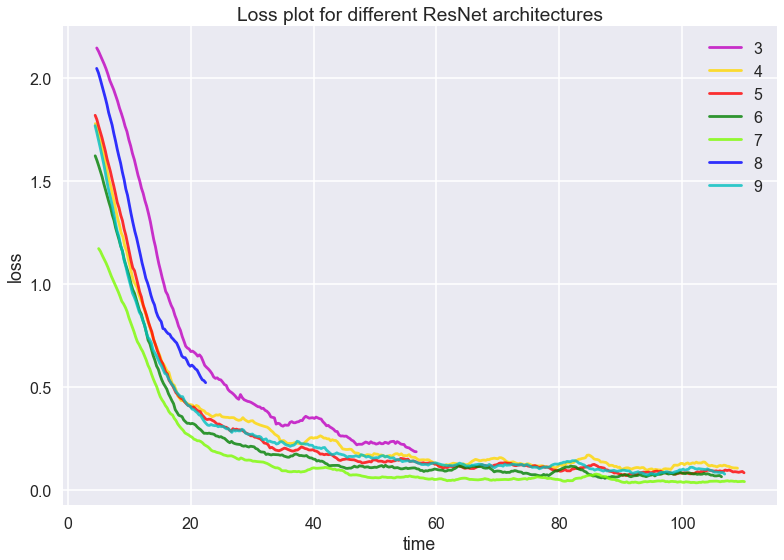

In [17]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different ResNet architectures')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue', 'y', 'cian']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['3', '4', '5', '6', '7', '8', '9']
gammas = [0.0, 0.5, 1.0, 2.0, 5.0, 6.0]
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

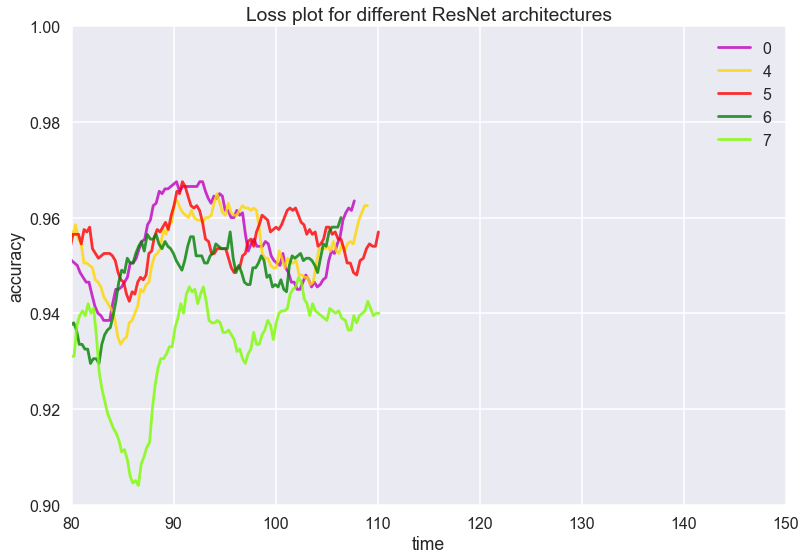

In [9]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different ResNet architectures')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue', 'y', 'cian']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['0', '4', '5', '6', '7']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_accs_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = keys_300[index], alpha=0.8)
plt.axis([80, 150, 0.90, 1 ])
plt.legend()
plt.xlabel('time')
plt.ylabel('accuracy')
plt.show()

In [17]:
sess = tf.Session()
a = tf.constant(0.0)
b = tf.placeholder(tf.float32, shape=[1, 3])
c = tf.pow(b, a)
sess.run(tf.global_variables_initializer())
sess.run(c, feed_dict={b:[[1, 2, 3]]})

array([[ 1.,  1.,  1.]], dtype=float32)

# Save

In [12]:
with open("loss_results.txt", "wb") as a:
    pickle.dump(test_losses_lengths, a)
    
with open("accs_results.txt", "wb") as a:
    pickle.dump(test_accs_lengths, a)

with open("time_results.txt", "wb") as a:
    pickle.dump(train_times_lengths, a)

# Load

In [5]:
with open("loss_results.txt", "rb") as a:
    test_losses_lengths = pickle.load(a)
    
with open("accs_results.txt", "rb") as a:
    test_accs_lengths = pickle.load(a)

with open("time_results.txt", "rb") as a:
    train_times_lengths = pickle.load(a)
    
print('ok')

ok
